# Test of the routines used in cp2k and libGint to compute the ssss(m) integrals for a given value of T and maximum value of m

Tested the implementation of the calculation of the ssss(m)[T] integrals in libGint compared to cp2k. Essentially, I want to prove they give the same results, and they both are acceptably close to the correct value

In [1]:
import numpy as np
import matplotlib.pyplot as plt

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [3]:
Teps = 1.e-13 # hardcoded in source. If T is smaller than Teps, T is zero
DBL_EPSILON = 1.e-16 # It is the DBL_EPSILON from float.h, _should_ have this value in most systems

""" This routine is used to (slowly) produce a reference value of ssss(m)[T] 
    I assume they are exact with a tolerance of DBL_EPSILON
nmax : will produce all ssss(m) from 0 to nmax
T : T
f : output array
"""
def fgamma_ref( nmax , T, f):
    kmax = 50
    r = np.zeros(kmax+10)

    if (T < Teps) :
        for n in range(nmax+1): #( int n = 0 ; n <= nmax ; n++ ){
            f[n] = 1.0/(2.*n + 1.)
    elif (T <= 50.0) :
        # Initialize ratios of Bessel functions
        r[kmax + 9] = 0.0;
        for j in range(kmax+9, 0, -1): #( int j = kmax+9; j >= 1; j--){
            r[j-1] = -T/((4.*j + 2.) - T*r[j+1-1]);
        factor = 2.0*np.sinh(0.5*T)*np.exp(-0.5*T)/T;
        for n in range(nmax+1): #( int n = 0; n <= nmax ; n++ ){
            # Initialize iteration
            sumtot = factor/(2.*n + 1.);
            term = 1.0;
            # Begin the summation and recursion
            for k in range(1, kmax+1): # ( int k = 1; k <= kmax ; k++ ){
                term = term*(2.*n - 2.*k + 1.)/(2.*n + 2.*k + 1);
                # Product of Bessel function quotients
                p = 1.0;
                for j in range(1,k+1): # ( int j = 1 ; j <= k ; j++ ){
                    p = p*r[j-1];
                sumterm = factor*term*p*(2.*k + 1.)/(2.*n + 1.);
                #
                if (abs(sumterm) < DBL_EPSILON) :
                    # Iteration converged
                    break;
                elif (k == kmax) :
                    # No convergence with kmax iterations
                    assert(k<kmax);
                else :
                    # Add the current term to the sum and continue the iteration
                    sumtot = sumtot + sumterm;
            f[n] = sumtot;
    else :
        # Use asymptotic formula for T > 50
        f[0] = 0.5*np.sqrt(np.pi/T);
        # Use the upward recursion relation to
        # generate the remaining F_n(t) values
        expt = np.exp(-T);
        for n in range(1,nmax+1) : # ( int n = 1 ; n <= nmax ; n++ ){
            f[n] = 0.5*((2.*n-1.)*f[n-1] - expt)/T;

            
            


In [13]:
for n in range(10-1, 0-1, -1) :
    print (n)

9
8
7
6
5
4
3
2
1
0


In [4]:
            
""" Will return a table that can be used to compute all values of ssss(0)[tmin:tmax] by interpolation """
def create_md_ftable( nmax, tmin, tmax, tdelta):
    # Will use 6 derivatives to interpolate
    n = nmax + 6;
    itabmin = int(np.floor(tmin/tdelta));
    itabmax = int((tmax - tmin)/tdelta);
    nelem = (itabmax - itabmin + 1 ) * (n+1);
    ftable = np.zeros( nelem );
    # Fill table
    for itab in range(itabmin, itabmax+1 ) : # ( int itab = itabmin; itab <= itabmax; itab++ ){
        T = float(itab)*tdelta;
        # fill ftable from itab*(n+1) to (itab+1)*(n+1) with f values
        fgamma_ref(n, T, ftable[itab*(n+1):(itab+1)*(n+1)]);
    ld = n+1;
    return ftable, ld, tdelta;

""" Will compute the ssss(0:nmax)[T] and save them in the f array. 
    For T less than T_eps it will return ssss(m)[T=0]
    For T less than 12 it will interpolate ftable to compute f[nmax]
        and then recurse downward to f[0]
    For T more than 12 it will do a segmented Taylor expansion to compute f[0]
        and then recurse upward to f[nmax]
"""
def fgamma_int( nmax, T, f, ftable, ftable_ld, ftable_dt ):
    if ( T < Teps ) :
        # eps < T -> T=0
        for n in range(nmax+1): #( int n = 0 ; n <= nmax ; n++ ){
            f[n] = 1.0/(2.*n+1.);
    elif ( T < 12.  ) :
        # eps < T < 12 -> Taylor expansion + downward
        tdelta = ftable_dt;
        itab = int(round(T/tdelta));
        ttab = float(itab)*tdelta;
        tmp = 1.0;
        inv_fac = 1.0; # 1/i!
        f[nmax] = ftable[itab*ftable_ld+nmax];
        # 6th order Taylor expansion
        tmp *= (ttab-T); inv_fac /= 1.0 ; f[nmax] += ftable[itab*ftable_ld+nmax+1]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac /= 2.0 ; f[nmax] += ftable[itab*ftable_ld+nmax+2]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac /= 3.0 ; f[nmax] += ftable[itab*ftable_ld+nmax+3]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac /= 4.0 ; f[nmax] += ftable[itab*ftable_ld+nmax+4]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac /= 5.0 ; f[nmax] += ftable[itab*ftable_ld+nmax+5]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac /= 6.0 ; f[nmax] += ftable[itab*ftable_ld+nmax+6]*tmp*inv_fac;
#      for ( int k=1; k <= 6; k++ ){
#         tmp *= (ttab-T);
#         f[nmax] += ftable[itab*ftable_ld+nmax+k]*tmp*ifac[k];
#      }
        # Use the downward recursion relation to 
        # generate the remaining F_n(t) values   
        expt = np.exp(-T);
        for n in range(nmax-1, 0-1, -1) : # ( int n = nmax-1 ; n >= 0 ; n--){
            f[n] = (2.0*T*f[n + 1] + expt)/(2.*n + 1.);
    else :
        # T > 12 -> segmented Taylor + upward
        tmp = 1.0/T; # reciprocal value
        if (T <= 15.0) :
            # 12 < T <= 15 -> Four term polynom expansion
            tmp2 = tmp*tmp;
            tmp3 = tmp*tmp2;
            g = 0.4999489092 - 0.2473631686*tmp + 0.321180909*tmp2 - 0.3811559346*tmp3;
            f[0] = 0.5*np.sqrt(np.pi*tmp) - g*np.exp(-T)*tmp;
        elif (T <= 18.0) :
            # 15 < T <= 18 -> Three term polynom expansion
            g = 0.4998436875 - 0.24249438*tmp + 0.24642845*tmp*tmp;
            f[0] = 0.5*np.sqrt(np.pi*tmp) - g*np.exp(-T)*tmp;
        elif (T <= 24.0) :
            # 18 < T <= 24 -> Two term polynom expansion
            g = 0.499093162 - 0.2152832*tmp;
            f[0] = 0.5*np.sqrt(np.pi*tmp) - g*np.exp(-T)*tmp;
        elif (T <= 30.0) :
            # 24 < T <= 30 -> One term polynom expansion
            g = 0.49;
            f[0] = 0.5*np.sqrt(np.pi*tmp) - g*np.exp(-T)*tmp;
        else :
            # T > 30 -> Asymptotic formula
            f[0] = 0.5*np.sqrt(np.pi*tmp);
        # Use the upward recursion relation to
        # generate the remaining F_n(t) values
        expt = 0.0;
        if ( T > 2.*nmax + 36.):
            expt = 0.0;
        else :
            expt = np.exp(-T);
        
        for n in range(1, nmax+1) : # ( int n=1 ; n <= nmax ; n++ ){
            f[n] = (0.5*tmp)*( (2.*n - 1.)*f[n - 1] - expt );


In [5]:
""" Will compute the ssss(0:nmax)[T] and save them in the f array. 
    For T less than T_eps it will return ssss(m)[T=0]
    For T less than 12 it will interpolate ftable to compute f[nmax]
        and then recurse downward to f[0]
    For T more than 12 it will do a fixed Taylor expansion to compute f[0]
        and then recurse upward to f[nmax]
"""
def fgamma( nmax, T, f, ftable, ftable_ld, ftable_dt ):
    if ( T < Teps ) :
        # eps < T -> T=0
        for n in range(0,nmax+1) : # ( int n = 0 ; n <= nmax ; n++ ){
            f[n] = 1.0/(2.*n+1.);
    elif ( T < 12.  ) :
        # eps < T < 12 -> Taylor expansion + downward
        tdelta = ftable_dt;
        itab = int(round(T/tdelta));
        ttab = float(itab)*tdelta;
        tmp = 1.0;
        inv_fac = 1.0; # 1/i!
        f[nmax] = ftable[itab*ftable_ld+nmax];
        # 6th order Taylor expansion
        tmp *= (ttab-T); inv_fac = 1.0    ; f[nmax] += ftable[itab*ftable_ld+nmax+1]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac = 0.5    ; f[nmax] += ftable[itab*ftable_ld+nmax+2]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac = 1./6.  ; f[nmax] += ftable[itab*ftable_ld+nmax+3]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac = 1./24. ; f[nmax] += ftable[itab*ftable_ld+nmax+4]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac = 1./120.; f[nmax] += ftable[itab*ftable_ld+nmax+5]*tmp*inv_fac;
        tmp *= (ttab-T); inv_fac = 1./720.; f[nmax] += ftable[itab*ftable_ld+nmax+6]*tmp*inv_fac;
        # Use the downward recursion relation to 
        # generate the remaining F_n(t) values   
        expt = np.exp(-T);
        for n in range(nmax-1, 0-1, -1 ) : # ( int n = nmax-1 ; n >= 0 ; n--){
            f[n] = (2.0*T*f[n + 1] + expt)/(2.*n + 1.);
    else :
        # T > 12 -> 4 Taylor + upward
        tmp = 1.0/T; # reciprocal value
        tmp2 = tmp*tmp;
        tmp3 = tmp*tmp2;
        g = 0.4999489092 - 0.2473631686*tmp + 0.321180909*tmp2 - 0.3811559346*tmp3;
        f[0] = 0.5*np.sqrt(np.pi*tmp) - g*np.exp(-T)*tmp;
        # Use the upward recursion relation to
        # generate the remaining F_n(t) values
        expt = np.exp(-T);

        for n in range(1,nmax+1) : # ( int n=1 ; n <= nmax ; n++ ){
            f[n] = (0.5*tmp)*( (2.*n - 1.)*f[n - 1] - expt );


In [6]:
# change
Lmax = 17
L = 17

# don't change
max_T = 12. # hardcoded in source # max value of tabulated T
dT = 0.1  # hardcoded in source

ftable, ftable_ld, ftable_dt = create_md_ftable( Lmax, 0, max_T, dT )



2.2210011607626257e-13


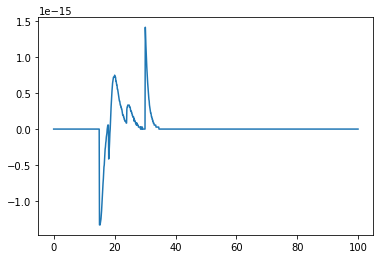

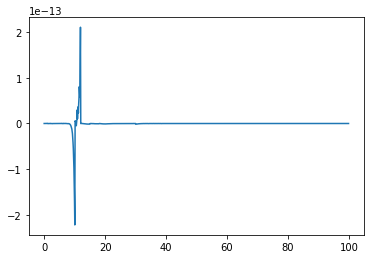

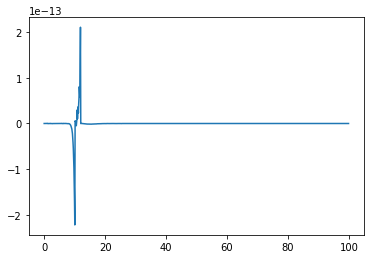

In [7]:
# Change
nT = 1024

#don't change
all_diff = np.zeros((nT, 3, L+1))
all_T = []

assert(L <= Lmax)

for iT in range(nT):
    
    T = iT / nT * 100
    
    f_ref = np.zeros(L+1)
    f_int = np.zeros(L+1)
    f = np.zeros(L+1)

    fgamma_ref( L, T, f_ref)
    fgamma_int( L, T, f_int, ftable, ftable_ld, ftable_dt)
    fgamma    ( L, T, f    , ftable, ftable_ld, ftable_dt)
    
    all_diff[iT, 0, : ] = f_int - f
    all_diff[iT, 1, : ] = f_ref - f_int
    all_diff[iT, 2, : ] = f_ref - f
        
    all_T.append(T)

all_T = np.array(all_T)

print( np.max( np.abs( all_diff ) ) )

plt.plot(all_T, all_diff[:,0,0], label='Grid integration - Mine')
plt.show()

plt.plot(all_T, all_diff[:,1,0], label='Reference - Grid integration')
plt.show()

plt.plot(all_T, all_diff[:,2,0], label='Reference - Mine')
plt.show()


11.5


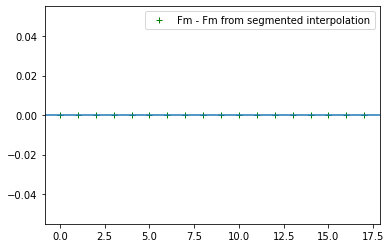

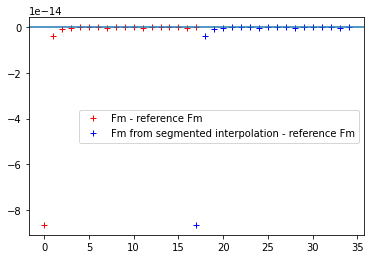

In [8]:
T = 11.5

assert(L <= Lmax)

f_ref = np.zeros(L+1)
f_int = np.zeros(L+1)
f = np.zeros(L+1)

fgamma_ref( L, T, f_ref)
fgamma_int( L, T, f_int, ftable, ftable_ld, ftable_dt)
fgamma    ( L, T, f    , ftable, ftable_ld, ftable_dt)

print(T)

x = np.array([i for i in range(L+1)])
plt.plot(x,     f - f_int, '+g', label='Fm - Fm from segmented interpolation')
plt.legend()
plt.axhline( 0 )
plt.show()

plt.plot(x,     f - f_ref, '+r', label='Fm - reference Fm')
plt.plot(x + L, f_int - f_ref, '+b', label='Fm from segmented interpolation - reference Fm')

plt.legend()
plt.axhline( 0 )
plt.show()


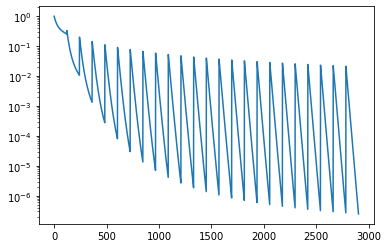

11.5
[2.61333640e-01 1.13618917e-02 1.48154544e-03 3.21634656e-04
 9.74483696e-05 3.76915318e-05 1.75859459e-05 9.49944364e-06
 5.75485048e-06 3.81314628e-06 2.70955156e-06 2.03349952e-06
 1.59306067e-06 1.29114884e-06 1.07525761e-06 9.15320740e-07
 7.93254319e-07 6.97708649e-07]
[2.61333640e-01 1.13618917e-02 1.48154544e-03 3.21634656e-04
 9.74483696e-05 3.76915318e-05 1.75859459e-05 9.49944364e-06
 5.75485048e-06 3.81314628e-06 2.70955156e-06 2.03349952e-06
 1.59306067e-06 1.29114884e-06 1.07525761e-06 9.15320740e-07
 7.93254319e-07 6.97708649e-07]
[2.61333640e-01 1.13618917e-02 1.48154544e-03 3.21634656e-04
 9.74483696e-05 3.76915318e-05 1.75859459e-05 9.49944364e-06
 5.75485048e-06 3.81314628e-06 2.70955156e-06 2.03349952e-06
 1.59306067e-06 1.29114884e-06 1.07525761e-06 9.15320740e-07
 7.93254319e-07 6.97708649e-07]


In [9]:
plt.semilogy(ftable.reshape((-1,ftable_ld)).T.flatten())
plt.show()

print(T)
print(f_ref)
print(f_int)
print(f)


[2.61333640e-01 1.13618917e-02 1.48154544e-03 3.21634656e-04
 9.74483696e-05 3.76915318e-05 1.75859459e-05 9.49944364e-06
 5.75485048e-06 3.81314628e-06 2.70955156e-06 2.03349952e-06
 1.59306067e-06 1.29114884e-06 1.07525761e-06 9.15320740e-07
 7.93254319e-07 6.97708649e-07]


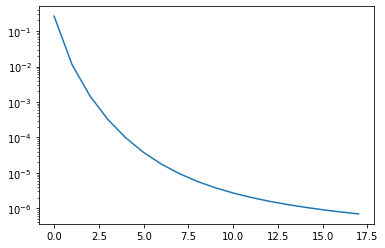

In [10]:
print(f)
plt.semilogy(f)


In [11]:
tmp = np.zeros(5)
fgamma_ref( 4, 10, tmp )
tmp

array([2.80247391e-01, 1.40100995e-02, 2.09924493e-03, 5.22541237e-04,
       1.80619436e-04])

# Test of the tabulated section of the calculation of F

#################################################
Error at  0 0 0  is  1.2346273532943397e-16


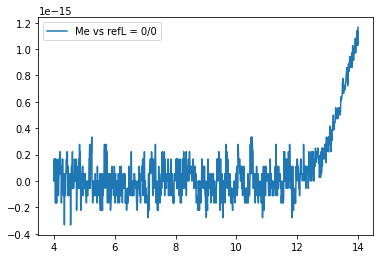

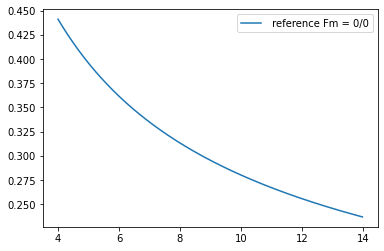

#################################################
0 0 0 Me vs ref 1.1657341758564144e-15 
#################################################
Error at  0 0 0  is  1.2346273532943397e-16


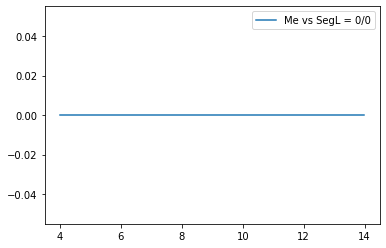

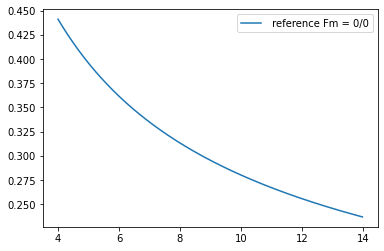

#################################################
0 0 0 Me vs Seg 0.0 
#################################################
Error at  0 0 0  is  1.2346273532943397e-16


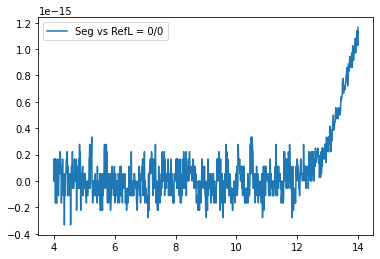

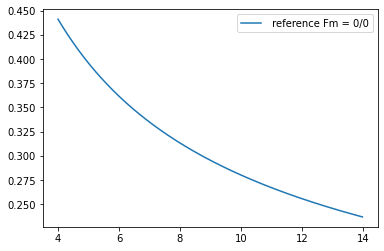

#################################################
0 0 0 Seg vs Ref 1.1657341758564144e-15 

1 0 0 Me vs ref 1.1657341758564144e-15 
1 0 0 Me vs Seg 0.0 
1 0 0 Seg vs Ref 1.1657341758564144e-15 

1 1 0 Me vs ref 2.55351295663786e-15 
1 1 0 Me vs Seg 0.0 
1 1 0 Seg vs Ref 2.55351295663786e-15 

1 1 1 Me vs ref 2.914335439641036e-16 
1 1 1 Me vs Seg 0.0 
1 1 1 Seg vs Ref 2.914335439641036e-16 

2 0 0 Me vs ref 1.1657341758564144e-15 
2 0 0 Me vs Seg 0.0 
2 0 0 Seg vs Ref 1.1657341758564144e-15 

2 1 0 Me vs ref 2.55351295663786e-15 
2 1 0 Me vs Seg 0.0 
2 1 0 Seg vs Ref 2.55351295663786e-15 

2 1 1 Me vs ref 2.914335439641036e-16 
2 1 1 Me vs Seg 0.0 
2 1 1 Seg vs Ref 2.914335439641036e-16 

2 2 0 Me vs ref 1.7819079545233762e-14 
2 2 0 Me vs Seg 0.0 
2 2 0 Seg vs Ref 1.7819079545233762e-14 

2 2 1 Me vs ref 8.205242041370298e-16 
2 2 1 Me vs Seg 0.0 
2 2 1 Seg vs Ref 8.205242041370298e-16 

2 2 2 Me vs ref 1.5092094240998222e-16 
2 2 2 Me vs Seg 0.0 
2 2 2 Seg vs Ref 1.5092094240998222e-

7 1 0 Me vs ref 2.55351295663786e-15 
7 1 0 Me vs Seg 0.0 
7 1 0 Seg vs Ref 2.55351295663786e-15 

7 1 1 Me vs ref 2.914335439641036e-16 
7 1 1 Me vs Seg 0.0 
7 1 1 Seg vs Ref 2.914335439641036e-16 

7 2 0 Me vs ref 1.7819079545233762e-14 
7 2 0 Me vs Seg 0.0 
7 2 0 Seg vs Ref 1.7819079545233762e-14 

7 2 1 Me vs ref 8.205242041370298e-16 
7 2 1 Me vs Seg 0.0 
7 2 1 Seg vs Ref 8.205242041370298e-16 

7 2 2 Me vs ref 1.5092094240998222e-16 
7 2 2 Me vs Seg 0.0 
7 2 2 Seg vs Ref 1.5092094240998222e-16 

7 3 0 Me vs ref 7.077671781985373e-14 
7 3 0 Me vs Seg 0.0 
7 3 0 Seg vs Ref 7.077671781985373e-14 

7 3 1 Me vs ref 3.2855662635000726e-15 
7 3 1 Me vs Seg 0.0 
7 3 1 Seg vs Ref 3.2855662635000726e-15 

7 3 2 Me vs ref 5.193328406205566e-16 
7 3 2 Me vs Seg 0.0 
7 3 2 Seg vs Ref 5.193328406205566e-16 

7 3 3 Me vs ref 2.220446049250313e-16 
7 3 3 Me vs Seg 0.0 
7 3 3 Seg vs Ref 2.220446049250313e-16 

7 4 0 Me vs ref 3.0597746558669314e-13 
7 4 0 Me vs Seg 0.0 
7 4 0 Seg vs Ref 3.0597746

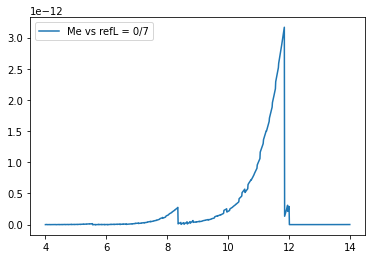

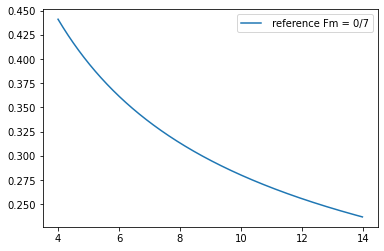

#################################################
7 7 0 Me vs ref 3.165356865508784e-12 # 
7 7 0 Me vs Seg 0.0 
#################################################
Error at  7 7 0  is  1.2346273532943397e-16


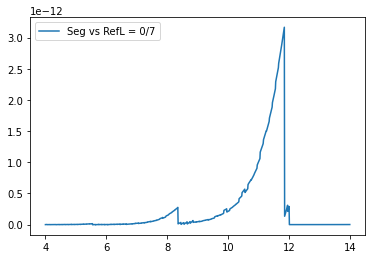

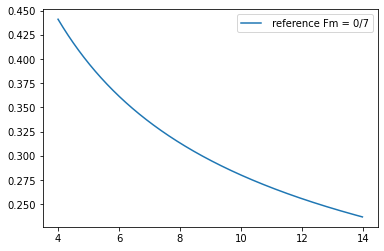

#################################################
7 7 0 Seg vs Ref 3.165356865508784e-12 # 

7 7 1 Me vs ref 1.3357544237369012e-13 
7 7 1 Me vs Seg 0.0 
7 7 1 Seg vs Ref 1.3357544237369012e-13 

7 7 2 Me vs ref 1.6952802009417844e-14 
7 7 2 Me vs Seg 0.0 
7 7 2 Seg vs Ref 1.6952802009417844e-14 

7 7 3 Me vs ref 3.5335233003475075e-15 
7 7 3 Me vs Seg 0.0 
7 7 3 Seg vs Ref 3.5335233003475075e-15 

7 7 4 Me vs ref 1.0686709763646496e-15 
7 7 4 Me vs Seg 0.0 
7 7 4 Seg vs Ref 1.0686709763646496e-15 

7 7 5 Me vs ref 3.885441773009146e-16 
7 7 5 Me vs Seg 0.0 
7 7 5 Seg vs Ref 3.885441773009146e-16 

7 7 6 Me vs ref 2.124528038303236e-16 
7 7 6 Me vs Seg 0.0 
7 7 6 Seg vs Ref 2.124528038303236e-16 

7 7 7 Me vs ref 1.2240642527361345e-16 
7 7 7 Me vs Seg 0.0 
7 7 7 Seg vs Ref 1.2240642527361345e-16 

8 0 0 Me vs ref 1.1657341758564144e-15 
8 0 0 Me vs Seg 0.0 
8 0 0 Seg vs Ref 1.1657341758564144e-15 

8 1 0 Me vs ref 2.55351295663786e-15 
8 1 0 Me vs Seg 0.0 
8 1 0 Seg vs Ref 2.553512956

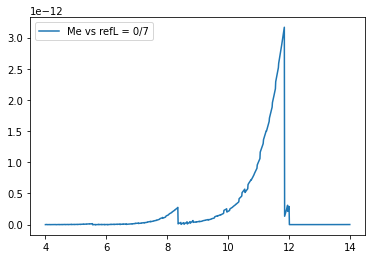

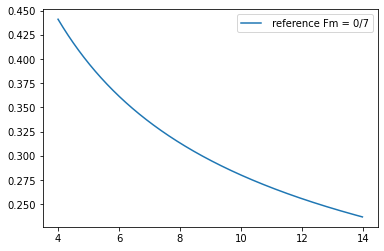

#################################################
8 7 0 Me vs ref 3.165356865508784e-12 # 
8 7 0 Me vs Seg 0.0 
#################################################
Error at  8 7 0  is  1.2346273532943397e-16


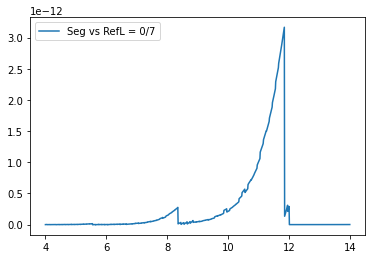

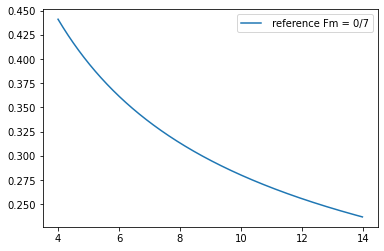

#################################################
8 7 0 Seg vs Ref 3.165356865508784e-12 # 

8 7 1 Me vs ref 1.3357544237369012e-13 
8 7 1 Me vs Seg 0.0 
8 7 1 Seg vs Ref 1.3357544237369012e-13 

8 7 2 Me vs ref 1.6952802009417844e-14 
8 7 2 Me vs Seg 0.0 
8 7 2 Seg vs Ref 1.6952802009417844e-14 

8 7 3 Me vs ref 3.5335233003475075e-15 
8 7 3 Me vs Seg 0.0 
8 7 3 Seg vs Ref 3.5335233003475075e-15 

8 7 4 Me vs ref 1.0686709763646496e-15 
8 7 4 Me vs Seg 0.0 
8 7 4 Seg vs Ref 1.0686709763646496e-15 

8 7 5 Me vs ref 3.885441773009146e-16 
8 7 5 Me vs Seg 0.0 
8 7 5 Seg vs Ref 3.885441773009146e-16 

8 7 6 Me vs ref 2.124528038303236e-16 
8 7 6 Me vs Seg 0.0 
8 7 6 Seg vs Ref 2.124528038303236e-16 

8 7 7 Me vs ref 1.2240642527361345e-16 
8 7 7 Me vs Seg 0.0 
8 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  8 8 0  is  1.2346273532943397e-16


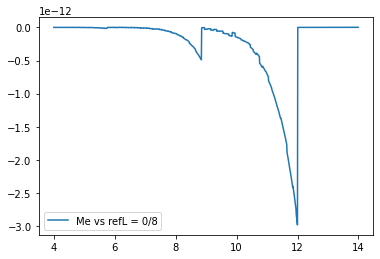

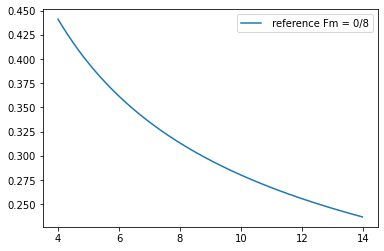

#################################################
8 8 0 Me vs ref 2.9816149549333204e-12 # 
8 8 0 Me vs Seg 0.0 
#################################################
Error at  8 8 0  is  1.2346273532943397e-16


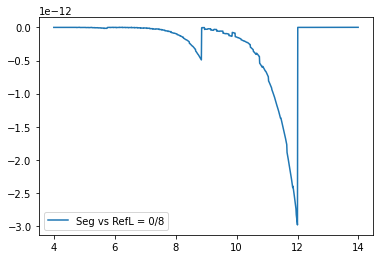

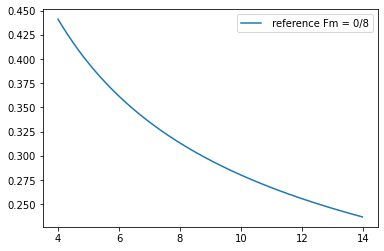

#################################################
8 8 0 Seg vs Ref 2.9816149549333204e-12 # 

8 8 1 Me vs ref 1.2435018292844546e-13 
8 8 1 Me vs Seg 0.0 
8 8 1 Seg vs Ref 1.2435018292844546e-13 

8 8 2 Me vs ref 1.5503223704804725e-14 
8 8 2 Me vs Seg 0.0 
8 8 2 Seg vs Ref 1.5503223704804725e-14 

8 8 3 Me vs ref 3.2831810187206045e-15 
8 8 3 Me vs Seg 0.0 
8 8 3 Seg vs Ref 3.2831810187206045e-15 

8 8 4 Me vs ref 9.31871767251291e-16 
8 8 4 Me vs Seg 0.0 
8 8 4 Seg vs Ref 9.31871767251291e-16 

8 8 5 Me vs ref 3.7119694254114655e-16 
8 8 5 Me vs Seg 0.0 
8 8 5 Seg vs Ref 3.7119694254114655e-16 

8 8 6 Me vs ref 1.4072944198861848e-16 
8 8 6 Me vs Seg 0.0 
8 8 6 Seg vs Ref 1.4072944198861848e-16 

8 8 7 Me vs ref 1.8633877806647353e-16 
8 8 7 Me vs Seg 0.0 
8 8 7 Seg vs Ref 1.8633877806647353e-16 

8 8 8 Me vs ref 1.0728095793449341e-16 
8 8 8 Me vs Seg 0.0 
8 8 8 Seg vs Ref 1.0728095793449341e-16 

9 0 0 Me vs ref 1.1657341758564144e-15 
9 0 0 Me vs Seg 0.0 
9 0 0 Seg vs Ref 1.165734

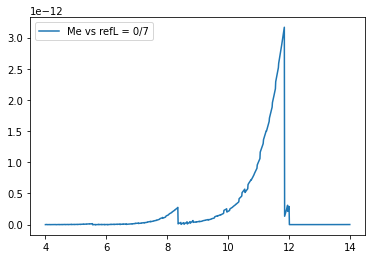

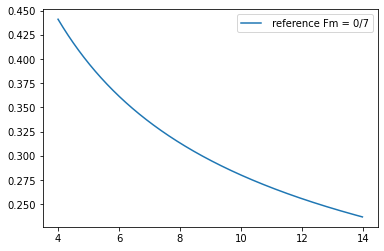

#################################################
9 7 0 Me vs ref 3.165356865508784e-12 # 
9 7 0 Me vs Seg 0.0 
#################################################
Error at  9 7 0  is  1.2346273532943397e-16


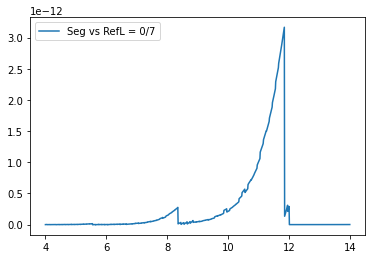

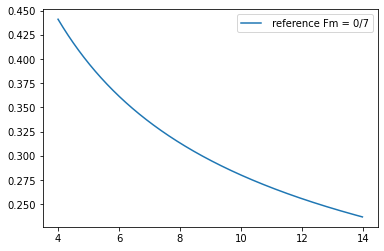

#################################################
9 7 0 Seg vs Ref 3.165356865508784e-12 # 

9 7 1 Me vs ref 1.3357544237369012e-13 
9 7 1 Me vs Seg 0.0 
9 7 1 Seg vs Ref 1.3357544237369012e-13 

9 7 2 Me vs ref 1.6952802009417844e-14 
9 7 2 Me vs Seg 0.0 
9 7 2 Seg vs Ref 1.6952802009417844e-14 

9 7 3 Me vs ref 3.5335233003475075e-15 
9 7 3 Me vs Seg 0.0 
9 7 3 Seg vs Ref 3.5335233003475075e-15 

9 7 4 Me vs ref 1.0686709763646496e-15 
9 7 4 Me vs Seg 0.0 
9 7 4 Seg vs Ref 1.0686709763646496e-15 

9 7 5 Me vs ref 3.885441773009146e-16 
9 7 5 Me vs Seg 0.0 
9 7 5 Seg vs Ref 3.885441773009146e-16 

9 7 6 Me vs ref 2.124528038303236e-16 
9 7 6 Me vs Seg 0.0 
9 7 6 Seg vs Ref 2.124528038303236e-16 

9 7 7 Me vs ref 1.2240642527361345e-16 
9 7 7 Me vs Seg 0.0 
9 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  9 8 0  is  1.2346273532943397e-16


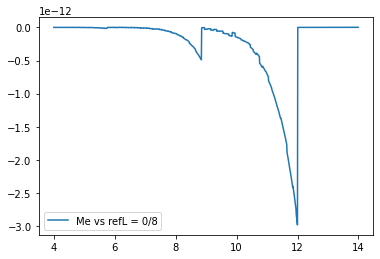

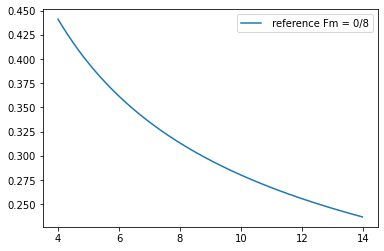

#################################################
9 8 0 Me vs ref 2.9816149549333204e-12 # 
9 8 0 Me vs Seg 0.0 
#################################################
Error at  9 8 0  is  1.2346273532943397e-16


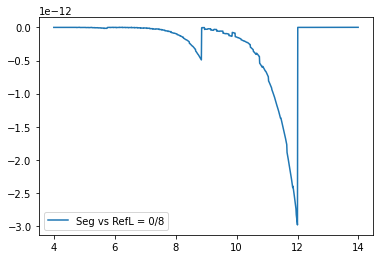

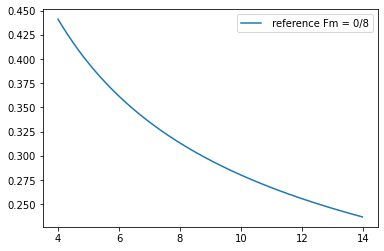

#################################################
9 8 0 Seg vs Ref 2.9816149549333204e-12 # 

9 8 1 Me vs ref 1.2435018292844546e-13 
9 8 1 Me vs Seg 0.0 
9 8 1 Seg vs Ref 1.2435018292844546e-13 

9 8 2 Me vs ref 1.5503223704804725e-14 
9 8 2 Me vs Seg 0.0 
9 8 2 Seg vs Ref 1.5503223704804725e-14 

9 8 3 Me vs ref 3.2831810187206045e-15 
9 8 3 Me vs Seg 0.0 
9 8 3 Seg vs Ref 3.2831810187206045e-15 

9 8 4 Me vs ref 9.31871767251291e-16 
9 8 4 Me vs Seg 0.0 
9 8 4 Seg vs Ref 9.31871767251291e-16 

9 8 5 Me vs ref 3.7119694254114655e-16 
9 8 5 Me vs Seg 0.0 
9 8 5 Seg vs Ref 3.7119694254114655e-16 

9 8 6 Me vs ref 1.4072944198861848e-16 
9 8 6 Me vs Seg 0.0 
9 8 6 Seg vs Ref 1.4072944198861848e-16 

9 8 7 Me vs ref 1.8633877806647353e-16 
9 8 7 Me vs Seg 0.0 
9 8 7 Seg vs Ref 1.8633877806647353e-16 

9 8 8 Me vs ref 1.0728095793449341e-16 
9 8 8 Me vs Seg 0.0 
9 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  9 9 0  is  1.2346273532943

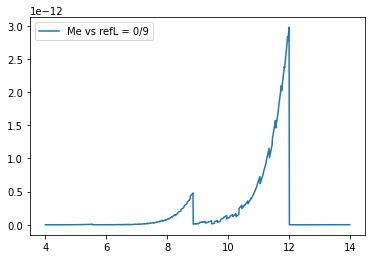

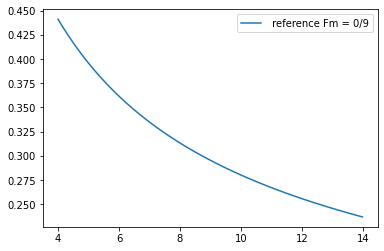

#################################################
9 9 0 Me vs ref 2.9801716650013077e-12 # 
9 9 0 Me vs Seg 0.0 
#################################################
Error at  9 9 0  is  1.2346273532943397e-16


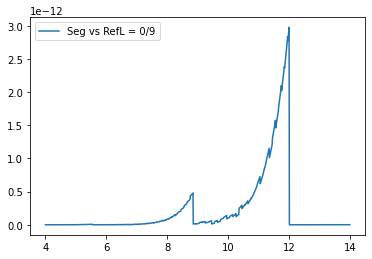

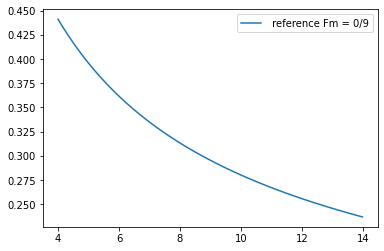

#################################################
9 9 0 Seg vs Ref 2.9801716650013077e-12 # 

9 9 1 Me vs ref 1.2409691330095285e-13 
9 9 1 Me vs Seg 0.0 
9 9 1 Seg vs Ref 1.2409691330095285e-13 

9 9 2 Me vs ref 1.5557650653863497e-14 
9 9 2 Me vs Seg 0.0 
9 9 2 Seg vs Ref 1.5557650653863497e-14 

9 9 3 Me vs ref 3.18890963982299e-15 
9 9 3 Me vs Seg 0.0 
9 9 3 Seg vs Ref 3.18890963982299e-15 

9 9 4 Me vs ref 9.561307908606542e-16 
9 9 4 Me vs Seg 0.0 
9 9 4 Seg vs Ref 9.561307908606542e-16 

9 9 5 Me vs ref 3.369192132316595e-16 
9 9 5 Me vs Seg 0.0 
9 9 5 Seg vs Ref 3.369192132316595e-16 

9 9 6 Me vs ref 1.9072810279914532e-16 
9 9 6 Me vs Seg 0.0 
9 9 6 Seg vs Ref 1.9072810279914532e-16 

9 9 7 Me vs ref 1.127231446206023e-16 
9 9 7 Me vs Seg 0.0 
9 9 7 Seg vs Ref 1.127231446206023e-16 

9 9 8 Me vs ref 2.041755978697546e-16 
9 9 8 Me vs Seg 0.0 
9 9 8 Seg vs Ref 2.041755978697546e-16 

9 9 9 Me vs ref 1.1075125191939428e-16 
9 9 9 Me vs Seg 0.0 
9 9 9 Seg vs Ref 1.10751251919394

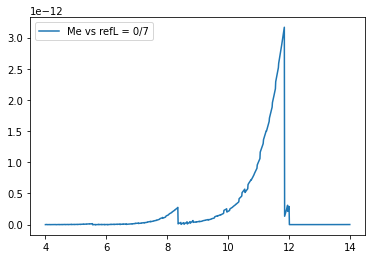

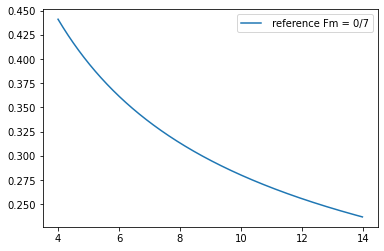

#################################################
10 7 0 Me vs ref 3.165356865508784e-12 # 
10 7 0 Me vs Seg 0.0 
#################################################
Error at  10 7 0  is  1.2346273532943397e-16


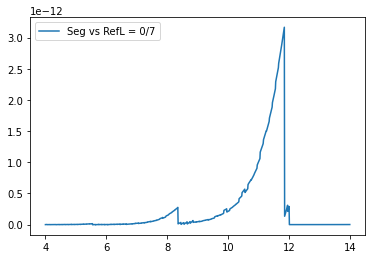

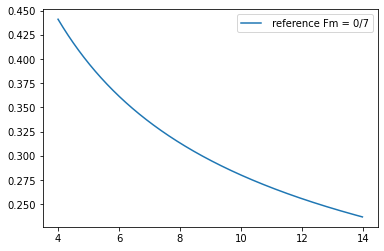

#################################################
10 7 0 Seg vs Ref 3.165356865508784e-12 # 

10 7 1 Me vs ref 1.3357544237369012e-13 
10 7 1 Me vs Seg 0.0 
10 7 1 Seg vs Ref 1.3357544237369012e-13 

10 7 2 Me vs ref 1.6952802009417844e-14 
10 7 2 Me vs Seg 0.0 
10 7 2 Seg vs Ref 1.6952802009417844e-14 

10 7 3 Me vs ref 3.5335233003475075e-15 
10 7 3 Me vs Seg 0.0 
10 7 3 Seg vs Ref 3.5335233003475075e-15 

10 7 4 Me vs ref 1.0686709763646496e-15 
10 7 4 Me vs Seg 0.0 
10 7 4 Seg vs Ref 1.0686709763646496e-15 

10 7 5 Me vs ref 3.885441773009146e-16 
10 7 5 Me vs Seg 0.0 
10 7 5 Seg vs Ref 3.885441773009146e-16 

10 7 6 Me vs ref 2.124528038303236e-16 
10 7 6 Me vs Seg 0.0 
10 7 6 Seg vs Ref 2.124528038303236e-16 

10 7 7 Me vs ref 1.2240642527361345e-16 
10 7 7 Me vs Seg 0.0 
10 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  10 8 0  is  1.2346273532943397e-16


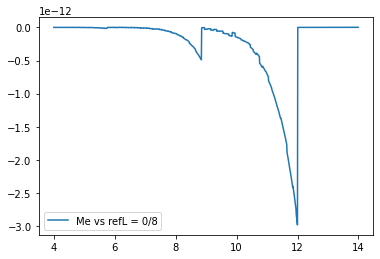

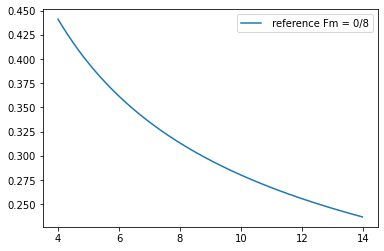

#################################################
10 8 0 Me vs ref 2.9816149549333204e-12 # 
10 8 0 Me vs Seg 0.0 
#################################################
Error at  10 8 0  is  1.2346273532943397e-16


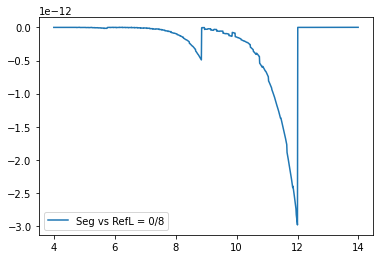

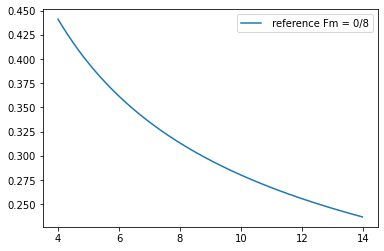

#################################################
10 8 0 Seg vs Ref 2.9816149549333204e-12 # 

10 8 1 Me vs ref 1.2435018292844546e-13 
10 8 1 Me vs Seg 0.0 
10 8 1 Seg vs Ref 1.2435018292844546e-13 

10 8 2 Me vs ref 1.5503223704804725e-14 
10 8 2 Me vs Seg 0.0 
10 8 2 Seg vs Ref 1.5503223704804725e-14 

10 8 3 Me vs ref 3.2831810187206045e-15 
10 8 3 Me vs Seg 0.0 
10 8 3 Seg vs Ref 3.2831810187206045e-15 

10 8 4 Me vs ref 9.31871767251291e-16 
10 8 4 Me vs Seg 0.0 
10 8 4 Seg vs Ref 9.31871767251291e-16 

10 8 5 Me vs ref 3.7119694254114655e-16 
10 8 5 Me vs Seg 0.0 
10 8 5 Seg vs Ref 3.7119694254114655e-16 

10 8 6 Me vs ref 1.4072944198861848e-16 
10 8 6 Me vs Seg 0.0 
10 8 6 Seg vs Ref 1.4072944198861848e-16 

10 8 7 Me vs ref 1.8633877806647353e-16 
10 8 7 Me vs Seg 0.0 
10 8 7 Seg vs Ref 1.8633877806647353e-16 

10 8 8 Me vs ref 1.0728095793449341e-16 
10 8 8 Me vs Seg 0.0 
10 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

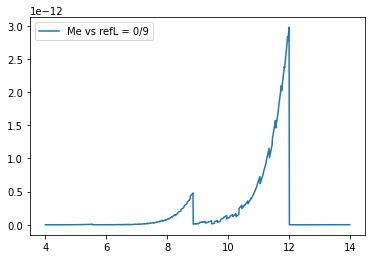

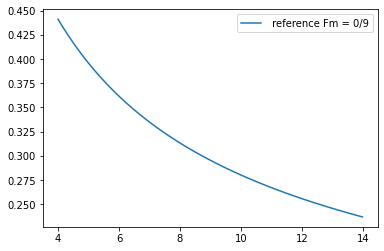

#################################################
10 9 0 Me vs ref 2.9801716650013077e-12 # 
10 9 0 Me vs Seg 0.0 
#################################################
Error at  10 9 0  is  1.2346273532943397e-16


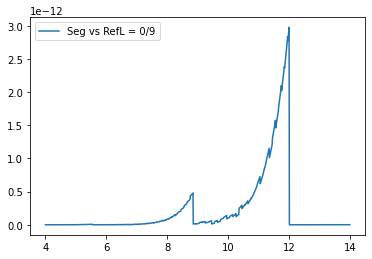

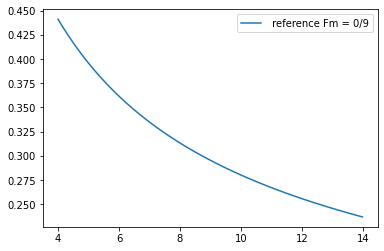

#################################################
10 9 0 Seg vs Ref 2.9801716650013077e-12 # 

10 9 1 Me vs ref 1.2409691330095285e-13 
10 9 1 Me vs Seg 0.0 
10 9 1 Seg vs Ref 1.2409691330095285e-13 

10 9 2 Me vs ref 1.5557650653863497e-14 
10 9 2 Me vs Seg 0.0 
10 9 2 Seg vs Ref 1.5557650653863497e-14 

10 9 3 Me vs ref 3.18890963982299e-15 
10 9 3 Me vs Seg 0.0 
10 9 3 Seg vs Ref 3.18890963982299e-15 

10 9 4 Me vs ref 9.561307908606542e-16 
10 9 4 Me vs Seg 0.0 
10 9 4 Seg vs Ref 9.561307908606542e-16 

10 9 5 Me vs ref 3.369192132316595e-16 
10 9 5 Me vs Seg 0.0 
10 9 5 Seg vs Ref 3.369192132316595e-16 

10 9 6 Me vs ref 1.9072810279914532e-16 
10 9 6 Me vs Seg 0.0 
10 9 6 Seg vs Ref 1.9072810279914532e-16 

10 9 7 Me vs ref 1.127231446206023e-16 
10 9 7 Me vs Seg 0.0 
10 9 7 Seg vs Ref 1.127231446206023e-16 

10 9 8 Me vs ref 2.041755978697546e-16 
10 9 8 Me vs Seg 0.0 
10 9 8 Seg vs Ref 2.041755978697546e-16 

10 9 9 Me vs ref 1.1075125191939428e-16 
10 9 9 Me vs Seg 0.0 
10 9 9

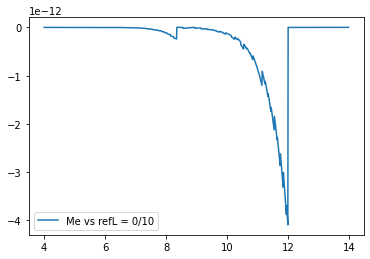

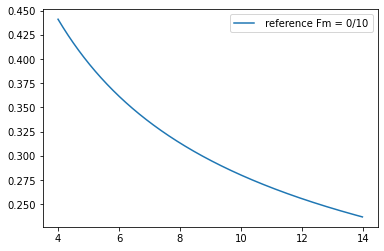

#################################################
10 10 0 Me vs ref 4.092226557617096e-12 # 
10 10 0 Me vs Seg 0.0 
#################################################
Error at  10 10 0  is  1.2346273532943397e-16


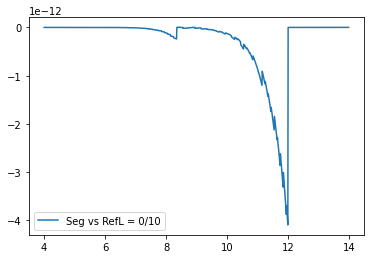

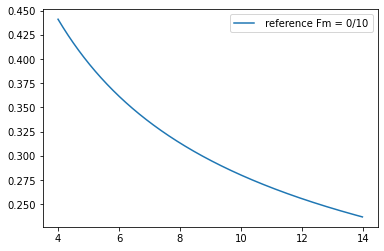

#################################################
10 10 0 Seg vs Ref 4.092226557617096e-12 # 

10 10 1 Me vs ref 1.7063433999098265e-13 
10 10 1 Me vs Seg 0.0 
10 10 1 Seg vs Ref 1.7063433999098265e-13 

10 10 2 Me vs ref 2.1289610699359862e-14 
10 10 2 Me vs Seg 0.0 
10 10 2 Seg vs Ref 2.1289610699359862e-14 

10 10 3 Me vs ref 4.48886804463311e-15 
10 10 3 Me vs Seg 0.0 
10 10 3 Seg vs Ref 4.48886804463311e-15 

10 10 4 Me vs ref 1.2835869520055887e-15 
10 10 4 Me vs Seg 0.0 
10 10 4 Seg vs Ref 1.2835869520055887e-15 

10 10 5 Me vs ref 5.031104656147423e-16 
10 10 5 Me vs Seg 0.0 
10 10 5 Seg vs Ref 5.031104656147423e-16 

10 10 6 Me vs ref 1.9510048687287201e-16 
10 10 6 Me vs Seg 0.0 
10 10 6 Seg vs Ref 1.9510048687287201e-16 

10 10 7 Me vs ref 2.1514128640490876e-16 
10 10 7 Me vs Seg 0.0 
10 10 7 Seg vs Ref 2.1514128640490876e-16 

10 10 8 Me vs ref 1.0728095793449341e-16 
10 10 8 Me vs Seg 0.0 
10 10 8 Seg vs Ref 1.0728095793449341e-16 

10 10 9 Me vs ref 1.4288429380643342e-1

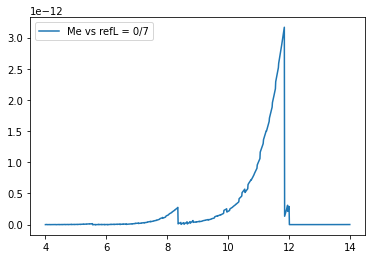

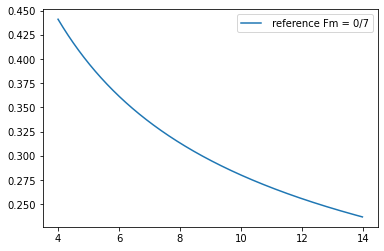

#################################################
11 7 0 Me vs ref 3.165356865508784e-12 # 
11 7 0 Me vs Seg 0.0 
#################################################
Error at  11 7 0  is  1.2346273532943397e-16


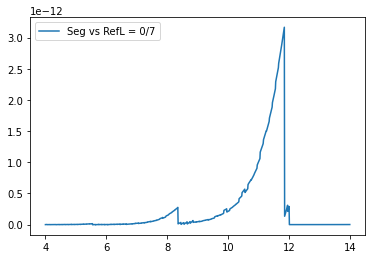

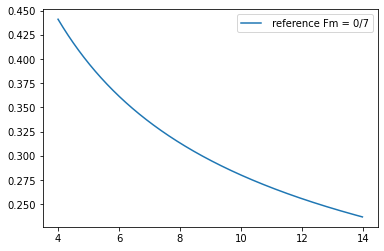

#################################################
11 7 0 Seg vs Ref 3.165356865508784e-12 # 

11 7 1 Me vs ref 1.3357544237369012e-13 
11 7 1 Me vs Seg 0.0 
11 7 1 Seg vs Ref 1.3357544237369012e-13 

11 7 2 Me vs ref 1.6952802009417844e-14 
11 7 2 Me vs Seg 0.0 
11 7 2 Seg vs Ref 1.6952802009417844e-14 

11 7 3 Me vs ref 3.5335233003475075e-15 
11 7 3 Me vs Seg 0.0 
11 7 3 Seg vs Ref 3.5335233003475075e-15 

11 7 4 Me vs ref 1.0686709763646496e-15 
11 7 4 Me vs Seg 0.0 
11 7 4 Seg vs Ref 1.0686709763646496e-15 

11 7 5 Me vs ref 3.885441773009146e-16 
11 7 5 Me vs Seg 0.0 
11 7 5 Seg vs Ref 3.885441773009146e-16 

11 7 6 Me vs ref 2.124528038303236e-16 
11 7 6 Me vs Seg 0.0 
11 7 6 Seg vs Ref 2.124528038303236e-16 

11 7 7 Me vs ref 1.2240642527361345e-16 
11 7 7 Me vs Seg 0.0 
11 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  11 8 0  is  1.2346273532943397e-16


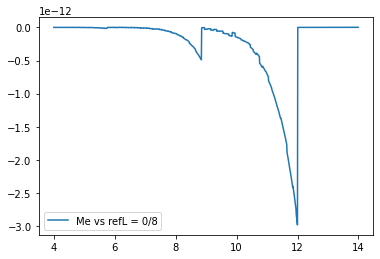

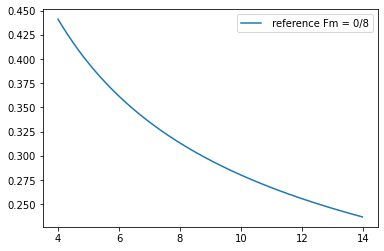

#################################################
11 8 0 Me vs ref 2.9816149549333204e-12 # 
11 8 0 Me vs Seg 0.0 
#################################################
Error at  11 8 0  is  1.2346273532943397e-16


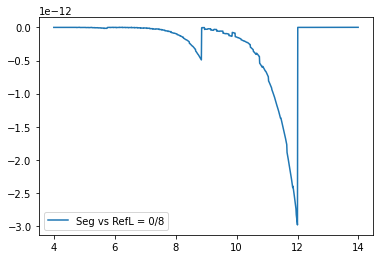

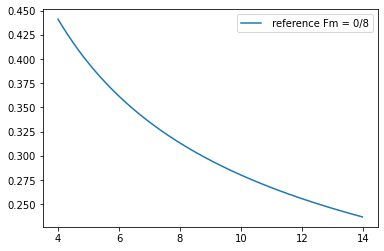

#################################################
11 8 0 Seg vs Ref 2.9816149549333204e-12 # 

11 8 1 Me vs ref 1.2435018292844546e-13 
11 8 1 Me vs Seg 0.0 
11 8 1 Seg vs Ref 1.2435018292844546e-13 

11 8 2 Me vs ref 1.5503223704804725e-14 
11 8 2 Me vs Seg 0.0 
11 8 2 Seg vs Ref 1.5503223704804725e-14 

11 8 3 Me vs ref 3.2831810187206045e-15 
11 8 3 Me vs Seg 0.0 
11 8 3 Seg vs Ref 3.2831810187206045e-15 

11 8 4 Me vs ref 9.31871767251291e-16 
11 8 4 Me vs Seg 0.0 
11 8 4 Seg vs Ref 9.31871767251291e-16 

11 8 5 Me vs ref 3.7119694254114655e-16 
11 8 5 Me vs Seg 0.0 
11 8 5 Seg vs Ref 3.7119694254114655e-16 

11 8 6 Me vs ref 1.4072944198861848e-16 
11 8 6 Me vs Seg 0.0 
11 8 6 Seg vs Ref 1.4072944198861848e-16 

11 8 7 Me vs ref 1.8633877806647353e-16 
11 8 7 Me vs Seg 0.0 
11 8 7 Seg vs Ref 1.8633877806647353e-16 

11 8 8 Me vs ref 1.0728095793449341e-16 
11 8 8 Me vs Seg 0.0 
11 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

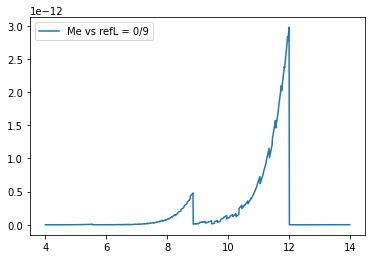

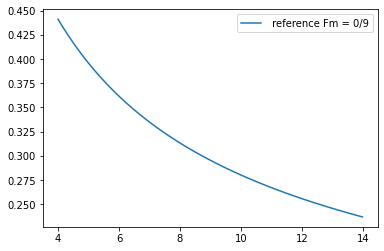

#################################################
11 9 0 Me vs ref 2.9801716650013077e-12 # 
11 9 0 Me vs Seg 0.0 
#################################################
Error at  11 9 0  is  1.2346273532943397e-16


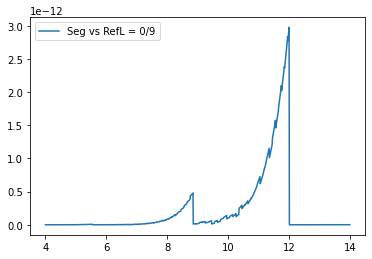

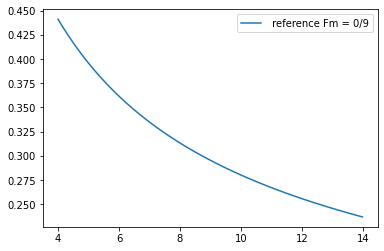

#################################################
11 9 0 Seg vs Ref 2.9801716650013077e-12 # 

11 9 1 Me vs ref 1.2409691330095285e-13 
11 9 1 Me vs Seg 0.0 
11 9 1 Seg vs Ref 1.2409691330095285e-13 

11 9 2 Me vs ref 1.5557650653863497e-14 
11 9 2 Me vs Seg 0.0 
11 9 2 Seg vs Ref 1.5557650653863497e-14 

11 9 3 Me vs ref 3.18890963982299e-15 
11 9 3 Me vs Seg 0.0 
11 9 3 Seg vs Ref 3.18890963982299e-15 

11 9 4 Me vs ref 9.561307908606542e-16 
11 9 4 Me vs Seg 0.0 
11 9 4 Seg vs Ref 9.561307908606542e-16 

11 9 5 Me vs ref 3.369192132316595e-16 
11 9 5 Me vs Seg 0.0 
11 9 5 Seg vs Ref 3.369192132316595e-16 

11 9 6 Me vs ref 1.9072810279914532e-16 
11 9 6 Me vs Seg 0.0 
11 9 6 Seg vs Ref 1.9072810279914532e-16 

11 9 7 Me vs ref 1.127231446206023e-16 
11 9 7 Me vs Seg 0.0 
11 9 7 Seg vs Ref 1.127231446206023e-16 

11 9 8 Me vs ref 2.041755978697546e-16 
11 9 8 Me vs Seg 0.0 
11 9 8 Seg vs Ref 2.041755978697546e-16 

11 9 9 Me vs ref 1.1075125191939428e-16 
11 9 9 Me vs Seg 0.0 
11 9 9

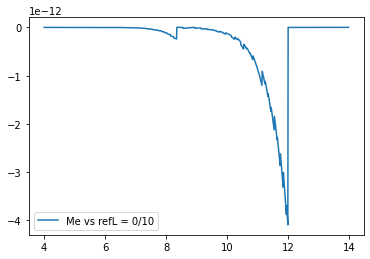

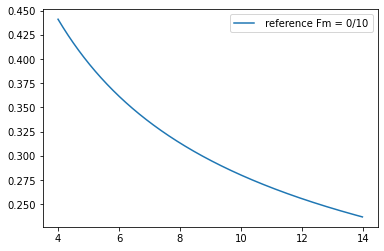

#################################################
11 10 0 Me vs ref 4.092226557617096e-12 # 
11 10 0 Me vs Seg 0.0 
#################################################
Error at  11 10 0  is  1.2346273532943397e-16


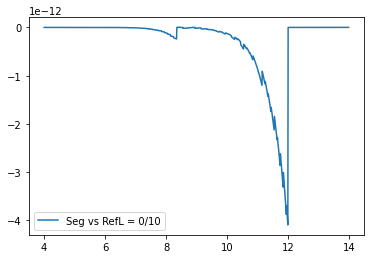

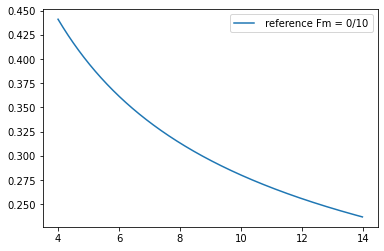

#################################################
11 10 0 Seg vs Ref 4.092226557617096e-12 # 

11 10 1 Me vs ref 1.7063433999098265e-13 
11 10 1 Me vs Seg 0.0 
11 10 1 Seg vs Ref 1.7063433999098265e-13 

11 10 2 Me vs ref 2.1289610699359862e-14 
11 10 2 Me vs Seg 0.0 
11 10 2 Seg vs Ref 2.1289610699359862e-14 

11 10 3 Me vs ref 4.48886804463311e-15 
11 10 3 Me vs Seg 0.0 
11 10 3 Seg vs Ref 4.48886804463311e-15 

11 10 4 Me vs ref 1.2835869520055887e-15 
11 10 4 Me vs Seg 0.0 
11 10 4 Seg vs Ref 1.2835869520055887e-15 

11 10 5 Me vs ref 5.031104656147423e-16 
11 10 5 Me vs Seg 0.0 
11 10 5 Seg vs Ref 5.031104656147423e-16 

11 10 6 Me vs ref 1.9510048687287201e-16 
11 10 6 Me vs Seg 0.0 
11 10 6 Seg vs Ref 1.9510048687287201e-16 

11 10 7 Me vs ref 2.1514128640490876e-16 
11 10 7 Me vs Seg 0.0 
11 10 7 Seg vs Ref 2.1514128640490876e-16 

11 10 8 Me vs ref 1.0728095793449341e-16 
11 10 8 Me vs Seg 0.0 
11 10 8 Seg vs Ref 1.0728095793449341e-16 

11 10 9 Me vs ref 1.4288429380643342e-1

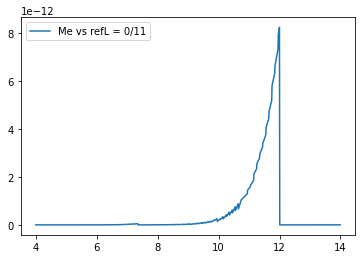

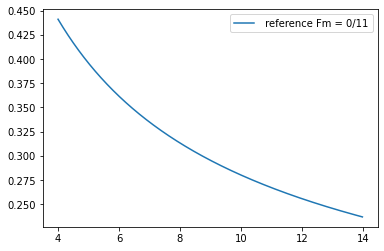

#################################################
11 11 0 Me vs ref 8.238909554592055e-12 # 
11 11 0 Me vs Seg 0.0 
#################################################
Error at  11 11 0  is  1.2346273532943397e-16


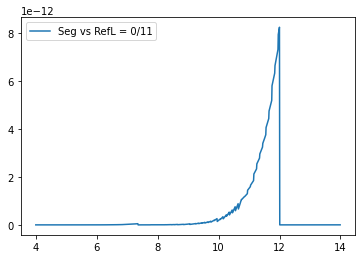

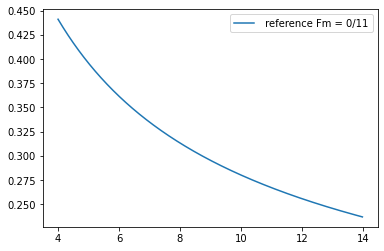

#################################################
11 11 0 Seg vs Ref 8.238909554592055e-12 # 

11 11 1 Me vs ref 3.4324799946805484e-13 
11 11 1 Me vs Seg 0.0 
11 11 1 Seg vs Ref 3.4324799946805484e-13 

11 11 2 Me vs ref 4.2956090073875686e-14 
11 11 2 Me vs Seg 0.0 
11 11 2 Seg vs Ref 4.2956090073875686e-14 

11 11 3 Me vs ref 8.897830389154038e-15 
11 11 3 Me vs Seg 0.0 
11 11 3 Seg vs Ref 8.897830389154038e-15 

11 11 4 Me vs ref 2.621492432852701e-15 
11 11 4 Me vs Seg 0.0 
11 11 4 Seg vs Ref 2.621492432852701e-15 

11 11 5 Me vs ref 9.615348610641367e-16 
11 11 5 Me vs Seg 0.0 
11 11 5 Seg vs Ref 9.615348610641367e-16 

11 11 6 Me vs ref 4.771573761108705e-16 
11 11 6 Me vs Seg 0.0 
11 11 6 Seg vs Ref 4.771573761108705e-16 

11 11 7 Me vs ref 2.3406146134772807e-16 
11 11 7 Me vs Seg 0.0 
11 11 7 Seg vs Ref 2.3406146134772807e-16 

11 11 8 Me vs ref 2.0680394110508468e-16 
11 11 8 Me vs Seg 0.0 
11 11 8 Seg vs Ref 2.0680394110508468e-16 

11 11 9 Me vs ref 1.0428352009239725e-16 

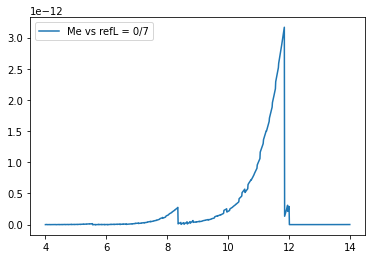

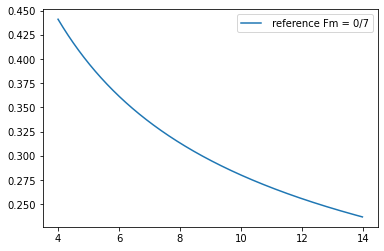

#################################################
12 7 0 Me vs ref 3.165356865508784e-12 # 
12 7 0 Me vs Seg 0.0 
#################################################
Error at  12 7 0  is  1.2346273532943397e-16


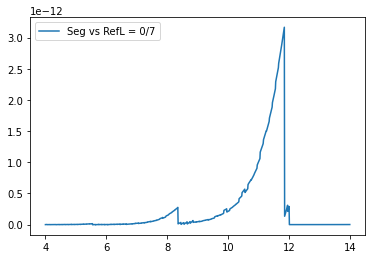

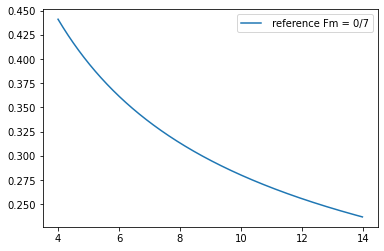

#################################################
12 7 0 Seg vs Ref 3.165356865508784e-12 # 

12 7 1 Me vs ref 1.3357544237369012e-13 
12 7 1 Me vs Seg 0.0 
12 7 1 Seg vs Ref 1.3357544237369012e-13 

12 7 2 Me vs ref 1.6952802009417844e-14 
12 7 2 Me vs Seg 0.0 
12 7 2 Seg vs Ref 1.6952802009417844e-14 

12 7 3 Me vs ref 3.5335233003475075e-15 
12 7 3 Me vs Seg 0.0 
12 7 3 Seg vs Ref 3.5335233003475075e-15 

12 7 4 Me vs ref 1.0686709763646496e-15 
12 7 4 Me vs Seg 0.0 
12 7 4 Seg vs Ref 1.0686709763646496e-15 

12 7 5 Me vs ref 3.885441773009146e-16 
12 7 5 Me vs Seg 0.0 
12 7 5 Seg vs Ref 3.885441773009146e-16 

12 7 6 Me vs ref 2.124528038303236e-16 
12 7 6 Me vs Seg 0.0 
12 7 6 Seg vs Ref 2.124528038303236e-16 

12 7 7 Me vs ref 1.2240642527361345e-16 
12 7 7 Me vs Seg 0.0 
12 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  12 8 0  is  1.2346273532943397e-16


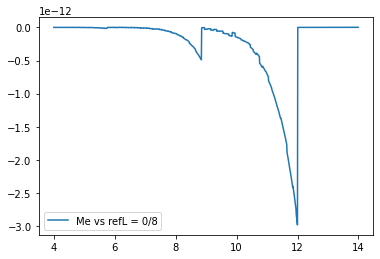

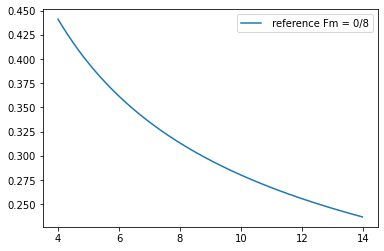

#################################################
12 8 0 Me vs ref 2.9816149549333204e-12 # 
12 8 0 Me vs Seg 0.0 
#################################################
Error at  12 8 0  is  1.2346273532943397e-16


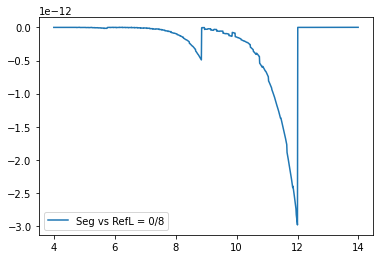

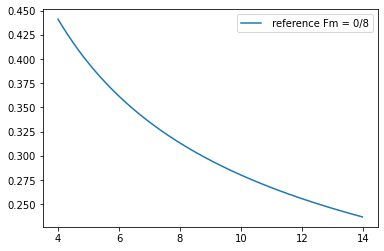

#################################################
12 8 0 Seg vs Ref 2.9816149549333204e-12 # 

12 8 1 Me vs ref 1.2435018292844546e-13 
12 8 1 Me vs Seg 0.0 
12 8 1 Seg vs Ref 1.2435018292844546e-13 

12 8 2 Me vs ref 1.5503223704804725e-14 
12 8 2 Me vs Seg 0.0 
12 8 2 Seg vs Ref 1.5503223704804725e-14 

12 8 3 Me vs ref 3.2831810187206045e-15 
12 8 3 Me vs Seg 0.0 
12 8 3 Seg vs Ref 3.2831810187206045e-15 

12 8 4 Me vs ref 9.31871767251291e-16 
12 8 4 Me vs Seg 0.0 
12 8 4 Seg vs Ref 9.31871767251291e-16 

12 8 5 Me vs ref 3.7119694254114655e-16 
12 8 5 Me vs Seg 0.0 
12 8 5 Seg vs Ref 3.7119694254114655e-16 

12 8 6 Me vs ref 1.4072944198861848e-16 
12 8 6 Me vs Seg 0.0 
12 8 6 Seg vs Ref 1.4072944198861848e-16 

12 8 7 Me vs ref 1.8633877806647353e-16 
12 8 7 Me vs Seg 0.0 
12 8 7 Seg vs Ref 1.8633877806647353e-16 

12 8 8 Me vs ref 1.0728095793449341e-16 
12 8 8 Me vs Seg 0.0 
12 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

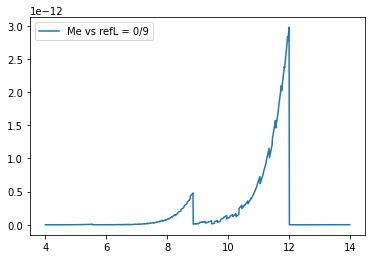

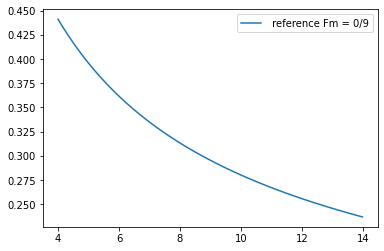

#################################################
12 9 0 Me vs ref 2.9801716650013077e-12 # 
12 9 0 Me vs Seg 0.0 
#################################################
Error at  12 9 0  is  1.2346273532943397e-16


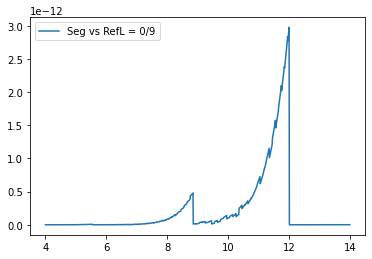

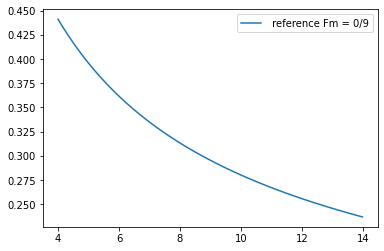

#################################################
12 9 0 Seg vs Ref 2.9801716650013077e-12 # 

12 9 1 Me vs ref 1.2409691330095285e-13 
12 9 1 Me vs Seg 0.0 
12 9 1 Seg vs Ref 1.2409691330095285e-13 

12 9 2 Me vs ref 1.5557650653863497e-14 
12 9 2 Me vs Seg 0.0 
12 9 2 Seg vs Ref 1.5557650653863497e-14 

12 9 3 Me vs ref 3.18890963982299e-15 
12 9 3 Me vs Seg 0.0 
12 9 3 Seg vs Ref 3.18890963982299e-15 

12 9 4 Me vs ref 9.561307908606542e-16 
12 9 4 Me vs Seg 0.0 
12 9 4 Seg vs Ref 9.561307908606542e-16 

12 9 5 Me vs ref 3.369192132316595e-16 
12 9 5 Me vs Seg 0.0 
12 9 5 Seg vs Ref 3.369192132316595e-16 

12 9 6 Me vs ref 1.9072810279914532e-16 
12 9 6 Me vs Seg 0.0 
12 9 6 Seg vs Ref 1.9072810279914532e-16 

12 9 7 Me vs ref 1.127231446206023e-16 
12 9 7 Me vs Seg 0.0 
12 9 7 Seg vs Ref 1.127231446206023e-16 

12 9 8 Me vs ref 2.041755978697546e-16 
12 9 8 Me vs Seg 0.0 
12 9 8 Seg vs Ref 2.041755978697546e-16 

12 9 9 Me vs ref 1.1075125191939428e-16 
12 9 9 Me vs Seg 0.0 
12 9 9

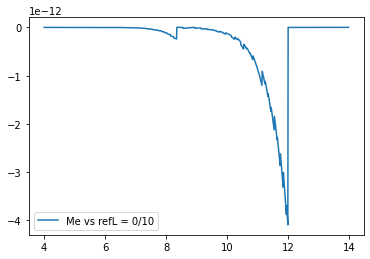

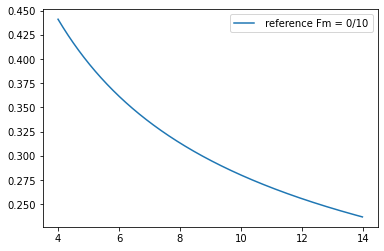

#################################################
12 10 0 Me vs ref 4.092226557617096e-12 # 
12 10 0 Me vs Seg 0.0 
#################################################
Error at  12 10 0  is  1.2346273532943397e-16


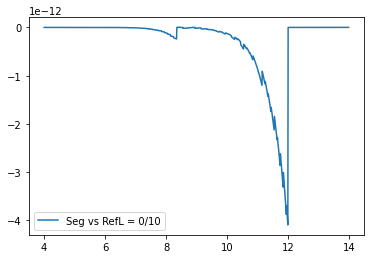

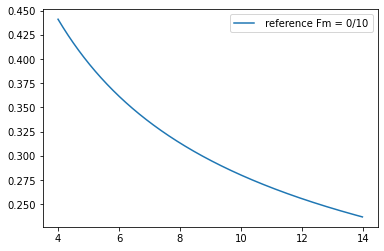

#################################################
12 10 0 Seg vs Ref 4.092226557617096e-12 # 

12 10 1 Me vs ref 1.7063433999098265e-13 
12 10 1 Me vs Seg 0.0 
12 10 1 Seg vs Ref 1.7063433999098265e-13 

12 10 2 Me vs ref 2.1289610699359862e-14 
12 10 2 Me vs Seg 0.0 
12 10 2 Seg vs Ref 2.1289610699359862e-14 

12 10 3 Me vs ref 4.48886804463311e-15 
12 10 3 Me vs Seg 0.0 
12 10 3 Seg vs Ref 4.48886804463311e-15 

12 10 4 Me vs ref 1.2835869520055887e-15 
12 10 4 Me vs Seg 0.0 
12 10 4 Seg vs Ref 1.2835869520055887e-15 

12 10 5 Me vs ref 5.031104656147423e-16 
12 10 5 Me vs Seg 0.0 
12 10 5 Seg vs Ref 5.031104656147423e-16 

12 10 6 Me vs ref 1.9510048687287201e-16 
12 10 6 Me vs Seg 0.0 
12 10 6 Seg vs Ref 1.9510048687287201e-16 

12 10 7 Me vs ref 2.1514128640490876e-16 
12 10 7 Me vs Seg 0.0 
12 10 7 Seg vs Ref 2.1514128640490876e-16 

12 10 8 Me vs ref 1.0728095793449341e-16 
12 10 8 Me vs Seg 0.0 
12 10 8 Seg vs Ref 1.0728095793449341e-16 

12 10 9 Me vs ref 1.4288429380643342e-1

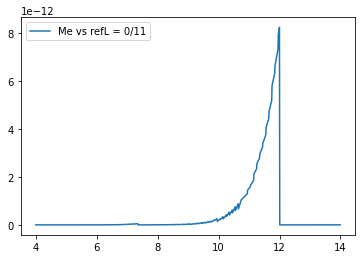

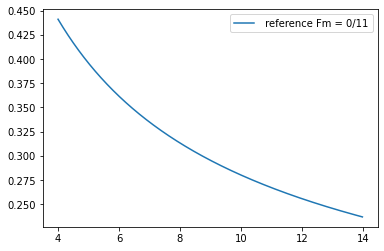

#################################################
12 11 0 Me vs ref 8.238909554592055e-12 # 
12 11 0 Me vs Seg 0.0 
#################################################
Error at  12 11 0  is  1.2346273532943397e-16


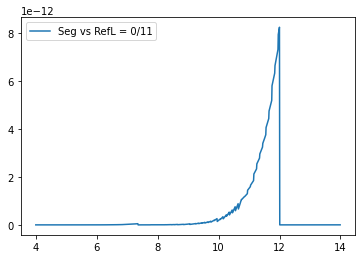

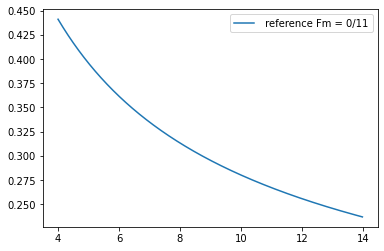

#################################################
12 11 0 Seg vs Ref 8.238909554592055e-12 # 

12 11 1 Me vs ref 3.4324799946805484e-13 
12 11 1 Me vs Seg 0.0 
12 11 1 Seg vs Ref 3.4324799946805484e-13 

12 11 2 Me vs ref 4.2956090073875686e-14 
12 11 2 Me vs Seg 0.0 
12 11 2 Seg vs Ref 4.2956090073875686e-14 

12 11 3 Me vs ref 8.897830389154038e-15 
12 11 3 Me vs Seg 0.0 
12 11 3 Seg vs Ref 8.897830389154038e-15 

12 11 4 Me vs ref 2.621492432852701e-15 
12 11 4 Me vs Seg 0.0 
12 11 4 Seg vs Ref 2.621492432852701e-15 

12 11 5 Me vs ref 9.615348610641367e-16 
12 11 5 Me vs Seg 0.0 
12 11 5 Seg vs Ref 9.615348610641367e-16 

12 11 6 Me vs ref 4.771573761108705e-16 
12 11 6 Me vs Seg 0.0 
12 11 6 Seg vs Ref 4.771573761108705e-16 

12 11 7 Me vs ref 2.3406146134772807e-16 
12 11 7 Me vs Seg 0.0 
12 11 7 Seg vs Ref 2.3406146134772807e-16 

12 11 8 Me vs ref 2.0680394110508468e-16 
12 11 8 Me vs Seg 0.0 
12 11 8 Seg vs Ref 2.0680394110508468e-16 

12 11 9 Me vs ref 1.0428352009239725e-16 

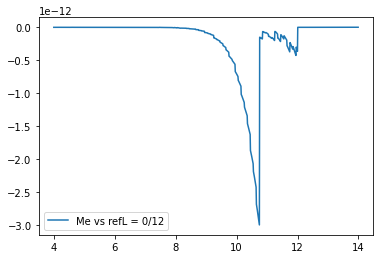

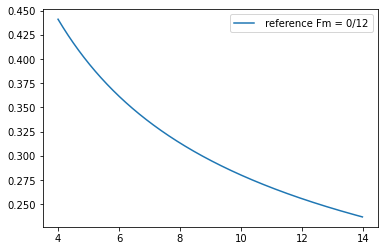

#################################################
12 12 0 Me vs ref 3.0024871477962733e-12 # 
12 12 0 Me vs Seg 0.0 
#################################################
Error at  12 12 0  is  1.2346273532943397e-16


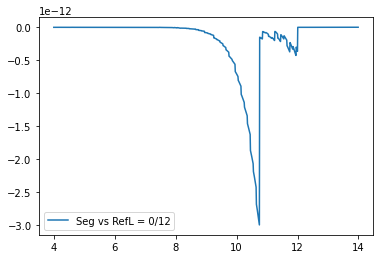

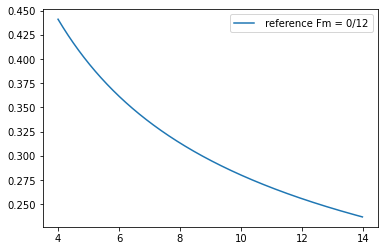

#################################################
12 12 0 Seg vs Ref 3.0024871477962733e-12 # 

12 12 1 Me vs ref 1.3968340373260446e-13 
12 12 1 Me vs Seg 0.0 
12 12 1 Seg vs Ref 1.3968340373260446e-13 

12 12 2 Me vs ref 1.943345658006468e-14 
12 12 2 Me vs Seg 0.0 
12 12 2 Seg vs Ref 1.943345658006468e-14 

12 12 3 Me vs ref 4.642120021713936e-15 
12 12 3 Me vs Seg 0.0 
12 12 3 Seg vs Ref 4.642120021713936e-15 

12 12 4 Me vs ref 1.421117997585375e-15 
12 12 4 Me vs Seg 0.0 
12 12 4 Seg vs Ref 1.421117997585375e-15 

12 12 5 Me vs ref 6.816311295780586e-16 
12 12 5 Me vs Seg 0.0 
12 12 5 Seg vs Ref 6.816311295780586e-16 

12 12 6 Me vs ref 3.0536893001233134e-16 
12 12 6 Me vs Seg 0.0 
12 12 6 Seg vs Ref 3.0536893001233134e-16 

12 12 7 Me vs ref 2.3753006126673443e-16 
12 12 7 Me vs Seg 0.0 
12 12 7 Seg vs Ref 2.3753006126673443e-16 

12 12 8 Me vs ref 1.1363455207184792e-16 
12 12 8 Me vs Seg 0.0 
12 12 8 Seg vs Ref 1.1363455207184792e-16 

12 12 9 Me vs ref 1.2217603231196028e-16

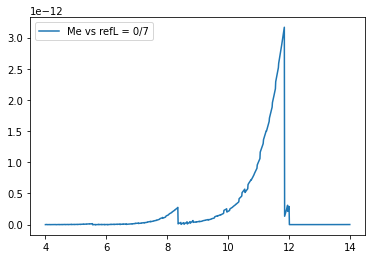

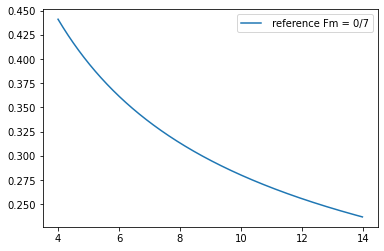

#################################################
13 7 0 Me vs ref 3.165356865508784e-12 # 
13 7 0 Me vs Seg 0.0 
#################################################
Error at  13 7 0  is  1.2346273532943397e-16


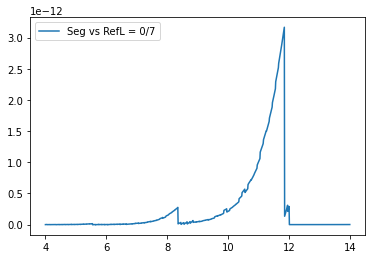

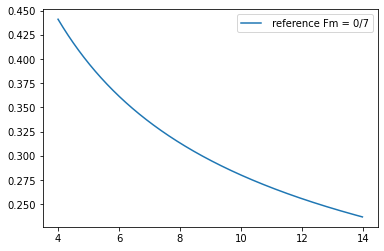

#################################################
13 7 0 Seg vs Ref 3.165356865508784e-12 # 

13 7 1 Me vs ref 1.3357544237369012e-13 
13 7 1 Me vs Seg 0.0 
13 7 1 Seg vs Ref 1.3357544237369012e-13 

13 7 2 Me vs ref 1.6952802009417844e-14 
13 7 2 Me vs Seg 0.0 
13 7 2 Seg vs Ref 1.6952802009417844e-14 

13 7 3 Me vs ref 3.5335233003475075e-15 
13 7 3 Me vs Seg 0.0 
13 7 3 Seg vs Ref 3.5335233003475075e-15 

13 7 4 Me vs ref 1.0686709763646496e-15 
13 7 4 Me vs Seg 0.0 
13 7 4 Seg vs Ref 1.0686709763646496e-15 

13 7 5 Me vs ref 3.885441773009146e-16 
13 7 5 Me vs Seg 0.0 
13 7 5 Seg vs Ref 3.885441773009146e-16 

13 7 6 Me vs ref 2.124528038303236e-16 
13 7 6 Me vs Seg 0.0 
13 7 6 Seg vs Ref 2.124528038303236e-16 

13 7 7 Me vs ref 1.2240642527361345e-16 
13 7 7 Me vs Seg 0.0 
13 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  13 8 0  is  1.2346273532943397e-16


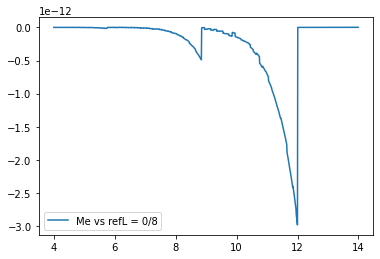

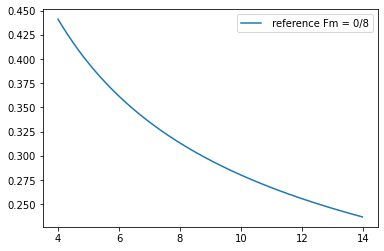

#################################################
13 8 0 Me vs ref 2.9816149549333204e-12 # 
13 8 0 Me vs Seg 0.0 
#################################################
Error at  13 8 0  is  1.2346273532943397e-16


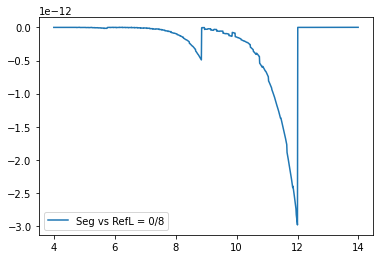

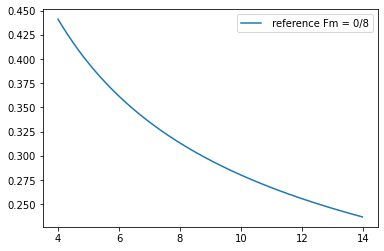

#################################################
13 8 0 Seg vs Ref 2.9816149549333204e-12 # 

13 8 1 Me vs ref 1.2435018292844546e-13 
13 8 1 Me vs Seg 0.0 
13 8 1 Seg vs Ref 1.2435018292844546e-13 

13 8 2 Me vs ref 1.5503223704804725e-14 
13 8 2 Me vs Seg 0.0 
13 8 2 Seg vs Ref 1.5503223704804725e-14 

13 8 3 Me vs ref 3.2831810187206045e-15 
13 8 3 Me vs Seg 0.0 
13 8 3 Seg vs Ref 3.2831810187206045e-15 

13 8 4 Me vs ref 9.31871767251291e-16 
13 8 4 Me vs Seg 0.0 
13 8 4 Seg vs Ref 9.31871767251291e-16 

13 8 5 Me vs ref 3.7119694254114655e-16 
13 8 5 Me vs Seg 0.0 
13 8 5 Seg vs Ref 3.7119694254114655e-16 

13 8 6 Me vs ref 1.4072944198861848e-16 
13 8 6 Me vs Seg 0.0 
13 8 6 Seg vs Ref 1.4072944198861848e-16 

13 8 7 Me vs ref 1.8633877806647353e-16 
13 8 7 Me vs Seg 0.0 
13 8 7 Seg vs Ref 1.8633877806647353e-16 

13 8 8 Me vs ref 1.0728095793449341e-16 
13 8 8 Me vs Seg 0.0 
13 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

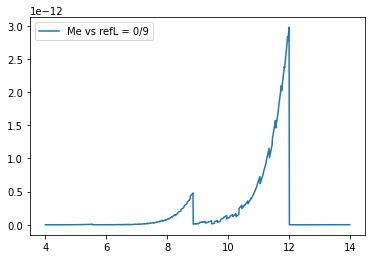

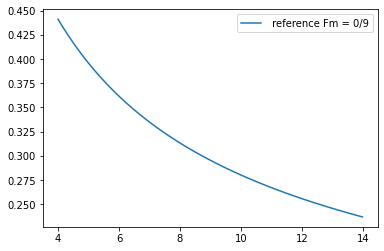

#################################################
13 9 0 Me vs ref 2.9801716650013077e-12 # 
13 9 0 Me vs Seg 0.0 
#################################################
Error at  13 9 0  is  1.2346273532943397e-16


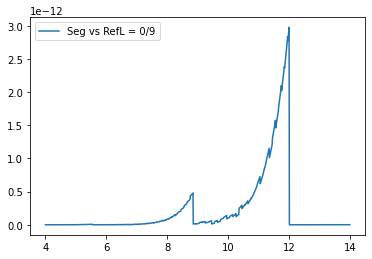

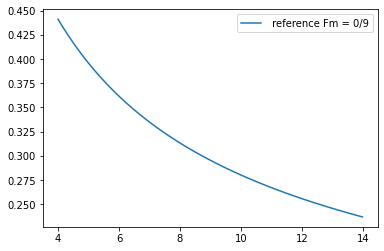

#################################################
13 9 0 Seg vs Ref 2.9801716650013077e-12 # 

13 9 1 Me vs ref 1.2409691330095285e-13 
13 9 1 Me vs Seg 0.0 
13 9 1 Seg vs Ref 1.2409691330095285e-13 

13 9 2 Me vs ref 1.5557650653863497e-14 
13 9 2 Me vs Seg 0.0 
13 9 2 Seg vs Ref 1.5557650653863497e-14 

13 9 3 Me vs ref 3.18890963982299e-15 
13 9 3 Me vs Seg 0.0 
13 9 3 Seg vs Ref 3.18890963982299e-15 

13 9 4 Me vs ref 9.561307908606542e-16 
13 9 4 Me vs Seg 0.0 
13 9 4 Seg vs Ref 9.561307908606542e-16 

13 9 5 Me vs ref 3.369192132316595e-16 
13 9 5 Me vs Seg 0.0 
13 9 5 Seg vs Ref 3.369192132316595e-16 

13 9 6 Me vs ref 1.9072810279914532e-16 
13 9 6 Me vs Seg 0.0 
13 9 6 Seg vs Ref 1.9072810279914532e-16 

13 9 7 Me vs ref 1.127231446206023e-16 
13 9 7 Me vs Seg 0.0 
13 9 7 Seg vs Ref 1.127231446206023e-16 

13 9 8 Me vs ref 2.041755978697546e-16 
13 9 8 Me vs Seg 0.0 
13 9 8 Seg vs Ref 2.041755978697546e-16 

13 9 9 Me vs ref 1.1075125191939428e-16 
13 9 9 Me vs Seg 0.0 
13 9 9

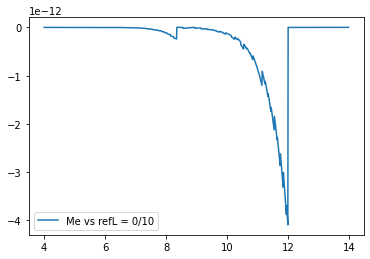

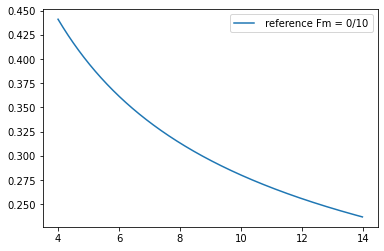

#################################################
13 10 0 Me vs ref 4.092226557617096e-12 # 
13 10 0 Me vs Seg 0.0 
#################################################
Error at  13 10 0  is  1.2346273532943397e-16


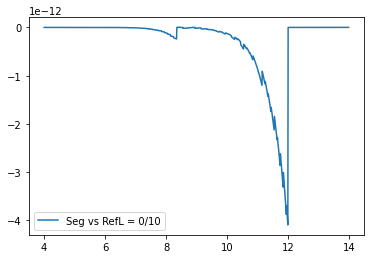

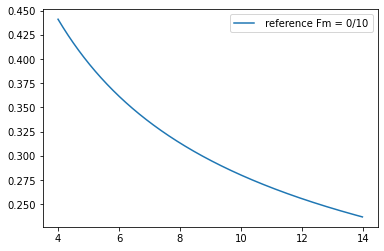

#################################################
13 10 0 Seg vs Ref 4.092226557617096e-12 # 

13 10 1 Me vs ref 1.7063433999098265e-13 
13 10 1 Me vs Seg 0.0 
13 10 1 Seg vs Ref 1.7063433999098265e-13 

13 10 2 Me vs ref 2.1289610699359862e-14 
13 10 2 Me vs Seg 0.0 
13 10 2 Seg vs Ref 2.1289610699359862e-14 

13 10 3 Me vs ref 4.48886804463311e-15 
13 10 3 Me vs Seg 0.0 
13 10 3 Seg vs Ref 4.48886804463311e-15 

13 10 4 Me vs ref 1.2835869520055887e-15 
13 10 4 Me vs Seg 0.0 
13 10 4 Seg vs Ref 1.2835869520055887e-15 

13 10 5 Me vs ref 5.031104656147423e-16 
13 10 5 Me vs Seg 0.0 
13 10 5 Seg vs Ref 5.031104656147423e-16 

13 10 6 Me vs ref 1.9510048687287201e-16 
13 10 6 Me vs Seg 0.0 
13 10 6 Seg vs Ref 1.9510048687287201e-16 

13 10 7 Me vs ref 2.1514128640490876e-16 
13 10 7 Me vs Seg 0.0 
13 10 7 Seg vs Ref 2.1514128640490876e-16 

13 10 8 Me vs ref 1.0728095793449341e-16 
13 10 8 Me vs Seg 0.0 
13 10 8 Seg vs Ref 1.0728095793449341e-16 

13 10 9 Me vs ref 1.4288429380643342e-1

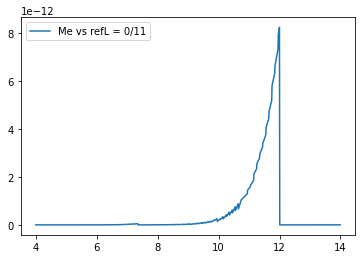

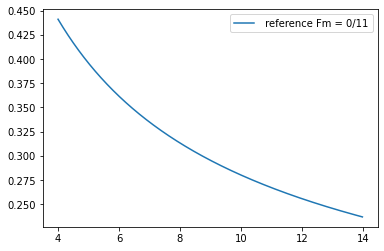

#################################################
13 11 0 Me vs ref 8.238909554592055e-12 # 
13 11 0 Me vs Seg 0.0 
#################################################
Error at  13 11 0  is  1.2346273532943397e-16


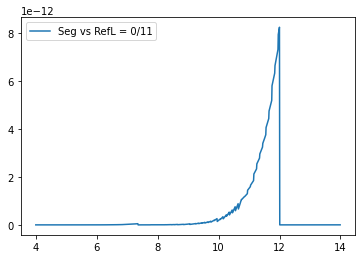

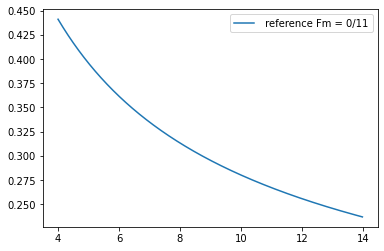

#################################################
13 11 0 Seg vs Ref 8.238909554592055e-12 # 

13 11 1 Me vs ref 3.4324799946805484e-13 
13 11 1 Me vs Seg 0.0 
13 11 1 Seg vs Ref 3.4324799946805484e-13 

13 11 2 Me vs ref 4.2956090073875686e-14 
13 11 2 Me vs Seg 0.0 
13 11 2 Seg vs Ref 4.2956090073875686e-14 

13 11 3 Me vs ref 8.897830389154038e-15 
13 11 3 Me vs Seg 0.0 
13 11 3 Seg vs Ref 8.897830389154038e-15 

13 11 4 Me vs ref 2.621492432852701e-15 
13 11 4 Me vs Seg 0.0 
13 11 4 Seg vs Ref 2.621492432852701e-15 

13 11 5 Me vs ref 9.615348610641367e-16 
13 11 5 Me vs Seg 0.0 
13 11 5 Seg vs Ref 9.615348610641367e-16 

13 11 6 Me vs ref 4.771573761108705e-16 
13 11 6 Me vs Seg 0.0 
13 11 6 Seg vs Ref 4.771573761108705e-16 

13 11 7 Me vs ref 2.3406146134772807e-16 
13 11 7 Me vs Seg 0.0 
13 11 7 Seg vs Ref 2.3406146134772807e-16 

13 11 8 Me vs ref 2.0680394110508468e-16 
13 11 8 Me vs Seg 0.0 
13 11 8 Seg vs Ref 2.0680394110508468e-16 

13 11 9 Me vs ref 1.0428352009239725e-16 

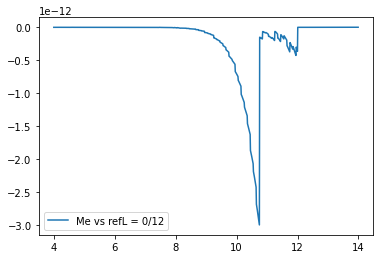

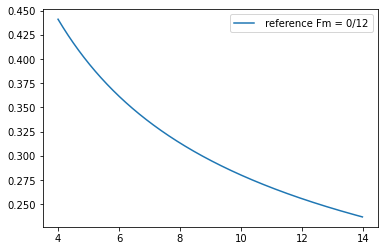

#################################################
13 12 0 Me vs ref 3.0024871477962733e-12 # 
13 12 0 Me vs Seg 0.0 
#################################################
Error at  13 12 0  is  1.2346273532943397e-16


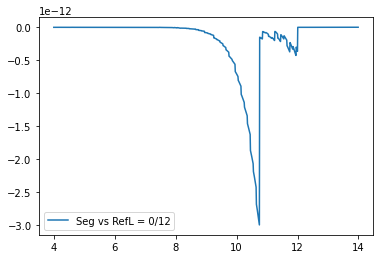

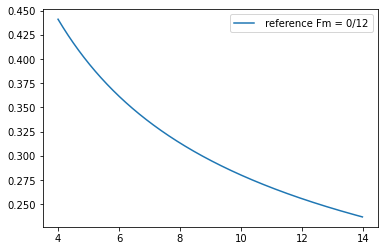

#################################################
13 12 0 Seg vs Ref 3.0024871477962733e-12 # 

13 12 1 Me vs ref 1.3968340373260446e-13 
13 12 1 Me vs Seg 0.0 
13 12 1 Seg vs Ref 1.3968340373260446e-13 

13 12 2 Me vs ref 1.943345658006468e-14 
13 12 2 Me vs Seg 0.0 
13 12 2 Seg vs Ref 1.943345658006468e-14 

13 12 3 Me vs ref 4.642120021713936e-15 
13 12 3 Me vs Seg 0.0 
13 12 3 Seg vs Ref 4.642120021713936e-15 

13 12 4 Me vs ref 1.421117997585375e-15 
13 12 4 Me vs Seg 0.0 
13 12 4 Seg vs Ref 1.421117997585375e-15 

13 12 5 Me vs ref 6.816311295780586e-16 
13 12 5 Me vs Seg 0.0 
13 12 5 Seg vs Ref 6.816311295780586e-16 

13 12 6 Me vs ref 3.0536893001233134e-16 
13 12 6 Me vs Seg 0.0 
13 12 6 Seg vs Ref 3.0536893001233134e-16 

13 12 7 Me vs ref 2.3753006126673443e-16 
13 12 7 Me vs Seg 0.0 
13 12 7 Seg vs Ref 2.3753006126673443e-16 

13 12 8 Me vs ref 1.1363455207184792e-16 
13 12 8 Me vs Seg 0.0 
13 12 8 Seg vs Ref 1.1363455207184792e-16 

13 12 9 Me vs ref 1.2217603231196028e-16

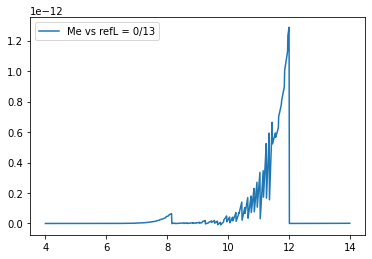

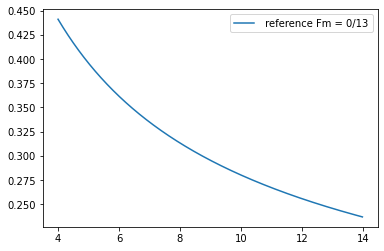

#################################################
13 13 0 Me vs ref 1.2879142197164128e-12 # 
13 13 0 Me vs Seg 0.0 
#################################################
Error at  13 13 0  is  1.2346273532943397e-16


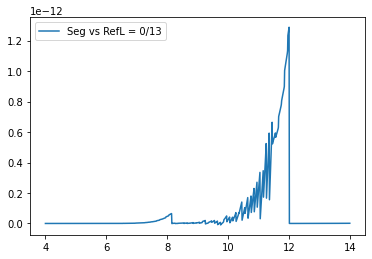

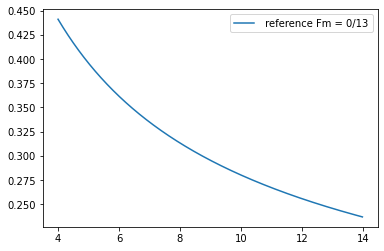

#################################################
13 13 0 Seg vs Ref 1.2879142197164128e-12 # 

13 13 1 Me vs ref 5.357519983206771e-14 
13 13 1 Me vs Seg 0.0 
13 13 1 Seg vs Ref 5.357519983206771e-14 

13 13 2 Me vs ref 6.740918587211375e-15 
13 13 2 Me vs Seg 0.0 
13 13 2 Seg vs Ref 6.740918587211375e-15 

13 13 3 Me vs ref 1.351783268654927e-15 
13 13 3 Me vs Seg 0.0 
13 13 3 Seg vs Ref 1.351783268654927e-15 

13 13 4 Me vs ref 4.224593765089768e-16 
13 13 4 Me vs Seg 0.0 
13 13 4 Seg vs Ref 4.224593765089768e-16 

13 13 5 Me vs ref 1.3723627811414174e-16 
13 13 5 Me vs Seg 0.0 
13 13 5 Seg vs Ref 1.3723627811414174e-16 

13 13 6 Me vs ref 1.1897763590312804e-16 
13 13 6 Me vs Seg 0.0 
13 13 6 Seg vs Ref 1.1897763590312804e-16 

13 13 7 Me vs ref 1.0560129160008813e-16 
13 13 7 Me vs Seg 0.0 
13 13 7 Seg vs Ref 1.0560129160008813e-16 

13 13 8 Me vs ref 1.0728095793449341e-16 
13 13 8 Me vs Seg 0.0 
13 13 8 Seg vs Ref 1.0728095793449341e-16 

13 13 9 Me vs ref 1.0428352009239725e-16

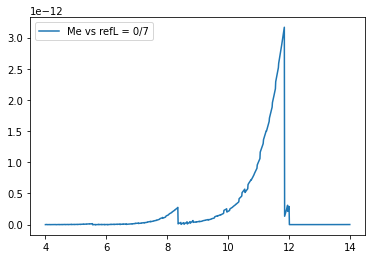

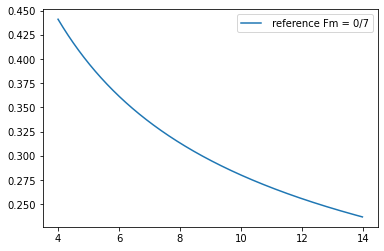

#################################################
14 7 0 Me vs ref 3.165356865508784e-12 # 
14 7 0 Me vs Seg 0.0 
#################################################
Error at  14 7 0  is  1.2346273532943397e-16


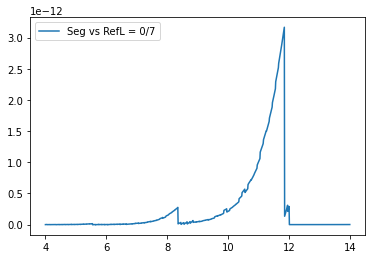

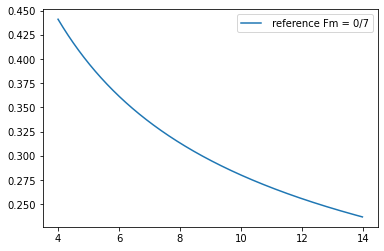

#################################################
14 7 0 Seg vs Ref 3.165356865508784e-12 # 

14 7 1 Me vs ref 1.3357544237369012e-13 
14 7 1 Me vs Seg 0.0 
14 7 1 Seg vs Ref 1.3357544237369012e-13 

14 7 2 Me vs ref 1.6952802009417844e-14 
14 7 2 Me vs Seg 0.0 
14 7 2 Seg vs Ref 1.6952802009417844e-14 

14 7 3 Me vs ref 3.5335233003475075e-15 
14 7 3 Me vs Seg 0.0 
14 7 3 Seg vs Ref 3.5335233003475075e-15 

14 7 4 Me vs ref 1.0686709763646496e-15 
14 7 4 Me vs Seg 0.0 
14 7 4 Seg vs Ref 1.0686709763646496e-15 

14 7 5 Me vs ref 3.885441773009146e-16 
14 7 5 Me vs Seg 0.0 
14 7 5 Seg vs Ref 3.885441773009146e-16 

14 7 6 Me vs ref 2.124528038303236e-16 
14 7 6 Me vs Seg 0.0 
14 7 6 Seg vs Ref 2.124528038303236e-16 

14 7 7 Me vs ref 1.2240642527361345e-16 
14 7 7 Me vs Seg 0.0 
14 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  14 8 0  is  1.2346273532943397e-16


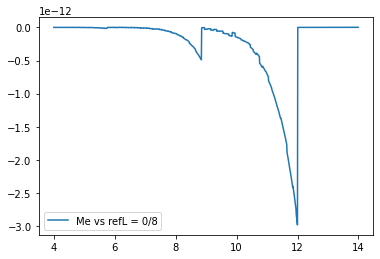

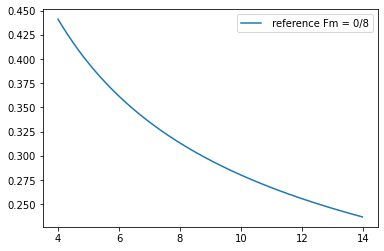

#################################################
14 8 0 Me vs ref 2.9816149549333204e-12 # 
14 8 0 Me vs Seg 0.0 
#################################################
Error at  14 8 0  is  1.2346273532943397e-16


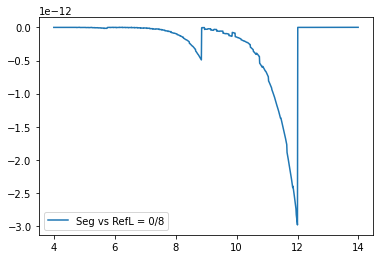

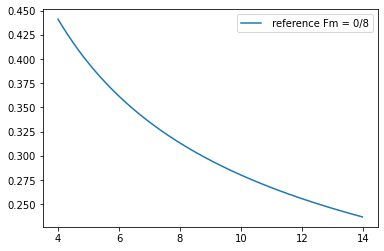

#################################################
14 8 0 Seg vs Ref 2.9816149549333204e-12 # 

14 8 1 Me vs ref 1.2435018292844546e-13 
14 8 1 Me vs Seg 0.0 
14 8 1 Seg vs Ref 1.2435018292844546e-13 

14 8 2 Me vs ref 1.5503223704804725e-14 
14 8 2 Me vs Seg 0.0 
14 8 2 Seg vs Ref 1.5503223704804725e-14 

14 8 3 Me vs ref 3.2831810187206045e-15 
14 8 3 Me vs Seg 0.0 
14 8 3 Seg vs Ref 3.2831810187206045e-15 

14 8 4 Me vs ref 9.31871767251291e-16 
14 8 4 Me vs Seg 0.0 
14 8 4 Seg vs Ref 9.31871767251291e-16 

14 8 5 Me vs ref 3.7119694254114655e-16 
14 8 5 Me vs Seg 0.0 
14 8 5 Seg vs Ref 3.7119694254114655e-16 

14 8 6 Me vs ref 1.4072944198861848e-16 
14 8 6 Me vs Seg 0.0 
14 8 6 Seg vs Ref 1.4072944198861848e-16 

14 8 7 Me vs ref 1.8633877806647353e-16 
14 8 7 Me vs Seg 0.0 
14 8 7 Seg vs Ref 1.8633877806647353e-16 

14 8 8 Me vs ref 1.0728095793449341e-16 
14 8 8 Me vs Seg 0.0 
14 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

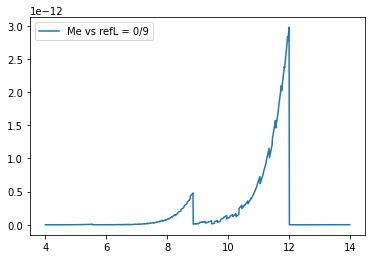

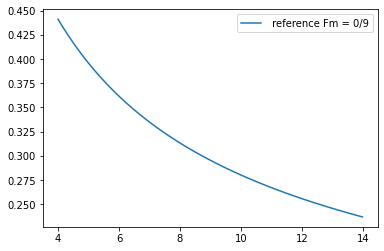

#################################################
14 9 0 Me vs ref 2.9801716650013077e-12 # 
14 9 0 Me vs Seg 0.0 
#################################################
Error at  14 9 0  is  1.2346273532943397e-16


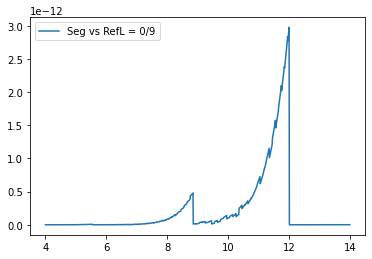

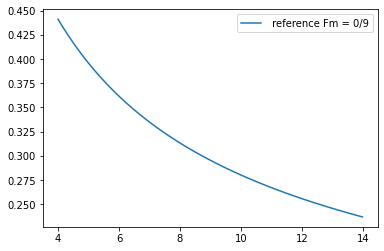

#################################################
14 9 0 Seg vs Ref 2.9801716650013077e-12 # 

14 9 1 Me vs ref 1.2409691330095285e-13 
14 9 1 Me vs Seg 0.0 
14 9 1 Seg vs Ref 1.2409691330095285e-13 

14 9 2 Me vs ref 1.5557650653863497e-14 
14 9 2 Me vs Seg 0.0 
14 9 2 Seg vs Ref 1.5557650653863497e-14 

14 9 3 Me vs ref 3.18890963982299e-15 
14 9 3 Me vs Seg 0.0 
14 9 3 Seg vs Ref 3.18890963982299e-15 

14 9 4 Me vs ref 9.561307908606542e-16 
14 9 4 Me vs Seg 0.0 
14 9 4 Seg vs Ref 9.561307908606542e-16 

14 9 5 Me vs ref 3.369192132316595e-16 
14 9 5 Me vs Seg 0.0 
14 9 5 Seg vs Ref 3.369192132316595e-16 

14 9 6 Me vs ref 1.9072810279914532e-16 
14 9 6 Me vs Seg 0.0 
14 9 6 Seg vs Ref 1.9072810279914532e-16 

14 9 7 Me vs ref 1.127231446206023e-16 
14 9 7 Me vs Seg 0.0 
14 9 7 Seg vs Ref 1.127231446206023e-16 

14 9 8 Me vs ref 2.041755978697546e-16 
14 9 8 Me vs Seg 0.0 
14 9 8 Seg vs Ref 2.041755978697546e-16 

14 9 9 Me vs ref 1.1075125191939428e-16 
14 9 9 Me vs Seg 0.0 
14 9 9

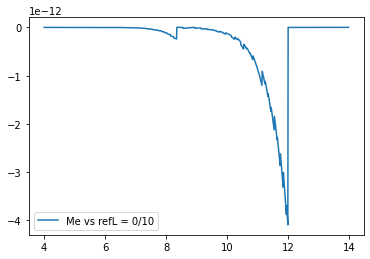

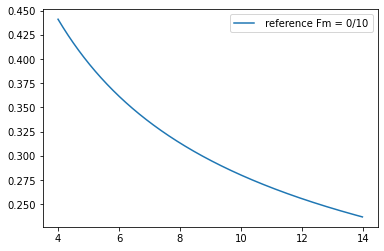

#################################################
14 10 0 Me vs ref 4.092226557617096e-12 # 
14 10 0 Me vs Seg 0.0 
#################################################
Error at  14 10 0  is  1.2346273532943397e-16


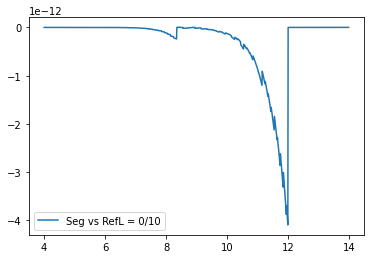

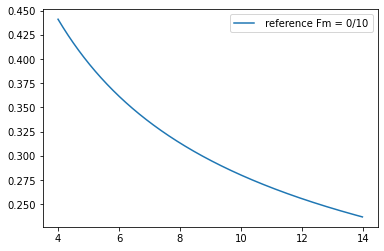

#################################################
14 10 0 Seg vs Ref 4.092226557617096e-12 # 

14 10 1 Me vs ref 1.7063433999098265e-13 
14 10 1 Me vs Seg 0.0 
14 10 1 Seg vs Ref 1.7063433999098265e-13 

14 10 2 Me vs ref 2.1289610699359862e-14 
14 10 2 Me vs Seg 0.0 
14 10 2 Seg vs Ref 2.1289610699359862e-14 

14 10 3 Me vs ref 4.48886804463311e-15 
14 10 3 Me vs Seg 0.0 
14 10 3 Seg vs Ref 4.48886804463311e-15 

14 10 4 Me vs ref 1.2835869520055887e-15 
14 10 4 Me vs Seg 0.0 
14 10 4 Seg vs Ref 1.2835869520055887e-15 

14 10 5 Me vs ref 5.031104656147423e-16 
14 10 5 Me vs Seg 0.0 
14 10 5 Seg vs Ref 5.031104656147423e-16 

14 10 6 Me vs ref 1.9510048687287201e-16 
14 10 6 Me vs Seg 0.0 
14 10 6 Seg vs Ref 1.9510048687287201e-16 

14 10 7 Me vs ref 2.1514128640490876e-16 
14 10 7 Me vs Seg 0.0 
14 10 7 Seg vs Ref 2.1514128640490876e-16 

14 10 8 Me vs ref 1.0728095793449341e-16 
14 10 8 Me vs Seg 0.0 
14 10 8 Seg vs Ref 1.0728095793449341e-16 

14 10 9 Me vs ref 1.4288429380643342e-1

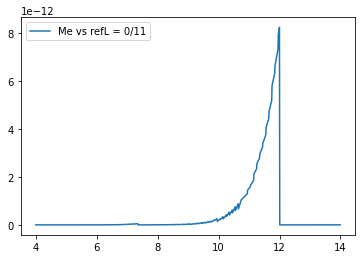

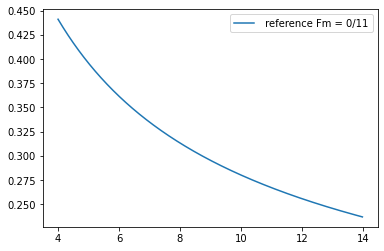

#################################################
14 11 0 Me vs ref 8.238909554592055e-12 # 
14 11 0 Me vs Seg 0.0 
#################################################
Error at  14 11 0  is  1.2346273532943397e-16


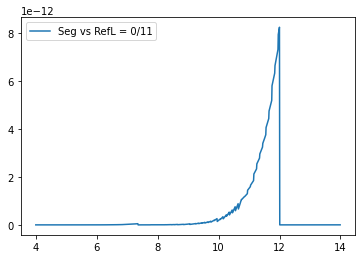

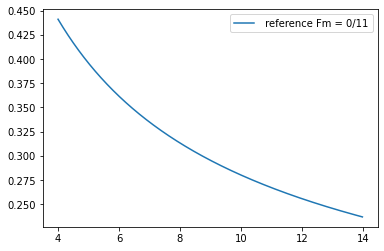

#################################################
14 11 0 Seg vs Ref 8.238909554592055e-12 # 

14 11 1 Me vs ref 3.4324799946805484e-13 
14 11 1 Me vs Seg 0.0 
14 11 1 Seg vs Ref 3.4324799946805484e-13 

14 11 2 Me vs ref 4.2956090073875686e-14 
14 11 2 Me vs Seg 0.0 
14 11 2 Seg vs Ref 4.2956090073875686e-14 

14 11 3 Me vs ref 8.897830389154038e-15 
14 11 3 Me vs Seg 0.0 
14 11 3 Seg vs Ref 8.897830389154038e-15 

14 11 4 Me vs ref 2.621492432852701e-15 
14 11 4 Me vs Seg 0.0 
14 11 4 Seg vs Ref 2.621492432852701e-15 

14 11 5 Me vs ref 9.615348610641367e-16 
14 11 5 Me vs Seg 0.0 
14 11 5 Seg vs Ref 9.615348610641367e-16 

14 11 6 Me vs ref 4.771573761108705e-16 
14 11 6 Me vs Seg 0.0 
14 11 6 Seg vs Ref 4.771573761108705e-16 

14 11 7 Me vs ref 2.3406146134772807e-16 
14 11 7 Me vs Seg 0.0 
14 11 7 Seg vs Ref 2.3406146134772807e-16 

14 11 8 Me vs ref 2.0680394110508468e-16 
14 11 8 Me vs Seg 0.0 
14 11 8 Seg vs Ref 2.0680394110508468e-16 

14 11 9 Me vs ref 1.0428352009239725e-16 

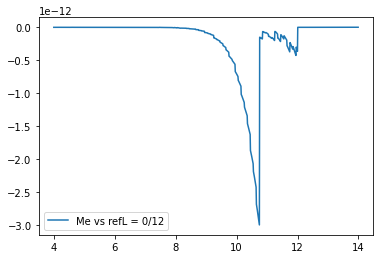

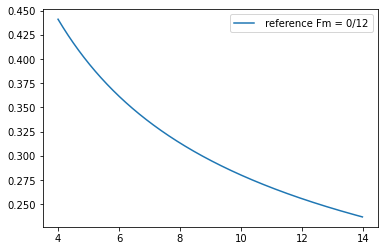

#################################################
14 12 0 Me vs ref 3.0024871477962733e-12 # 
14 12 0 Me vs Seg 0.0 
#################################################
Error at  14 12 0  is  1.2346273532943397e-16


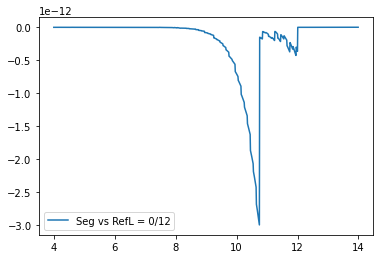

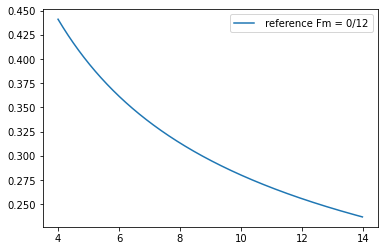

#################################################
14 12 0 Seg vs Ref 3.0024871477962733e-12 # 

14 12 1 Me vs ref 1.3968340373260446e-13 
14 12 1 Me vs Seg 0.0 
14 12 1 Seg vs Ref 1.3968340373260446e-13 

14 12 2 Me vs ref 1.943345658006468e-14 
14 12 2 Me vs Seg 0.0 
14 12 2 Seg vs Ref 1.943345658006468e-14 

14 12 3 Me vs ref 4.642120021713936e-15 
14 12 3 Me vs Seg 0.0 
14 12 3 Seg vs Ref 4.642120021713936e-15 

14 12 4 Me vs ref 1.421117997585375e-15 
14 12 4 Me vs Seg 0.0 
14 12 4 Seg vs Ref 1.421117997585375e-15 

14 12 5 Me vs ref 6.816311295780586e-16 
14 12 5 Me vs Seg 0.0 
14 12 5 Seg vs Ref 6.816311295780586e-16 

14 12 6 Me vs ref 3.0536893001233134e-16 
14 12 6 Me vs Seg 0.0 
14 12 6 Seg vs Ref 3.0536893001233134e-16 

14 12 7 Me vs ref 2.3753006126673443e-16 
14 12 7 Me vs Seg 0.0 
14 12 7 Seg vs Ref 2.3753006126673443e-16 

14 12 8 Me vs ref 1.1363455207184792e-16 
14 12 8 Me vs Seg 0.0 
14 12 8 Seg vs Ref 1.1363455207184792e-16 

14 12 9 Me vs ref 1.2217603231196028e-16

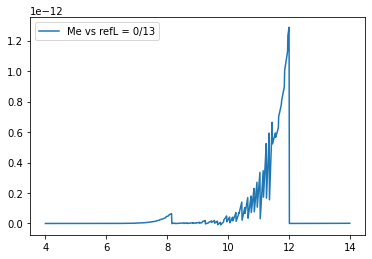

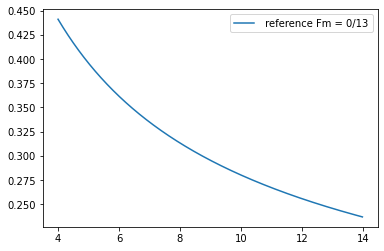

#################################################
14 13 0 Me vs ref 1.2879142197164128e-12 # 
14 13 0 Me vs Seg 0.0 
#################################################
Error at  14 13 0  is  1.2346273532943397e-16


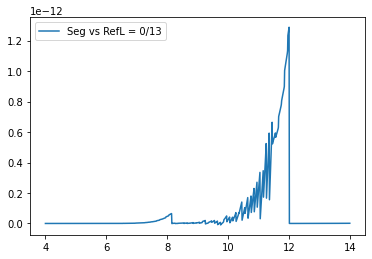

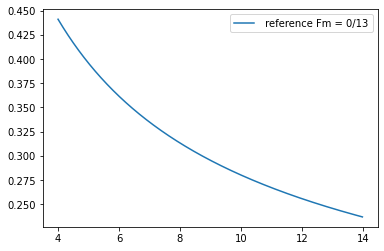

#################################################
14 13 0 Seg vs Ref 1.2879142197164128e-12 # 

14 13 1 Me vs ref 5.357519983206771e-14 
14 13 1 Me vs Seg 0.0 
14 13 1 Seg vs Ref 5.357519983206771e-14 

14 13 2 Me vs ref 6.740918587211375e-15 
14 13 2 Me vs Seg 0.0 
14 13 2 Seg vs Ref 6.740918587211375e-15 

14 13 3 Me vs ref 1.351783268654927e-15 
14 13 3 Me vs Seg 0.0 
14 13 3 Seg vs Ref 1.351783268654927e-15 

14 13 4 Me vs ref 4.224593765089768e-16 
14 13 4 Me vs Seg 0.0 
14 13 4 Seg vs Ref 4.224593765089768e-16 

14 13 5 Me vs ref 1.3723627811414174e-16 
14 13 5 Me vs Seg 0.0 
14 13 5 Seg vs Ref 1.3723627811414174e-16 

14 13 6 Me vs ref 1.1897763590312804e-16 
14 13 6 Me vs Seg 0.0 
14 13 6 Seg vs Ref 1.1897763590312804e-16 

14 13 7 Me vs ref 1.0560129160008813e-16 
14 13 7 Me vs Seg 0.0 
14 13 7 Seg vs Ref 1.0560129160008813e-16 

14 13 8 Me vs ref 1.0728095793449341e-16 
14 13 8 Me vs Seg 0.0 
14 13 8 Seg vs Ref 1.0728095793449341e-16 

14 13 9 Me vs ref 1.0428352009239725e-16

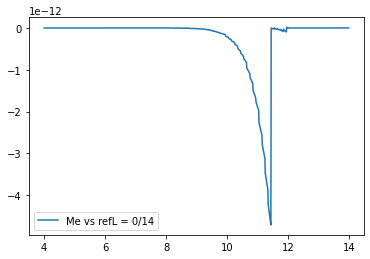

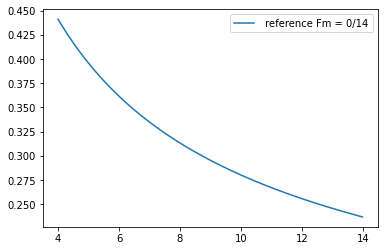

#################################################
14 14 0 Me vs ref 4.70939953700622e-12 # 
14 14 0 Me vs Seg 0.0 
#################################################
Error at  14 14 0  is  1.2346273532943397e-16


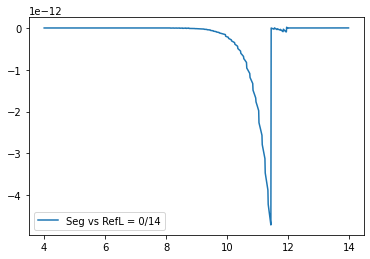

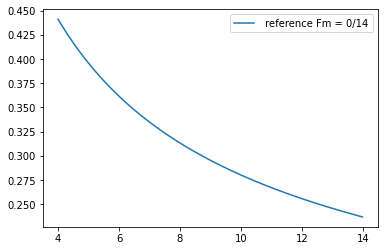

#################################################
14 14 0 Seg vs Ref 4.70939953700622e-12 # 

14 14 1 Me vs ref 2.0584575710635988e-13 
14 14 1 Me vs Seg 0.0 
14 14 1 Seg vs Ref 2.0584575710635988e-13 

14 14 2 Me vs ref 2.696757747666645e-14 
14 14 2 Me vs Seg 0.0 
14 14 2 Seg vs Ref 2.696757747666645e-14 

14 14 3 Me vs ref 5.917304406882762e-15 
14 14 3 Me vs Seg 0.0 
14 14 3 Seg vs Ref 5.917304406882762e-15 

14 14 4 Me vs ref 1.701235181374161e-15 
14 14 4 Me vs Seg 0.0 
14 14 4 Seg vs Ref 1.701235181374161e-15 

14 14 5 Me vs ref 8.192367140572032e-16 
14 14 5 Me vs Seg 0.0 
14 14 5 Seg vs Ref 8.192367140572032e-16 

14 14 6 Me vs ref 3.245084864884895e-16 
14 14 6 Me vs Seg 0.0 
14 14 6 Seg vs Ref 3.245084864884895e-16 

14 14 7 Me vs ref 2.7412866085169824e-16 
14 14 7 Me vs Seg 0.0 
14 14 7 Seg vs Ref 2.7412866085169824e-16 

14 14 8 Me vs ref 1.0728095793449341e-16 
14 14 8 Me vs Seg 0.0 
14 14 8 Seg vs Ref 1.0728095793449341e-16 

14 14 9 Me vs ref 1.2060478619480355e-16 
14

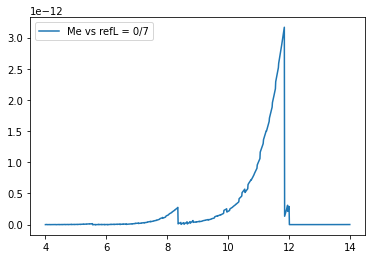

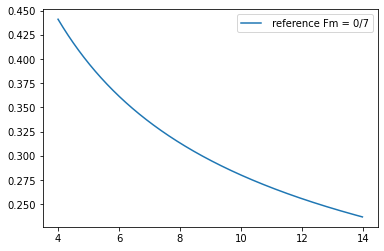

#################################################
15 7 0 Me vs ref 3.165356865508784e-12 # 
15 7 0 Me vs Seg 0.0 
#################################################
Error at  15 7 0  is  1.2346273532943397e-16


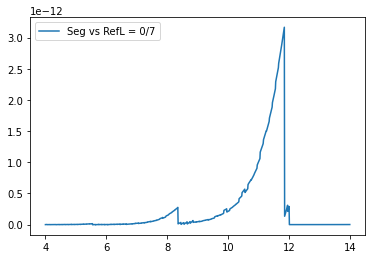

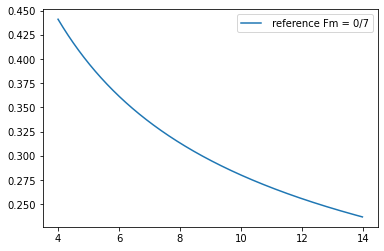

#################################################
15 7 0 Seg vs Ref 3.165356865508784e-12 # 

15 7 1 Me vs ref 1.3357544237369012e-13 
15 7 1 Me vs Seg 0.0 
15 7 1 Seg vs Ref 1.3357544237369012e-13 

15 7 2 Me vs ref 1.6952802009417844e-14 
15 7 2 Me vs Seg 0.0 
15 7 2 Seg vs Ref 1.6952802009417844e-14 

15 7 3 Me vs ref 3.5335233003475075e-15 
15 7 3 Me vs Seg 0.0 
15 7 3 Seg vs Ref 3.5335233003475075e-15 

15 7 4 Me vs ref 1.0686709763646496e-15 
15 7 4 Me vs Seg 0.0 
15 7 4 Seg vs Ref 1.0686709763646496e-15 

15 7 5 Me vs ref 3.885441773009146e-16 
15 7 5 Me vs Seg 0.0 
15 7 5 Seg vs Ref 3.885441773009146e-16 

15 7 6 Me vs ref 2.124528038303236e-16 
15 7 6 Me vs Seg 0.0 
15 7 6 Seg vs Ref 2.124528038303236e-16 

15 7 7 Me vs ref 1.2240642527361345e-16 
15 7 7 Me vs Seg 0.0 
15 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  15 8 0  is  1.2346273532943397e-16


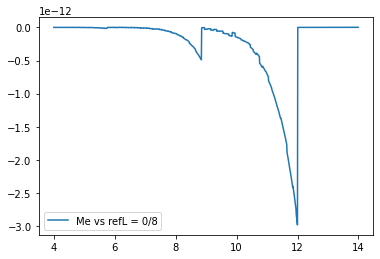

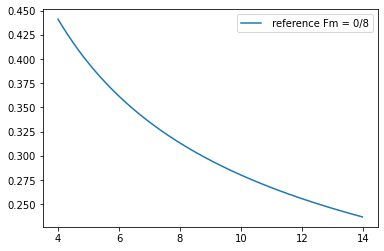

#################################################
15 8 0 Me vs ref 2.9816149549333204e-12 # 
15 8 0 Me vs Seg 0.0 
#################################################
Error at  15 8 0  is  1.2346273532943397e-16


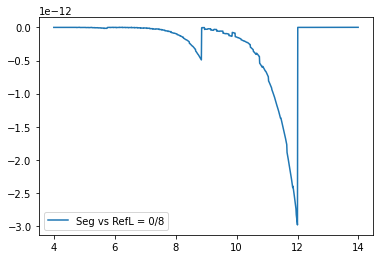

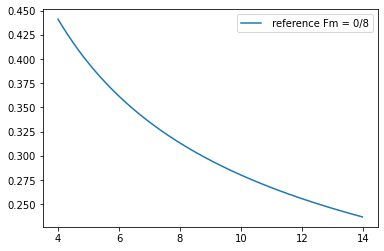

#################################################
15 8 0 Seg vs Ref 2.9816149549333204e-12 # 

15 8 1 Me vs ref 1.2435018292844546e-13 
15 8 1 Me vs Seg 0.0 
15 8 1 Seg vs Ref 1.2435018292844546e-13 

15 8 2 Me vs ref 1.5503223704804725e-14 
15 8 2 Me vs Seg 0.0 
15 8 2 Seg vs Ref 1.5503223704804725e-14 

15 8 3 Me vs ref 3.2831810187206045e-15 
15 8 3 Me vs Seg 0.0 
15 8 3 Seg vs Ref 3.2831810187206045e-15 

15 8 4 Me vs ref 9.31871767251291e-16 
15 8 4 Me vs Seg 0.0 
15 8 4 Seg vs Ref 9.31871767251291e-16 

15 8 5 Me vs ref 3.7119694254114655e-16 
15 8 5 Me vs Seg 0.0 
15 8 5 Seg vs Ref 3.7119694254114655e-16 

15 8 6 Me vs ref 1.4072944198861848e-16 
15 8 6 Me vs Seg 0.0 
15 8 6 Seg vs Ref 1.4072944198861848e-16 

15 8 7 Me vs ref 1.8633877806647353e-16 
15 8 7 Me vs Seg 0.0 
15 8 7 Seg vs Ref 1.8633877806647353e-16 

15 8 8 Me vs ref 1.0728095793449341e-16 
15 8 8 Me vs Seg 0.0 
15 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

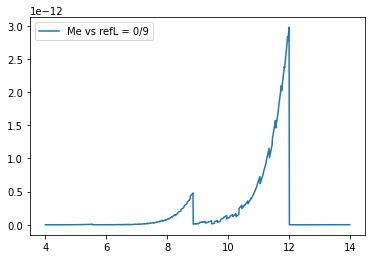

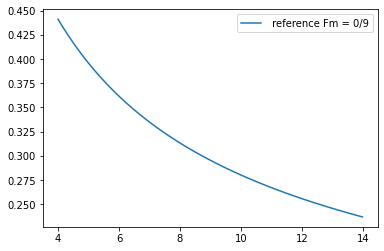

#################################################
15 9 0 Me vs ref 2.9801716650013077e-12 # 
15 9 0 Me vs Seg 0.0 
#################################################
Error at  15 9 0  is  1.2346273532943397e-16


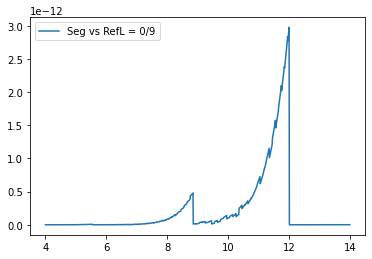

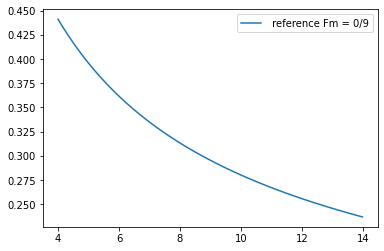

#################################################
15 9 0 Seg vs Ref 2.9801716650013077e-12 # 

15 9 1 Me vs ref 1.2409691330095285e-13 
15 9 1 Me vs Seg 0.0 
15 9 1 Seg vs Ref 1.2409691330095285e-13 

15 9 2 Me vs ref 1.5557650653863497e-14 
15 9 2 Me vs Seg 0.0 
15 9 2 Seg vs Ref 1.5557650653863497e-14 

15 9 3 Me vs ref 3.18890963982299e-15 
15 9 3 Me vs Seg 0.0 
15 9 3 Seg vs Ref 3.18890963982299e-15 

15 9 4 Me vs ref 9.561307908606542e-16 
15 9 4 Me vs Seg 0.0 
15 9 4 Seg vs Ref 9.561307908606542e-16 

15 9 5 Me vs ref 3.369192132316595e-16 
15 9 5 Me vs Seg 0.0 
15 9 5 Seg vs Ref 3.369192132316595e-16 

15 9 6 Me vs ref 1.9072810279914532e-16 
15 9 6 Me vs Seg 0.0 
15 9 6 Seg vs Ref 1.9072810279914532e-16 

15 9 7 Me vs ref 1.127231446206023e-16 
15 9 7 Me vs Seg 0.0 
15 9 7 Seg vs Ref 1.127231446206023e-16 

15 9 8 Me vs ref 2.041755978697546e-16 
15 9 8 Me vs Seg 0.0 
15 9 8 Seg vs Ref 2.041755978697546e-16 

15 9 9 Me vs ref 1.1075125191939428e-16 
15 9 9 Me vs Seg 0.0 
15 9 9

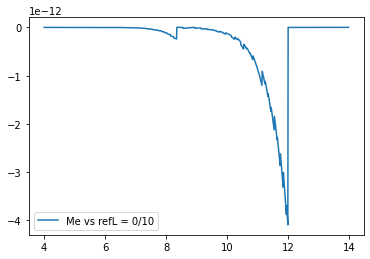

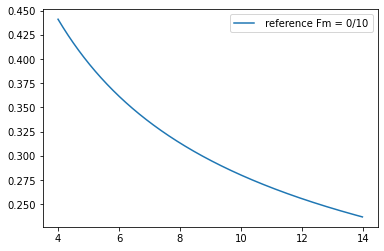

#################################################
15 10 0 Me vs ref 4.092226557617096e-12 # 
15 10 0 Me vs Seg 0.0 
#################################################
Error at  15 10 0  is  1.2346273532943397e-16


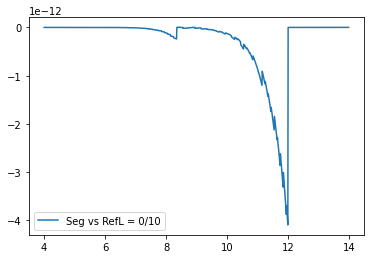

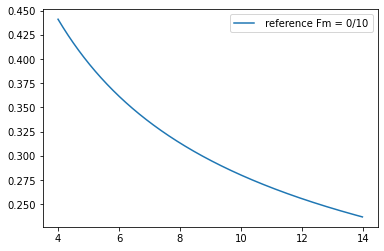

#################################################
15 10 0 Seg vs Ref 4.092226557617096e-12 # 

15 10 1 Me vs ref 1.7063433999098265e-13 
15 10 1 Me vs Seg 0.0 
15 10 1 Seg vs Ref 1.7063433999098265e-13 

15 10 2 Me vs ref 2.1289610699359862e-14 
15 10 2 Me vs Seg 0.0 
15 10 2 Seg vs Ref 2.1289610699359862e-14 

15 10 3 Me vs ref 4.48886804463311e-15 
15 10 3 Me vs Seg 0.0 
15 10 3 Seg vs Ref 4.48886804463311e-15 

15 10 4 Me vs ref 1.2835869520055887e-15 
15 10 4 Me vs Seg 0.0 
15 10 4 Seg vs Ref 1.2835869520055887e-15 

15 10 5 Me vs ref 5.031104656147423e-16 
15 10 5 Me vs Seg 0.0 
15 10 5 Seg vs Ref 5.031104656147423e-16 

15 10 6 Me vs ref 1.9510048687287201e-16 
15 10 6 Me vs Seg 0.0 
15 10 6 Seg vs Ref 1.9510048687287201e-16 

15 10 7 Me vs ref 2.1514128640490876e-16 
15 10 7 Me vs Seg 0.0 
15 10 7 Seg vs Ref 2.1514128640490876e-16 

15 10 8 Me vs ref 1.0728095793449341e-16 
15 10 8 Me vs Seg 0.0 
15 10 8 Seg vs Ref 1.0728095793449341e-16 

15 10 9 Me vs ref 1.4288429380643342e-1

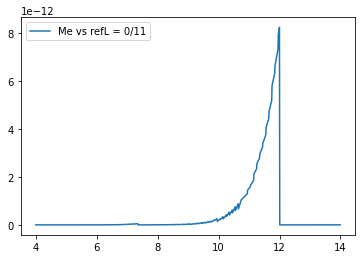

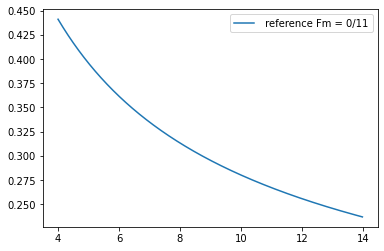

#################################################
15 11 0 Me vs ref 8.238909554592055e-12 # 
15 11 0 Me vs Seg 0.0 
#################################################
Error at  15 11 0  is  1.2346273532943397e-16


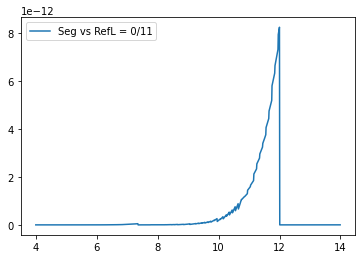

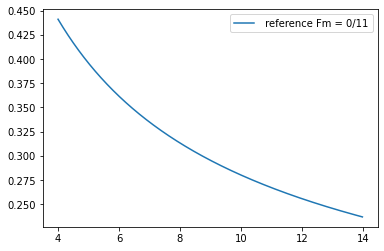

#################################################
15 11 0 Seg vs Ref 8.238909554592055e-12 # 

15 11 1 Me vs ref 3.4324799946805484e-13 
15 11 1 Me vs Seg 0.0 
15 11 1 Seg vs Ref 3.4324799946805484e-13 

15 11 2 Me vs ref 4.2956090073875686e-14 
15 11 2 Me vs Seg 0.0 
15 11 2 Seg vs Ref 4.2956090073875686e-14 

15 11 3 Me vs ref 8.897830389154038e-15 
15 11 3 Me vs Seg 0.0 
15 11 3 Seg vs Ref 8.897830389154038e-15 

15 11 4 Me vs ref 2.621492432852701e-15 
15 11 4 Me vs Seg 0.0 
15 11 4 Seg vs Ref 2.621492432852701e-15 

15 11 5 Me vs ref 9.615348610641367e-16 
15 11 5 Me vs Seg 0.0 
15 11 5 Seg vs Ref 9.615348610641367e-16 

15 11 6 Me vs ref 4.771573761108705e-16 
15 11 6 Me vs Seg 0.0 
15 11 6 Seg vs Ref 4.771573761108705e-16 

15 11 7 Me vs ref 2.3406146134772807e-16 
15 11 7 Me vs Seg 0.0 
15 11 7 Seg vs Ref 2.3406146134772807e-16 

15 11 8 Me vs ref 2.0680394110508468e-16 
15 11 8 Me vs Seg 0.0 
15 11 8 Seg vs Ref 2.0680394110508468e-16 

15 11 9 Me vs ref 1.0428352009239725e-16 

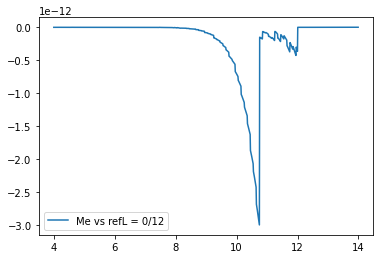

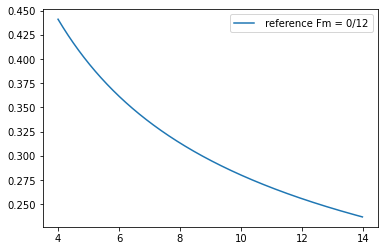

#################################################
15 12 0 Me vs ref 3.0024871477962733e-12 # 
15 12 0 Me vs Seg 0.0 
#################################################
Error at  15 12 0  is  1.2346273532943397e-16


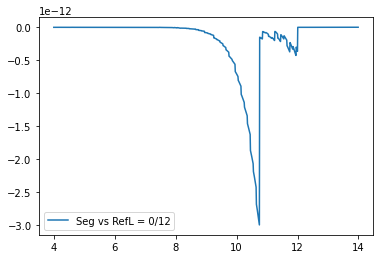

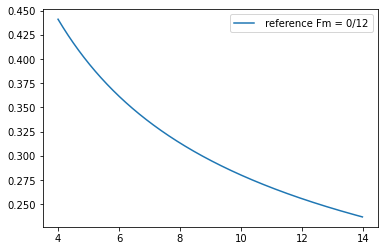

#################################################
15 12 0 Seg vs Ref 3.0024871477962733e-12 # 

15 12 1 Me vs ref 1.3968340373260446e-13 
15 12 1 Me vs Seg 0.0 
15 12 1 Seg vs Ref 1.3968340373260446e-13 

15 12 2 Me vs ref 1.943345658006468e-14 
15 12 2 Me vs Seg 0.0 
15 12 2 Seg vs Ref 1.943345658006468e-14 

15 12 3 Me vs ref 4.642120021713936e-15 
15 12 3 Me vs Seg 0.0 
15 12 3 Seg vs Ref 4.642120021713936e-15 

15 12 4 Me vs ref 1.421117997585375e-15 
15 12 4 Me vs Seg 0.0 
15 12 4 Seg vs Ref 1.421117997585375e-15 

15 12 5 Me vs ref 6.816311295780586e-16 
15 12 5 Me vs Seg 0.0 
15 12 5 Seg vs Ref 6.816311295780586e-16 

15 12 6 Me vs ref 3.0536893001233134e-16 
15 12 6 Me vs Seg 0.0 
15 12 6 Seg vs Ref 3.0536893001233134e-16 

15 12 7 Me vs ref 2.3753006126673443e-16 
15 12 7 Me vs Seg 0.0 
15 12 7 Seg vs Ref 2.3753006126673443e-16 

15 12 8 Me vs ref 1.1363455207184792e-16 
15 12 8 Me vs Seg 0.0 
15 12 8 Seg vs Ref 1.1363455207184792e-16 

15 12 9 Me vs ref 1.2217603231196028e-16

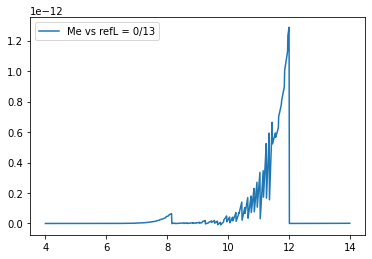

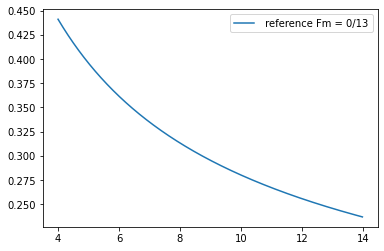

#################################################
15 13 0 Me vs ref 1.2879142197164128e-12 # 
15 13 0 Me vs Seg 0.0 
#################################################
Error at  15 13 0  is  1.2346273532943397e-16


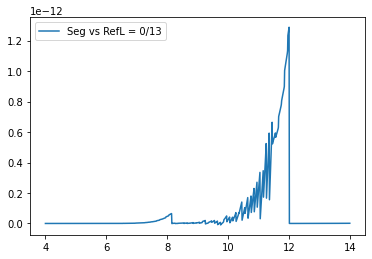

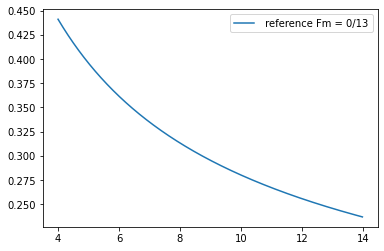

#################################################
15 13 0 Seg vs Ref 1.2879142197164128e-12 # 

15 13 1 Me vs ref 5.357519983206771e-14 
15 13 1 Me vs Seg 0.0 
15 13 1 Seg vs Ref 5.357519983206771e-14 

15 13 2 Me vs ref 6.740918587211375e-15 
15 13 2 Me vs Seg 0.0 
15 13 2 Seg vs Ref 6.740918587211375e-15 

15 13 3 Me vs ref 1.351783268654927e-15 
15 13 3 Me vs Seg 0.0 
15 13 3 Seg vs Ref 1.351783268654927e-15 

15 13 4 Me vs ref 4.224593765089768e-16 
15 13 4 Me vs Seg 0.0 
15 13 4 Seg vs Ref 4.224593765089768e-16 

15 13 5 Me vs ref 1.3723627811414174e-16 
15 13 5 Me vs Seg 0.0 
15 13 5 Seg vs Ref 1.3723627811414174e-16 

15 13 6 Me vs ref 1.1897763590312804e-16 
15 13 6 Me vs Seg 0.0 
15 13 6 Seg vs Ref 1.1897763590312804e-16 

15 13 7 Me vs ref 1.0560129160008813e-16 
15 13 7 Me vs Seg 0.0 
15 13 7 Seg vs Ref 1.0560129160008813e-16 

15 13 8 Me vs ref 1.0728095793449341e-16 
15 13 8 Me vs Seg 0.0 
15 13 8 Seg vs Ref 1.0728095793449341e-16 

15 13 9 Me vs ref 1.0428352009239725e-16

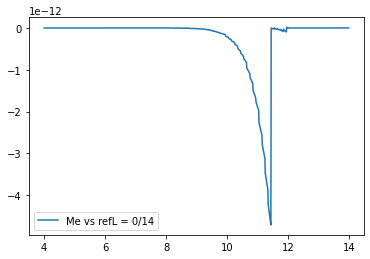

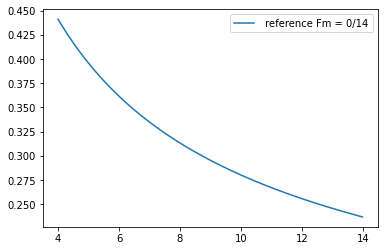

#################################################
15 14 0 Me vs ref 4.70939953700622e-12 # 
15 14 0 Me vs Seg 0.0 
#################################################
Error at  15 14 0  is  1.2346273532943397e-16


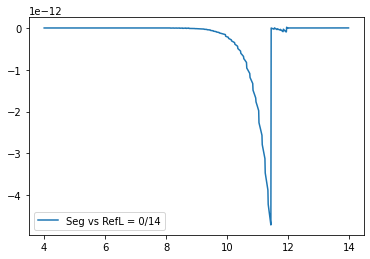

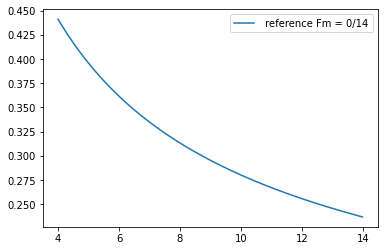

#################################################
15 14 0 Seg vs Ref 4.70939953700622e-12 # 

15 14 1 Me vs ref 2.0584575710635988e-13 
15 14 1 Me vs Seg 0.0 
15 14 1 Seg vs Ref 2.0584575710635988e-13 

15 14 2 Me vs ref 2.696757747666645e-14 
15 14 2 Me vs Seg 0.0 
15 14 2 Seg vs Ref 2.696757747666645e-14 

15 14 3 Me vs ref 5.917304406882762e-15 
15 14 3 Me vs Seg 0.0 
15 14 3 Seg vs Ref 5.917304406882762e-15 

15 14 4 Me vs ref 1.701235181374161e-15 
15 14 4 Me vs Seg 0.0 
15 14 4 Seg vs Ref 1.701235181374161e-15 

15 14 5 Me vs ref 8.192367140572032e-16 
15 14 5 Me vs Seg 0.0 
15 14 5 Seg vs Ref 8.192367140572032e-16 

15 14 6 Me vs ref 3.245084864884895e-16 
15 14 6 Me vs Seg 0.0 
15 14 6 Seg vs Ref 3.245084864884895e-16 

15 14 7 Me vs ref 2.7412866085169824e-16 
15 14 7 Me vs Seg 0.0 
15 14 7 Seg vs Ref 2.7412866085169824e-16 

15 14 8 Me vs ref 1.0728095793449341e-16 
15 14 8 Me vs Seg 0.0 
15 14 8 Seg vs Ref 1.0728095793449341e-16 

15 14 9 Me vs ref 1.2060478619480355e-16 
15

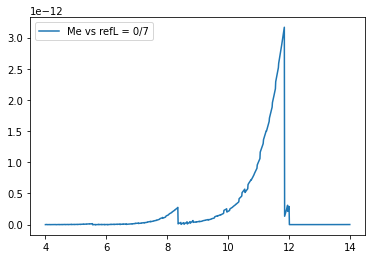

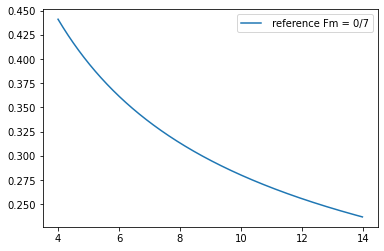

#################################################
16 7 0 Me vs ref 3.165356865508784e-12 # 
16 7 0 Me vs Seg 0.0 
#################################################
Error at  16 7 0  is  1.2346273532943397e-16


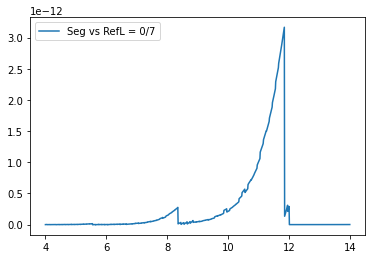

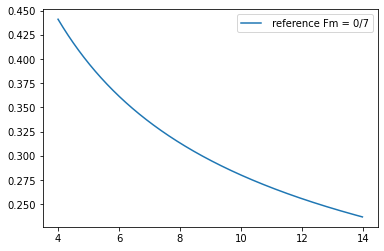

#################################################
16 7 0 Seg vs Ref 3.165356865508784e-12 # 

16 7 1 Me vs ref 1.3357544237369012e-13 
16 7 1 Me vs Seg 0.0 
16 7 1 Seg vs Ref 1.3357544237369012e-13 

16 7 2 Me vs ref 1.6952802009417844e-14 
16 7 2 Me vs Seg 0.0 
16 7 2 Seg vs Ref 1.6952802009417844e-14 

16 7 3 Me vs ref 3.5335233003475075e-15 
16 7 3 Me vs Seg 0.0 
16 7 3 Seg vs Ref 3.5335233003475075e-15 

16 7 4 Me vs ref 1.0686709763646496e-15 
16 7 4 Me vs Seg 0.0 
16 7 4 Seg vs Ref 1.0686709763646496e-15 

16 7 5 Me vs ref 3.885441773009146e-16 
16 7 5 Me vs Seg 0.0 
16 7 5 Seg vs Ref 3.885441773009146e-16 

16 7 6 Me vs ref 2.124528038303236e-16 
16 7 6 Me vs Seg 0.0 
16 7 6 Seg vs Ref 2.124528038303236e-16 

16 7 7 Me vs ref 1.2240642527361345e-16 
16 7 7 Me vs Seg 0.0 
16 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  16 8 0  is  1.2346273532943397e-16


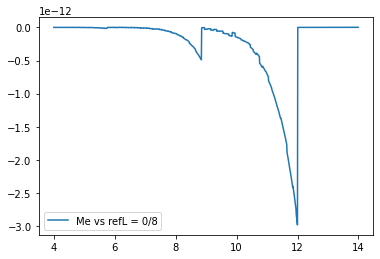

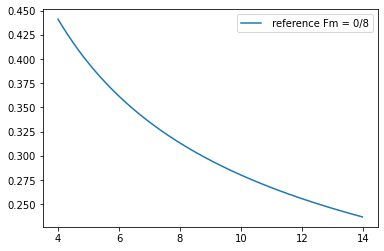

#################################################
16 8 0 Me vs ref 2.9816149549333204e-12 # 
16 8 0 Me vs Seg 0.0 
#################################################
Error at  16 8 0  is  1.2346273532943397e-16


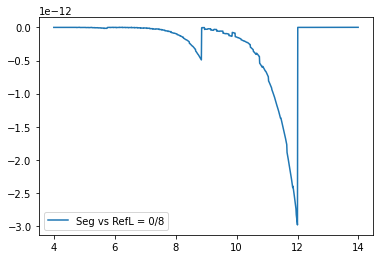

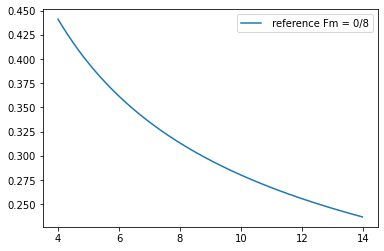

#################################################
16 8 0 Seg vs Ref 2.9816149549333204e-12 # 

16 8 1 Me vs ref 1.2435018292844546e-13 
16 8 1 Me vs Seg 0.0 
16 8 1 Seg vs Ref 1.2435018292844546e-13 

16 8 2 Me vs ref 1.5503223704804725e-14 
16 8 2 Me vs Seg 0.0 
16 8 2 Seg vs Ref 1.5503223704804725e-14 

16 8 3 Me vs ref 3.2831810187206045e-15 
16 8 3 Me vs Seg 0.0 
16 8 3 Seg vs Ref 3.2831810187206045e-15 

16 8 4 Me vs ref 9.31871767251291e-16 
16 8 4 Me vs Seg 0.0 
16 8 4 Seg vs Ref 9.31871767251291e-16 

16 8 5 Me vs ref 3.7119694254114655e-16 
16 8 5 Me vs Seg 0.0 
16 8 5 Seg vs Ref 3.7119694254114655e-16 

16 8 6 Me vs ref 1.4072944198861848e-16 
16 8 6 Me vs Seg 0.0 
16 8 6 Seg vs Ref 1.4072944198861848e-16 

16 8 7 Me vs ref 1.8633877806647353e-16 
16 8 7 Me vs Seg 0.0 
16 8 7 Seg vs Ref 1.8633877806647353e-16 

16 8 8 Me vs ref 1.0728095793449341e-16 
16 8 8 Me vs Seg 0.0 
16 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

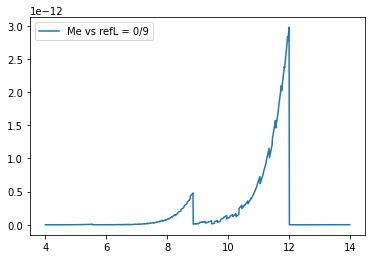

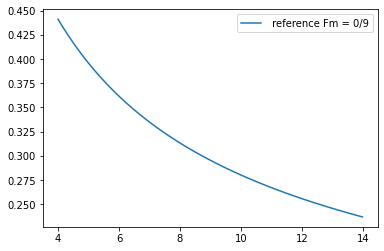

#################################################
16 9 0 Me vs ref 2.9801716650013077e-12 # 
16 9 0 Me vs Seg 0.0 
#################################################
Error at  16 9 0  is  1.2346273532943397e-16


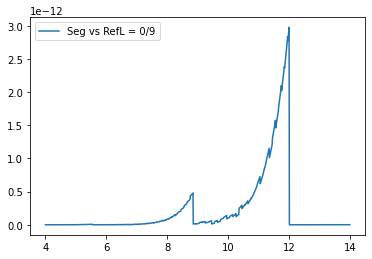

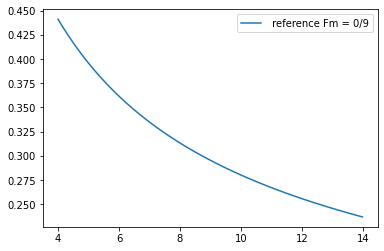

#################################################
16 9 0 Seg vs Ref 2.9801716650013077e-12 # 

16 9 1 Me vs ref 1.2409691330095285e-13 
16 9 1 Me vs Seg 0.0 
16 9 1 Seg vs Ref 1.2409691330095285e-13 

16 9 2 Me vs ref 1.5557650653863497e-14 
16 9 2 Me vs Seg 0.0 
16 9 2 Seg vs Ref 1.5557650653863497e-14 

16 9 3 Me vs ref 3.18890963982299e-15 
16 9 3 Me vs Seg 0.0 
16 9 3 Seg vs Ref 3.18890963982299e-15 

16 9 4 Me vs ref 9.561307908606542e-16 
16 9 4 Me vs Seg 0.0 
16 9 4 Seg vs Ref 9.561307908606542e-16 

16 9 5 Me vs ref 3.369192132316595e-16 
16 9 5 Me vs Seg 0.0 
16 9 5 Seg vs Ref 3.369192132316595e-16 

16 9 6 Me vs ref 1.9072810279914532e-16 
16 9 6 Me vs Seg 0.0 
16 9 6 Seg vs Ref 1.9072810279914532e-16 

16 9 7 Me vs ref 1.127231446206023e-16 
16 9 7 Me vs Seg 0.0 
16 9 7 Seg vs Ref 1.127231446206023e-16 

16 9 8 Me vs ref 2.041755978697546e-16 
16 9 8 Me vs Seg 0.0 
16 9 8 Seg vs Ref 2.041755978697546e-16 

16 9 9 Me vs ref 1.1075125191939428e-16 
16 9 9 Me vs Seg 0.0 
16 9 9

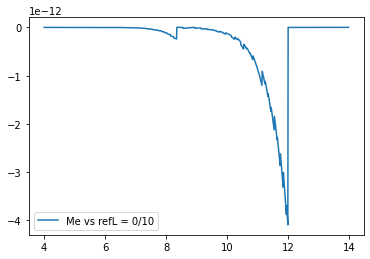

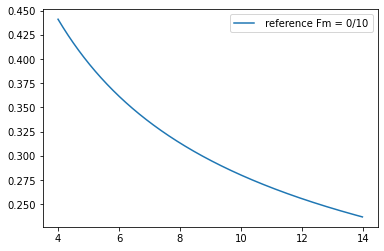

#################################################
16 10 0 Me vs ref 4.092226557617096e-12 # 
16 10 0 Me vs Seg 0.0 
#################################################
Error at  16 10 0  is  1.2346273532943397e-16


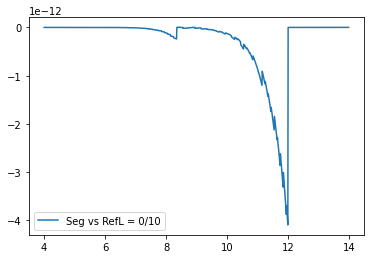

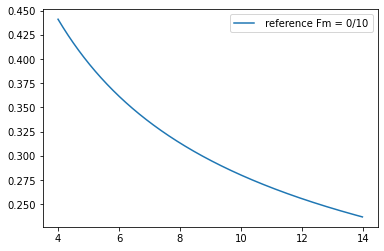

#################################################
16 10 0 Seg vs Ref 4.092226557617096e-12 # 

16 10 1 Me vs ref 1.7063433999098265e-13 
16 10 1 Me vs Seg 0.0 
16 10 1 Seg vs Ref 1.7063433999098265e-13 

16 10 2 Me vs ref 2.1289610699359862e-14 
16 10 2 Me vs Seg 0.0 
16 10 2 Seg vs Ref 2.1289610699359862e-14 

16 10 3 Me vs ref 4.48886804463311e-15 
16 10 3 Me vs Seg 0.0 
16 10 3 Seg vs Ref 4.48886804463311e-15 

16 10 4 Me vs ref 1.2835869520055887e-15 
16 10 4 Me vs Seg 0.0 
16 10 4 Seg vs Ref 1.2835869520055887e-15 

16 10 5 Me vs ref 5.031104656147423e-16 
16 10 5 Me vs Seg 0.0 
16 10 5 Seg vs Ref 5.031104656147423e-16 

16 10 6 Me vs ref 1.9510048687287201e-16 
16 10 6 Me vs Seg 0.0 
16 10 6 Seg vs Ref 1.9510048687287201e-16 

16 10 7 Me vs ref 2.1514128640490876e-16 
16 10 7 Me vs Seg 0.0 
16 10 7 Seg vs Ref 2.1514128640490876e-16 

16 10 8 Me vs ref 1.0728095793449341e-16 
16 10 8 Me vs Seg 0.0 
16 10 8 Seg vs Ref 1.0728095793449341e-16 

16 10 9 Me vs ref 1.4288429380643342e-1

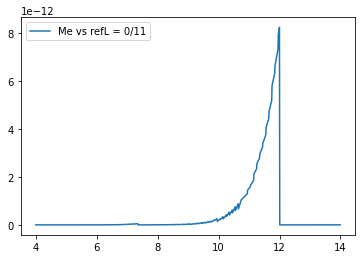

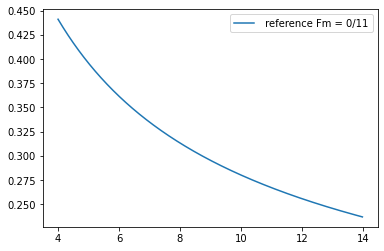

#################################################
16 11 0 Me vs ref 8.238909554592055e-12 # 
16 11 0 Me vs Seg 0.0 
#################################################
Error at  16 11 0  is  1.2346273532943397e-16


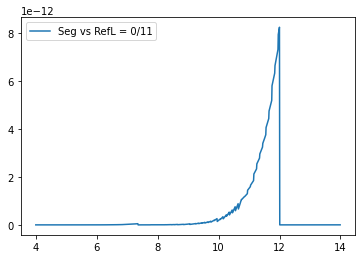

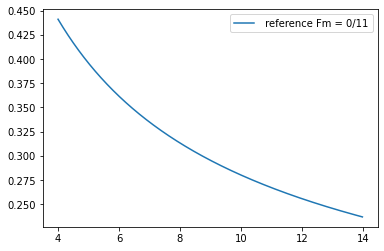

#################################################
16 11 0 Seg vs Ref 8.238909554592055e-12 # 

16 11 1 Me vs ref 3.4324799946805484e-13 
16 11 1 Me vs Seg 0.0 
16 11 1 Seg vs Ref 3.4324799946805484e-13 

16 11 2 Me vs ref 4.2956090073875686e-14 
16 11 2 Me vs Seg 0.0 
16 11 2 Seg vs Ref 4.2956090073875686e-14 

16 11 3 Me vs ref 8.897830389154038e-15 
16 11 3 Me vs Seg 0.0 
16 11 3 Seg vs Ref 8.897830389154038e-15 

16 11 4 Me vs ref 2.621492432852701e-15 
16 11 4 Me vs Seg 0.0 
16 11 4 Seg vs Ref 2.621492432852701e-15 

16 11 5 Me vs ref 9.615348610641367e-16 
16 11 5 Me vs Seg 0.0 
16 11 5 Seg vs Ref 9.615348610641367e-16 

16 11 6 Me vs ref 4.771573761108705e-16 
16 11 6 Me vs Seg 0.0 
16 11 6 Seg vs Ref 4.771573761108705e-16 

16 11 7 Me vs ref 2.3406146134772807e-16 
16 11 7 Me vs Seg 0.0 
16 11 7 Seg vs Ref 2.3406146134772807e-16 

16 11 8 Me vs ref 2.0680394110508468e-16 
16 11 8 Me vs Seg 0.0 
16 11 8 Seg vs Ref 2.0680394110508468e-16 

16 11 9 Me vs ref 1.0428352009239725e-16 

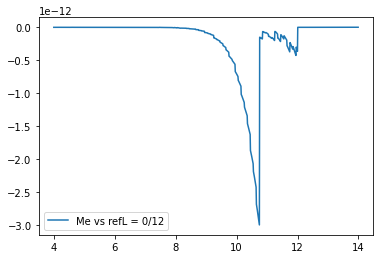

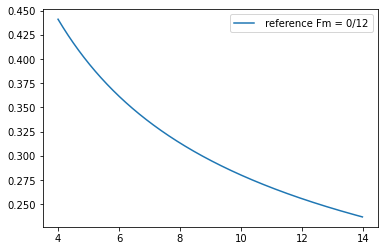

#################################################
16 12 0 Me vs ref 3.0024871477962733e-12 # 
16 12 0 Me vs Seg 0.0 
#################################################
Error at  16 12 0  is  1.2346273532943397e-16


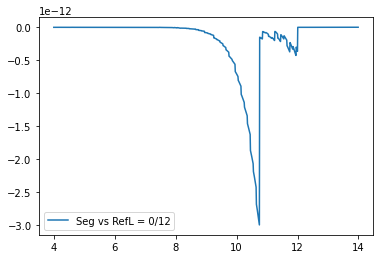

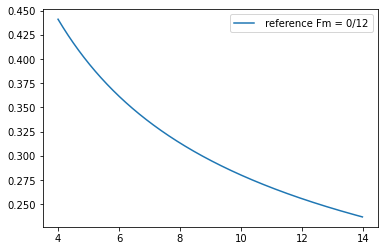

#################################################
16 12 0 Seg vs Ref 3.0024871477962733e-12 # 

16 12 1 Me vs ref 1.3968340373260446e-13 
16 12 1 Me vs Seg 0.0 
16 12 1 Seg vs Ref 1.3968340373260446e-13 

16 12 2 Me vs ref 1.943345658006468e-14 
16 12 2 Me vs Seg 0.0 
16 12 2 Seg vs Ref 1.943345658006468e-14 

16 12 3 Me vs ref 4.642120021713936e-15 
16 12 3 Me vs Seg 0.0 
16 12 3 Seg vs Ref 4.642120021713936e-15 

16 12 4 Me vs ref 1.421117997585375e-15 
16 12 4 Me vs Seg 0.0 
16 12 4 Seg vs Ref 1.421117997585375e-15 

16 12 5 Me vs ref 6.816311295780586e-16 
16 12 5 Me vs Seg 0.0 
16 12 5 Seg vs Ref 6.816311295780586e-16 

16 12 6 Me vs ref 3.0536893001233134e-16 
16 12 6 Me vs Seg 0.0 
16 12 6 Seg vs Ref 3.0536893001233134e-16 

16 12 7 Me vs ref 2.3753006126673443e-16 
16 12 7 Me vs Seg 0.0 
16 12 7 Seg vs Ref 2.3753006126673443e-16 

16 12 8 Me vs ref 1.1363455207184792e-16 
16 12 8 Me vs Seg 0.0 
16 12 8 Seg vs Ref 1.1363455207184792e-16 

16 12 9 Me vs ref 1.2217603231196028e-16

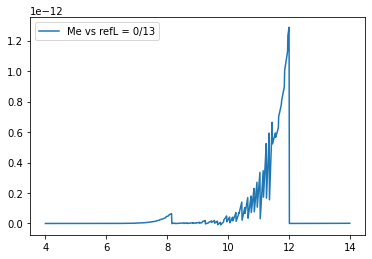

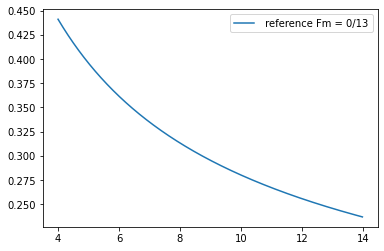

#################################################
16 13 0 Me vs ref 1.2879142197164128e-12 # 
16 13 0 Me vs Seg 0.0 
#################################################
Error at  16 13 0  is  1.2346273532943397e-16


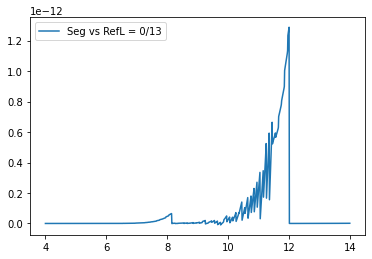

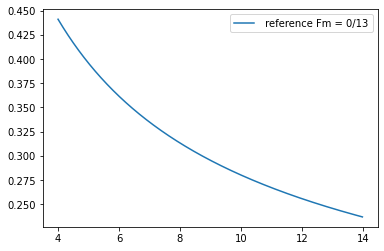

#################################################
16 13 0 Seg vs Ref 1.2879142197164128e-12 # 

16 13 1 Me vs ref 5.357519983206771e-14 
16 13 1 Me vs Seg 0.0 
16 13 1 Seg vs Ref 5.357519983206771e-14 

16 13 2 Me vs ref 6.740918587211375e-15 
16 13 2 Me vs Seg 0.0 
16 13 2 Seg vs Ref 6.740918587211375e-15 

16 13 3 Me vs ref 1.351783268654927e-15 
16 13 3 Me vs Seg 0.0 
16 13 3 Seg vs Ref 1.351783268654927e-15 

16 13 4 Me vs ref 4.224593765089768e-16 
16 13 4 Me vs Seg 0.0 
16 13 4 Seg vs Ref 4.224593765089768e-16 

16 13 5 Me vs ref 1.3723627811414174e-16 
16 13 5 Me vs Seg 0.0 
16 13 5 Seg vs Ref 1.3723627811414174e-16 

16 13 6 Me vs ref 1.1897763590312804e-16 
16 13 6 Me vs Seg 0.0 
16 13 6 Seg vs Ref 1.1897763590312804e-16 

16 13 7 Me vs ref 1.0560129160008813e-16 
16 13 7 Me vs Seg 0.0 
16 13 7 Seg vs Ref 1.0560129160008813e-16 

16 13 8 Me vs ref 1.0728095793449341e-16 
16 13 8 Me vs Seg 0.0 
16 13 8 Seg vs Ref 1.0728095793449341e-16 

16 13 9 Me vs ref 1.0428352009239725e-16

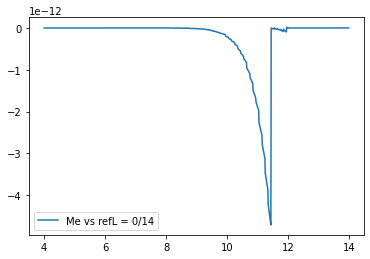

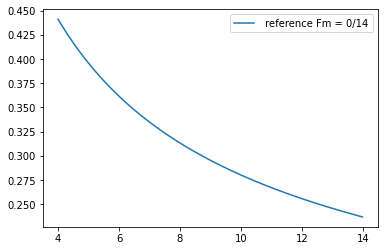

#################################################
16 14 0 Me vs ref 4.70939953700622e-12 # 
16 14 0 Me vs Seg 0.0 
#################################################
Error at  16 14 0  is  1.2346273532943397e-16


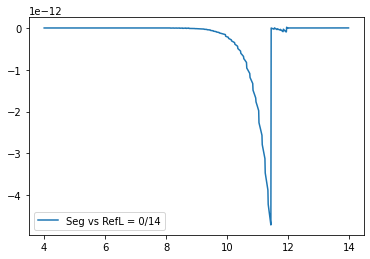

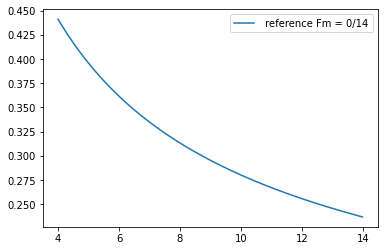

#################################################
16 14 0 Seg vs Ref 4.70939953700622e-12 # 

16 14 1 Me vs ref 2.0584575710635988e-13 
16 14 1 Me vs Seg 0.0 
16 14 1 Seg vs Ref 2.0584575710635988e-13 

16 14 2 Me vs ref 2.696757747666645e-14 
16 14 2 Me vs Seg 0.0 
16 14 2 Seg vs Ref 2.696757747666645e-14 

16 14 3 Me vs ref 5.917304406882762e-15 
16 14 3 Me vs Seg 0.0 
16 14 3 Seg vs Ref 5.917304406882762e-15 

16 14 4 Me vs ref 1.701235181374161e-15 
16 14 4 Me vs Seg 0.0 
16 14 4 Seg vs Ref 1.701235181374161e-15 

16 14 5 Me vs ref 8.192367140572032e-16 
16 14 5 Me vs Seg 0.0 
16 14 5 Seg vs Ref 8.192367140572032e-16 

16 14 6 Me vs ref 3.245084864884895e-16 
16 14 6 Me vs Seg 0.0 
16 14 6 Seg vs Ref 3.245084864884895e-16 

16 14 7 Me vs ref 2.7412866085169824e-16 
16 14 7 Me vs Seg 0.0 
16 14 7 Seg vs Ref 2.7412866085169824e-16 

16 14 8 Me vs ref 1.0728095793449341e-16 
16 14 8 Me vs Seg 0.0 
16 14 8 Seg vs Ref 1.0728095793449341e-16 

16 14 9 Me vs ref 1.2060478619480355e-16 
16

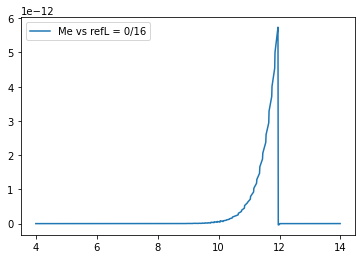

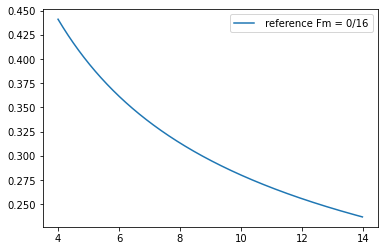

#################################################
16 16 0 Me vs ref 5.736688901691878e-12 # 
16 16 0 Me vs Seg 0.0 
#################################################
Error at  16 16 0  is  1.2346273532943397e-16


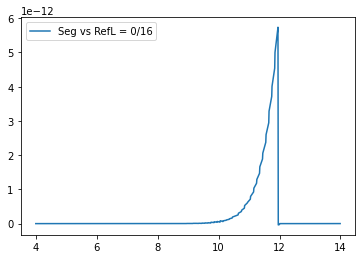

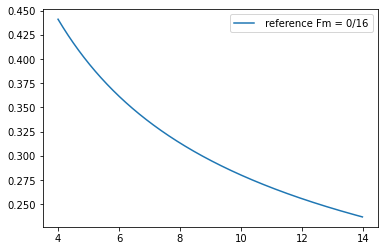

#################################################
16 16 0 Seg vs Ref 5.736688901691878e-12 # 

16 16 1 Me vs ref 2.3996256370839575e-13 
16 16 1 Me vs Seg 0.0 
16 16 1 Seg vs Ref 2.3996256370839575e-13 

16 16 2 Me vs ref 3.0163805481153716e-14 
16 16 2 Me vs Seg 0.0 
16 16 2 Seg vs Ref 3.0163805481153716e-14 

16 16 3 Me vs ref 6.2619180674072794e-15 
16 16 3 Me vs Seg 0.0 
16 16 3 Seg vs Ref 6.2619180674072794e-15 

16 16 4 Me vs ref 1.865261417544062e-15 
16 16 4 Me vs Seg 0.0 
16 16 4 Seg vs Ref 1.865261417544062e-15 

16 16 5 Me vs ref 6.807773203672263e-16 
16 16 5 Me vs Seg 0.0 
16 16 5 Seg vs Ref 6.807773203672263e-16 

16 16 6 Me vs ref 3.479611347320666e-16 
16 16 6 Me vs Seg 0.0 
16 16 6 Seg vs Ref 3.479611347320666e-16 

16 16 7 Me vs ref 1.6620395787729156e-16 
16 16 7 Me vs Seg 0.0 
16 16 7 Seg vs Ref 1.6620395787729156e-16 

16 16 8 Me vs ref 1.6045683933017113e-16 
16 16 8 Me vs Seg 0.0 
16 16 8 Seg vs Ref 1.6045683933017113e-16 

16 16 9 Me vs ref 1.0428352009239725e-1

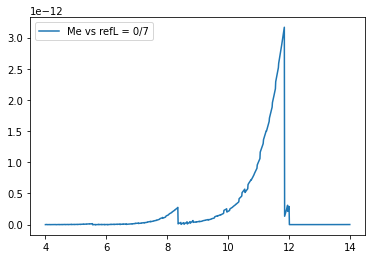

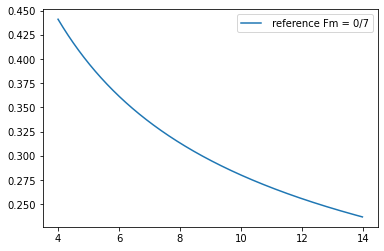

#################################################
17 7 0 Me vs ref 3.165356865508784e-12 # 
17 7 0 Me vs Seg 0.0 
#################################################
Error at  17 7 0  is  1.2346273532943397e-16


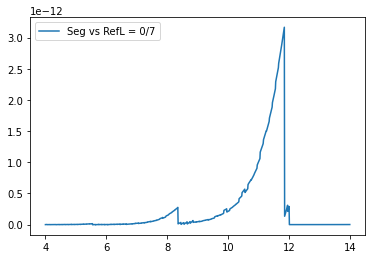

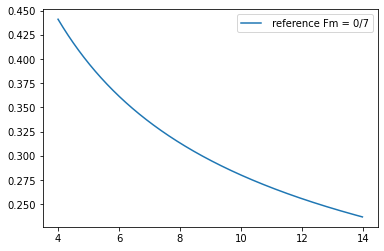

#################################################
17 7 0 Seg vs Ref 3.165356865508784e-12 # 

17 7 1 Me vs ref 1.3357544237369012e-13 
17 7 1 Me vs Seg 0.0 
17 7 1 Seg vs Ref 1.3357544237369012e-13 

17 7 2 Me vs ref 1.6952802009417844e-14 
17 7 2 Me vs Seg 0.0 
17 7 2 Seg vs Ref 1.6952802009417844e-14 

17 7 3 Me vs ref 3.5335233003475075e-15 
17 7 3 Me vs Seg 0.0 
17 7 3 Seg vs Ref 3.5335233003475075e-15 

17 7 4 Me vs ref 1.0686709763646496e-15 
17 7 4 Me vs Seg 0.0 
17 7 4 Seg vs Ref 1.0686709763646496e-15 

17 7 5 Me vs ref 3.885441773009146e-16 
17 7 5 Me vs Seg 0.0 
17 7 5 Seg vs Ref 3.885441773009146e-16 

17 7 6 Me vs ref 2.124528038303236e-16 
17 7 6 Me vs Seg 0.0 
17 7 6 Seg vs Ref 2.124528038303236e-16 

17 7 7 Me vs ref 1.2240642527361345e-16 
17 7 7 Me vs Seg 0.0 
17 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  17 8 0  is  1.2346273532943397e-16


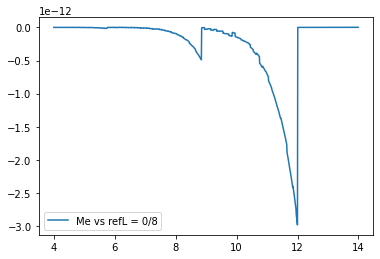

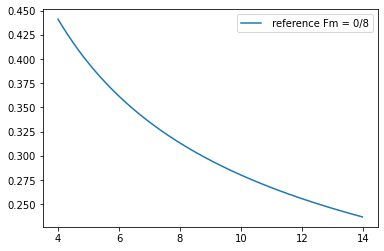

#################################################
17 8 0 Me vs ref 2.9816149549333204e-12 # 
17 8 0 Me vs Seg 0.0 
#################################################
Error at  17 8 0  is  1.2346273532943397e-16


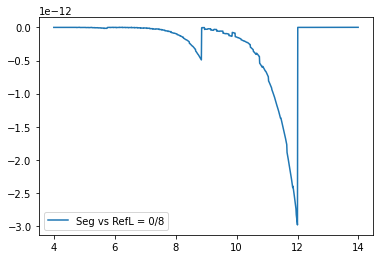

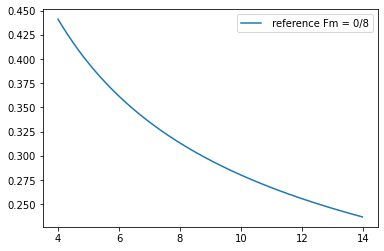

#################################################
17 8 0 Seg vs Ref 2.9816149549333204e-12 # 

17 8 1 Me vs ref 1.2435018292844546e-13 
17 8 1 Me vs Seg 0.0 
17 8 1 Seg vs Ref 1.2435018292844546e-13 

17 8 2 Me vs ref 1.5503223704804725e-14 
17 8 2 Me vs Seg 0.0 
17 8 2 Seg vs Ref 1.5503223704804725e-14 

17 8 3 Me vs ref 3.2831810187206045e-15 
17 8 3 Me vs Seg 0.0 
17 8 3 Seg vs Ref 3.2831810187206045e-15 

17 8 4 Me vs ref 9.31871767251291e-16 
17 8 4 Me vs Seg 0.0 
17 8 4 Seg vs Ref 9.31871767251291e-16 

17 8 5 Me vs ref 3.7119694254114655e-16 
17 8 5 Me vs Seg 0.0 
17 8 5 Seg vs Ref 3.7119694254114655e-16 

17 8 6 Me vs ref 1.4072944198861848e-16 
17 8 6 Me vs Seg 0.0 
17 8 6 Seg vs Ref 1.4072944198861848e-16 

17 8 7 Me vs ref 1.8633877806647353e-16 
17 8 7 Me vs Seg 0.0 
17 8 7 Seg vs Ref 1.8633877806647353e-16 

17 8 8 Me vs ref 1.0728095793449341e-16 
17 8 8 Me vs Seg 0.0 
17 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

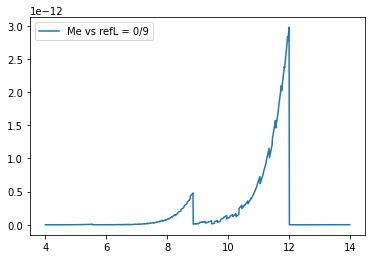

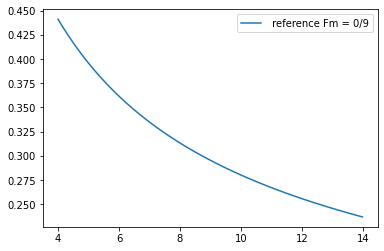

#################################################
17 9 0 Me vs ref 2.9801716650013077e-12 # 
17 9 0 Me vs Seg 0.0 
#################################################
Error at  17 9 0  is  1.2346273532943397e-16


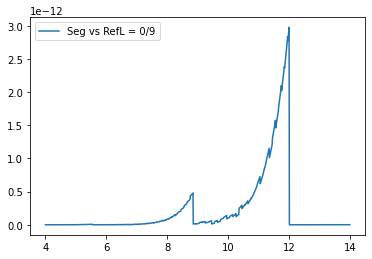

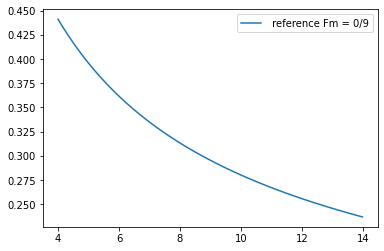

#################################################
17 9 0 Seg vs Ref 2.9801716650013077e-12 # 

17 9 1 Me vs ref 1.2409691330095285e-13 
17 9 1 Me vs Seg 0.0 
17 9 1 Seg vs Ref 1.2409691330095285e-13 

17 9 2 Me vs ref 1.5557650653863497e-14 
17 9 2 Me vs Seg 0.0 
17 9 2 Seg vs Ref 1.5557650653863497e-14 

17 9 3 Me vs ref 3.18890963982299e-15 
17 9 3 Me vs Seg 0.0 
17 9 3 Seg vs Ref 3.18890963982299e-15 

17 9 4 Me vs ref 9.561307908606542e-16 
17 9 4 Me vs Seg 0.0 
17 9 4 Seg vs Ref 9.561307908606542e-16 

17 9 5 Me vs ref 3.369192132316595e-16 
17 9 5 Me vs Seg 0.0 
17 9 5 Seg vs Ref 3.369192132316595e-16 

17 9 6 Me vs ref 1.9072810279914532e-16 
17 9 6 Me vs Seg 0.0 
17 9 6 Seg vs Ref 1.9072810279914532e-16 

17 9 7 Me vs ref 1.127231446206023e-16 
17 9 7 Me vs Seg 0.0 
17 9 7 Seg vs Ref 1.127231446206023e-16 

17 9 8 Me vs ref 2.041755978697546e-16 
17 9 8 Me vs Seg 0.0 
17 9 8 Seg vs Ref 2.041755978697546e-16 

17 9 9 Me vs ref 1.1075125191939428e-16 
17 9 9 Me vs Seg 0.0 
17 9 9

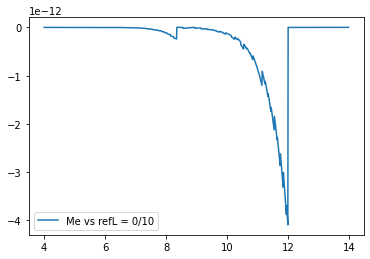

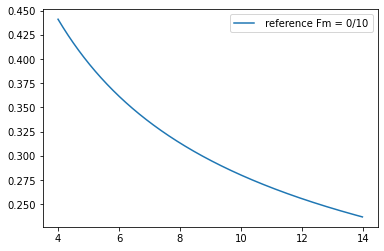

#################################################
17 10 0 Me vs ref 4.092226557617096e-12 # 
17 10 0 Me vs Seg 0.0 
#################################################
Error at  17 10 0  is  1.2346273532943397e-16


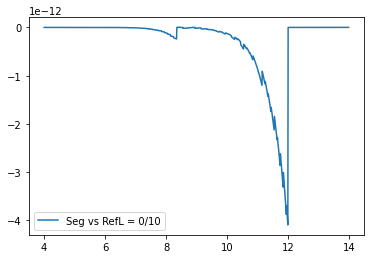

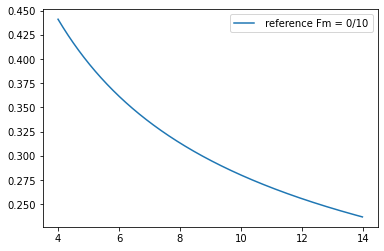

#################################################
17 10 0 Seg vs Ref 4.092226557617096e-12 # 

17 10 1 Me vs ref 1.7063433999098265e-13 
17 10 1 Me vs Seg 0.0 
17 10 1 Seg vs Ref 1.7063433999098265e-13 

17 10 2 Me vs ref 2.1289610699359862e-14 
17 10 2 Me vs Seg 0.0 
17 10 2 Seg vs Ref 2.1289610699359862e-14 

17 10 3 Me vs ref 4.48886804463311e-15 
17 10 3 Me vs Seg 0.0 
17 10 3 Seg vs Ref 4.48886804463311e-15 

17 10 4 Me vs ref 1.2835869520055887e-15 
17 10 4 Me vs Seg 0.0 
17 10 4 Seg vs Ref 1.2835869520055887e-15 

17 10 5 Me vs ref 5.031104656147423e-16 
17 10 5 Me vs Seg 0.0 
17 10 5 Seg vs Ref 5.031104656147423e-16 

17 10 6 Me vs ref 1.9510048687287201e-16 
17 10 6 Me vs Seg 0.0 
17 10 6 Seg vs Ref 1.9510048687287201e-16 

17 10 7 Me vs ref 2.1514128640490876e-16 
17 10 7 Me vs Seg 0.0 
17 10 7 Seg vs Ref 2.1514128640490876e-16 

17 10 8 Me vs ref 1.0728095793449341e-16 
17 10 8 Me vs Seg 0.0 
17 10 8 Seg vs Ref 1.0728095793449341e-16 

17 10 9 Me vs ref 1.4288429380643342e-1

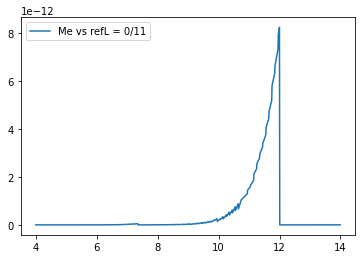

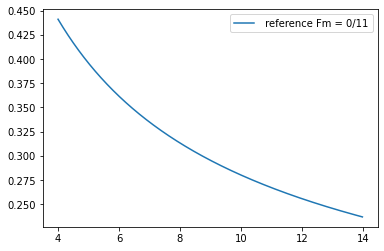

#################################################
17 11 0 Me vs ref 8.238909554592055e-12 # 
17 11 0 Me vs Seg 0.0 
#################################################
Error at  17 11 0  is  1.2346273532943397e-16


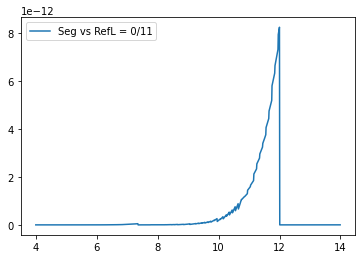

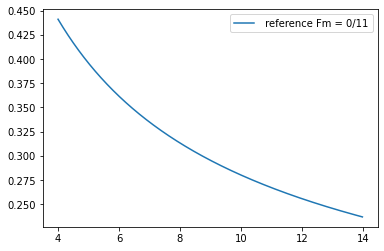

#################################################
17 11 0 Seg vs Ref 8.238909554592055e-12 # 

17 11 1 Me vs ref 3.4324799946805484e-13 
17 11 1 Me vs Seg 0.0 
17 11 1 Seg vs Ref 3.4324799946805484e-13 

17 11 2 Me vs ref 4.2956090073875686e-14 
17 11 2 Me vs Seg 0.0 
17 11 2 Seg vs Ref 4.2956090073875686e-14 

17 11 3 Me vs ref 8.897830389154038e-15 
17 11 3 Me vs Seg 0.0 
17 11 3 Seg vs Ref 8.897830389154038e-15 

17 11 4 Me vs ref 2.621492432852701e-15 
17 11 4 Me vs Seg 0.0 
17 11 4 Seg vs Ref 2.621492432852701e-15 

17 11 5 Me vs ref 9.615348610641367e-16 
17 11 5 Me vs Seg 0.0 
17 11 5 Seg vs Ref 9.615348610641367e-16 

17 11 6 Me vs ref 4.771573761108705e-16 
17 11 6 Me vs Seg 0.0 
17 11 6 Seg vs Ref 4.771573761108705e-16 

17 11 7 Me vs ref 2.3406146134772807e-16 
17 11 7 Me vs Seg 0.0 
17 11 7 Seg vs Ref 2.3406146134772807e-16 

17 11 8 Me vs ref 2.0680394110508468e-16 
17 11 8 Me vs Seg 0.0 
17 11 8 Seg vs Ref 2.0680394110508468e-16 

17 11 9 Me vs ref 1.0428352009239725e-16 

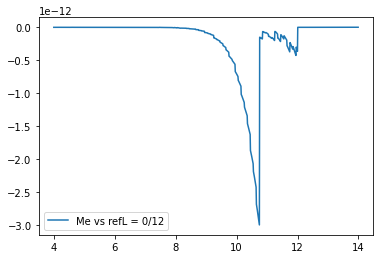

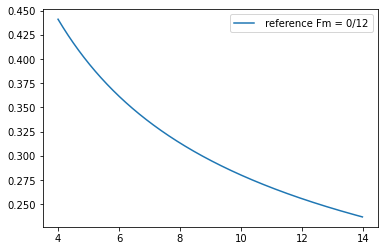

#################################################
17 12 0 Me vs ref 3.0024871477962733e-12 # 
17 12 0 Me vs Seg 0.0 
#################################################
Error at  17 12 0  is  1.2346273532943397e-16


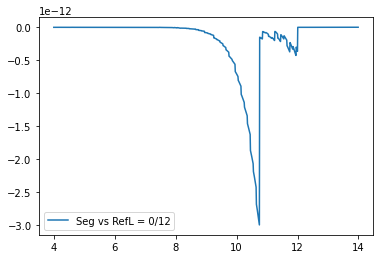

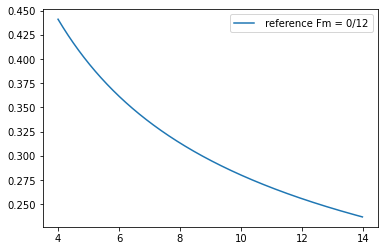

#################################################
17 12 0 Seg vs Ref 3.0024871477962733e-12 # 

17 12 1 Me vs ref 1.3968340373260446e-13 
17 12 1 Me vs Seg 0.0 
17 12 1 Seg vs Ref 1.3968340373260446e-13 

17 12 2 Me vs ref 1.943345658006468e-14 
17 12 2 Me vs Seg 0.0 
17 12 2 Seg vs Ref 1.943345658006468e-14 

17 12 3 Me vs ref 4.642120021713936e-15 
17 12 3 Me vs Seg 0.0 
17 12 3 Seg vs Ref 4.642120021713936e-15 

17 12 4 Me vs ref 1.421117997585375e-15 
17 12 4 Me vs Seg 0.0 
17 12 4 Seg vs Ref 1.421117997585375e-15 

17 12 5 Me vs ref 6.816311295780586e-16 
17 12 5 Me vs Seg 0.0 
17 12 5 Seg vs Ref 6.816311295780586e-16 

17 12 6 Me vs ref 3.0536893001233134e-16 
17 12 6 Me vs Seg 0.0 
17 12 6 Seg vs Ref 3.0536893001233134e-16 

17 12 7 Me vs ref 2.3753006126673443e-16 
17 12 7 Me vs Seg 0.0 
17 12 7 Seg vs Ref 2.3753006126673443e-16 

17 12 8 Me vs ref 1.1363455207184792e-16 
17 12 8 Me vs Seg 0.0 
17 12 8 Seg vs Ref 1.1363455207184792e-16 

17 12 9 Me vs ref 1.2217603231196028e-16

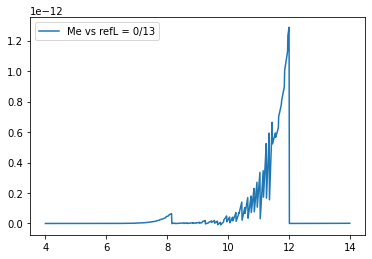

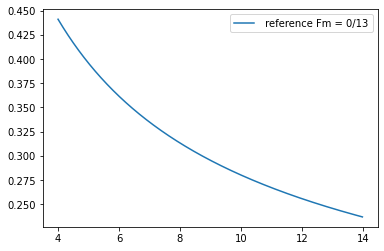

#################################################
17 13 0 Me vs ref 1.2879142197164128e-12 # 
17 13 0 Me vs Seg 0.0 
#################################################
Error at  17 13 0  is  1.2346273532943397e-16


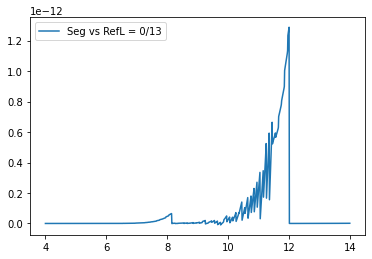

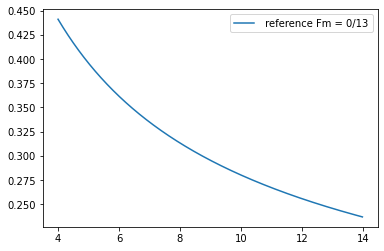

#################################################
17 13 0 Seg vs Ref 1.2879142197164128e-12 # 

17 13 1 Me vs ref 5.357519983206771e-14 
17 13 1 Me vs Seg 0.0 
17 13 1 Seg vs Ref 5.357519983206771e-14 

17 13 2 Me vs ref 6.740918587211375e-15 
17 13 2 Me vs Seg 0.0 
17 13 2 Seg vs Ref 6.740918587211375e-15 

17 13 3 Me vs ref 1.351783268654927e-15 
17 13 3 Me vs Seg 0.0 
17 13 3 Seg vs Ref 1.351783268654927e-15 

17 13 4 Me vs ref 4.224593765089768e-16 
17 13 4 Me vs Seg 0.0 
17 13 4 Seg vs Ref 4.224593765089768e-16 

17 13 5 Me vs ref 1.3723627811414174e-16 
17 13 5 Me vs Seg 0.0 
17 13 5 Seg vs Ref 1.3723627811414174e-16 

17 13 6 Me vs ref 1.1897763590312804e-16 
17 13 6 Me vs Seg 0.0 
17 13 6 Seg vs Ref 1.1897763590312804e-16 

17 13 7 Me vs ref 1.0560129160008813e-16 
17 13 7 Me vs Seg 0.0 
17 13 7 Seg vs Ref 1.0560129160008813e-16 

17 13 8 Me vs ref 1.0728095793449341e-16 
17 13 8 Me vs Seg 0.0 
17 13 8 Seg vs Ref 1.0728095793449341e-16 

17 13 9 Me vs ref 1.0428352009239725e-16

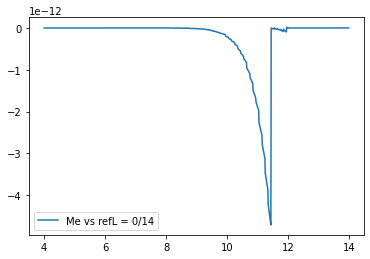

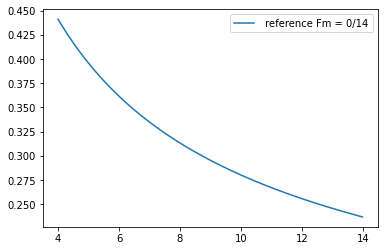

#################################################
17 14 0 Me vs ref 4.70939953700622e-12 # 
17 14 0 Me vs Seg 0.0 
#################################################
Error at  17 14 0  is  1.2346273532943397e-16


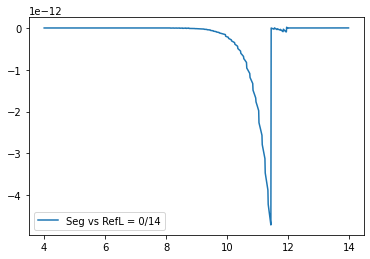

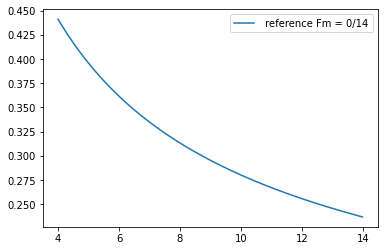

#################################################
17 14 0 Seg vs Ref 4.70939953700622e-12 # 

17 14 1 Me vs ref 2.0584575710635988e-13 
17 14 1 Me vs Seg 0.0 
17 14 1 Seg vs Ref 2.0584575710635988e-13 

17 14 2 Me vs ref 2.696757747666645e-14 
17 14 2 Me vs Seg 0.0 
17 14 2 Seg vs Ref 2.696757747666645e-14 

17 14 3 Me vs ref 5.917304406882762e-15 
17 14 3 Me vs Seg 0.0 
17 14 3 Seg vs Ref 5.917304406882762e-15 

17 14 4 Me vs ref 1.701235181374161e-15 
17 14 4 Me vs Seg 0.0 
17 14 4 Seg vs Ref 1.701235181374161e-15 

17 14 5 Me vs ref 8.192367140572032e-16 
17 14 5 Me vs Seg 0.0 
17 14 5 Seg vs Ref 8.192367140572032e-16 

17 14 6 Me vs ref 3.245084864884895e-16 
17 14 6 Me vs Seg 0.0 
17 14 6 Seg vs Ref 3.245084864884895e-16 

17 14 7 Me vs ref 2.7412866085169824e-16 
17 14 7 Me vs Seg 0.0 
17 14 7 Seg vs Ref 2.7412866085169824e-16 

17 14 8 Me vs ref 1.0728095793449341e-16 
17 14 8 Me vs Seg 0.0 
17 14 8 Seg vs Ref 1.0728095793449341e-16 

17 14 9 Me vs ref 1.2060478619480355e-16 
17

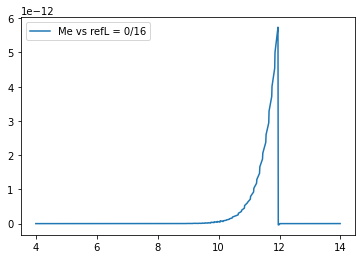

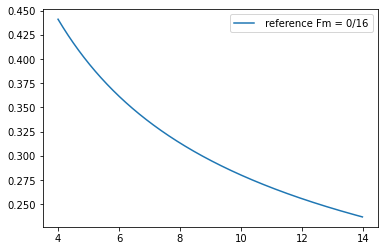

#################################################
17 16 0 Me vs ref 5.736688901691878e-12 # 
17 16 0 Me vs Seg 0.0 
#################################################
Error at  17 16 0  is  1.2346273532943397e-16


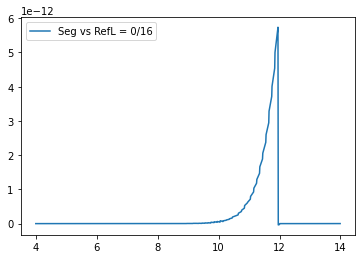

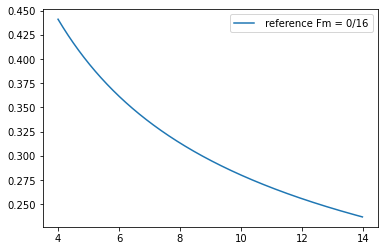

#################################################
17 16 0 Seg vs Ref 5.736688901691878e-12 # 

17 16 1 Me vs ref 2.3996256370839575e-13 
17 16 1 Me vs Seg 0.0 
17 16 1 Seg vs Ref 2.3996256370839575e-13 

17 16 2 Me vs ref 3.0163805481153716e-14 
17 16 2 Me vs Seg 0.0 
17 16 2 Seg vs Ref 3.0163805481153716e-14 

17 16 3 Me vs ref 6.2619180674072794e-15 
17 16 3 Me vs Seg 0.0 
17 16 3 Seg vs Ref 6.2619180674072794e-15 

17 16 4 Me vs ref 1.865261417544062e-15 
17 16 4 Me vs Seg 0.0 
17 16 4 Seg vs Ref 1.865261417544062e-15 

17 16 5 Me vs ref 6.807773203672263e-16 
17 16 5 Me vs Seg 0.0 
17 16 5 Seg vs Ref 6.807773203672263e-16 

17 16 6 Me vs ref 3.479611347320666e-16 
17 16 6 Me vs Seg 0.0 
17 16 6 Seg vs Ref 3.479611347320666e-16 

17 16 7 Me vs ref 1.6620395787729156e-16 
17 16 7 Me vs Seg 0.0 
17 16 7 Seg vs Ref 1.6620395787729156e-16 

17 16 8 Me vs ref 1.6045683933017113e-16 
17 16 8 Me vs Seg 0.0 
17 16 8 Seg vs Ref 1.6045683933017113e-16 

17 16 9 Me vs ref 1.0428352009239725e-1

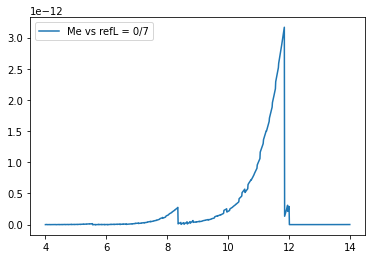

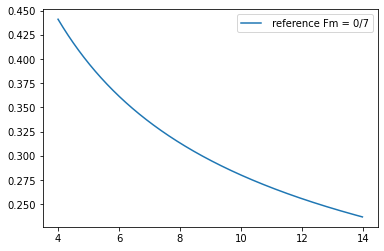

#################################################
18 7 0 Me vs ref 3.165356865508784e-12 # 
18 7 0 Me vs Seg 0.0 
#################################################
Error at  18 7 0  is  1.2346273532943397e-16


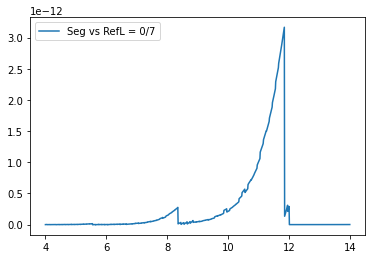

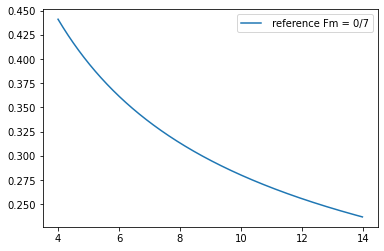

#################################################
18 7 0 Seg vs Ref 3.165356865508784e-12 # 

18 7 1 Me vs ref 1.3357544237369012e-13 
18 7 1 Me vs Seg 0.0 
18 7 1 Seg vs Ref 1.3357544237369012e-13 

18 7 2 Me vs ref 1.6952802009417844e-14 
18 7 2 Me vs Seg 0.0 
18 7 2 Seg vs Ref 1.6952802009417844e-14 

18 7 3 Me vs ref 3.5335233003475075e-15 
18 7 3 Me vs Seg 0.0 
18 7 3 Seg vs Ref 3.5335233003475075e-15 

18 7 4 Me vs ref 1.0686709763646496e-15 
18 7 4 Me vs Seg 0.0 
18 7 4 Seg vs Ref 1.0686709763646496e-15 

18 7 5 Me vs ref 3.885441773009146e-16 
18 7 5 Me vs Seg 0.0 
18 7 5 Seg vs Ref 3.885441773009146e-16 

18 7 6 Me vs ref 2.124528038303236e-16 
18 7 6 Me vs Seg 0.0 
18 7 6 Seg vs Ref 2.124528038303236e-16 

18 7 7 Me vs ref 1.2240642527361345e-16 
18 7 7 Me vs Seg 0.0 
18 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  18 8 0  is  1.2346273532943397e-16


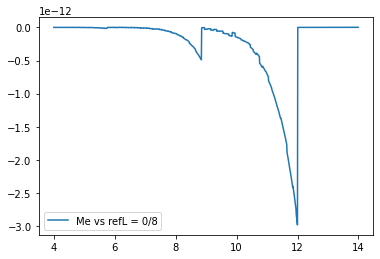

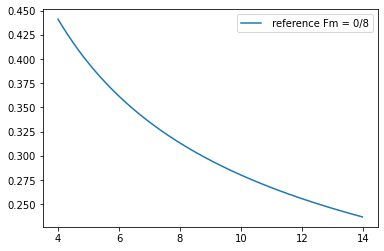

#################################################
18 8 0 Me vs ref 2.9816149549333204e-12 # 
18 8 0 Me vs Seg 0.0 
#################################################
Error at  18 8 0  is  1.2346273532943397e-16


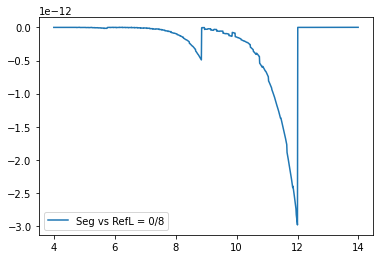

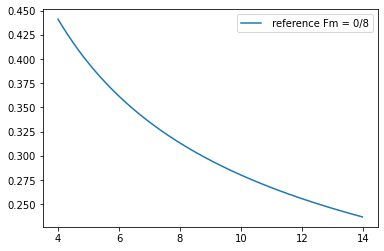

#################################################
18 8 0 Seg vs Ref 2.9816149549333204e-12 # 

18 8 1 Me vs ref 1.2435018292844546e-13 
18 8 1 Me vs Seg 0.0 
18 8 1 Seg vs Ref 1.2435018292844546e-13 

18 8 2 Me vs ref 1.5503223704804725e-14 
18 8 2 Me vs Seg 0.0 
18 8 2 Seg vs Ref 1.5503223704804725e-14 

18 8 3 Me vs ref 3.2831810187206045e-15 
18 8 3 Me vs Seg 0.0 
18 8 3 Seg vs Ref 3.2831810187206045e-15 

18 8 4 Me vs ref 9.31871767251291e-16 
18 8 4 Me vs Seg 0.0 
18 8 4 Seg vs Ref 9.31871767251291e-16 

18 8 5 Me vs ref 3.7119694254114655e-16 
18 8 5 Me vs Seg 0.0 
18 8 5 Seg vs Ref 3.7119694254114655e-16 

18 8 6 Me vs ref 1.4072944198861848e-16 
18 8 6 Me vs Seg 0.0 
18 8 6 Seg vs Ref 1.4072944198861848e-16 

18 8 7 Me vs ref 1.8633877806647353e-16 
18 8 7 Me vs Seg 0.0 
18 8 7 Seg vs Ref 1.8633877806647353e-16 

18 8 8 Me vs ref 1.0728095793449341e-16 
18 8 8 Me vs Seg 0.0 
18 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

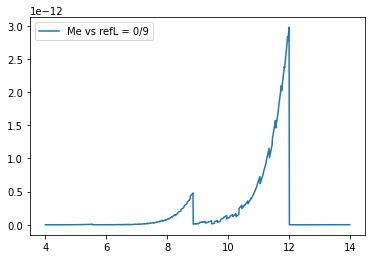

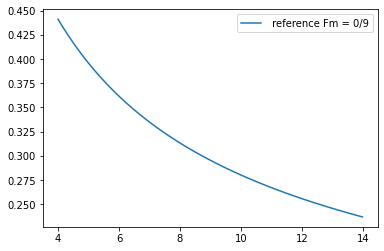

#################################################
18 9 0 Me vs ref 2.9801716650013077e-12 # 
18 9 0 Me vs Seg 0.0 
#################################################
Error at  18 9 0  is  1.2346273532943397e-16


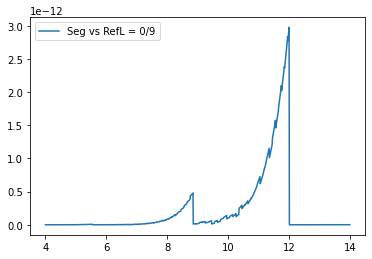

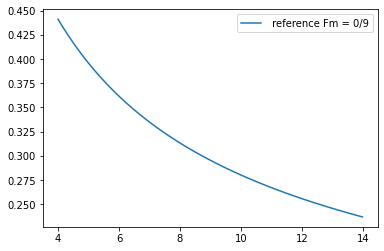

#################################################
18 9 0 Seg vs Ref 2.9801716650013077e-12 # 

18 9 1 Me vs ref 1.2409691330095285e-13 
18 9 1 Me vs Seg 0.0 
18 9 1 Seg vs Ref 1.2409691330095285e-13 

18 9 2 Me vs ref 1.5557650653863497e-14 
18 9 2 Me vs Seg 0.0 
18 9 2 Seg vs Ref 1.5557650653863497e-14 

18 9 3 Me vs ref 3.18890963982299e-15 
18 9 3 Me vs Seg 0.0 
18 9 3 Seg vs Ref 3.18890963982299e-15 

18 9 4 Me vs ref 9.561307908606542e-16 
18 9 4 Me vs Seg 0.0 
18 9 4 Seg vs Ref 9.561307908606542e-16 

18 9 5 Me vs ref 3.369192132316595e-16 
18 9 5 Me vs Seg 0.0 
18 9 5 Seg vs Ref 3.369192132316595e-16 

18 9 6 Me vs ref 1.9072810279914532e-16 
18 9 6 Me vs Seg 0.0 
18 9 6 Seg vs Ref 1.9072810279914532e-16 

18 9 7 Me vs ref 1.127231446206023e-16 
18 9 7 Me vs Seg 0.0 
18 9 7 Seg vs Ref 1.127231446206023e-16 

18 9 8 Me vs ref 2.041755978697546e-16 
18 9 8 Me vs Seg 0.0 
18 9 8 Seg vs Ref 2.041755978697546e-16 

18 9 9 Me vs ref 1.1075125191939428e-16 
18 9 9 Me vs Seg 0.0 
18 9 9

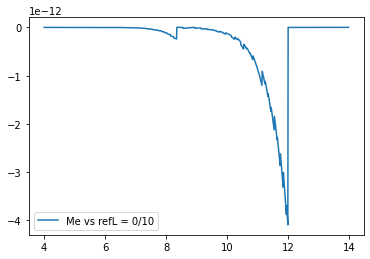

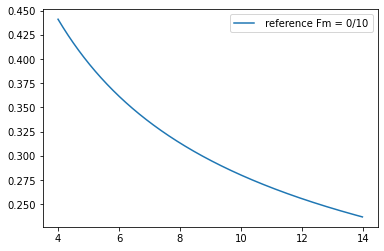

#################################################
18 10 0 Me vs ref 4.092226557617096e-12 # 
18 10 0 Me vs Seg 0.0 
#################################################
Error at  18 10 0  is  1.2346273532943397e-16


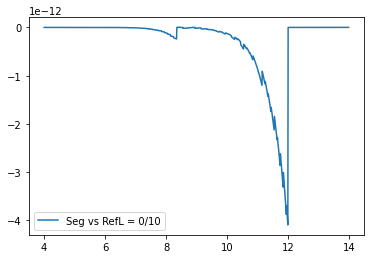

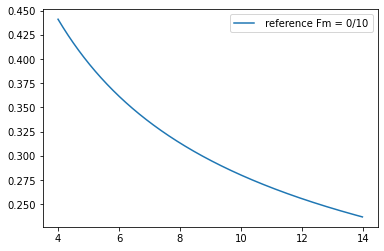

#################################################
18 10 0 Seg vs Ref 4.092226557617096e-12 # 

18 10 1 Me vs ref 1.7063433999098265e-13 
18 10 1 Me vs Seg 0.0 
18 10 1 Seg vs Ref 1.7063433999098265e-13 

18 10 2 Me vs ref 2.1289610699359862e-14 
18 10 2 Me vs Seg 0.0 
18 10 2 Seg vs Ref 2.1289610699359862e-14 

18 10 3 Me vs ref 4.48886804463311e-15 
18 10 3 Me vs Seg 0.0 
18 10 3 Seg vs Ref 4.48886804463311e-15 

18 10 4 Me vs ref 1.2835869520055887e-15 
18 10 4 Me vs Seg 0.0 
18 10 4 Seg vs Ref 1.2835869520055887e-15 

18 10 5 Me vs ref 5.031104656147423e-16 
18 10 5 Me vs Seg 0.0 
18 10 5 Seg vs Ref 5.031104656147423e-16 

18 10 6 Me vs ref 1.9510048687287201e-16 
18 10 6 Me vs Seg 0.0 
18 10 6 Seg vs Ref 1.9510048687287201e-16 

18 10 7 Me vs ref 2.1514128640490876e-16 
18 10 7 Me vs Seg 0.0 
18 10 7 Seg vs Ref 2.1514128640490876e-16 

18 10 8 Me vs ref 1.0728095793449341e-16 
18 10 8 Me vs Seg 0.0 
18 10 8 Seg vs Ref 1.0728095793449341e-16 

18 10 9 Me vs ref 1.4288429380643342e-1

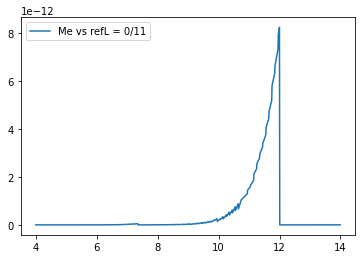

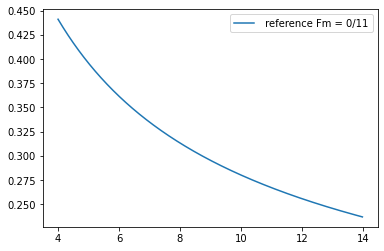

#################################################
18 11 0 Me vs ref 8.238909554592055e-12 # 
18 11 0 Me vs Seg 0.0 
#################################################
Error at  18 11 0  is  1.2346273532943397e-16


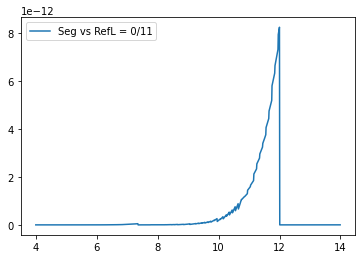

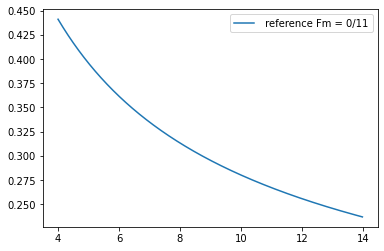

#################################################
18 11 0 Seg vs Ref 8.238909554592055e-12 # 

18 11 1 Me vs ref 3.4324799946805484e-13 
18 11 1 Me vs Seg 0.0 
18 11 1 Seg vs Ref 3.4324799946805484e-13 

18 11 2 Me vs ref 4.2956090073875686e-14 
18 11 2 Me vs Seg 0.0 
18 11 2 Seg vs Ref 4.2956090073875686e-14 

18 11 3 Me vs ref 8.897830389154038e-15 
18 11 3 Me vs Seg 0.0 
18 11 3 Seg vs Ref 8.897830389154038e-15 

18 11 4 Me vs ref 2.621492432852701e-15 
18 11 4 Me vs Seg 0.0 
18 11 4 Seg vs Ref 2.621492432852701e-15 

18 11 5 Me vs ref 9.615348610641367e-16 
18 11 5 Me vs Seg 0.0 
18 11 5 Seg vs Ref 9.615348610641367e-16 

18 11 6 Me vs ref 4.771573761108705e-16 
18 11 6 Me vs Seg 0.0 
18 11 6 Seg vs Ref 4.771573761108705e-16 

18 11 7 Me vs ref 2.3406146134772807e-16 
18 11 7 Me vs Seg 0.0 
18 11 7 Seg vs Ref 2.3406146134772807e-16 

18 11 8 Me vs ref 2.0680394110508468e-16 
18 11 8 Me vs Seg 0.0 
18 11 8 Seg vs Ref 2.0680394110508468e-16 

18 11 9 Me vs ref 1.0428352009239725e-16 

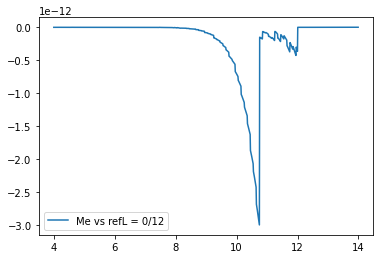

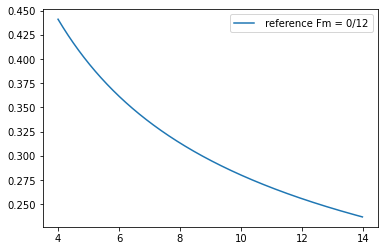

#################################################
18 12 0 Me vs ref 3.0024871477962733e-12 # 
18 12 0 Me vs Seg 0.0 
#################################################
Error at  18 12 0  is  1.2346273532943397e-16


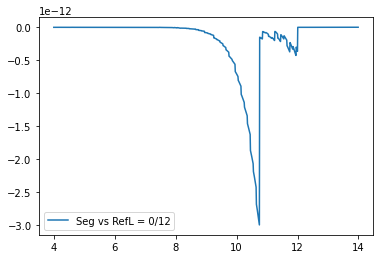

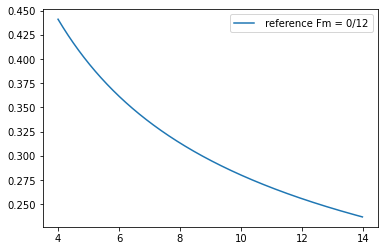

#################################################
18 12 0 Seg vs Ref 3.0024871477962733e-12 # 

18 12 1 Me vs ref 1.3968340373260446e-13 
18 12 1 Me vs Seg 0.0 
18 12 1 Seg vs Ref 1.3968340373260446e-13 

18 12 2 Me vs ref 1.943345658006468e-14 
18 12 2 Me vs Seg 0.0 
18 12 2 Seg vs Ref 1.943345658006468e-14 

18 12 3 Me vs ref 4.642120021713936e-15 
18 12 3 Me vs Seg 0.0 
18 12 3 Seg vs Ref 4.642120021713936e-15 

18 12 4 Me vs ref 1.421117997585375e-15 
18 12 4 Me vs Seg 0.0 
18 12 4 Seg vs Ref 1.421117997585375e-15 

18 12 5 Me vs ref 6.816311295780586e-16 
18 12 5 Me vs Seg 0.0 
18 12 5 Seg vs Ref 6.816311295780586e-16 

18 12 6 Me vs ref 3.0536893001233134e-16 
18 12 6 Me vs Seg 0.0 
18 12 6 Seg vs Ref 3.0536893001233134e-16 

18 12 7 Me vs ref 2.3753006126673443e-16 
18 12 7 Me vs Seg 0.0 
18 12 7 Seg vs Ref 2.3753006126673443e-16 

18 12 8 Me vs ref 1.1363455207184792e-16 
18 12 8 Me vs Seg 0.0 
18 12 8 Seg vs Ref 1.1363455207184792e-16 

18 12 9 Me vs ref 1.2217603231196028e-16

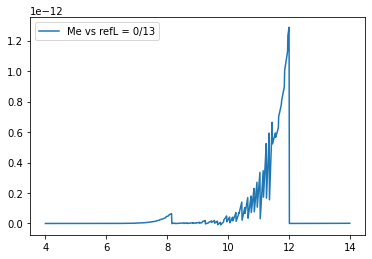

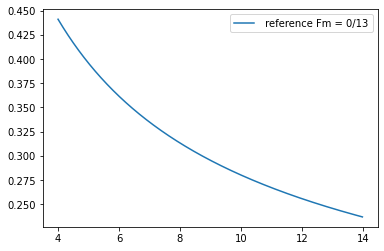

#################################################
18 13 0 Me vs ref 1.2879142197164128e-12 # 
18 13 0 Me vs Seg 0.0 
#################################################
Error at  18 13 0  is  1.2346273532943397e-16


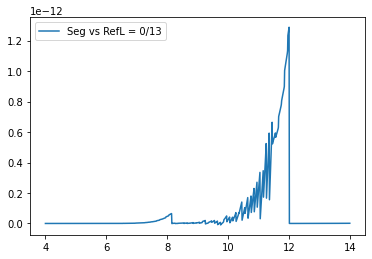

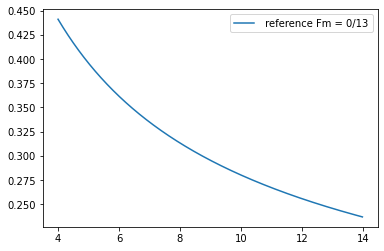

#################################################
18 13 0 Seg vs Ref 1.2879142197164128e-12 # 

18 13 1 Me vs ref 5.357519983206771e-14 
18 13 1 Me vs Seg 0.0 
18 13 1 Seg vs Ref 5.357519983206771e-14 

18 13 2 Me vs ref 6.740918587211375e-15 
18 13 2 Me vs Seg 0.0 
18 13 2 Seg vs Ref 6.740918587211375e-15 

18 13 3 Me vs ref 1.351783268654927e-15 
18 13 3 Me vs Seg 0.0 
18 13 3 Seg vs Ref 1.351783268654927e-15 

18 13 4 Me vs ref 4.224593765089768e-16 
18 13 4 Me vs Seg 0.0 
18 13 4 Seg vs Ref 4.224593765089768e-16 

18 13 5 Me vs ref 1.3723627811414174e-16 
18 13 5 Me vs Seg 0.0 
18 13 5 Seg vs Ref 1.3723627811414174e-16 

18 13 6 Me vs ref 1.1897763590312804e-16 
18 13 6 Me vs Seg 0.0 
18 13 6 Seg vs Ref 1.1897763590312804e-16 

18 13 7 Me vs ref 1.0560129160008813e-16 
18 13 7 Me vs Seg 0.0 
18 13 7 Seg vs Ref 1.0560129160008813e-16 

18 13 8 Me vs ref 1.0728095793449341e-16 
18 13 8 Me vs Seg 0.0 
18 13 8 Seg vs Ref 1.0728095793449341e-16 

18 13 9 Me vs ref 1.0428352009239725e-16

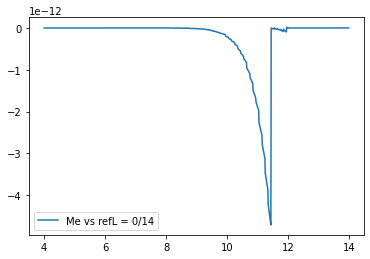

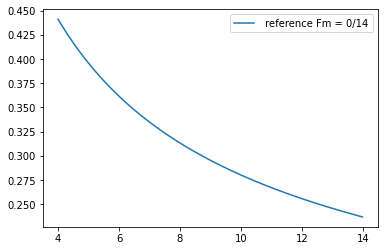

#################################################
18 14 0 Me vs ref 4.70939953700622e-12 # 
18 14 0 Me vs Seg 0.0 
#################################################
Error at  18 14 0  is  1.2346273532943397e-16


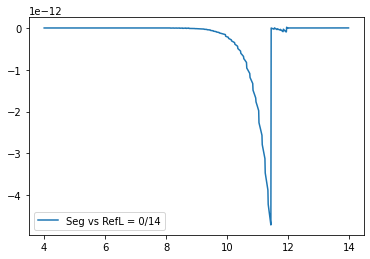

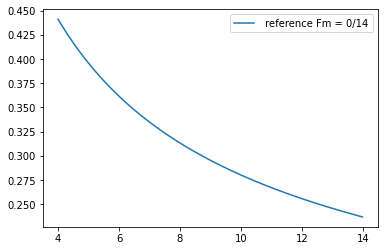

#################################################
18 14 0 Seg vs Ref 4.70939953700622e-12 # 

18 14 1 Me vs ref 2.0584575710635988e-13 
18 14 1 Me vs Seg 0.0 
18 14 1 Seg vs Ref 2.0584575710635988e-13 

18 14 2 Me vs ref 2.696757747666645e-14 
18 14 2 Me vs Seg 0.0 
18 14 2 Seg vs Ref 2.696757747666645e-14 

18 14 3 Me vs ref 5.917304406882762e-15 
18 14 3 Me vs Seg 0.0 
18 14 3 Seg vs Ref 5.917304406882762e-15 

18 14 4 Me vs ref 1.701235181374161e-15 
18 14 4 Me vs Seg 0.0 
18 14 4 Seg vs Ref 1.701235181374161e-15 

18 14 5 Me vs ref 8.192367140572032e-16 
18 14 5 Me vs Seg 0.0 
18 14 5 Seg vs Ref 8.192367140572032e-16 

18 14 6 Me vs ref 3.245084864884895e-16 
18 14 6 Me vs Seg 0.0 
18 14 6 Seg vs Ref 3.245084864884895e-16 

18 14 7 Me vs ref 2.7412866085169824e-16 
18 14 7 Me vs Seg 0.0 
18 14 7 Seg vs Ref 2.7412866085169824e-16 

18 14 8 Me vs ref 1.0728095793449341e-16 
18 14 8 Me vs Seg 0.0 
18 14 8 Seg vs Ref 1.0728095793449341e-16 

18 14 9 Me vs ref 1.2060478619480355e-16 
18

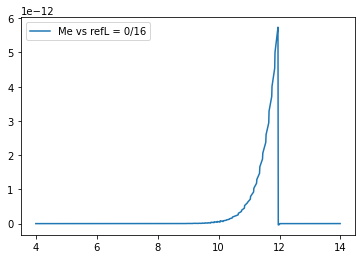

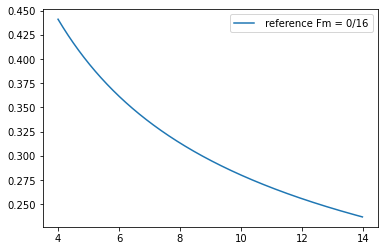

#################################################
18 16 0 Me vs ref 5.736688901691878e-12 # 
18 16 0 Me vs Seg 0.0 
#################################################
Error at  18 16 0  is  1.2346273532943397e-16


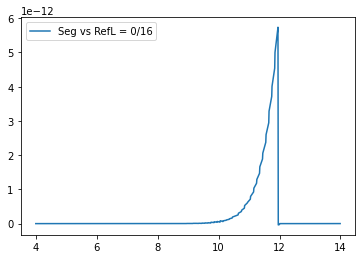

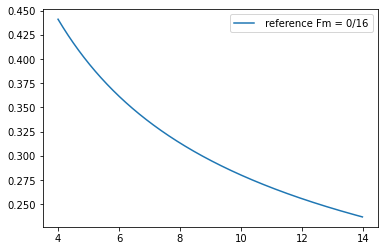

#################################################
18 16 0 Seg vs Ref 5.736688901691878e-12 # 

18 16 1 Me vs ref 2.3996256370839575e-13 
18 16 1 Me vs Seg 0.0 
18 16 1 Seg vs Ref 2.3996256370839575e-13 

18 16 2 Me vs ref 3.0163805481153716e-14 
18 16 2 Me vs Seg 0.0 
18 16 2 Seg vs Ref 3.0163805481153716e-14 

18 16 3 Me vs ref 6.2619180674072794e-15 
18 16 3 Me vs Seg 0.0 
18 16 3 Seg vs Ref 6.2619180674072794e-15 

18 16 4 Me vs ref 1.865261417544062e-15 
18 16 4 Me vs Seg 0.0 
18 16 4 Seg vs Ref 1.865261417544062e-15 

18 16 5 Me vs ref 6.807773203672263e-16 
18 16 5 Me vs Seg 0.0 
18 16 5 Seg vs Ref 6.807773203672263e-16 

18 16 6 Me vs ref 3.479611347320666e-16 
18 16 6 Me vs Seg 0.0 
18 16 6 Seg vs Ref 3.479611347320666e-16 

18 16 7 Me vs ref 1.6620395787729156e-16 
18 16 7 Me vs Seg 0.0 
18 16 7 Seg vs Ref 1.6620395787729156e-16 

18 16 8 Me vs ref 1.6045683933017113e-16 
18 16 8 Me vs Seg 0.0 
18 16 8 Seg vs Ref 1.6045683933017113e-16 

18 16 9 Me vs ref 1.0428352009239725e-1

#################################################
Error at  19 7 0  is  1.2346273532943397e-16


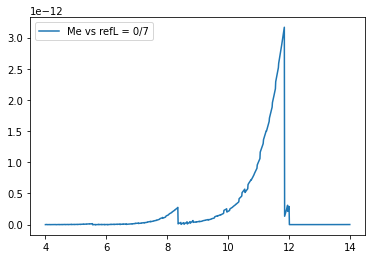

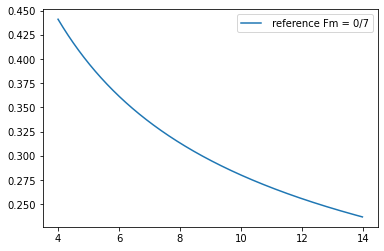

#################################################
19 7 0 Me vs ref 3.165356865508784e-12 # 
19 7 0 Me vs Seg 0.0 
#################################################
Error at  19 7 0  is  1.2346273532943397e-16


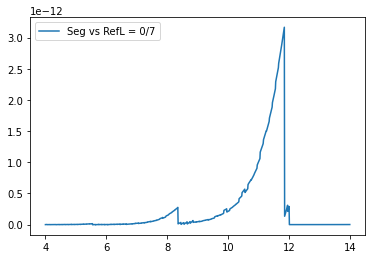

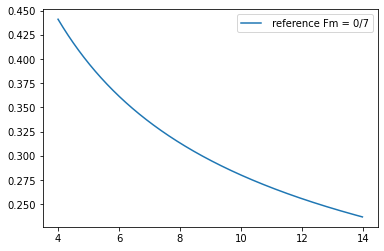

#################################################
19 7 0 Seg vs Ref 3.165356865508784e-12 # 

19 7 1 Me vs ref 1.3357544237369012e-13 
19 7 1 Me vs Seg 0.0 
19 7 1 Seg vs Ref 1.3357544237369012e-13 

19 7 2 Me vs ref 1.6952802009417844e-14 
19 7 2 Me vs Seg 0.0 
19 7 2 Seg vs Ref 1.6952802009417844e-14 

19 7 3 Me vs ref 3.5335233003475075e-15 
19 7 3 Me vs Seg 0.0 
19 7 3 Seg vs Ref 3.5335233003475075e-15 

19 7 4 Me vs ref 1.0686709763646496e-15 
19 7 4 Me vs Seg 0.0 
19 7 4 Seg vs Ref 1.0686709763646496e-15 

19 7 5 Me vs ref 3.885441773009146e-16 
19 7 5 Me vs Seg 0.0 
19 7 5 Seg vs Ref 3.885441773009146e-16 

19 7 6 Me vs ref 2.124528038303236e-16 
19 7 6 Me vs Seg 0.0 
19 7 6 Seg vs Ref 2.124528038303236e-16 

19 7 7 Me vs ref 1.2240642527361345e-16 
19 7 7 Me vs Seg 0.0 
19 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  19 8 0  is  1.2346273532943397e-16


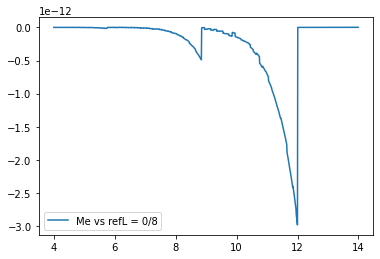

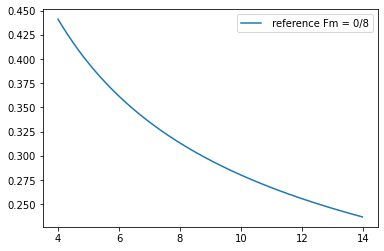

#################################################
19 8 0 Me vs ref 2.9816149549333204e-12 # 
19 8 0 Me vs Seg 0.0 
#################################################
Error at  19 8 0  is  1.2346273532943397e-16


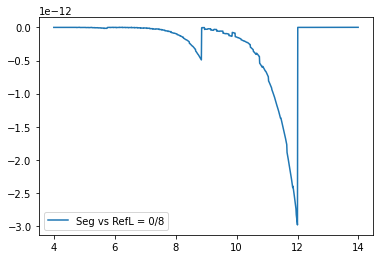

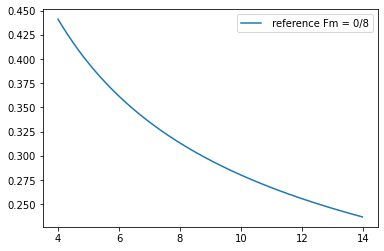

#################################################
19 8 0 Seg vs Ref 2.9816149549333204e-12 # 

19 8 1 Me vs ref 1.2435018292844546e-13 
19 8 1 Me vs Seg 0.0 
19 8 1 Seg vs Ref 1.2435018292844546e-13 

19 8 2 Me vs ref 1.5503223704804725e-14 
19 8 2 Me vs Seg 0.0 
19 8 2 Seg vs Ref 1.5503223704804725e-14 

19 8 3 Me vs ref 3.2831810187206045e-15 
19 8 3 Me vs Seg 0.0 
19 8 3 Seg vs Ref 3.2831810187206045e-15 

19 8 4 Me vs ref 9.31871767251291e-16 
19 8 4 Me vs Seg 0.0 
19 8 4 Seg vs Ref 9.31871767251291e-16 

19 8 5 Me vs ref 3.7119694254114655e-16 
19 8 5 Me vs Seg 0.0 
19 8 5 Seg vs Ref 3.7119694254114655e-16 

19 8 6 Me vs ref 1.4072944198861848e-16 
19 8 6 Me vs Seg 0.0 
19 8 6 Seg vs Ref 1.4072944198861848e-16 

19 8 7 Me vs ref 1.8633877806647353e-16 
19 8 7 Me vs Seg 0.0 
19 8 7 Seg vs Ref 1.8633877806647353e-16 

19 8 8 Me vs ref 1.0728095793449341e-16 
19 8 8 Me vs Seg 0.0 
19 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  1

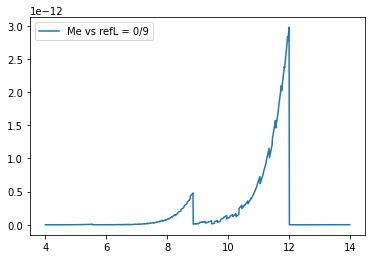

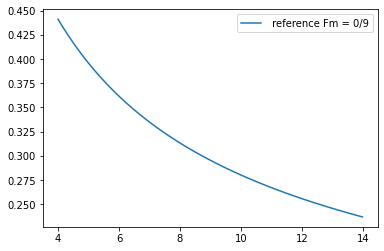

#################################################
19 9 0 Me vs ref 2.9801716650013077e-12 # 
19 9 0 Me vs Seg 0.0 
#################################################
Error at  19 9 0  is  1.2346273532943397e-16


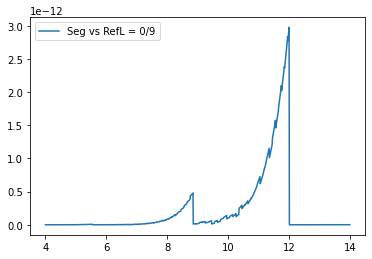

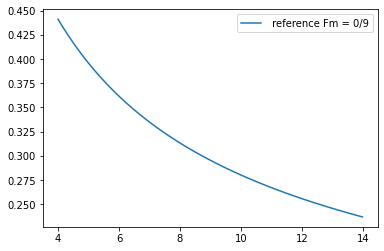

#################################################
19 9 0 Seg vs Ref 2.9801716650013077e-12 # 

19 9 1 Me vs ref 1.2409691330095285e-13 
19 9 1 Me vs Seg 0.0 
19 9 1 Seg vs Ref 1.2409691330095285e-13 

19 9 2 Me vs ref 1.5557650653863497e-14 
19 9 2 Me vs Seg 0.0 
19 9 2 Seg vs Ref 1.5557650653863497e-14 

19 9 3 Me vs ref 3.18890963982299e-15 
19 9 3 Me vs Seg 0.0 
19 9 3 Seg vs Ref 3.18890963982299e-15 

19 9 4 Me vs ref 9.561307908606542e-16 
19 9 4 Me vs Seg 0.0 
19 9 4 Seg vs Ref 9.561307908606542e-16 

19 9 5 Me vs ref 3.369192132316595e-16 
19 9 5 Me vs Seg 0.0 
19 9 5 Seg vs Ref 3.369192132316595e-16 

19 9 6 Me vs ref 1.9072810279914532e-16 
19 9 6 Me vs Seg 0.0 
19 9 6 Seg vs Ref 1.9072810279914532e-16 

19 9 7 Me vs ref 1.127231446206023e-16 
19 9 7 Me vs Seg 0.0 
19 9 7 Seg vs Ref 1.127231446206023e-16 

19 9 8 Me vs ref 2.041755978697546e-16 
19 9 8 Me vs Seg 0.0 
19 9 8 Seg vs Ref 2.041755978697546e-16 

19 9 9 Me vs ref 1.1075125191939428e-16 
19 9 9 Me vs Seg 0.0 
19 9 9

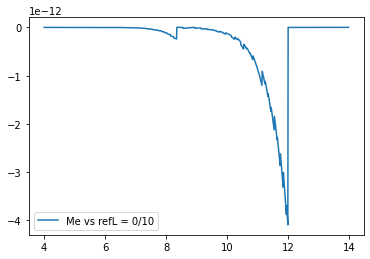

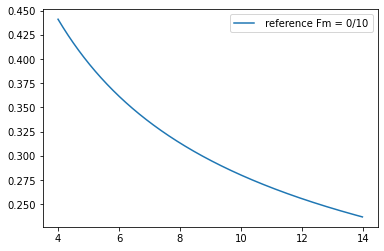

#################################################
19 10 0 Me vs ref 4.092226557617096e-12 # 
19 10 0 Me vs Seg 0.0 
#################################################
Error at  19 10 0  is  1.2346273532943397e-16


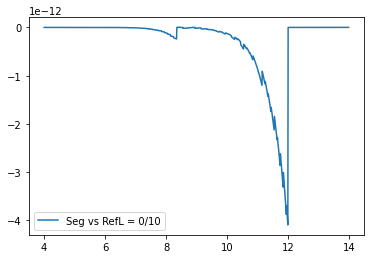

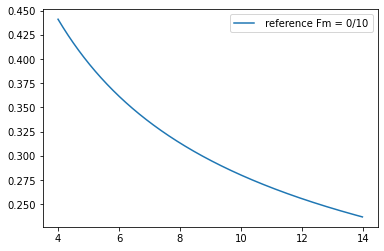

#################################################
19 10 0 Seg vs Ref 4.092226557617096e-12 # 

19 10 1 Me vs ref 1.7063433999098265e-13 
19 10 1 Me vs Seg 0.0 
19 10 1 Seg vs Ref 1.7063433999098265e-13 

19 10 2 Me vs ref 2.1289610699359862e-14 
19 10 2 Me vs Seg 0.0 
19 10 2 Seg vs Ref 2.1289610699359862e-14 

19 10 3 Me vs ref 4.48886804463311e-15 
19 10 3 Me vs Seg 0.0 
19 10 3 Seg vs Ref 4.48886804463311e-15 

19 10 4 Me vs ref 1.2835869520055887e-15 
19 10 4 Me vs Seg 0.0 
19 10 4 Seg vs Ref 1.2835869520055887e-15 

19 10 5 Me vs ref 5.031104656147423e-16 
19 10 5 Me vs Seg 0.0 
19 10 5 Seg vs Ref 5.031104656147423e-16 

19 10 6 Me vs ref 1.9510048687287201e-16 
19 10 6 Me vs Seg 0.0 
19 10 6 Seg vs Ref 1.9510048687287201e-16 

19 10 7 Me vs ref 2.1514128640490876e-16 
19 10 7 Me vs Seg 0.0 
19 10 7 Seg vs Ref 2.1514128640490876e-16 

19 10 8 Me vs ref 1.0728095793449341e-16 
19 10 8 Me vs Seg 0.0 
19 10 8 Seg vs Ref 1.0728095793449341e-16 

19 10 9 Me vs ref 1.4288429380643342e-1

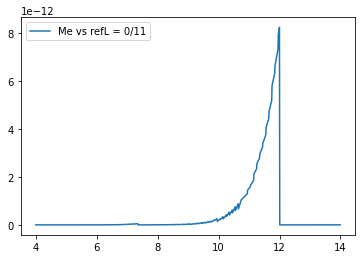

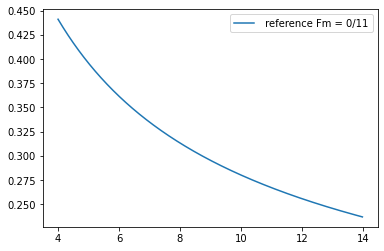

#################################################
19 11 0 Me vs ref 8.238909554592055e-12 # 
19 11 0 Me vs Seg 0.0 
#################################################
Error at  19 11 0  is  1.2346273532943397e-16


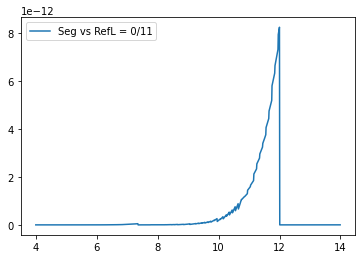

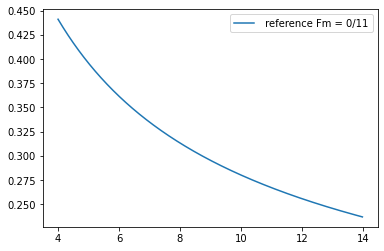

#################################################
19 11 0 Seg vs Ref 8.238909554592055e-12 # 

19 11 1 Me vs ref 3.4324799946805484e-13 
19 11 1 Me vs Seg 0.0 
19 11 1 Seg vs Ref 3.4324799946805484e-13 

19 11 2 Me vs ref 4.2956090073875686e-14 
19 11 2 Me vs Seg 0.0 
19 11 2 Seg vs Ref 4.2956090073875686e-14 

19 11 3 Me vs ref 8.897830389154038e-15 
19 11 3 Me vs Seg 0.0 
19 11 3 Seg vs Ref 8.897830389154038e-15 

19 11 4 Me vs ref 2.621492432852701e-15 
19 11 4 Me vs Seg 0.0 
19 11 4 Seg vs Ref 2.621492432852701e-15 

19 11 5 Me vs ref 9.615348610641367e-16 
19 11 5 Me vs Seg 0.0 
19 11 5 Seg vs Ref 9.615348610641367e-16 

19 11 6 Me vs ref 4.771573761108705e-16 
19 11 6 Me vs Seg 0.0 
19 11 6 Seg vs Ref 4.771573761108705e-16 

19 11 7 Me vs ref 2.3406146134772807e-16 
19 11 7 Me vs Seg 0.0 
19 11 7 Seg vs Ref 2.3406146134772807e-16 

19 11 8 Me vs ref 2.0680394110508468e-16 
19 11 8 Me vs Seg 0.0 
19 11 8 Seg vs Ref 2.0680394110508468e-16 

19 11 9 Me vs ref 1.0428352009239725e-16 

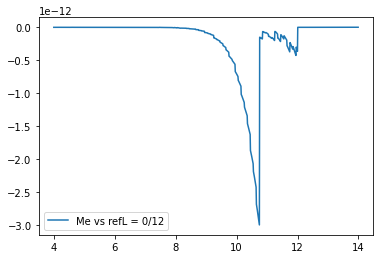

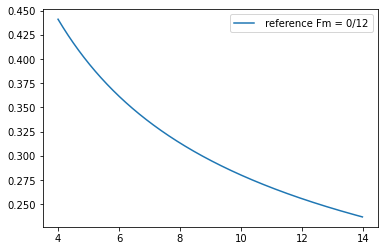

#################################################
19 12 0 Me vs ref 3.0024871477962733e-12 # 
19 12 0 Me vs Seg 0.0 
#################################################
Error at  19 12 0  is  1.2346273532943397e-16


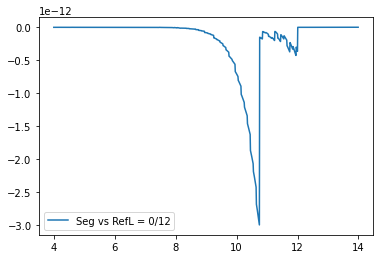

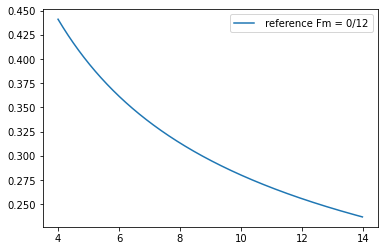

#################################################
19 12 0 Seg vs Ref 3.0024871477962733e-12 # 

19 12 1 Me vs ref 1.3968340373260446e-13 
19 12 1 Me vs Seg 0.0 
19 12 1 Seg vs Ref 1.3968340373260446e-13 

19 12 2 Me vs ref 1.943345658006468e-14 
19 12 2 Me vs Seg 0.0 
19 12 2 Seg vs Ref 1.943345658006468e-14 

19 12 3 Me vs ref 4.642120021713936e-15 
19 12 3 Me vs Seg 0.0 
19 12 3 Seg vs Ref 4.642120021713936e-15 

19 12 4 Me vs ref 1.421117997585375e-15 
19 12 4 Me vs Seg 0.0 
19 12 4 Seg vs Ref 1.421117997585375e-15 

19 12 5 Me vs ref 6.816311295780586e-16 
19 12 5 Me vs Seg 0.0 
19 12 5 Seg vs Ref 6.816311295780586e-16 

19 12 6 Me vs ref 3.0536893001233134e-16 
19 12 6 Me vs Seg 0.0 
19 12 6 Seg vs Ref 3.0536893001233134e-16 

19 12 7 Me vs ref 2.3753006126673443e-16 
19 12 7 Me vs Seg 0.0 
19 12 7 Seg vs Ref 2.3753006126673443e-16 

19 12 8 Me vs ref 1.1363455207184792e-16 
19 12 8 Me vs Seg 0.0 
19 12 8 Seg vs Ref 1.1363455207184792e-16 

19 12 9 Me vs ref 1.2217603231196028e-16

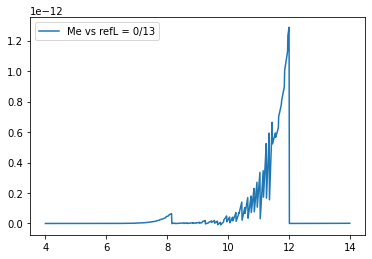

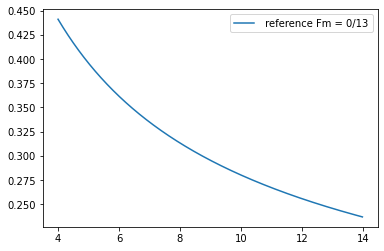

#################################################
19 13 0 Me vs ref 1.2879142197164128e-12 # 
19 13 0 Me vs Seg 0.0 
#################################################
Error at  19 13 0  is  1.2346273532943397e-16


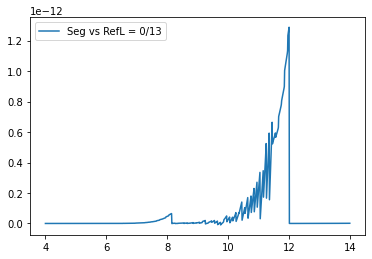

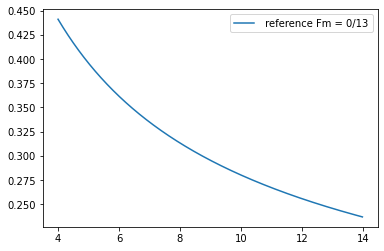

#################################################
19 13 0 Seg vs Ref 1.2879142197164128e-12 # 

19 13 1 Me vs ref 5.357519983206771e-14 
19 13 1 Me vs Seg 0.0 
19 13 1 Seg vs Ref 5.357519983206771e-14 

19 13 2 Me vs ref 6.740918587211375e-15 
19 13 2 Me vs Seg 0.0 
19 13 2 Seg vs Ref 6.740918587211375e-15 

19 13 3 Me vs ref 1.351783268654927e-15 
19 13 3 Me vs Seg 0.0 
19 13 3 Seg vs Ref 1.351783268654927e-15 

19 13 4 Me vs ref 4.224593765089768e-16 
19 13 4 Me vs Seg 0.0 
19 13 4 Seg vs Ref 4.224593765089768e-16 

19 13 5 Me vs ref 1.3723627811414174e-16 
19 13 5 Me vs Seg 0.0 
19 13 5 Seg vs Ref 1.3723627811414174e-16 

19 13 6 Me vs ref 1.1897763590312804e-16 
19 13 6 Me vs Seg 0.0 
19 13 6 Seg vs Ref 1.1897763590312804e-16 

19 13 7 Me vs ref 1.0560129160008813e-16 
19 13 7 Me vs Seg 0.0 
19 13 7 Seg vs Ref 1.0560129160008813e-16 

19 13 8 Me vs ref 1.0728095793449341e-16 
19 13 8 Me vs Seg 0.0 
19 13 8 Seg vs Ref 1.0728095793449341e-16 

19 13 9 Me vs ref 1.0428352009239725e-16

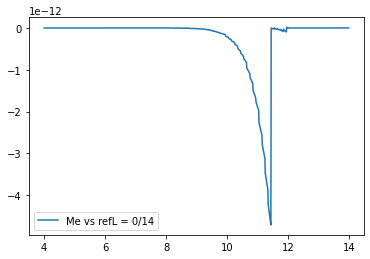

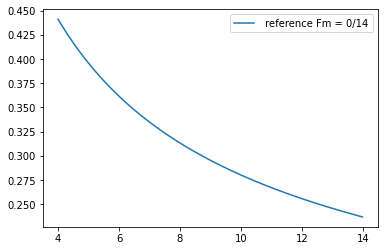

#################################################
19 14 0 Me vs ref 4.70939953700622e-12 # 
19 14 0 Me vs Seg 0.0 
#################################################
Error at  19 14 0  is  1.2346273532943397e-16


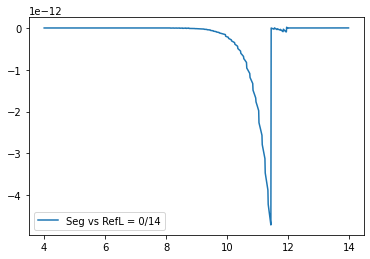

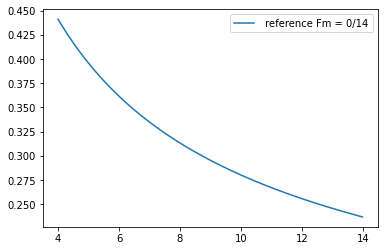

#################################################
19 14 0 Seg vs Ref 4.70939953700622e-12 # 

19 14 1 Me vs ref 2.0584575710635988e-13 
19 14 1 Me vs Seg 0.0 
19 14 1 Seg vs Ref 2.0584575710635988e-13 

19 14 2 Me vs ref 2.696757747666645e-14 
19 14 2 Me vs Seg 0.0 
19 14 2 Seg vs Ref 2.696757747666645e-14 

19 14 3 Me vs ref 5.917304406882762e-15 
19 14 3 Me vs Seg 0.0 
19 14 3 Seg vs Ref 5.917304406882762e-15 

19 14 4 Me vs ref 1.701235181374161e-15 
19 14 4 Me vs Seg 0.0 
19 14 4 Seg vs Ref 1.701235181374161e-15 

19 14 5 Me vs ref 8.192367140572032e-16 
19 14 5 Me vs Seg 0.0 
19 14 5 Seg vs Ref 8.192367140572032e-16 

19 14 6 Me vs ref 3.245084864884895e-16 
19 14 6 Me vs Seg 0.0 
19 14 6 Seg vs Ref 3.245084864884895e-16 

19 14 7 Me vs ref 2.7412866085169824e-16 
19 14 7 Me vs Seg 0.0 
19 14 7 Seg vs Ref 2.7412866085169824e-16 

19 14 8 Me vs ref 1.0728095793449341e-16 
19 14 8 Me vs Seg 0.0 
19 14 8 Seg vs Ref 1.0728095793449341e-16 

19 14 9 Me vs ref 1.2060478619480355e-16 
19

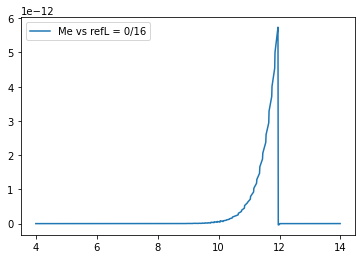

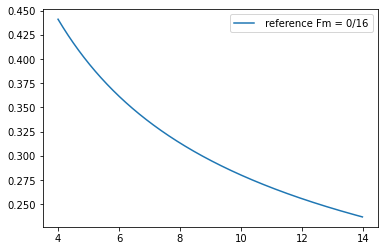

#################################################
19 16 0 Me vs ref 5.736688901691878e-12 # 
19 16 0 Me vs Seg 0.0 
#################################################
Error at  19 16 0  is  1.2346273532943397e-16


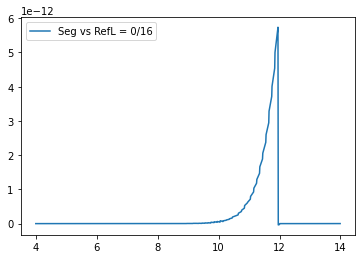

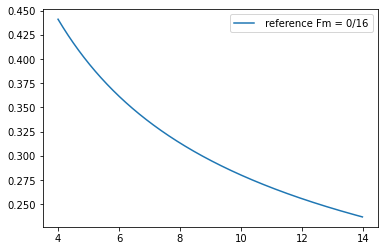

#################################################
19 16 0 Seg vs Ref 5.736688901691878e-12 # 

19 16 1 Me vs ref 2.3996256370839575e-13 
19 16 1 Me vs Seg 0.0 
19 16 1 Seg vs Ref 2.3996256370839575e-13 

19 16 2 Me vs ref 3.0163805481153716e-14 
19 16 2 Me vs Seg 0.0 
19 16 2 Seg vs Ref 3.0163805481153716e-14 

19 16 3 Me vs ref 6.2619180674072794e-15 
19 16 3 Me vs Seg 0.0 
19 16 3 Seg vs Ref 6.2619180674072794e-15 

19 16 4 Me vs ref 1.865261417544062e-15 
19 16 4 Me vs Seg 0.0 
19 16 4 Seg vs Ref 1.865261417544062e-15 

19 16 5 Me vs ref 6.807773203672263e-16 
19 16 5 Me vs Seg 0.0 
19 16 5 Seg vs Ref 6.807773203672263e-16 

19 16 6 Me vs ref 3.479611347320666e-16 
19 16 6 Me vs Seg 0.0 
19 16 6 Seg vs Ref 3.479611347320666e-16 

19 16 7 Me vs ref 1.6620395787729156e-16 
19 16 7 Me vs Seg 0.0 
19 16 7 Seg vs Ref 1.6620395787729156e-16 

19 16 8 Me vs ref 1.6045683933017113e-16 
19 16 8 Me vs Seg 0.0 
19 16 8 Seg vs Ref 1.6045683933017113e-16 

19 16 9 Me vs ref 1.0428352009239725e-1

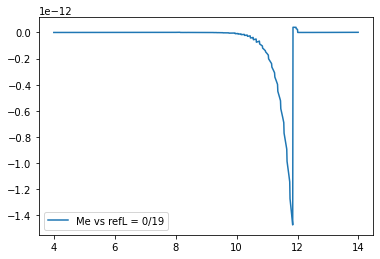

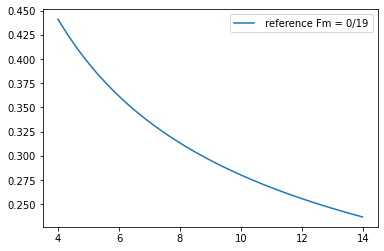

#################################################
19 19 0 Me vs ref 1.4747092436095954e-12 # 
19 19 0 Me vs Seg 0.0 
#################################################
Error at  19 19 0  is  1.2346273532943397e-16


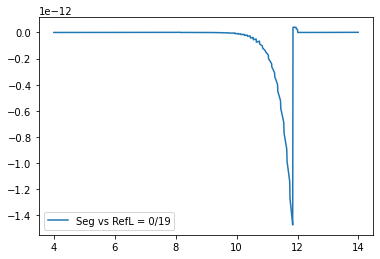

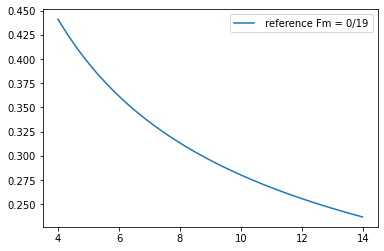

#################################################
19 19 0 Seg vs Ref 1.4747092436095954e-12 # 

19 19 1 Me vs ref 6.234422700313047e-14 
19 19 1 Me vs Seg 0.0 
19 19 1 Seg vs Ref 6.234422700313047e-14 

19 19 2 Me vs ref 7.864368878340855e-15 
19 19 2 Me vs Seg 0.0 
19 19 2 Seg vs Ref 7.864368878340855e-15 

19 19 3 Me vs ref 1.7057752779714441e-15 
19 19 3 Me vs Seg 0.0 
19 19 3 Seg vs Ref 1.7057752779714441e-15 

19 19 4 Me vs ref 4.798678815420843e-16 
19 19 4 Me vs Seg 0.0 
19 19 4 Seg vs Ref 4.798678815420843e-16 

19 19 5 Me vs ref 1.9991332807917095e-16 
19 19 5 Me vs Seg 0.0 
19 19 5 Seg vs Ref 1.9991332807917095e-16 

19 19 6 Me vs ref 1.0951966601408653e-16 
19 19 6 Me vs Seg 0.0 
19 19 6 Seg vs Ref 1.0951966601408653e-16 

19 19 7 Me vs ref 1.5584898009710774e-16 
19 19 7 Me vs Seg 0.0 
19 19 7 Seg vs Ref 1.5584898009710774e-16 

19 19 8 Me vs ref 1.0728095793449341e-16 
19 19 8 Me vs Seg 0.0 
19 19 8 Seg vs Ref 1.0728095793449341e-16 

19 19 9 Me vs ref 1.0428352009239725e-

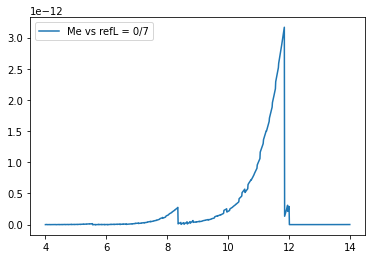

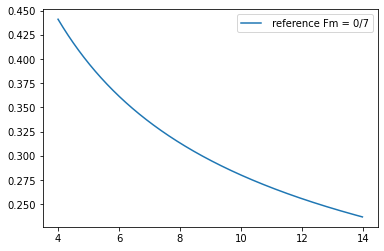

#################################################
20 7 0 Me vs ref 3.165356865508784e-12 # 
20 7 0 Me vs Seg 0.0 
#################################################
Error at  20 7 0  is  1.2346273532943397e-16


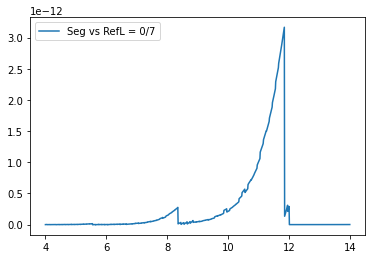

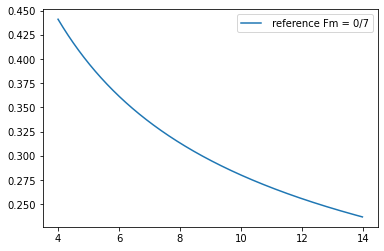

#################################################
20 7 0 Seg vs Ref 3.165356865508784e-12 # 

20 7 1 Me vs ref 1.3357544237369012e-13 
20 7 1 Me vs Seg 0.0 
20 7 1 Seg vs Ref 1.3357544237369012e-13 

20 7 2 Me vs ref 1.6952802009417844e-14 
20 7 2 Me vs Seg 0.0 
20 7 2 Seg vs Ref 1.6952802009417844e-14 

20 7 3 Me vs ref 3.5335233003475075e-15 
20 7 3 Me vs Seg 0.0 
20 7 3 Seg vs Ref 3.5335233003475075e-15 

20 7 4 Me vs ref 1.0686709763646496e-15 
20 7 4 Me vs Seg 0.0 
20 7 4 Seg vs Ref 1.0686709763646496e-15 

20 7 5 Me vs ref 3.885441773009146e-16 
20 7 5 Me vs Seg 0.0 
20 7 5 Seg vs Ref 3.885441773009146e-16 

20 7 6 Me vs ref 2.124528038303236e-16 
20 7 6 Me vs Seg 0.0 
20 7 6 Seg vs Ref 2.124528038303236e-16 

20 7 7 Me vs ref 1.2240642527361345e-16 
20 7 7 Me vs Seg 0.0 
20 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  20 8 0  is  1.2346273532943397e-16


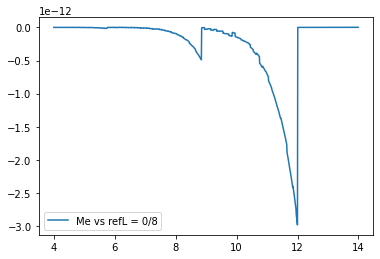

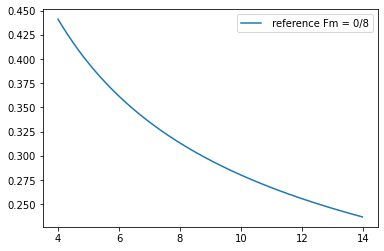

#################################################
20 8 0 Me vs ref 2.9816149549333204e-12 # 
20 8 0 Me vs Seg 0.0 
#################################################
Error at  20 8 0  is  1.2346273532943397e-16


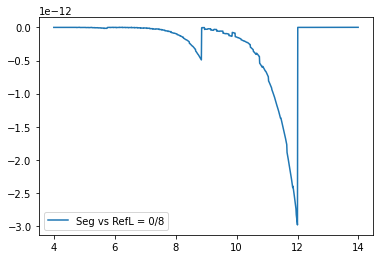

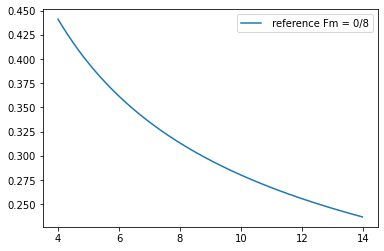

#################################################
20 8 0 Seg vs Ref 2.9816149549333204e-12 # 

20 8 1 Me vs ref 1.2435018292844546e-13 
20 8 1 Me vs Seg 0.0 
20 8 1 Seg vs Ref 1.2435018292844546e-13 

20 8 2 Me vs ref 1.5503223704804725e-14 
20 8 2 Me vs Seg 0.0 
20 8 2 Seg vs Ref 1.5503223704804725e-14 

20 8 3 Me vs ref 3.2831810187206045e-15 
20 8 3 Me vs Seg 0.0 
20 8 3 Seg vs Ref 3.2831810187206045e-15 

20 8 4 Me vs ref 9.31871767251291e-16 
20 8 4 Me vs Seg 0.0 
20 8 4 Seg vs Ref 9.31871767251291e-16 

20 8 5 Me vs ref 3.7119694254114655e-16 
20 8 5 Me vs Seg 0.0 
20 8 5 Seg vs Ref 3.7119694254114655e-16 

20 8 6 Me vs ref 1.4072944198861848e-16 
20 8 6 Me vs Seg 0.0 
20 8 6 Seg vs Ref 1.4072944198861848e-16 

20 8 7 Me vs ref 1.8633877806647353e-16 
20 8 7 Me vs Seg 0.0 
20 8 7 Seg vs Ref 1.8633877806647353e-16 

20 8 8 Me vs ref 1.0728095793449341e-16 
20 8 8 Me vs Seg 0.0 
20 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  2

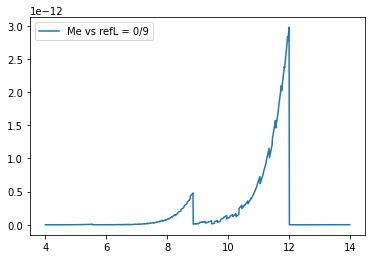

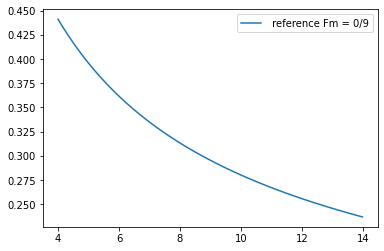

#################################################
20 9 0 Me vs ref 2.9801716650013077e-12 # 
20 9 0 Me vs Seg 0.0 
#################################################
Error at  20 9 0  is  1.2346273532943397e-16


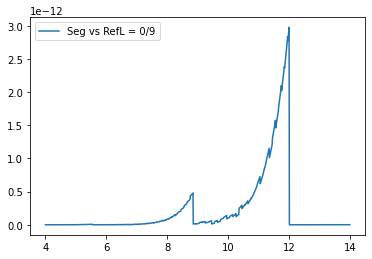

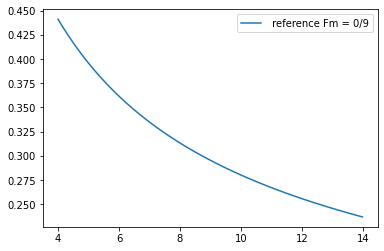

#################################################
20 9 0 Seg vs Ref 2.9801716650013077e-12 # 

20 9 1 Me vs ref 1.2409691330095285e-13 
20 9 1 Me vs Seg 0.0 
20 9 1 Seg vs Ref 1.2409691330095285e-13 

20 9 2 Me vs ref 1.5557650653863497e-14 
20 9 2 Me vs Seg 0.0 
20 9 2 Seg vs Ref 1.5557650653863497e-14 

20 9 3 Me vs ref 3.18890963982299e-15 
20 9 3 Me vs Seg 0.0 
20 9 3 Seg vs Ref 3.18890963982299e-15 

20 9 4 Me vs ref 9.561307908606542e-16 
20 9 4 Me vs Seg 0.0 
20 9 4 Seg vs Ref 9.561307908606542e-16 

20 9 5 Me vs ref 3.369192132316595e-16 
20 9 5 Me vs Seg 0.0 
20 9 5 Seg vs Ref 3.369192132316595e-16 

20 9 6 Me vs ref 1.9072810279914532e-16 
20 9 6 Me vs Seg 0.0 
20 9 6 Seg vs Ref 1.9072810279914532e-16 

20 9 7 Me vs ref 1.127231446206023e-16 
20 9 7 Me vs Seg 0.0 
20 9 7 Seg vs Ref 1.127231446206023e-16 

20 9 8 Me vs ref 2.041755978697546e-16 
20 9 8 Me vs Seg 0.0 
20 9 8 Seg vs Ref 2.041755978697546e-16 

20 9 9 Me vs ref 1.1075125191939428e-16 
20 9 9 Me vs Seg 0.0 
20 9 9

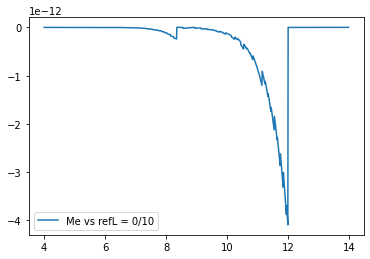

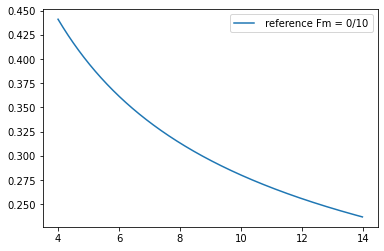

#################################################
20 10 0 Me vs ref 4.092226557617096e-12 # 
20 10 0 Me vs Seg 0.0 
#################################################
Error at  20 10 0  is  1.2346273532943397e-16


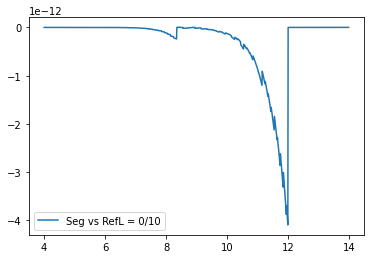

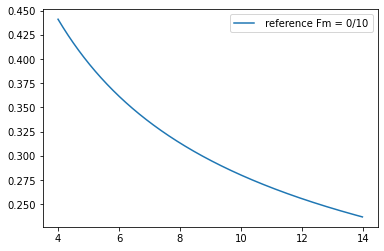

#################################################
20 10 0 Seg vs Ref 4.092226557617096e-12 # 

20 10 1 Me vs ref 1.7063433999098265e-13 
20 10 1 Me vs Seg 0.0 
20 10 1 Seg vs Ref 1.7063433999098265e-13 

20 10 2 Me vs ref 2.1289610699359862e-14 
20 10 2 Me vs Seg 0.0 
20 10 2 Seg vs Ref 2.1289610699359862e-14 

20 10 3 Me vs ref 4.48886804463311e-15 
20 10 3 Me vs Seg 0.0 
20 10 3 Seg vs Ref 4.48886804463311e-15 

20 10 4 Me vs ref 1.2835869520055887e-15 
20 10 4 Me vs Seg 0.0 
20 10 4 Seg vs Ref 1.2835869520055887e-15 

20 10 5 Me vs ref 5.031104656147423e-16 
20 10 5 Me vs Seg 0.0 
20 10 5 Seg vs Ref 5.031104656147423e-16 

20 10 6 Me vs ref 1.9510048687287201e-16 
20 10 6 Me vs Seg 0.0 
20 10 6 Seg vs Ref 1.9510048687287201e-16 

20 10 7 Me vs ref 2.1514128640490876e-16 
20 10 7 Me vs Seg 0.0 
20 10 7 Seg vs Ref 2.1514128640490876e-16 

20 10 8 Me vs ref 1.0728095793449341e-16 
20 10 8 Me vs Seg 0.0 
20 10 8 Seg vs Ref 1.0728095793449341e-16 

20 10 9 Me vs ref 1.4288429380643342e-1

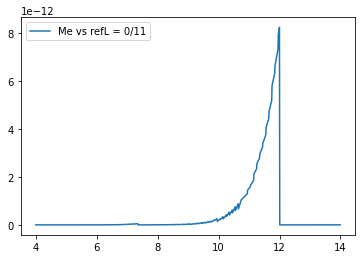

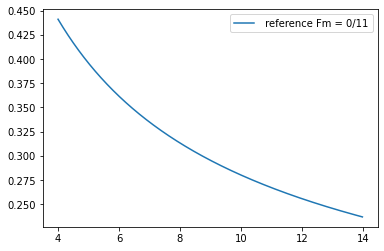

#################################################
20 11 0 Me vs ref 8.238909554592055e-12 # 
20 11 0 Me vs Seg 0.0 
#################################################
Error at  20 11 0  is  1.2346273532943397e-16


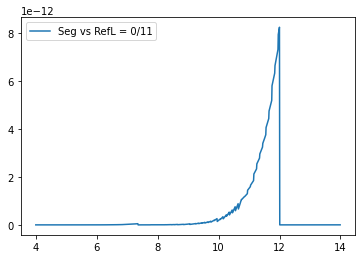

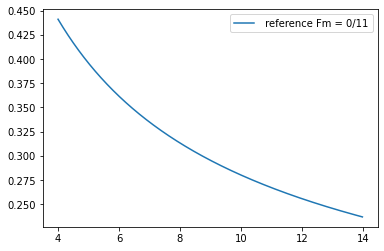

#################################################
20 11 0 Seg vs Ref 8.238909554592055e-12 # 

20 11 1 Me vs ref 3.4324799946805484e-13 
20 11 1 Me vs Seg 0.0 
20 11 1 Seg vs Ref 3.4324799946805484e-13 

20 11 2 Me vs ref 4.2956090073875686e-14 
20 11 2 Me vs Seg 0.0 
20 11 2 Seg vs Ref 4.2956090073875686e-14 

20 11 3 Me vs ref 8.897830389154038e-15 
20 11 3 Me vs Seg 0.0 
20 11 3 Seg vs Ref 8.897830389154038e-15 

20 11 4 Me vs ref 2.621492432852701e-15 
20 11 4 Me vs Seg 0.0 
20 11 4 Seg vs Ref 2.621492432852701e-15 

20 11 5 Me vs ref 9.615348610641367e-16 
20 11 5 Me vs Seg 0.0 
20 11 5 Seg vs Ref 9.615348610641367e-16 

20 11 6 Me vs ref 4.771573761108705e-16 
20 11 6 Me vs Seg 0.0 
20 11 6 Seg vs Ref 4.771573761108705e-16 

20 11 7 Me vs ref 2.3406146134772807e-16 
20 11 7 Me vs Seg 0.0 
20 11 7 Seg vs Ref 2.3406146134772807e-16 

20 11 8 Me vs ref 2.0680394110508468e-16 
20 11 8 Me vs Seg 0.0 
20 11 8 Seg vs Ref 2.0680394110508468e-16 

20 11 9 Me vs ref 1.0428352009239725e-16 

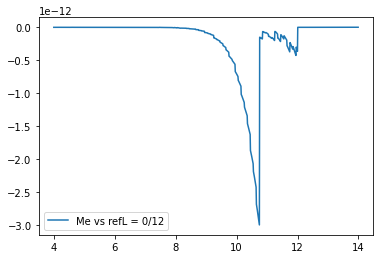

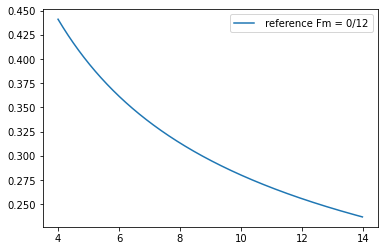

#################################################
20 12 0 Me vs ref 3.0024871477962733e-12 # 
20 12 0 Me vs Seg 0.0 
#################################################
Error at  20 12 0  is  1.2346273532943397e-16


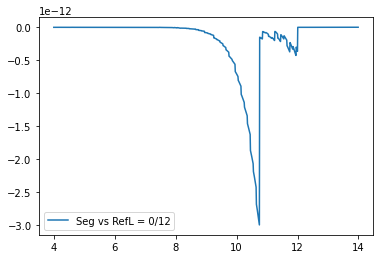

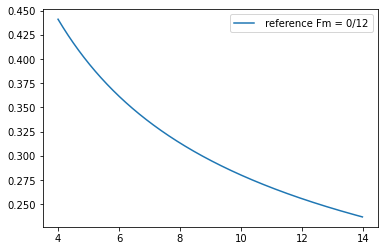

#################################################
20 12 0 Seg vs Ref 3.0024871477962733e-12 # 

20 12 1 Me vs ref 1.3968340373260446e-13 
20 12 1 Me vs Seg 0.0 
20 12 1 Seg vs Ref 1.3968340373260446e-13 

20 12 2 Me vs ref 1.943345658006468e-14 
20 12 2 Me vs Seg 0.0 
20 12 2 Seg vs Ref 1.943345658006468e-14 

20 12 3 Me vs ref 4.642120021713936e-15 
20 12 3 Me vs Seg 0.0 
20 12 3 Seg vs Ref 4.642120021713936e-15 

20 12 4 Me vs ref 1.421117997585375e-15 
20 12 4 Me vs Seg 0.0 
20 12 4 Seg vs Ref 1.421117997585375e-15 

20 12 5 Me vs ref 6.816311295780586e-16 
20 12 5 Me vs Seg 0.0 
20 12 5 Seg vs Ref 6.816311295780586e-16 

20 12 6 Me vs ref 3.0536893001233134e-16 
20 12 6 Me vs Seg 0.0 
20 12 6 Seg vs Ref 3.0536893001233134e-16 

20 12 7 Me vs ref 2.3753006126673443e-16 
20 12 7 Me vs Seg 0.0 
20 12 7 Seg vs Ref 2.3753006126673443e-16 

20 12 8 Me vs ref 1.1363455207184792e-16 
20 12 8 Me vs Seg 0.0 
20 12 8 Seg vs Ref 1.1363455207184792e-16 

20 12 9 Me vs ref 1.2217603231196028e-16

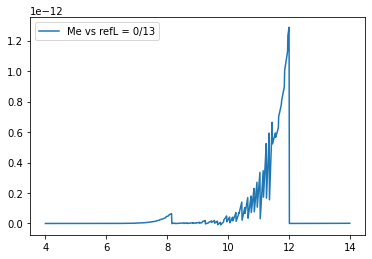

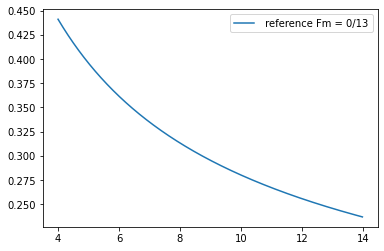

#################################################
20 13 0 Me vs ref 1.2879142197164128e-12 # 
20 13 0 Me vs Seg 0.0 
#################################################
Error at  20 13 0  is  1.2346273532943397e-16


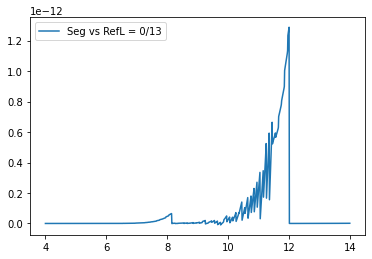

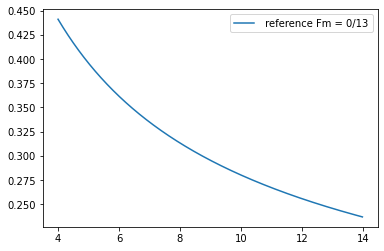

#################################################
20 13 0 Seg vs Ref 1.2879142197164128e-12 # 

20 13 1 Me vs ref 5.357519983206771e-14 
20 13 1 Me vs Seg 0.0 
20 13 1 Seg vs Ref 5.357519983206771e-14 

20 13 2 Me vs ref 6.740918587211375e-15 
20 13 2 Me vs Seg 0.0 
20 13 2 Seg vs Ref 6.740918587211375e-15 

20 13 3 Me vs ref 1.351783268654927e-15 
20 13 3 Me vs Seg 0.0 
20 13 3 Seg vs Ref 1.351783268654927e-15 

20 13 4 Me vs ref 4.224593765089768e-16 
20 13 4 Me vs Seg 0.0 
20 13 4 Seg vs Ref 4.224593765089768e-16 

20 13 5 Me vs ref 1.3723627811414174e-16 
20 13 5 Me vs Seg 0.0 
20 13 5 Seg vs Ref 1.3723627811414174e-16 

20 13 6 Me vs ref 1.1897763590312804e-16 
20 13 6 Me vs Seg 0.0 
20 13 6 Seg vs Ref 1.1897763590312804e-16 

20 13 7 Me vs ref 1.0560129160008813e-16 
20 13 7 Me vs Seg 0.0 
20 13 7 Seg vs Ref 1.0560129160008813e-16 

20 13 8 Me vs ref 1.0728095793449341e-16 
20 13 8 Me vs Seg 0.0 
20 13 8 Seg vs Ref 1.0728095793449341e-16 

20 13 9 Me vs ref 1.0428352009239725e-16

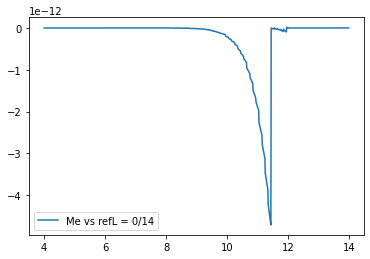

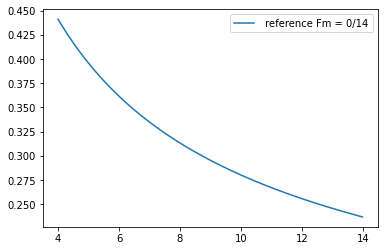

#################################################
20 14 0 Me vs ref 4.70939953700622e-12 # 
20 14 0 Me vs Seg 0.0 
#################################################
Error at  20 14 0  is  1.2346273532943397e-16


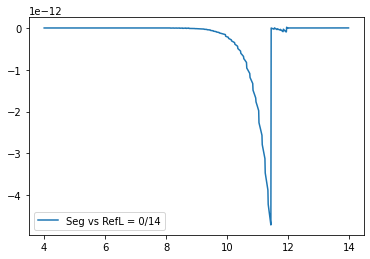

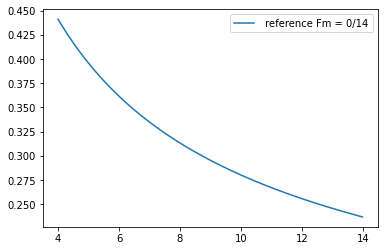

#################################################
20 14 0 Seg vs Ref 4.70939953700622e-12 # 

20 14 1 Me vs ref 2.0584575710635988e-13 
20 14 1 Me vs Seg 0.0 
20 14 1 Seg vs Ref 2.0584575710635988e-13 

20 14 2 Me vs ref 2.696757747666645e-14 
20 14 2 Me vs Seg 0.0 
20 14 2 Seg vs Ref 2.696757747666645e-14 

20 14 3 Me vs ref 5.917304406882762e-15 
20 14 3 Me vs Seg 0.0 
20 14 3 Seg vs Ref 5.917304406882762e-15 

20 14 4 Me vs ref 1.701235181374161e-15 
20 14 4 Me vs Seg 0.0 
20 14 4 Seg vs Ref 1.701235181374161e-15 

20 14 5 Me vs ref 8.192367140572032e-16 
20 14 5 Me vs Seg 0.0 
20 14 5 Seg vs Ref 8.192367140572032e-16 

20 14 6 Me vs ref 3.245084864884895e-16 
20 14 6 Me vs Seg 0.0 
20 14 6 Seg vs Ref 3.245084864884895e-16 

20 14 7 Me vs ref 2.7412866085169824e-16 
20 14 7 Me vs Seg 0.0 
20 14 7 Seg vs Ref 2.7412866085169824e-16 

20 14 8 Me vs ref 1.0728095793449341e-16 
20 14 8 Me vs Seg 0.0 
20 14 8 Seg vs Ref 1.0728095793449341e-16 

20 14 9 Me vs ref 1.2060478619480355e-16 
20

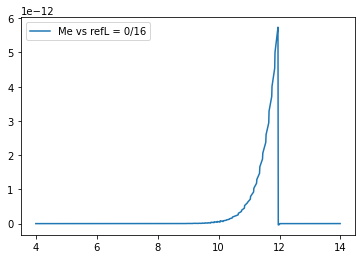

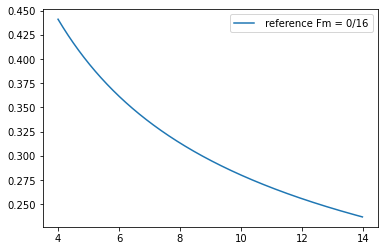

#################################################
20 16 0 Me vs ref 5.736688901691878e-12 # 
20 16 0 Me vs Seg 0.0 
#################################################
Error at  20 16 0  is  1.2346273532943397e-16


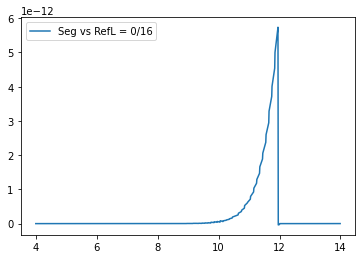

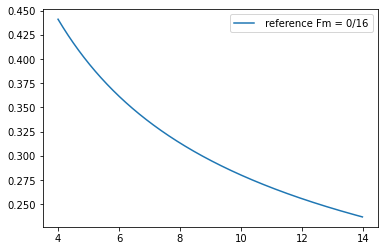

#################################################
20 16 0 Seg vs Ref 5.736688901691878e-12 # 

20 16 1 Me vs ref 2.3996256370839575e-13 
20 16 1 Me vs Seg 0.0 
20 16 1 Seg vs Ref 2.3996256370839575e-13 

20 16 2 Me vs ref 3.0163805481153716e-14 
20 16 2 Me vs Seg 0.0 
20 16 2 Seg vs Ref 3.0163805481153716e-14 

20 16 3 Me vs ref 6.2619180674072794e-15 
20 16 3 Me vs Seg 0.0 
20 16 3 Seg vs Ref 6.2619180674072794e-15 

20 16 4 Me vs ref 1.865261417544062e-15 
20 16 4 Me vs Seg 0.0 
20 16 4 Seg vs Ref 1.865261417544062e-15 

20 16 5 Me vs ref 6.807773203672263e-16 
20 16 5 Me vs Seg 0.0 
20 16 5 Seg vs Ref 6.807773203672263e-16 

20 16 6 Me vs ref 3.479611347320666e-16 
20 16 6 Me vs Seg 0.0 
20 16 6 Seg vs Ref 3.479611347320666e-16 

20 16 7 Me vs ref 1.6620395787729156e-16 
20 16 7 Me vs Seg 0.0 
20 16 7 Seg vs Ref 1.6620395787729156e-16 

20 16 8 Me vs ref 1.6045683933017113e-16 
20 16 8 Me vs Seg 0.0 
20 16 8 Seg vs Ref 1.6045683933017113e-16 

20 16 9 Me vs ref 1.0428352009239725e-1

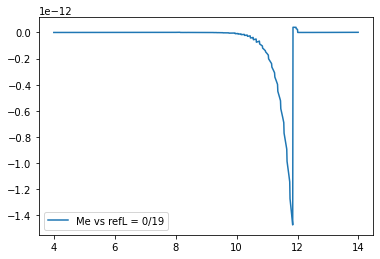

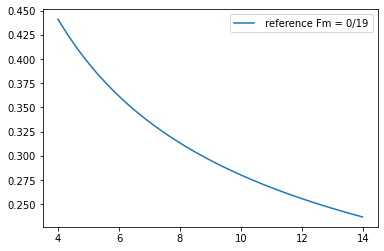

#################################################
20 19 0 Me vs ref 1.4747092436095954e-12 # 
20 19 0 Me vs Seg 0.0 
#################################################
Error at  20 19 0  is  1.2346273532943397e-16


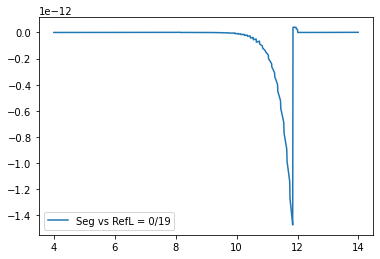

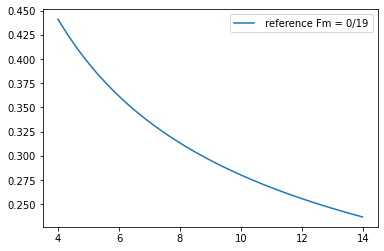

#################################################
20 19 0 Seg vs Ref 1.4747092436095954e-12 # 

20 19 1 Me vs ref 6.234422700313047e-14 
20 19 1 Me vs Seg 0.0 
20 19 1 Seg vs Ref 6.234422700313047e-14 

20 19 2 Me vs ref 7.864368878340855e-15 
20 19 2 Me vs Seg 0.0 
20 19 2 Seg vs Ref 7.864368878340855e-15 

20 19 3 Me vs ref 1.7057752779714441e-15 
20 19 3 Me vs Seg 0.0 
20 19 3 Seg vs Ref 1.7057752779714441e-15 

20 19 4 Me vs ref 4.798678815420843e-16 
20 19 4 Me vs Seg 0.0 
20 19 4 Seg vs Ref 4.798678815420843e-16 

20 19 5 Me vs ref 1.9991332807917095e-16 
20 19 5 Me vs Seg 0.0 
20 19 5 Seg vs Ref 1.9991332807917095e-16 

20 19 6 Me vs ref 1.0951966601408653e-16 
20 19 6 Me vs Seg 0.0 
20 19 6 Seg vs Ref 1.0951966601408653e-16 

20 19 7 Me vs ref 1.5584898009710774e-16 
20 19 7 Me vs Seg 0.0 
20 19 7 Seg vs Ref 1.5584898009710774e-16 

20 19 8 Me vs ref 1.0728095793449341e-16 
20 19 8 Me vs Seg 0.0 
20 19 8 Seg vs Ref 1.0728095793449341e-16 

20 19 9 Me vs ref 1.0428352009239725e-

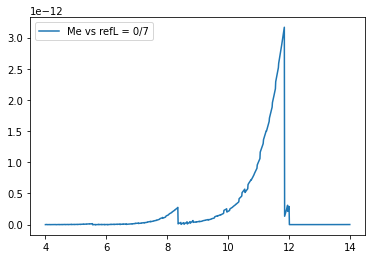

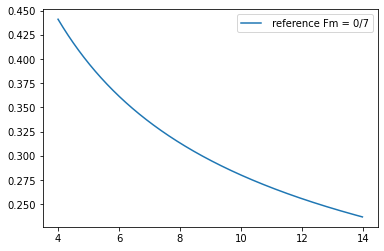

#################################################
21 7 0 Me vs ref 3.165356865508784e-12 # 
21 7 0 Me vs Seg 0.0 
#################################################
Error at  21 7 0  is  1.2346273532943397e-16


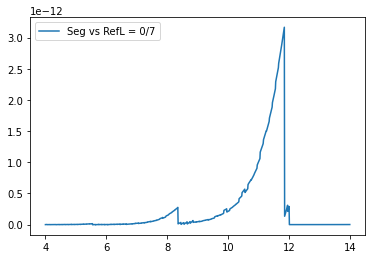

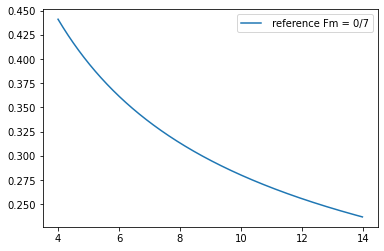

#################################################
21 7 0 Seg vs Ref 3.165356865508784e-12 # 

21 7 1 Me vs ref 1.3357544237369012e-13 
21 7 1 Me vs Seg 0.0 
21 7 1 Seg vs Ref 1.3357544237369012e-13 

21 7 2 Me vs ref 1.6952802009417844e-14 
21 7 2 Me vs Seg 0.0 
21 7 2 Seg vs Ref 1.6952802009417844e-14 

21 7 3 Me vs ref 3.5335233003475075e-15 
21 7 3 Me vs Seg 0.0 
21 7 3 Seg vs Ref 3.5335233003475075e-15 

21 7 4 Me vs ref 1.0686709763646496e-15 
21 7 4 Me vs Seg 0.0 
21 7 4 Seg vs Ref 1.0686709763646496e-15 

21 7 5 Me vs ref 3.885441773009146e-16 
21 7 5 Me vs Seg 0.0 
21 7 5 Seg vs Ref 3.885441773009146e-16 

21 7 6 Me vs ref 2.124528038303236e-16 
21 7 6 Me vs Seg 0.0 
21 7 6 Seg vs Ref 2.124528038303236e-16 

21 7 7 Me vs ref 1.2240642527361345e-16 
21 7 7 Me vs Seg 0.0 
21 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  21 8 0  is  1.2346273532943397e-16


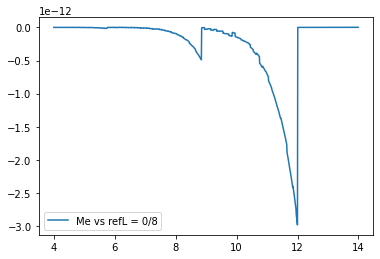

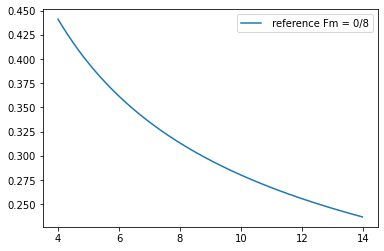

#################################################
21 8 0 Me vs ref 2.9816149549333204e-12 # 
21 8 0 Me vs Seg 0.0 
#################################################
Error at  21 8 0  is  1.2346273532943397e-16


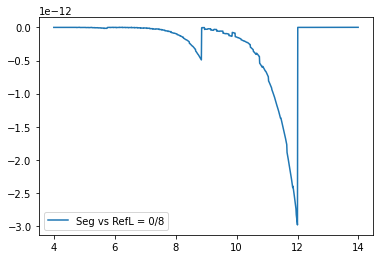

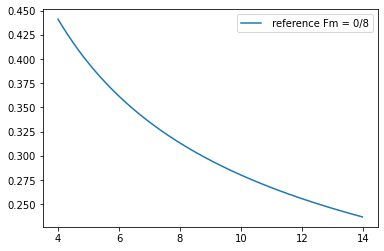

#################################################
21 8 0 Seg vs Ref 2.9816149549333204e-12 # 

21 8 1 Me vs ref 1.2435018292844546e-13 
21 8 1 Me vs Seg 0.0 
21 8 1 Seg vs Ref 1.2435018292844546e-13 

21 8 2 Me vs ref 1.5503223704804725e-14 
21 8 2 Me vs Seg 0.0 
21 8 2 Seg vs Ref 1.5503223704804725e-14 

21 8 3 Me vs ref 3.2831810187206045e-15 
21 8 3 Me vs Seg 0.0 
21 8 3 Seg vs Ref 3.2831810187206045e-15 

21 8 4 Me vs ref 9.31871767251291e-16 
21 8 4 Me vs Seg 0.0 
21 8 4 Seg vs Ref 9.31871767251291e-16 

21 8 5 Me vs ref 3.7119694254114655e-16 
21 8 5 Me vs Seg 0.0 
21 8 5 Seg vs Ref 3.7119694254114655e-16 

21 8 6 Me vs ref 1.4072944198861848e-16 
21 8 6 Me vs Seg 0.0 
21 8 6 Seg vs Ref 1.4072944198861848e-16 

21 8 7 Me vs ref 1.8633877806647353e-16 
21 8 7 Me vs Seg 0.0 
21 8 7 Seg vs Ref 1.8633877806647353e-16 

21 8 8 Me vs ref 1.0728095793449341e-16 
21 8 8 Me vs Seg 0.0 
21 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  2

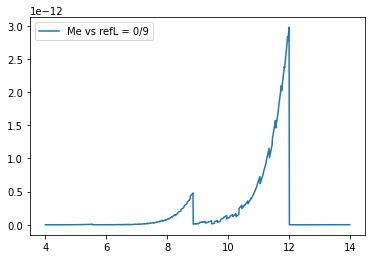

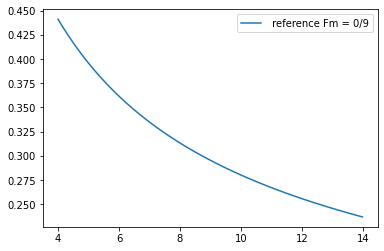

#################################################
21 9 0 Me vs ref 2.9801716650013077e-12 # 
21 9 0 Me vs Seg 0.0 
#################################################
Error at  21 9 0  is  1.2346273532943397e-16


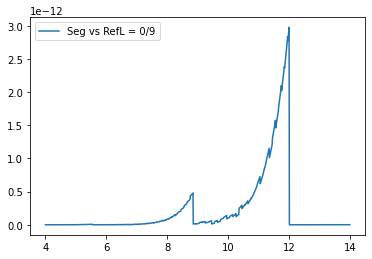

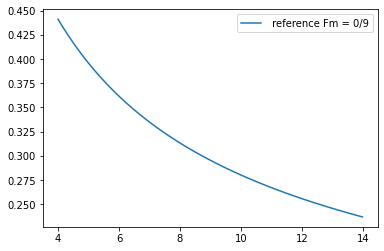

#################################################
21 9 0 Seg vs Ref 2.9801716650013077e-12 # 

21 9 1 Me vs ref 1.2409691330095285e-13 
21 9 1 Me vs Seg 0.0 
21 9 1 Seg vs Ref 1.2409691330095285e-13 

21 9 2 Me vs ref 1.5557650653863497e-14 
21 9 2 Me vs Seg 0.0 
21 9 2 Seg vs Ref 1.5557650653863497e-14 

21 9 3 Me vs ref 3.18890963982299e-15 
21 9 3 Me vs Seg 0.0 
21 9 3 Seg vs Ref 3.18890963982299e-15 

21 9 4 Me vs ref 9.561307908606542e-16 
21 9 4 Me vs Seg 0.0 
21 9 4 Seg vs Ref 9.561307908606542e-16 

21 9 5 Me vs ref 3.369192132316595e-16 
21 9 5 Me vs Seg 0.0 
21 9 5 Seg vs Ref 3.369192132316595e-16 

21 9 6 Me vs ref 1.9072810279914532e-16 
21 9 6 Me vs Seg 0.0 
21 9 6 Seg vs Ref 1.9072810279914532e-16 

21 9 7 Me vs ref 1.127231446206023e-16 
21 9 7 Me vs Seg 0.0 
21 9 7 Seg vs Ref 1.127231446206023e-16 

21 9 8 Me vs ref 2.041755978697546e-16 
21 9 8 Me vs Seg 0.0 
21 9 8 Seg vs Ref 2.041755978697546e-16 

21 9 9 Me vs ref 1.1075125191939428e-16 
21 9 9 Me vs Seg 0.0 
21 9 9

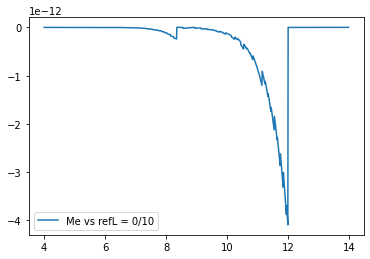

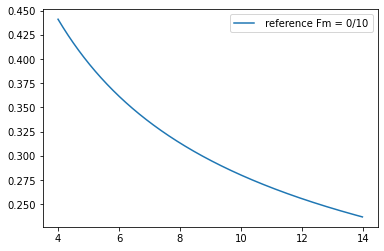

#################################################
21 10 0 Me vs ref 4.092226557617096e-12 # 
21 10 0 Me vs Seg 0.0 
#################################################
Error at  21 10 0  is  1.2346273532943397e-16


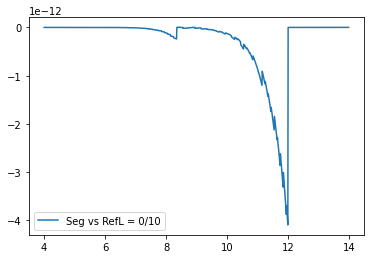

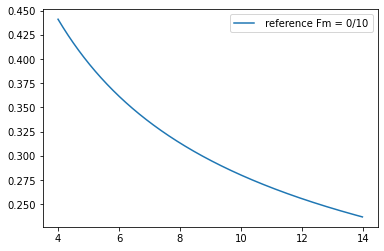

#################################################
21 10 0 Seg vs Ref 4.092226557617096e-12 # 

21 10 1 Me vs ref 1.7063433999098265e-13 
21 10 1 Me vs Seg 0.0 
21 10 1 Seg vs Ref 1.7063433999098265e-13 

21 10 2 Me vs ref 2.1289610699359862e-14 
21 10 2 Me vs Seg 0.0 
21 10 2 Seg vs Ref 2.1289610699359862e-14 

21 10 3 Me vs ref 4.48886804463311e-15 
21 10 3 Me vs Seg 0.0 
21 10 3 Seg vs Ref 4.48886804463311e-15 

21 10 4 Me vs ref 1.2835869520055887e-15 
21 10 4 Me vs Seg 0.0 
21 10 4 Seg vs Ref 1.2835869520055887e-15 

21 10 5 Me vs ref 5.031104656147423e-16 
21 10 5 Me vs Seg 0.0 
21 10 5 Seg vs Ref 5.031104656147423e-16 

21 10 6 Me vs ref 1.9510048687287201e-16 
21 10 6 Me vs Seg 0.0 
21 10 6 Seg vs Ref 1.9510048687287201e-16 

21 10 7 Me vs ref 2.1514128640490876e-16 
21 10 7 Me vs Seg 0.0 
21 10 7 Seg vs Ref 2.1514128640490876e-16 

21 10 8 Me vs ref 1.0728095793449341e-16 
21 10 8 Me vs Seg 0.0 
21 10 8 Seg vs Ref 1.0728095793449341e-16 

21 10 9 Me vs ref 1.4288429380643342e-1

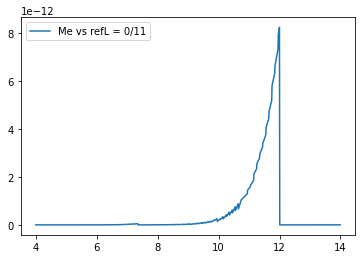

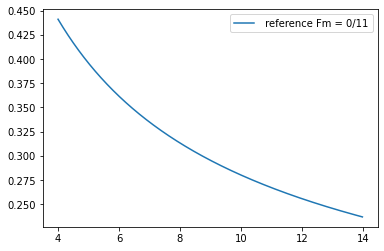

#################################################
21 11 0 Me vs ref 8.238909554592055e-12 # 
21 11 0 Me vs Seg 0.0 
#################################################
Error at  21 11 0  is  1.2346273532943397e-16


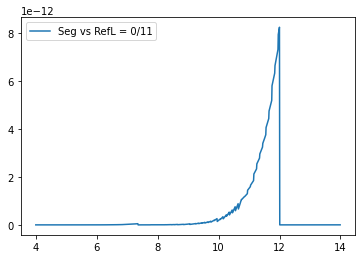

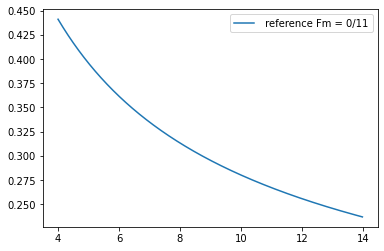

#################################################
21 11 0 Seg vs Ref 8.238909554592055e-12 # 

21 11 1 Me vs ref 3.4324799946805484e-13 
21 11 1 Me vs Seg 0.0 
21 11 1 Seg vs Ref 3.4324799946805484e-13 

21 11 2 Me vs ref 4.2956090073875686e-14 
21 11 2 Me vs Seg 0.0 
21 11 2 Seg vs Ref 4.2956090073875686e-14 

21 11 3 Me vs ref 8.897830389154038e-15 
21 11 3 Me vs Seg 0.0 
21 11 3 Seg vs Ref 8.897830389154038e-15 

21 11 4 Me vs ref 2.621492432852701e-15 
21 11 4 Me vs Seg 0.0 
21 11 4 Seg vs Ref 2.621492432852701e-15 

21 11 5 Me vs ref 9.615348610641367e-16 
21 11 5 Me vs Seg 0.0 
21 11 5 Seg vs Ref 9.615348610641367e-16 

21 11 6 Me vs ref 4.771573761108705e-16 
21 11 6 Me vs Seg 0.0 
21 11 6 Seg vs Ref 4.771573761108705e-16 

21 11 7 Me vs ref 2.3406146134772807e-16 
21 11 7 Me vs Seg 0.0 
21 11 7 Seg vs Ref 2.3406146134772807e-16 

21 11 8 Me vs ref 2.0680394110508468e-16 
21 11 8 Me vs Seg 0.0 
21 11 8 Seg vs Ref 2.0680394110508468e-16 

21 11 9 Me vs ref 1.0428352009239725e-16 

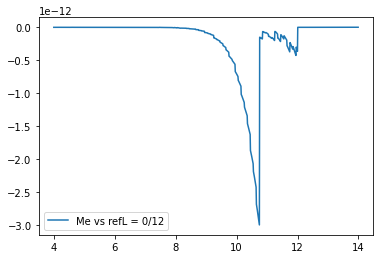

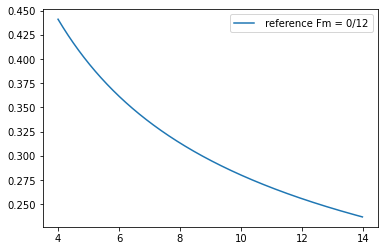

#################################################
21 12 0 Me vs ref 3.0024871477962733e-12 # 
21 12 0 Me vs Seg 0.0 
#################################################
Error at  21 12 0  is  1.2346273532943397e-16


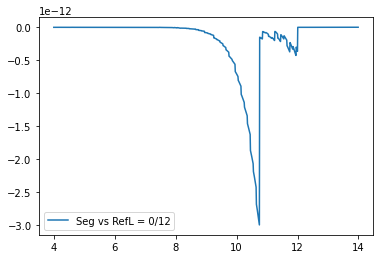

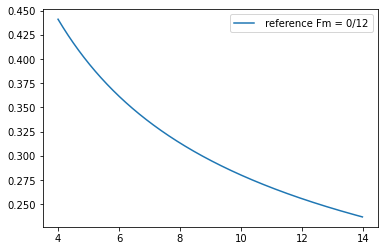

#################################################
21 12 0 Seg vs Ref 3.0024871477962733e-12 # 

21 12 1 Me vs ref 1.3968340373260446e-13 
21 12 1 Me vs Seg 0.0 
21 12 1 Seg vs Ref 1.3968340373260446e-13 

21 12 2 Me vs ref 1.943345658006468e-14 
21 12 2 Me vs Seg 0.0 
21 12 2 Seg vs Ref 1.943345658006468e-14 

21 12 3 Me vs ref 4.642120021713936e-15 
21 12 3 Me vs Seg 0.0 
21 12 3 Seg vs Ref 4.642120021713936e-15 

21 12 4 Me vs ref 1.421117997585375e-15 
21 12 4 Me vs Seg 0.0 
21 12 4 Seg vs Ref 1.421117997585375e-15 

21 12 5 Me vs ref 6.816311295780586e-16 
21 12 5 Me vs Seg 0.0 
21 12 5 Seg vs Ref 6.816311295780586e-16 

21 12 6 Me vs ref 3.0536893001233134e-16 
21 12 6 Me vs Seg 0.0 
21 12 6 Seg vs Ref 3.0536893001233134e-16 

21 12 7 Me vs ref 2.3753006126673443e-16 
21 12 7 Me vs Seg 0.0 
21 12 7 Seg vs Ref 2.3753006126673443e-16 

21 12 8 Me vs ref 1.1363455207184792e-16 
21 12 8 Me vs Seg 0.0 
21 12 8 Seg vs Ref 1.1363455207184792e-16 

21 12 9 Me vs ref 1.2217603231196028e-16

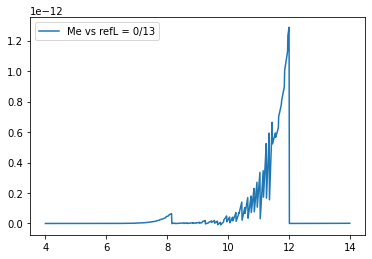

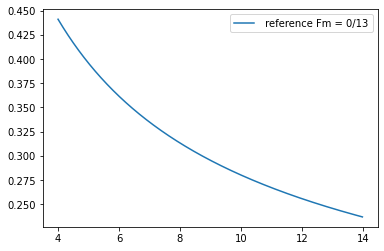

#################################################
21 13 0 Me vs ref 1.2879142197164128e-12 # 
21 13 0 Me vs Seg 0.0 
#################################################
Error at  21 13 0  is  1.2346273532943397e-16


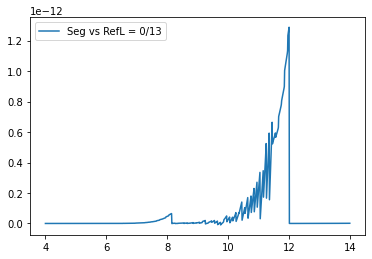

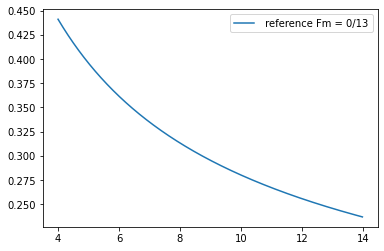

#################################################
21 13 0 Seg vs Ref 1.2879142197164128e-12 # 

21 13 1 Me vs ref 5.357519983206771e-14 
21 13 1 Me vs Seg 0.0 
21 13 1 Seg vs Ref 5.357519983206771e-14 

21 13 2 Me vs ref 6.740918587211375e-15 
21 13 2 Me vs Seg 0.0 
21 13 2 Seg vs Ref 6.740918587211375e-15 

21 13 3 Me vs ref 1.351783268654927e-15 
21 13 3 Me vs Seg 0.0 
21 13 3 Seg vs Ref 1.351783268654927e-15 

21 13 4 Me vs ref 4.224593765089768e-16 
21 13 4 Me vs Seg 0.0 
21 13 4 Seg vs Ref 4.224593765089768e-16 

21 13 5 Me vs ref 1.3723627811414174e-16 
21 13 5 Me vs Seg 0.0 
21 13 5 Seg vs Ref 1.3723627811414174e-16 

21 13 6 Me vs ref 1.1897763590312804e-16 
21 13 6 Me vs Seg 0.0 
21 13 6 Seg vs Ref 1.1897763590312804e-16 

21 13 7 Me vs ref 1.0560129160008813e-16 
21 13 7 Me vs Seg 0.0 
21 13 7 Seg vs Ref 1.0560129160008813e-16 

21 13 8 Me vs ref 1.0728095793449341e-16 
21 13 8 Me vs Seg 0.0 
21 13 8 Seg vs Ref 1.0728095793449341e-16 

21 13 9 Me vs ref 1.0428352009239725e-16

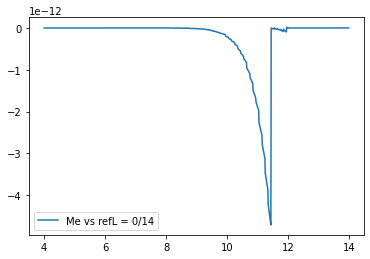

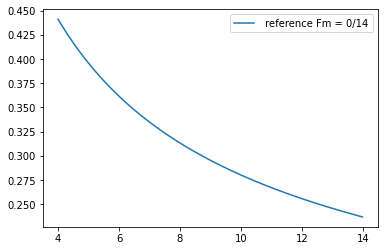

#################################################
21 14 0 Me vs ref 4.70939953700622e-12 # 
21 14 0 Me vs Seg 0.0 
#################################################
Error at  21 14 0  is  1.2346273532943397e-16


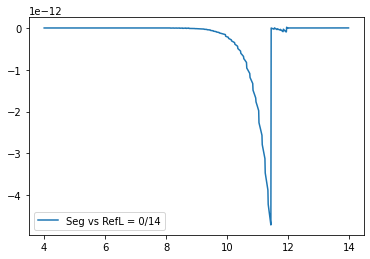

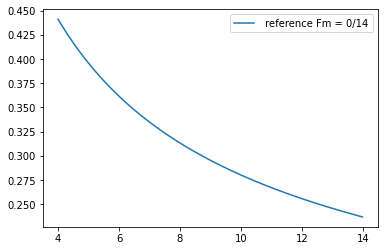

#################################################
21 14 0 Seg vs Ref 4.70939953700622e-12 # 

21 14 1 Me vs ref 2.0584575710635988e-13 
21 14 1 Me vs Seg 0.0 
21 14 1 Seg vs Ref 2.0584575710635988e-13 

21 14 2 Me vs ref 2.696757747666645e-14 
21 14 2 Me vs Seg 0.0 
21 14 2 Seg vs Ref 2.696757747666645e-14 

21 14 3 Me vs ref 5.917304406882762e-15 
21 14 3 Me vs Seg 0.0 
21 14 3 Seg vs Ref 5.917304406882762e-15 

21 14 4 Me vs ref 1.701235181374161e-15 
21 14 4 Me vs Seg 0.0 
21 14 4 Seg vs Ref 1.701235181374161e-15 

21 14 5 Me vs ref 8.192367140572032e-16 
21 14 5 Me vs Seg 0.0 
21 14 5 Seg vs Ref 8.192367140572032e-16 

21 14 6 Me vs ref 3.245084864884895e-16 
21 14 6 Me vs Seg 0.0 
21 14 6 Seg vs Ref 3.245084864884895e-16 

21 14 7 Me vs ref 2.7412866085169824e-16 
21 14 7 Me vs Seg 0.0 
21 14 7 Seg vs Ref 2.7412866085169824e-16 

21 14 8 Me vs ref 1.0728095793449341e-16 
21 14 8 Me vs Seg 0.0 
21 14 8 Seg vs Ref 1.0728095793449341e-16 

21 14 9 Me vs ref 1.2060478619480355e-16 
21

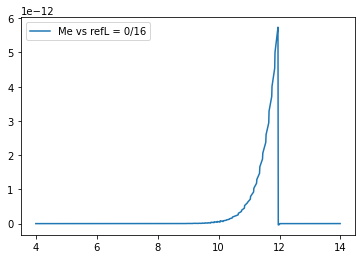

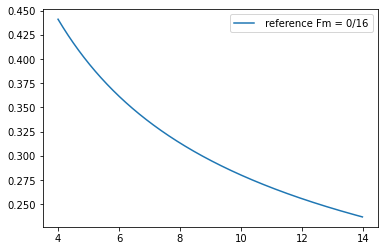

#################################################
21 16 0 Me vs ref 5.736688901691878e-12 # 
21 16 0 Me vs Seg 0.0 
#################################################
Error at  21 16 0  is  1.2346273532943397e-16


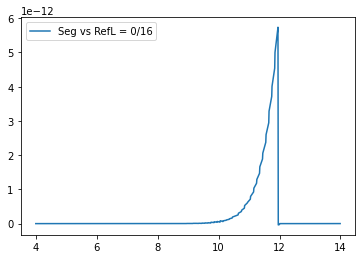

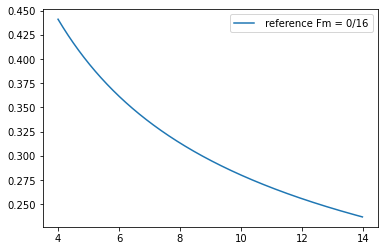

#################################################
21 16 0 Seg vs Ref 5.736688901691878e-12 # 

21 16 1 Me vs ref 2.3996256370839575e-13 
21 16 1 Me vs Seg 0.0 
21 16 1 Seg vs Ref 2.3996256370839575e-13 

21 16 2 Me vs ref 3.0163805481153716e-14 
21 16 2 Me vs Seg 0.0 
21 16 2 Seg vs Ref 3.0163805481153716e-14 

21 16 3 Me vs ref 6.2619180674072794e-15 
21 16 3 Me vs Seg 0.0 
21 16 3 Seg vs Ref 6.2619180674072794e-15 

21 16 4 Me vs ref 1.865261417544062e-15 
21 16 4 Me vs Seg 0.0 
21 16 4 Seg vs Ref 1.865261417544062e-15 

21 16 5 Me vs ref 6.807773203672263e-16 
21 16 5 Me vs Seg 0.0 
21 16 5 Seg vs Ref 6.807773203672263e-16 

21 16 6 Me vs ref 3.479611347320666e-16 
21 16 6 Me vs Seg 0.0 
21 16 6 Seg vs Ref 3.479611347320666e-16 

21 16 7 Me vs ref 1.6620395787729156e-16 
21 16 7 Me vs Seg 0.0 
21 16 7 Seg vs Ref 1.6620395787729156e-16 

21 16 8 Me vs ref 1.6045683933017113e-16 
21 16 8 Me vs Seg 0.0 
21 16 8 Seg vs Ref 1.6045683933017113e-16 

21 16 9 Me vs ref 1.0428352009239725e-1

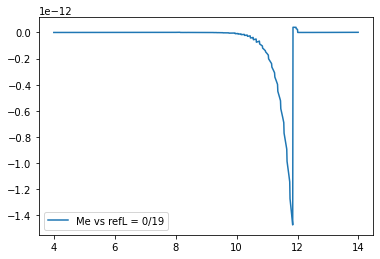

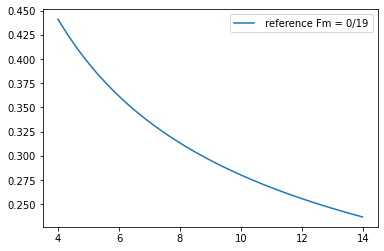

#################################################
21 19 0 Me vs ref 1.4747092436095954e-12 # 
21 19 0 Me vs Seg 0.0 
#################################################
Error at  21 19 0  is  1.2346273532943397e-16


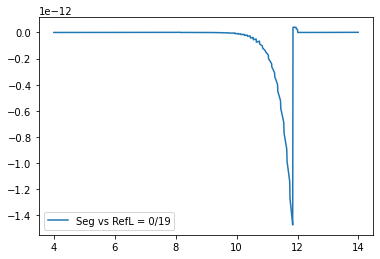

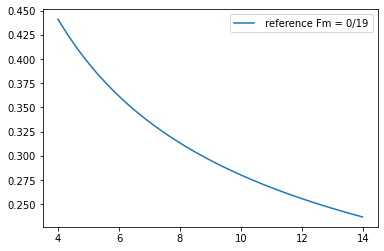

#################################################
21 19 0 Seg vs Ref 1.4747092436095954e-12 # 

21 19 1 Me vs ref 6.234422700313047e-14 
21 19 1 Me vs Seg 0.0 
21 19 1 Seg vs Ref 6.234422700313047e-14 

21 19 2 Me vs ref 7.864368878340855e-15 
21 19 2 Me vs Seg 0.0 
21 19 2 Seg vs Ref 7.864368878340855e-15 

21 19 3 Me vs ref 1.7057752779714441e-15 
21 19 3 Me vs Seg 0.0 
21 19 3 Seg vs Ref 1.7057752779714441e-15 

21 19 4 Me vs ref 4.798678815420843e-16 
21 19 4 Me vs Seg 0.0 
21 19 4 Seg vs Ref 4.798678815420843e-16 

21 19 5 Me vs ref 1.9991332807917095e-16 
21 19 5 Me vs Seg 0.0 
21 19 5 Seg vs Ref 1.9991332807917095e-16 

21 19 6 Me vs ref 1.0951966601408653e-16 
21 19 6 Me vs Seg 0.0 
21 19 6 Seg vs Ref 1.0951966601408653e-16 

21 19 7 Me vs ref 1.5584898009710774e-16 
21 19 7 Me vs Seg 0.0 
21 19 7 Seg vs Ref 1.5584898009710774e-16 

21 19 8 Me vs ref 1.0728095793449341e-16 
21 19 8 Me vs Seg 0.0 
21 19 8 Seg vs Ref 1.0728095793449341e-16 

21 19 9 Me vs ref 1.0428352009239725e-

22 5 0 Me vs ref 7.002731727823175e-13 
22 5 0 Me vs Seg 0.0 
22 5 0 Seg vs Ref 7.002731727823175e-13 

22 5 1 Me vs ref 3.056235819975939e-14 
22 5 1 Me vs Seg 0.0 
22 5 1 Seg vs Ref 3.056235819975939e-14 

22 5 2 Me vs ref 4.026293187742169e-15 
22 5 2 Me vs Seg 0.0 
22 5 2 Seg vs Ref 4.026293187742169e-15 

22 5 3 Me vs ref 8.550018332220688e-16 
22 5 3 Me vs Seg 0.0 
22 5 3 Seg vs Ref 8.550018332220688e-16 

22 5 4 Me vs ref 3.704583298111408e-16 
22 5 4 Me vs Seg 0.0 
22 5 4 Seg vs Ref 3.704583298111408e-16 

22 5 5 Me vs ref 1.5655879370690684e-16 
22 5 5 Me vs Seg 0.0 
22 5 5 Seg vs Ref 1.5655879370690684e-16 

22 6 0 Me vs ref 7.735478924075778e-13 
22 6 0 Me vs Seg 0.0 
22 6 0 Seg vs Ref 7.735478924075778e-13 

22 6 1 Me vs ref 3.745094512286329e-14 
22 6 1 Me vs Seg 0.0 
22 6 1 Seg vs Ref 3.745094512286329e-14 

22 6 2 Me vs ref 5.381979584218044e-15 
22 6 2 Me vs Seg 0.0 
22 6 2 Seg vs Ref 5.381979584218044e-15 

22 6 3 Me vs ref 1.3814361980724055e-15 
22 6 3 Me vs Seg 0.0 

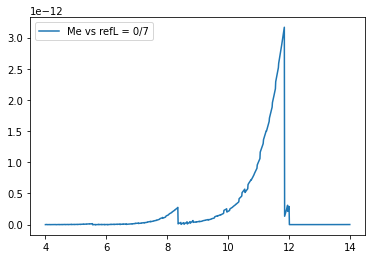

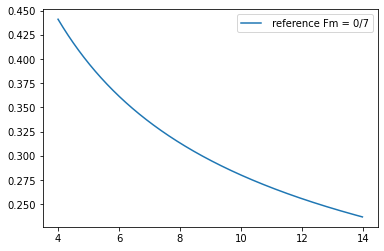

#################################################
22 7 0 Me vs ref 3.165356865508784e-12 # 
22 7 0 Me vs Seg 0.0 
#################################################
Error at  22 7 0  is  1.2346273532943397e-16


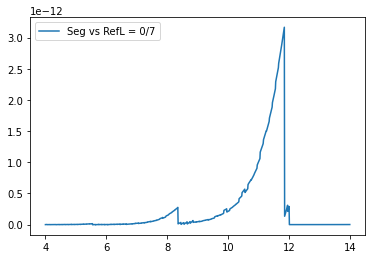

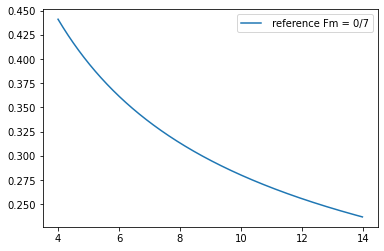

#################################################
22 7 0 Seg vs Ref 3.165356865508784e-12 # 

22 7 1 Me vs ref 1.3357544237369012e-13 
22 7 1 Me vs Seg 0.0 
22 7 1 Seg vs Ref 1.3357544237369012e-13 

22 7 2 Me vs ref 1.6952802009417844e-14 
22 7 2 Me vs Seg 0.0 
22 7 2 Seg vs Ref 1.6952802009417844e-14 

22 7 3 Me vs ref 3.5335233003475075e-15 
22 7 3 Me vs Seg 0.0 
22 7 3 Seg vs Ref 3.5335233003475075e-15 

22 7 4 Me vs ref 1.0686709763646496e-15 
22 7 4 Me vs Seg 0.0 
22 7 4 Seg vs Ref 1.0686709763646496e-15 

22 7 5 Me vs ref 3.885441773009146e-16 
22 7 5 Me vs Seg 0.0 
22 7 5 Seg vs Ref 3.885441773009146e-16 

22 7 6 Me vs ref 2.124528038303236e-16 
22 7 6 Me vs Seg 0.0 
22 7 6 Seg vs Ref 2.124528038303236e-16 

22 7 7 Me vs ref 1.2240642527361345e-16 
22 7 7 Me vs Seg 0.0 
22 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  22 8 0  is  1.2346273532943397e-16


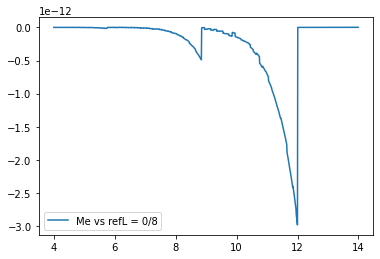

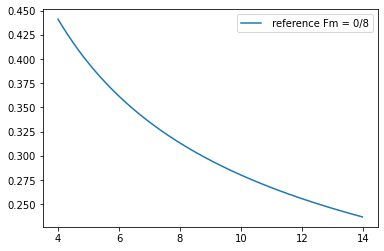

#################################################
22 8 0 Me vs ref 2.9816149549333204e-12 # 
22 8 0 Me vs Seg 0.0 
#################################################
Error at  22 8 0  is  1.2346273532943397e-16


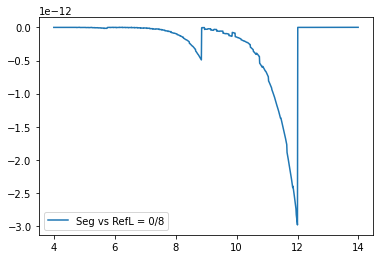

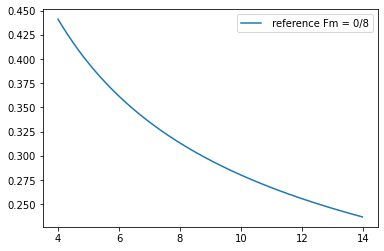

#################################################
22 8 0 Seg vs Ref 2.9816149549333204e-12 # 

22 8 1 Me vs ref 1.2435018292844546e-13 
22 8 1 Me vs Seg 0.0 
22 8 1 Seg vs Ref 1.2435018292844546e-13 

22 8 2 Me vs ref 1.5503223704804725e-14 
22 8 2 Me vs Seg 0.0 
22 8 2 Seg vs Ref 1.5503223704804725e-14 

22 8 3 Me vs ref 3.2831810187206045e-15 
22 8 3 Me vs Seg 0.0 
22 8 3 Seg vs Ref 3.2831810187206045e-15 

22 8 4 Me vs ref 9.31871767251291e-16 
22 8 4 Me vs Seg 0.0 
22 8 4 Seg vs Ref 9.31871767251291e-16 

22 8 5 Me vs ref 3.7119694254114655e-16 
22 8 5 Me vs Seg 0.0 
22 8 5 Seg vs Ref 3.7119694254114655e-16 

22 8 6 Me vs ref 1.4072944198861848e-16 
22 8 6 Me vs Seg 0.0 
22 8 6 Seg vs Ref 1.4072944198861848e-16 

22 8 7 Me vs ref 1.8633877806647353e-16 
22 8 7 Me vs Seg 0.0 
22 8 7 Seg vs Ref 1.8633877806647353e-16 

22 8 8 Me vs ref 1.0728095793449341e-16 
22 8 8 Me vs Seg 0.0 
22 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  2

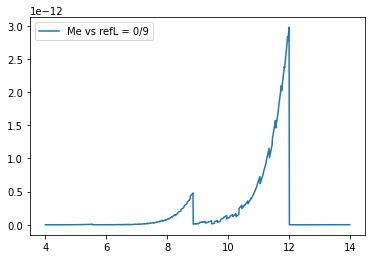

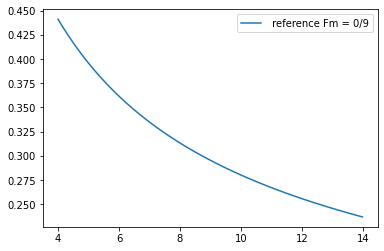

#################################################
22 9 0 Me vs ref 2.9801716650013077e-12 # 
22 9 0 Me vs Seg 0.0 
#################################################
Error at  22 9 0  is  1.2346273532943397e-16


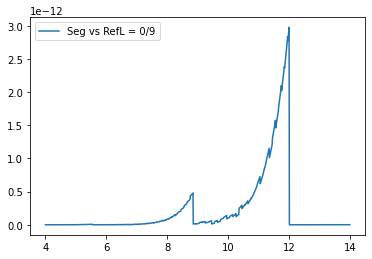

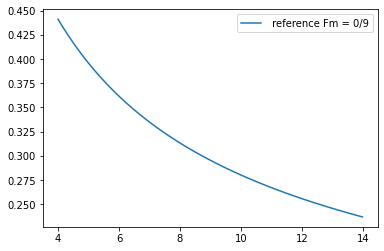

#################################################
22 9 0 Seg vs Ref 2.9801716650013077e-12 # 

22 9 1 Me vs ref 1.2409691330095285e-13 
22 9 1 Me vs Seg 0.0 
22 9 1 Seg vs Ref 1.2409691330095285e-13 

22 9 2 Me vs ref 1.5557650653863497e-14 
22 9 2 Me vs Seg 0.0 
22 9 2 Seg vs Ref 1.5557650653863497e-14 

22 9 3 Me vs ref 3.18890963982299e-15 
22 9 3 Me vs Seg 0.0 
22 9 3 Seg vs Ref 3.18890963982299e-15 

22 9 4 Me vs ref 9.561307908606542e-16 
22 9 4 Me vs Seg 0.0 
22 9 4 Seg vs Ref 9.561307908606542e-16 

22 9 5 Me vs ref 3.369192132316595e-16 
22 9 5 Me vs Seg 0.0 
22 9 5 Seg vs Ref 3.369192132316595e-16 

22 9 6 Me vs ref 1.9072810279914532e-16 
22 9 6 Me vs Seg 0.0 
22 9 6 Seg vs Ref 1.9072810279914532e-16 

22 9 7 Me vs ref 1.127231446206023e-16 
22 9 7 Me vs Seg 0.0 
22 9 7 Seg vs Ref 1.127231446206023e-16 

22 9 8 Me vs ref 2.041755978697546e-16 
22 9 8 Me vs Seg 0.0 
22 9 8 Seg vs Ref 2.041755978697546e-16 

22 9 9 Me vs ref 1.1075125191939428e-16 
22 9 9 Me vs Seg 0.0 
22 9 9

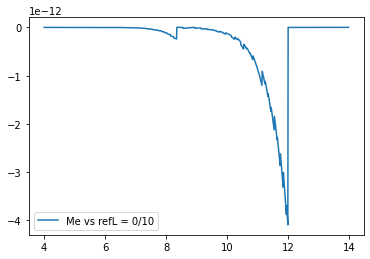

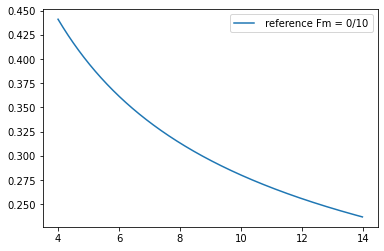

#################################################
22 10 0 Me vs ref 4.092226557617096e-12 # 
22 10 0 Me vs Seg 0.0 
#################################################
Error at  22 10 0  is  1.2346273532943397e-16


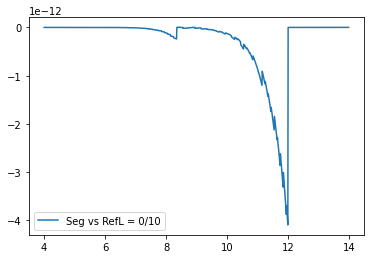

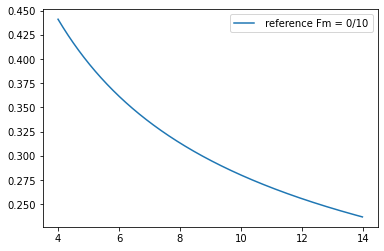

#################################################
22 10 0 Seg vs Ref 4.092226557617096e-12 # 

22 10 1 Me vs ref 1.7063433999098265e-13 
22 10 1 Me vs Seg 0.0 
22 10 1 Seg vs Ref 1.7063433999098265e-13 

22 10 2 Me vs ref 2.1289610699359862e-14 
22 10 2 Me vs Seg 0.0 
22 10 2 Seg vs Ref 2.1289610699359862e-14 

22 10 3 Me vs ref 4.48886804463311e-15 
22 10 3 Me vs Seg 0.0 
22 10 3 Seg vs Ref 4.48886804463311e-15 

22 10 4 Me vs ref 1.2835869520055887e-15 
22 10 4 Me vs Seg 0.0 
22 10 4 Seg vs Ref 1.2835869520055887e-15 

22 10 5 Me vs ref 5.031104656147423e-16 
22 10 5 Me vs Seg 0.0 
22 10 5 Seg vs Ref 5.031104656147423e-16 

22 10 6 Me vs ref 1.9510048687287201e-16 
22 10 6 Me vs Seg 0.0 
22 10 6 Seg vs Ref 1.9510048687287201e-16 

22 10 7 Me vs ref 2.1514128640490876e-16 
22 10 7 Me vs Seg 0.0 
22 10 7 Seg vs Ref 2.1514128640490876e-16 

22 10 8 Me vs ref 1.0728095793449341e-16 
22 10 8 Me vs Seg 0.0 
22 10 8 Seg vs Ref 1.0728095793449341e-16 

22 10 9 Me vs ref 1.4288429380643342e-1

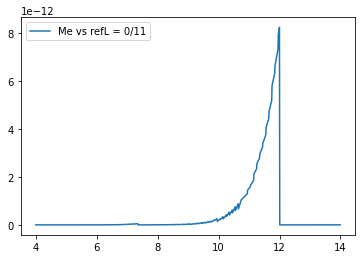

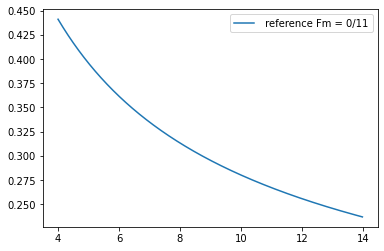

#################################################
22 11 0 Me vs ref 8.238909554592055e-12 # 
22 11 0 Me vs Seg 0.0 
#################################################
Error at  22 11 0  is  1.2346273532943397e-16


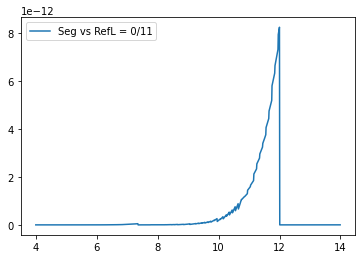

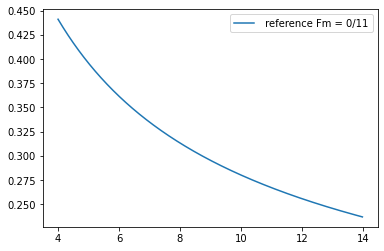

#################################################
22 11 0 Seg vs Ref 8.238909554592055e-12 # 

22 11 1 Me vs ref 3.4324799946805484e-13 
22 11 1 Me vs Seg 0.0 
22 11 1 Seg vs Ref 3.4324799946805484e-13 

22 11 2 Me vs ref 4.2956090073875686e-14 
22 11 2 Me vs Seg 0.0 
22 11 2 Seg vs Ref 4.2956090073875686e-14 

22 11 3 Me vs ref 8.897830389154038e-15 
22 11 3 Me vs Seg 0.0 
22 11 3 Seg vs Ref 8.897830389154038e-15 

22 11 4 Me vs ref 2.621492432852701e-15 
22 11 4 Me vs Seg 0.0 
22 11 4 Seg vs Ref 2.621492432852701e-15 

22 11 5 Me vs ref 9.615348610641367e-16 
22 11 5 Me vs Seg 0.0 
22 11 5 Seg vs Ref 9.615348610641367e-16 

22 11 6 Me vs ref 4.771573761108705e-16 
22 11 6 Me vs Seg 0.0 
22 11 6 Seg vs Ref 4.771573761108705e-16 

22 11 7 Me vs ref 2.3406146134772807e-16 
22 11 7 Me vs Seg 0.0 
22 11 7 Seg vs Ref 2.3406146134772807e-16 

22 11 8 Me vs ref 2.0680394110508468e-16 
22 11 8 Me vs Seg 0.0 
22 11 8 Seg vs Ref 2.0680394110508468e-16 

22 11 9 Me vs ref 1.0428352009239725e-16 

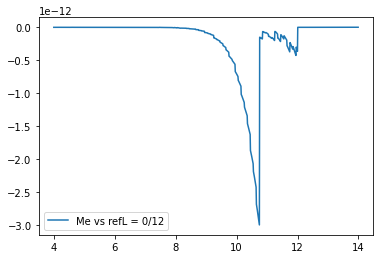

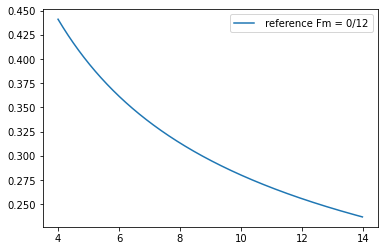

#################################################
22 12 0 Me vs ref 3.0024871477962733e-12 # 
22 12 0 Me vs Seg 0.0 
#################################################
Error at  22 12 0  is  1.2346273532943397e-16


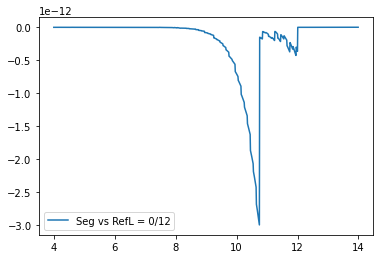

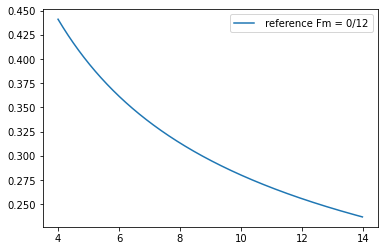

#################################################
22 12 0 Seg vs Ref 3.0024871477962733e-12 # 

22 12 1 Me vs ref 1.3968340373260446e-13 
22 12 1 Me vs Seg 0.0 
22 12 1 Seg vs Ref 1.3968340373260446e-13 

22 12 2 Me vs ref 1.943345658006468e-14 
22 12 2 Me vs Seg 0.0 
22 12 2 Seg vs Ref 1.943345658006468e-14 

22 12 3 Me vs ref 4.642120021713936e-15 
22 12 3 Me vs Seg 0.0 
22 12 3 Seg vs Ref 4.642120021713936e-15 

22 12 4 Me vs ref 1.421117997585375e-15 
22 12 4 Me vs Seg 0.0 
22 12 4 Seg vs Ref 1.421117997585375e-15 

22 12 5 Me vs ref 6.816311295780586e-16 
22 12 5 Me vs Seg 0.0 
22 12 5 Seg vs Ref 6.816311295780586e-16 

22 12 6 Me vs ref 3.0536893001233134e-16 
22 12 6 Me vs Seg 0.0 
22 12 6 Seg vs Ref 3.0536893001233134e-16 

22 12 7 Me vs ref 2.3753006126673443e-16 
22 12 7 Me vs Seg 0.0 
22 12 7 Seg vs Ref 2.3753006126673443e-16 

22 12 8 Me vs ref 1.1363455207184792e-16 
22 12 8 Me vs Seg 0.0 
22 12 8 Seg vs Ref 1.1363455207184792e-16 

22 12 9 Me vs ref 1.2217603231196028e-16

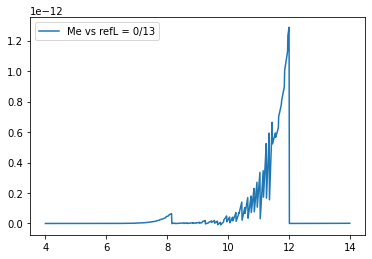

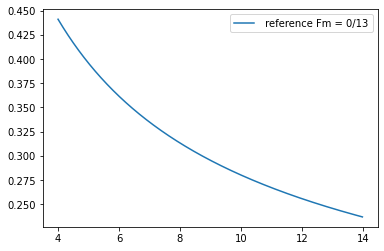

#################################################
22 13 0 Me vs ref 1.2879142197164128e-12 # 
22 13 0 Me vs Seg 0.0 
#################################################
Error at  22 13 0  is  1.2346273532943397e-16


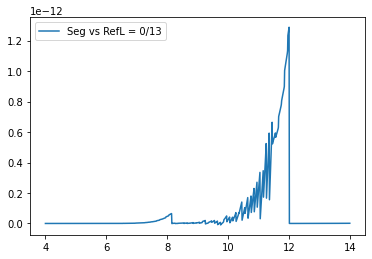

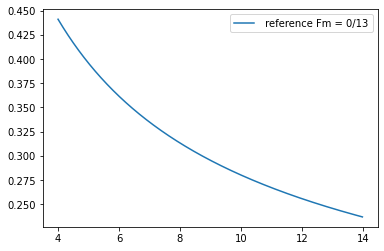

#################################################
22 13 0 Seg vs Ref 1.2879142197164128e-12 # 

22 13 1 Me vs ref 5.357519983206771e-14 
22 13 1 Me vs Seg 0.0 
22 13 1 Seg vs Ref 5.357519983206771e-14 

22 13 2 Me vs ref 6.740918587211375e-15 
22 13 2 Me vs Seg 0.0 
22 13 2 Seg vs Ref 6.740918587211375e-15 

22 13 3 Me vs ref 1.351783268654927e-15 
22 13 3 Me vs Seg 0.0 
22 13 3 Seg vs Ref 1.351783268654927e-15 

22 13 4 Me vs ref 4.224593765089768e-16 
22 13 4 Me vs Seg 0.0 
22 13 4 Seg vs Ref 4.224593765089768e-16 

22 13 5 Me vs ref 1.3723627811414174e-16 
22 13 5 Me vs Seg 0.0 
22 13 5 Seg vs Ref 1.3723627811414174e-16 

22 13 6 Me vs ref 1.1897763590312804e-16 
22 13 6 Me vs Seg 0.0 
22 13 6 Seg vs Ref 1.1897763590312804e-16 

22 13 7 Me vs ref 1.0560129160008813e-16 
22 13 7 Me vs Seg 0.0 
22 13 7 Seg vs Ref 1.0560129160008813e-16 

22 13 8 Me vs ref 1.0728095793449341e-16 
22 13 8 Me vs Seg 0.0 
22 13 8 Seg vs Ref 1.0728095793449341e-16 

22 13 9 Me vs ref 1.0428352009239725e-16

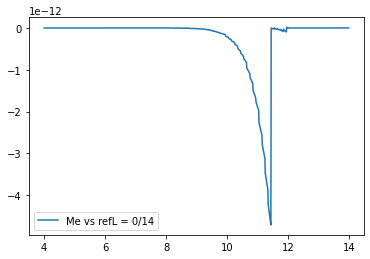

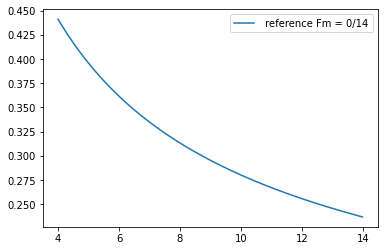

#################################################
22 14 0 Me vs ref 4.70939953700622e-12 # 
22 14 0 Me vs Seg 0.0 
#################################################
Error at  22 14 0  is  1.2346273532943397e-16


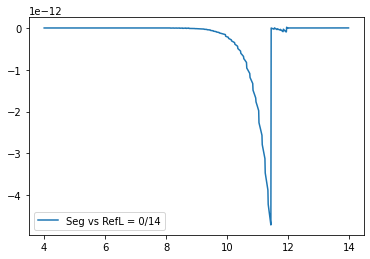

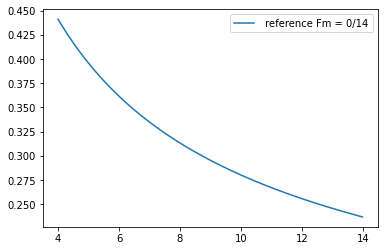

#################################################
22 14 0 Seg vs Ref 4.70939953700622e-12 # 

22 14 1 Me vs ref 2.0584575710635988e-13 
22 14 1 Me vs Seg 0.0 
22 14 1 Seg vs Ref 2.0584575710635988e-13 

22 14 2 Me vs ref 2.696757747666645e-14 
22 14 2 Me vs Seg 0.0 
22 14 2 Seg vs Ref 2.696757747666645e-14 

22 14 3 Me vs ref 5.917304406882762e-15 
22 14 3 Me vs Seg 0.0 
22 14 3 Seg vs Ref 5.917304406882762e-15 

22 14 4 Me vs ref 1.701235181374161e-15 
22 14 4 Me vs Seg 0.0 
22 14 4 Seg vs Ref 1.701235181374161e-15 

22 14 5 Me vs ref 8.192367140572032e-16 
22 14 5 Me vs Seg 0.0 
22 14 5 Seg vs Ref 8.192367140572032e-16 

22 14 6 Me vs ref 3.245084864884895e-16 
22 14 6 Me vs Seg 0.0 
22 14 6 Seg vs Ref 3.245084864884895e-16 

22 14 7 Me vs ref 2.7412866085169824e-16 
22 14 7 Me vs Seg 0.0 
22 14 7 Seg vs Ref 2.7412866085169824e-16 

22 14 8 Me vs ref 1.0728095793449341e-16 
22 14 8 Me vs Seg 0.0 
22 14 8 Seg vs Ref 1.0728095793449341e-16 

22 14 9 Me vs ref 1.2060478619480355e-16 
22

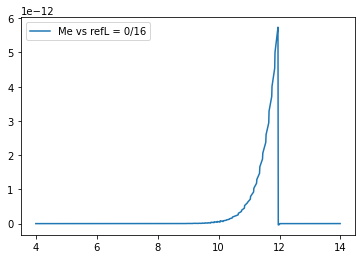

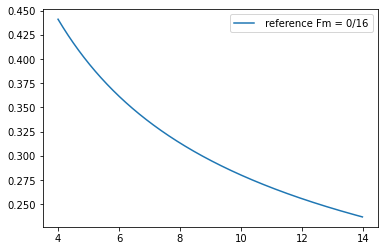

#################################################
22 16 0 Me vs ref 5.736688901691878e-12 # 
22 16 0 Me vs Seg 0.0 
#################################################
Error at  22 16 0  is  1.2346273532943397e-16


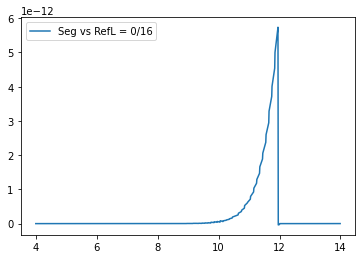

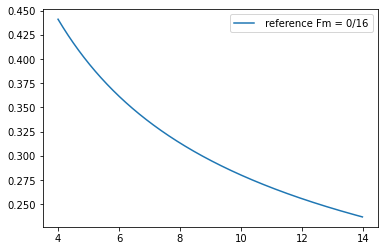

#################################################
22 16 0 Seg vs Ref 5.736688901691878e-12 # 

22 16 1 Me vs ref 2.3996256370839575e-13 
22 16 1 Me vs Seg 0.0 
22 16 1 Seg vs Ref 2.3996256370839575e-13 

22 16 2 Me vs ref 3.0163805481153716e-14 
22 16 2 Me vs Seg 0.0 
22 16 2 Seg vs Ref 3.0163805481153716e-14 

22 16 3 Me vs ref 6.2619180674072794e-15 
22 16 3 Me vs Seg 0.0 
22 16 3 Seg vs Ref 6.2619180674072794e-15 

22 16 4 Me vs ref 1.865261417544062e-15 
22 16 4 Me vs Seg 0.0 
22 16 4 Seg vs Ref 1.865261417544062e-15 

22 16 5 Me vs ref 6.807773203672263e-16 
22 16 5 Me vs Seg 0.0 
22 16 5 Seg vs Ref 6.807773203672263e-16 

22 16 6 Me vs ref 3.479611347320666e-16 
22 16 6 Me vs Seg 0.0 
22 16 6 Seg vs Ref 3.479611347320666e-16 

22 16 7 Me vs ref 1.6620395787729156e-16 
22 16 7 Me vs Seg 0.0 
22 16 7 Seg vs Ref 1.6620395787729156e-16 

22 16 8 Me vs ref 1.6045683933017113e-16 
22 16 8 Me vs Seg 0.0 
22 16 8 Seg vs Ref 1.6045683933017113e-16 

22 16 9 Me vs ref 1.0428352009239725e-1

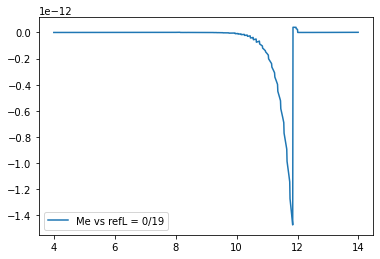

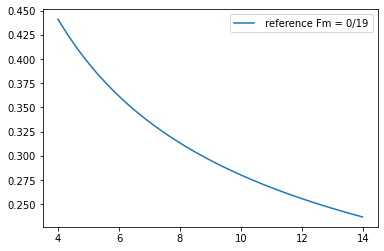

#################################################
22 19 0 Me vs ref 1.4747092436095954e-12 # 
22 19 0 Me vs Seg 0.0 
#################################################
Error at  22 19 0  is  1.2346273532943397e-16


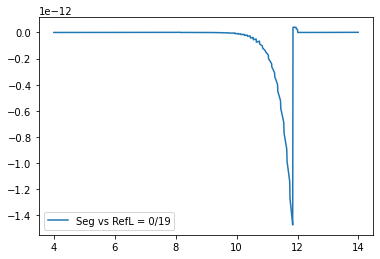

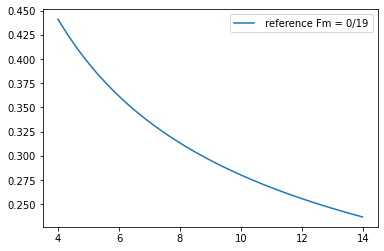

#################################################
22 19 0 Seg vs Ref 1.4747092436095954e-12 # 

22 19 1 Me vs ref 6.234422700313047e-14 
22 19 1 Me vs Seg 0.0 
22 19 1 Seg vs Ref 6.234422700313047e-14 

22 19 2 Me vs ref 7.864368878340855e-15 
22 19 2 Me vs Seg 0.0 
22 19 2 Seg vs Ref 7.864368878340855e-15 

22 19 3 Me vs ref 1.7057752779714441e-15 
22 19 3 Me vs Seg 0.0 
22 19 3 Seg vs Ref 1.7057752779714441e-15 

22 19 4 Me vs ref 4.798678815420843e-16 
22 19 4 Me vs Seg 0.0 
22 19 4 Seg vs Ref 4.798678815420843e-16 

22 19 5 Me vs ref 1.9991332807917095e-16 
22 19 5 Me vs Seg 0.0 
22 19 5 Seg vs Ref 1.9991332807917095e-16 

22 19 6 Me vs ref 1.0951966601408653e-16 
22 19 6 Me vs Seg 0.0 
22 19 6 Seg vs Ref 1.0951966601408653e-16 

22 19 7 Me vs ref 1.5584898009710774e-16 
22 19 7 Me vs Seg 0.0 
22 19 7 Seg vs Ref 1.5584898009710774e-16 

22 19 8 Me vs ref 1.0728095793449341e-16 
22 19 8 Me vs Seg 0.0 
22 19 8 Seg vs Ref 1.0728095793449341e-16 

22 19 9 Me vs ref 1.0428352009239725e-

23 0 0 Me vs ref 1.1657341758564144e-15 
23 0 0 Me vs Seg 0.0 
23 0 0 Seg vs Ref 1.1657341758564144e-15 

23 1 0 Me vs ref 2.55351295663786e-15 
23 1 0 Me vs Seg 0.0 
23 1 0 Seg vs Ref 2.55351295663786e-15 

23 1 1 Me vs ref 2.914335439641036e-16 
23 1 1 Me vs Seg 0.0 
23 1 1 Seg vs Ref 2.914335439641036e-16 

23 2 0 Me vs ref 1.7819079545233762e-14 
23 2 0 Me vs Seg 0.0 
23 2 0 Seg vs Ref 1.7819079545233762e-14 

23 2 1 Me vs ref 8.205242041370298e-16 
23 2 1 Me vs Seg 0.0 
23 2 1 Seg vs Ref 8.205242041370298e-16 

23 2 2 Me vs ref 1.5092094240998222e-16 
23 2 2 Me vs Seg 0.0 
23 2 2 Seg vs Ref 1.5092094240998222e-16 

23 3 0 Me vs ref 7.077671781985373e-14 
23 3 0 Me vs Seg 0.0 
23 3 0 Seg vs Ref 7.077671781985373e-14 

23 3 1 Me vs ref 3.2855662635000726e-15 
23 3 1 Me vs Seg 0.0 
23 3 1 Seg vs Ref 3.2855662635000726e-15 

23 3 2 Me vs ref 5.193328406205566e-16 
23 3 2 Me vs Seg 0.0 
23 3 2 Seg vs Ref 5.193328406205566e-16 

23 3 3 Me vs ref 2.220446049250313e-16 
23 3 3 Me vs Seg 0

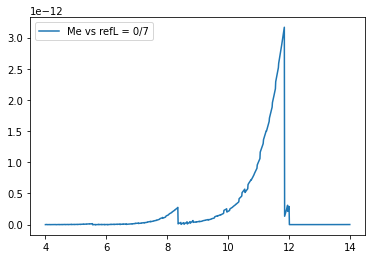

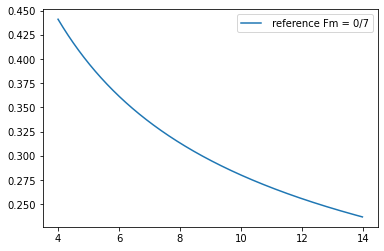

#################################################
23 7 0 Me vs ref 3.165356865508784e-12 # 
23 7 0 Me vs Seg 0.0 
#################################################
Error at  23 7 0  is  1.2346273532943397e-16


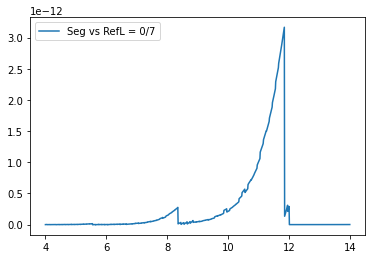

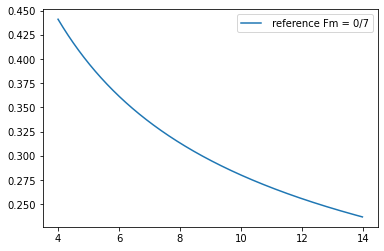

#################################################
23 7 0 Seg vs Ref 3.165356865508784e-12 # 

23 7 1 Me vs ref 1.3357544237369012e-13 
23 7 1 Me vs Seg 0.0 
23 7 1 Seg vs Ref 1.3357544237369012e-13 

23 7 2 Me vs ref 1.6952802009417844e-14 
23 7 2 Me vs Seg 0.0 
23 7 2 Seg vs Ref 1.6952802009417844e-14 

23 7 3 Me vs ref 3.5335233003475075e-15 
23 7 3 Me vs Seg 0.0 
23 7 3 Seg vs Ref 3.5335233003475075e-15 

23 7 4 Me vs ref 1.0686709763646496e-15 
23 7 4 Me vs Seg 0.0 
23 7 4 Seg vs Ref 1.0686709763646496e-15 

23 7 5 Me vs ref 3.885441773009146e-16 
23 7 5 Me vs Seg 0.0 
23 7 5 Seg vs Ref 3.885441773009146e-16 

23 7 6 Me vs ref 2.124528038303236e-16 
23 7 6 Me vs Seg 0.0 
23 7 6 Seg vs Ref 2.124528038303236e-16 

23 7 7 Me vs ref 1.2240642527361345e-16 
23 7 7 Me vs Seg 0.0 
23 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  23 8 0  is  1.2346273532943397e-16


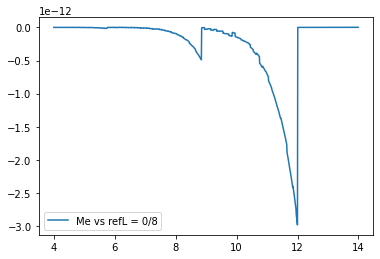

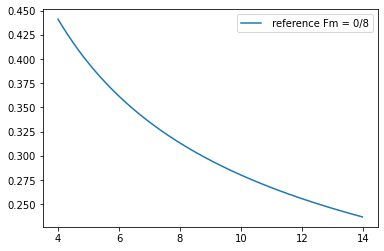

#################################################
23 8 0 Me vs ref 2.9816149549333204e-12 # 
23 8 0 Me vs Seg 0.0 
#################################################
Error at  23 8 0  is  1.2346273532943397e-16


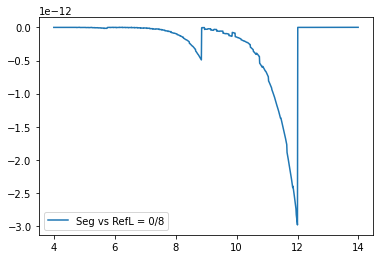

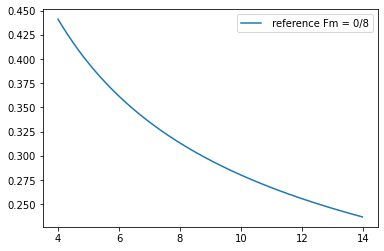

#################################################
23 8 0 Seg vs Ref 2.9816149549333204e-12 # 

23 8 1 Me vs ref 1.2435018292844546e-13 
23 8 1 Me vs Seg 0.0 
23 8 1 Seg vs Ref 1.2435018292844546e-13 

23 8 2 Me vs ref 1.5503223704804725e-14 
23 8 2 Me vs Seg 0.0 
23 8 2 Seg vs Ref 1.5503223704804725e-14 

23 8 3 Me vs ref 3.2831810187206045e-15 
23 8 3 Me vs Seg 0.0 
23 8 3 Seg vs Ref 3.2831810187206045e-15 

23 8 4 Me vs ref 9.31871767251291e-16 
23 8 4 Me vs Seg 0.0 
23 8 4 Seg vs Ref 9.31871767251291e-16 

23 8 5 Me vs ref 3.7119694254114655e-16 
23 8 5 Me vs Seg 0.0 
23 8 5 Seg vs Ref 3.7119694254114655e-16 

23 8 6 Me vs ref 1.4072944198861848e-16 
23 8 6 Me vs Seg 0.0 
23 8 6 Seg vs Ref 1.4072944198861848e-16 

23 8 7 Me vs ref 1.8633877806647353e-16 
23 8 7 Me vs Seg 0.0 
23 8 7 Seg vs Ref 1.8633877806647353e-16 

23 8 8 Me vs ref 1.0728095793449341e-16 
23 8 8 Me vs Seg 0.0 
23 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  2

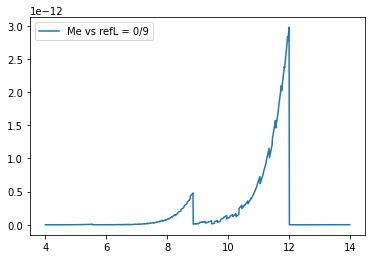

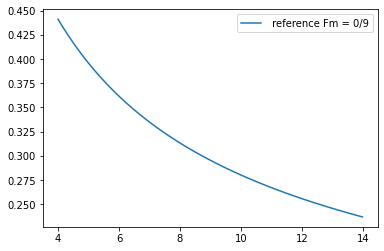

#################################################
23 9 0 Me vs ref 2.9801716650013077e-12 # 
23 9 0 Me vs Seg 0.0 
#################################################
Error at  23 9 0  is  1.2346273532943397e-16


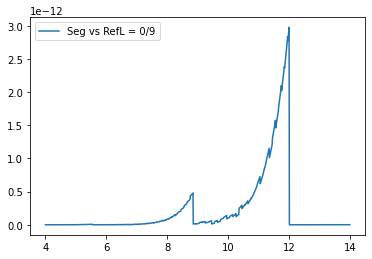

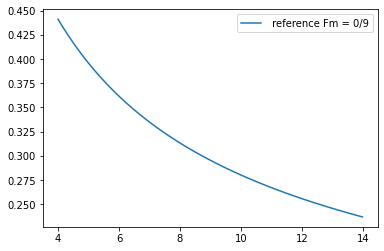

#################################################
23 9 0 Seg vs Ref 2.9801716650013077e-12 # 

23 9 1 Me vs ref 1.2409691330095285e-13 
23 9 1 Me vs Seg 0.0 
23 9 1 Seg vs Ref 1.2409691330095285e-13 

23 9 2 Me vs ref 1.5557650653863497e-14 
23 9 2 Me vs Seg 0.0 
23 9 2 Seg vs Ref 1.5557650653863497e-14 

23 9 3 Me vs ref 3.18890963982299e-15 
23 9 3 Me vs Seg 0.0 
23 9 3 Seg vs Ref 3.18890963982299e-15 

23 9 4 Me vs ref 9.561307908606542e-16 
23 9 4 Me vs Seg 0.0 
23 9 4 Seg vs Ref 9.561307908606542e-16 

23 9 5 Me vs ref 3.369192132316595e-16 
23 9 5 Me vs Seg 0.0 
23 9 5 Seg vs Ref 3.369192132316595e-16 

23 9 6 Me vs ref 1.9072810279914532e-16 
23 9 6 Me vs Seg 0.0 
23 9 6 Seg vs Ref 1.9072810279914532e-16 

23 9 7 Me vs ref 1.127231446206023e-16 
23 9 7 Me vs Seg 0.0 
23 9 7 Seg vs Ref 1.127231446206023e-16 

23 9 8 Me vs ref 2.041755978697546e-16 
23 9 8 Me vs Seg 0.0 
23 9 8 Seg vs Ref 2.041755978697546e-16 

23 9 9 Me vs ref 1.1075125191939428e-16 
23 9 9 Me vs Seg 0.0 
23 9 9

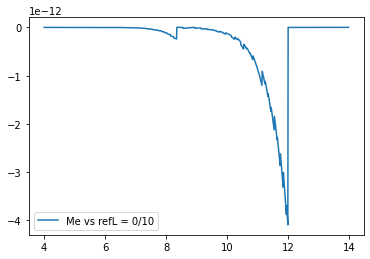

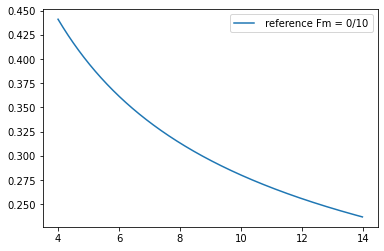

#################################################
23 10 0 Me vs ref 4.092226557617096e-12 # 
23 10 0 Me vs Seg 0.0 
#################################################
Error at  23 10 0  is  1.2346273532943397e-16


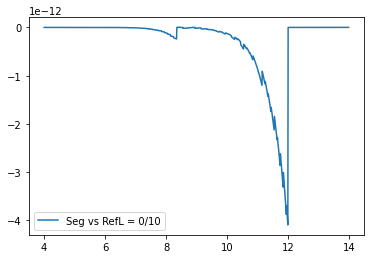

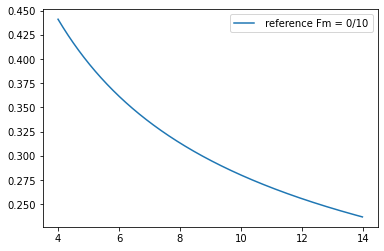

#################################################
23 10 0 Seg vs Ref 4.092226557617096e-12 # 

23 10 1 Me vs ref 1.7063433999098265e-13 
23 10 1 Me vs Seg 0.0 
23 10 1 Seg vs Ref 1.7063433999098265e-13 

23 10 2 Me vs ref 2.1289610699359862e-14 
23 10 2 Me vs Seg 0.0 
23 10 2 Seg vs Ref 2.1289610699359862e-14 

23 10 3 Me vs ref 4.48886804463311e-15 
23 10 3 Me vs Seg 0.0 
23 10 3 Seg vs Ref 4.48886804463311e-15 

23 10 4 Me vs ref 1.2835869520055887e-15 
23 10 4 Me vs Seg 0.0 
23 10 4 Seg vs Ref 1.2835869520055887e-15 

23 10 5 Me vs ref 5.031104656147423e-16 
23 10 5 Me vs Seg 0.0 
23 10 5 Seg vs Ref 5.031104656147423e-16 

23 10 6 Me vs ref 1.9510048687287201e-16 
23 10 6 Me vs Seg 0.0 
23 10 6 Seg vs Ref 1.9510048687287201e-16 

23 10 7 Me vs ref 2.1514128640490876e-16 
23 10 7 Me vs Seg 0.0 
23 10 7 Seg vs Ref 2.1514128640490876e-16 

23 10 8 Me vs ref 1.0728095793449341e-16 
23 10 8 Me vs Seg 0.0 
23 10 8 Seg vs Ref 1.0728095793449341e-16 

23 10 9 Me vs ref 1.4288429380643342e-1

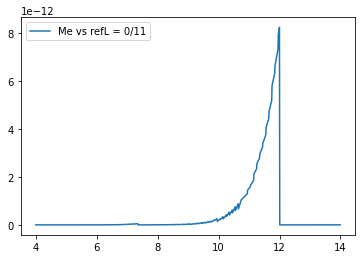

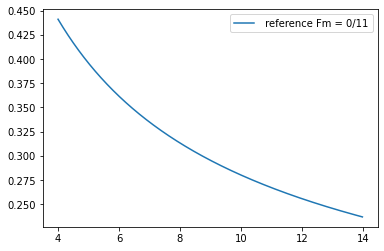

#################################################
23 11 0 Me vs ref 8.238909554592055e-12 # 
23 11 0 Me vs Seg 0.0 
#################################################
Error at  23 11 0  is  1.2346273532943397e-16


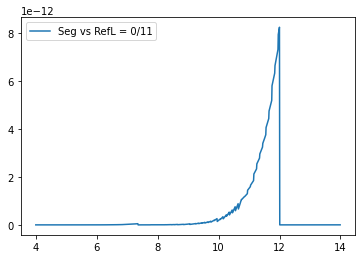

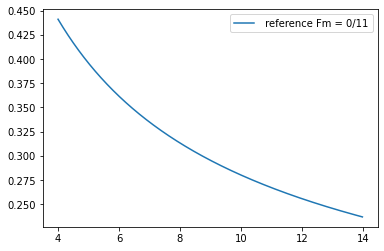

#################################################
23 11 0 Seg vs Ref 8.238909554592055e-12 # 

23 11 1 Me vs ref 3.4324799946805484e-13 
23 11 1 Me vs Seg 0.0 
23 11 1 Seg vs Ref 3.4324799946805484e-13 

23 11 2 Me vs ref 4.2956090073875686e-14 
23 11 2 Me vs Seg 0.0 
23 11 2 Seg vs Ref 4.2956090073875686e-14 

23 11 3 Me vs ref 8.897830389154038e-15 
23 11 3 Me vs Seg 0.0 
23 11 3 Seg vs Ref 8.897830389154038e-15 

23 11 4 Me vs ref 2.621492432852701e-15 
23 11 4 Me vs Seg 0.0 
23 11 4 Seg vs Ref 2.621492432852701e-15 

23 11 5 Me vs ref 9.615348610641367e-16 
23 11 5 Me vs Seg 0.0 
23 11 5 Seg vs Ref 9.615348610641367e-16 

23 11 6 Me vs ref 4.771573761108705e-16 
23 11 6 Me vs Seg 0.0 
23 11 6 Seg vs Ref 4.771573761108705e-16 

23 11 7 Me vs ref 2.3406146134772807e-16 
23 11 7 Me vs Seg 0.0 
23 11 7 Seg vs Ref 2.3406146134772807e-16 

23 11 8 Me vs ref 2.0680394110508468e-16 
23 11 8 Me vs Seg 0.0 
23 11 8 Seg vs Ref 2.0680394110508468e-16 

23 11 9 Me vs ref 1.0428352009239725e-16 

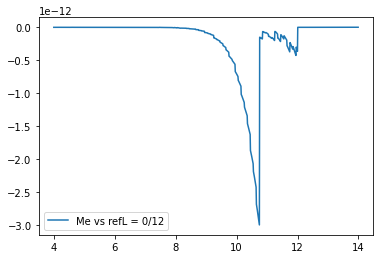

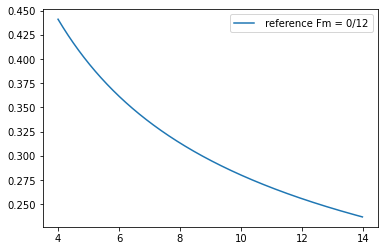

#################################################
23 12 0 Me vs ref 3.0024871477962733e-12 # 
23 12 0 Me vs Seg 0.0 
#################################################
Error at  23 12 0  is  1.2346273532943397e-16


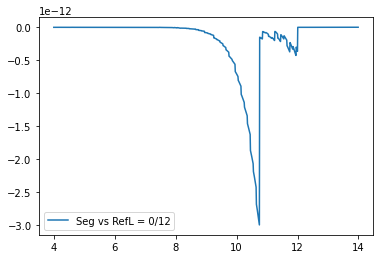

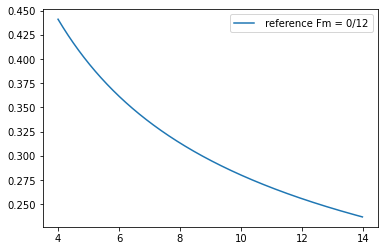

#################################################
23 12 0 Seg vs Ref 3.0024871477962733e-12 # 

23 12 1 Me vs ref 1.3968340373260446e-13 
23 12 1 Me vs Seg 0.0 
23 12 1 Seg vs Ref 1.3968340373260446e-13 

23 12 2 Me vs ref 1.943345658006468e-14 
23 12 2 Me vs Seg 0.0 
23 12 2 Seg vs Ref 1.943345658006468e-14 

23 12 3 Me vs ref 4.642120021713936e-15 
23 12 3 Me vs Seg 0.0 
23 12 3 Seg vs Ref 4.642120021713936e-15 

23 12 4 Me vs ref 1.421117997585375e-15 
23 12 4 Me vs Seg 0.0 
23 12 4 Seg vs Ref 1.421117997585375e-15 

23 12 5 Me vs ref 6.816311295780586e-16 
23 12 5 Me vs Seg 0.0 
23 12 5 Seg vs Ref 6.816311295780586e-16 

23 12 6 Me vs ref 3.0536893001233134e-16 
23 12 6 Me vs Seg 0.0 
23 12 6 Seg vs Ref 3.0536893001233134e-16 

23 12 7 Me vs ref 2.3753006126673443e-16 
23 12 7 Me vs Seg 0.0 
23 12 7 Seg vs Ref 2.3753006126673443e-16 

23 12 8 Me vs ref 1.1363455207184792e-16 
23 12 8 Me vs Seg 0.0 
23 12 8 Seg vs Ref 1.1363455207184792e-16 

23 12 9 Me vs ref 1.2217603231196028e-16

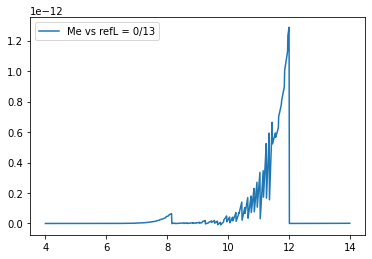

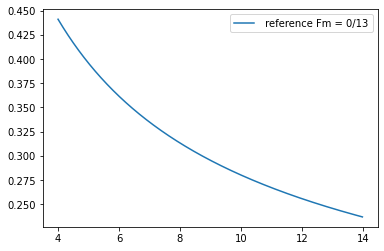

#################################################
23 13 0 Me vs ref 1.2879142197164128e-12 # 
23 13 0 Me vs Seg 0.0 
#################################################
Error at  23 13 0  is  1.2346273532943397e-16


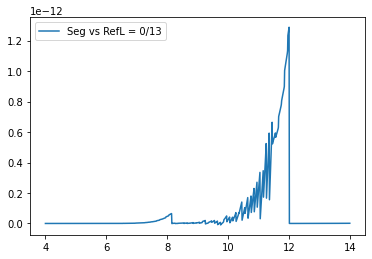

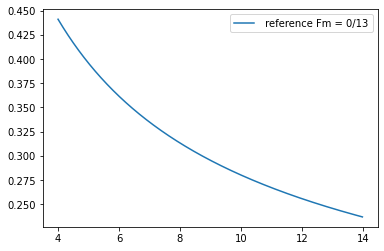

#################################################
23 13 0 Seg vs Ref 1.2879142197164128e-12 # 

23 13 1 Me vs ref 5.357519983206771e-14 
23 13 1 Me vs Seg 0.0 
23 13 1 Seg vs Ref 5.357519983206771e-14 

23 13 2 Me vs ref 6.740918587211375e-15 
23 13 2 Me vs Seg 0.0 
23 13 2 Seg vs Ref 6.740918587211375e-15 

23 13 3 Me vs ref 1.351783268654927e-15 
23 13 3 Me vs Seg 0.0 
23 13 3 Seg vs Ref 1.351783268654927e-15 

23 13 4 Me vs ref 4.224593765089768e-16 
23 13 4 Me vs Seg 0.0 
23 13 4 Seg vs Ref 4.224593765089768e-16 

23 13 5 Me vs ref 1.3723627811414174e-16 
23 13 5 Me vs Seg 0.0 
23 13 5 Seg vs Ref 1.3723627811414174e-16 

23 13 6 Me vs ref 1.1897763590312804e-16 
23 13 6 Me vs Seg 0.0 
23 13 6 Seg vs Ref 1.1897763590312804e-16 

23 13 7 Me vs ref 1.0560129160008813e-16 
23 13 7 Me vs Seg 0.0 
23 13 7 Seg vs Ref 1.0560129160008813e-16 

23 13 8 Me vs ref 1.0728095793449341e-16 
23 13 8 Me vs Seg 0.0 
23 13 8 Seg vs Ref 1.0728095793449341e-16 

23 13 9 Me vs ref 1.0428352009239725e-16

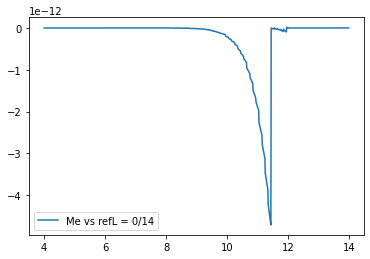

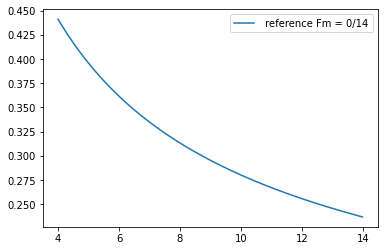

#################################################
23 14 0 Me vs ref 4.70939953700622e-12 # 
23 14 0 Me vs Seg 0.0 
#################################################
Error at  23 14 0  is  1.2346273532943397e-16


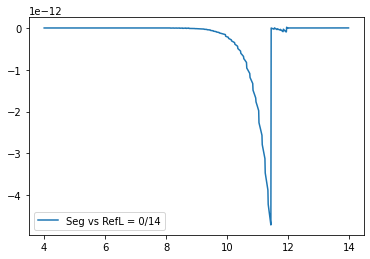

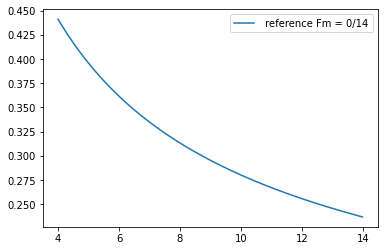

#################################################
23 14 0 Seg vs Ref 4.70939953700622e-12 # 

23 14 1 Me vs ref 2.0584575710635988e-13 
23 14 1 Me vs Seg 0.0 
23 14 1 Seg vs Ref 2.0584575710635988e-13 

23 14 2 Me vs ref 2.696757747666645e-14 
23 14 2 Me vs Seg 0.0 
23 14 2 Seg vs Ref 2.696757747666645e-14 

23 14 3 Me vs ref 5.917304406882762e-15 
23 14 3 Me vs Seg 0.0 
23 14 3 Seg vs Ref 5.917304406882762e-15 

23 14 4 Me vs ref 1.701235181374161e-15 
23 14 4 Me vs Seg 0.0 
23 14 4 Seg vs Ref 1.701235181374161e-15 

23 14 5 Me vs ref 8.192367140572032e-16 
23 14 5 Me vs Seg 0.0 
23 14 5 Seg vs Ref 8.192367140572032e-16 

23 14 6 Me vs ref 3.245084864884895e-16 
23 14 6 Me vs Seg 0.0 
23 14 6 Seg vs Ref 3.245084864884895e-16 

23 14 7 Me vs ref 2.7412866085169824e-16 
23 14 7 Me vs Seg 0.0 
23 14 7 Seg vs Ref 2.7412866085169824e-16 

23 14 8 Me vs ref 1.0728095793449341e-16 
23 14 8 Me vs Seg 0.0 
23 14 8 Seg vs Ref 1.0728095793449341e-16 

23 14 9 Me vs ref 1.2060478619480355e-16 
23

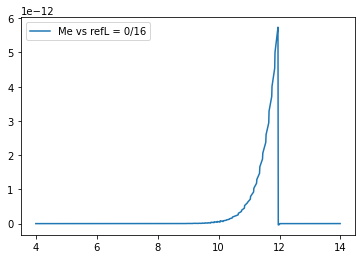

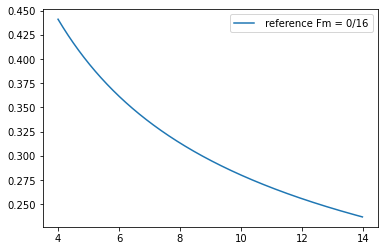

#################################################
23 16 0 Me vs ref 5.736688901691878e-12 # 
23 16 0 Me vs Seg 0.0 
#################################################
Error at  23 16 0  is  1.2346273532943397e-16


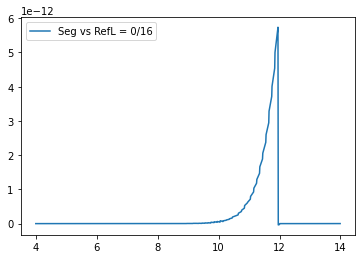

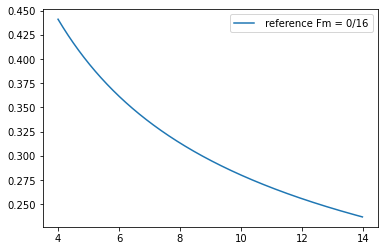

#################################################
23 16 0 Seg vs Ref 5.736688901691878e-12 # 

23 16 1 Me vs ref 2.3996256370839575e-13 
23 16 1 Me vs Seg 0.0 
23 16 1 Seg vs Ref 2.3996256370839575e-13 

23 16 2 Me vs ref 3.0163805481153716e-14 
23 16 2 Me vs Seg 0.0 
23 16 2 Seg vs Ref 3.0163805481153716e-14 

23 16 3 Me vs ref 6.2619180674072794e-15 
23 16 3 Me vs Seg 0.0 
23 16 3 Seg vs Ref 6.2619180674072794e-15 

23 16 4 Me vs ref 1.865261417544062e-15 
23 16 4 Me vs Seg 0.0 
23 16 4 Seg vs Ref 1.865261417544062e-15 

23 16 5 Me vs ref 6.807773203672263e-16 
23 16 5 Me vs Seg 0.0 
23 16 5 Seg vs Ref 6.807773203672263e-16 

23 16 6 Me vs ref 3.479611347320666e-16 
23 16 6 Me vs Seg 0.0 
23 16 6 Seg vs Ref 3.479611347320666e-16 

23 16 7 Me vs ref 1.6620395787729156e-16 
23 16 7 Me vs Seg 0.0 
23 16 7 Seg vs Ref 1.6620395787729156e-16 

23 16 8 Me vs ref 1.6045683933017113e-16 
23 16 8 Me vs Seg 0.0 
23 16 8 Seg vs Ref 1.6045683933017113e-16 

23 16 9 Me vs ref 1.0428352009239725e-1

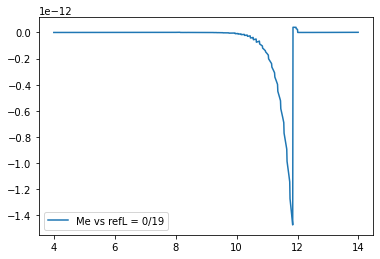

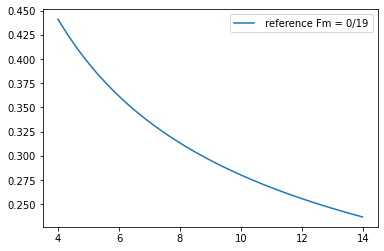

#################################################
23 19 0 Me vs ref 1.4747092436095954e-12 # 
23 19 0 Me vs Seg 0.0 
#################################################
Error at  23 19 0  is  1.2346273532943397e-16


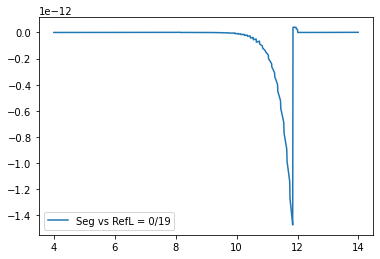

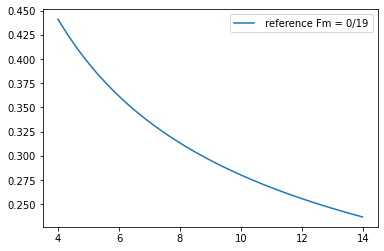

#################################################
23 19 0 Seg vs Ref 1.4747092436095954e-12 # 

23 19 1 Me vs ref 6.234422700313047e-14 
23 19 1 Me vs Seg 0.0 
23 19 1 Seg vs Ref 6.234422700313047e-14 

23 19 2 Me vs ref 7.864368878340855e-15 
23 19 2 Me vs Seg 0.0 
23 19 2 Seg vs Ref 7.864368878340855e-15 

23 19 3 Me vs ref 1.7057752779714441e-15 
23 19 3 Me vs Seg 0.0 
23 19 3 Seg vs Ref 1.7057752779714441e-15 

23 19 4 Me vs ref 4.798678815420843e-16 
23 19 4 Me vs Seg 0.0 
23 19 4 Seg vs Ref 4.798678815420843e-16 

23 19 5 Me vs ref 1.9991332807917095e-16 
23 19 5 Me vs Seg 0.0 
23 19 5 Seg vs Ref 1.9991332807917095e-16 

23 19 6 Me vs ref 1.0951966601408653e-16 
23 19 6 Me vs Seg 0.0 
23 19 6 Seg vs Ref 1.0951966601408653e-16 

23 19 7 Me vs ref 1.5584898009710774e-16 
23 19 7 Me vs Seg 0.0 
23 19 7 Seg vs Ref 1.5584898009710774e-16 

23 19 8 Me vs ref 1.0728095793449341e-16 
23 19 8 Me vs Seg 0.0 
23 19 8 Seg vs Ref 1.0728095793449341e-16 

23 19 9 Me vs ref 1.0428352009239725e-

23 23 0 Me vs ref 1.8129941992128806e-13 
23 23 0 Me vs Seg 0.0 
23 23 0 Seg vs Ref 1.8129941992128806e-13 

23 23 1 Me vs ref 7.504413757075667e-15 
23 23 1 Me vs Seg 0.0 
23 23 1 Seg vs Ref 7.504413757075667e-15 

23 23 2 Me vs ref 9.831545300098554e-16 
23 23 2 Me vs Seg 0.0 
23 23 2 Seg vs Ref 9.831545300098554e-16 

23 23 3 Me vs ref 1.5677563414140394e-16 
23 23 3 Me vs Seg 0.0 
23 23 3 Seg vs Ref 1.5677563414140394e-16 

23 23 4 Me vs ref 1.311613578164339e-16 
23 23 4 Me vs Seg 0.0 
23 23 4 Seg vs Ref 1.311613578164339e-16 

23 23 5 Me vs ref 1.0646865333807654e-16 
23 23 5 Me vs Seg 0.0 
23 23 5 Seg vs Ref 1.0646865333807654e-16 

23 23 6 Me vs ref 1.0951966601408653e-16 
23 23 6 Me vs Seg 0.0 
23 23 6 Seg vs Ref 1.0951966601408653e-16 

23 23 7 Me vs ref 1.056148441272442e-16 
23 23 7 Me vs Seg 0.0 
23 23 7 Seg vs Ref 1.056148441272442e-16 

23 23 8 Me vs ref 1.0728095793449341e-16 
23 23 8 Me vs Seg 0.0 
23 23 8 Seg vs Ref 1.0728095793449341e-16 

23 23 9 Me vs ref 1.0428352

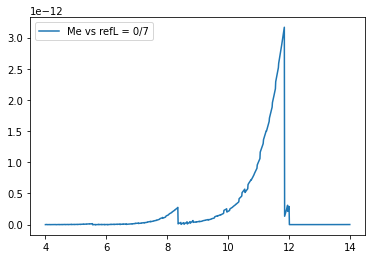

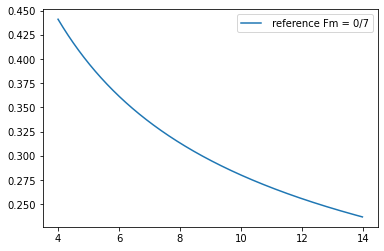

#################################################
24 7 0 Me vs ref 3.165356865508784e-12 # 
24 7 0 Me vs Seg 0.0 
#################################################
Error at  24 7 0  is  1.2346273532943397e-16


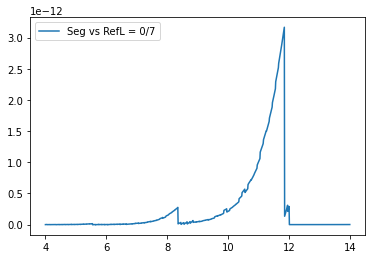

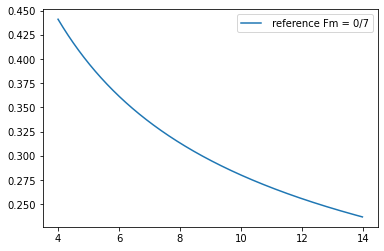

#################################################
24 7 0 Seg vs Ref 3.165356865508784e-12 # 

24 7 1 Me vs ref 1.3357544237369012e-13 
24 7 1 Me vs Seg 0.0 
24 7 1 Seg vs Ref 1.3357544237369012e-13 

24 7 2 Me vs ref 1.6952802009417844e-14 
24 7 2 Me vs Seg 0.0 
24 7 2 Seg vs Ref 1.6952802009417844e-14 

24 7 3 Me vs ref 3.5335233003475075e-15 
24 7 3 Me vs Seg 0.0 
24 7 3 Seg vs Ref 3.5335233003475075e-15 

24 7 4 Me vs ref 1.0686709763646496e-15 
24 7 4 Me vs Seg 0.0 
24 7 4 Seg vs Ref 1.0686709763646496e-15 

24 7 5 Me vs ref 3.885441773009146e-16 
24 7 5 Me vs Seg 0.0 
24 7 5 Seg vs Ref 3.885441773009146e-16 

24 7 6 Me vs ref 2.124528038303236e-16 
24 7 6 Me vs Seg 0.0 
24 7 6 Seg vs Ref 2.124528038303236e-16 

24 7 7 Me vs ref 1.2240642527361345e-16 
24 7 7 Me vs Seg 0.0 
24 7 7 Seg vs Ref 1.2240642527361345e-16 

#################################################
Error at  24 8 0  is  1.2346273532943397e-16


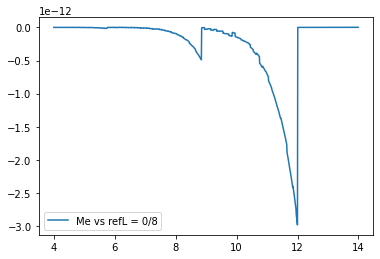

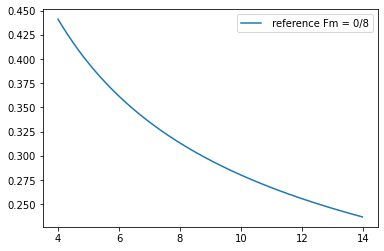

#################################################
24 8 0 Me vs ref 2.9816149549333204e-12 # 
24 8 0 Me vs Seg 0.0 
#################################################
Error at  24 8 0  is  1.2346273532943397e-16


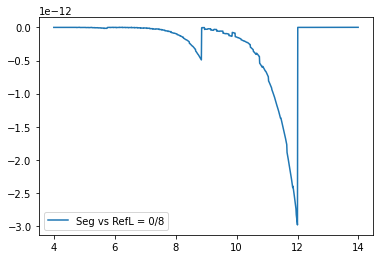

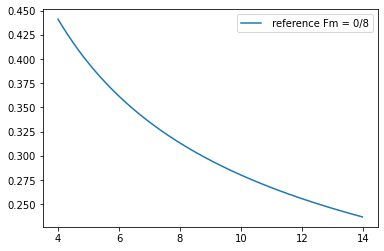

#################################################
24 8 0 Seg vs Ref 2.9816149549333204e-12 # 

24 8 1 Me vs ref 1.2435018292844546e-13 
24 8 1 Me vs Seg 0.0 
24 8 1 Seg vs Ref 1.2435018292844546e-13 

24 8 2 Me vs ref 1.5503223704804725e-14 
24 8 2 Me vs Seg 0.0 
24 8 2 Seg vs Ref 1.5503223704804725e-14 

24 8 3 Me vs ref 3.2831810187206045e-15 
24 8 3 Me vs Seg 0.0 
24 8 3 Seg vs Ref 3.2831810187206045e-15 

24 8 4 Me vs ref 9.31871767251291e-16 
24 8 4 Me vs Seg 0.0 
24 8 4 Seg vs Ref 9.31871767251291e-16 

24 8 5 Me vs ref 3.7119694254114655e-16 
24 8 5 Me vs Seg 0.0 
24 8 5 Seg vs Ref 3.7119694254114655e-16 

24 8 6 Me vs ref 1.4072944198861848e-16 
24 8 6 Me vs Seg 0.0 
24 8 6 Seg vs Ref 1.4072944198861848e-16 

24 8 7 Me vs ref 1.8633877806647353e-16 
24 8 7 Me vs Seg 0.0 
24 8 7 Seg vs Ref 1.8633877806647353e-16 

24 8 8 Me vs ref 1.0728095793449341e-16 
24 8 8 Me vs Seg 0.0 
24 8 8 Seg vs Ref 1.0728095793449341e-16 

#################################################
Error at  2

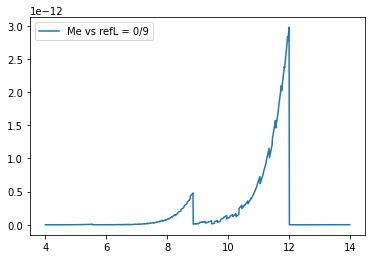

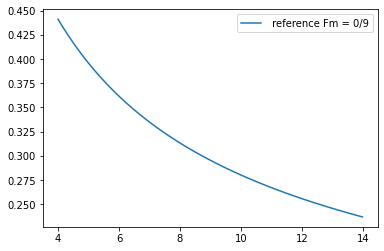

#################################################
24 9 0 Me vs ref 2.9801716650013077e-12 # 
24 9 0 Me vs Seg 0.0 
#################################################
Error at  24 9 0  is  1.2346273532943397e-16


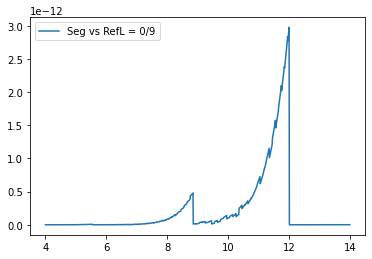

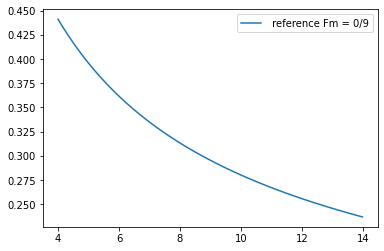

#################################################
24 9 0 Seg vs Ref 2.9801716650013077e-12 # 

24 9 1 Me vs ref 1.2409691330095285e-13 
24 9 1 Me vs Seg 0.0 
24 9 1 Seg vs Ref 1.2409691330095285e-13 

24 9 2 Me vs ref 1.5557650653863497e-14 
24 9 2 Me vs Seg 0.0 
24 9 2 Seg vs Ref 1.5557650653863497e-14 

24 9 3 Me vs ref 3.18890963982299e-15 
24 9 3 Me vs Seg 0.0 
24 9 3 Seg vs Ref 3.18890963982299e-15 

24 9 4 Me vs ref 9.561307908606542e-16 
24 9 4 Me vs Seg 0.0 
24 9 4 Seg vs Ref 9.561307908606542e-16 

24 9 5 Me vs ref 3.369192132316595e-16 
24 9 5 Me vs Seg 0.0 
24 9 5 Seg vs Ref 3.369192132316595e-16 

24 9 6 Me vs ref 1.9072810279914532e-16 
24 9 6 Me vs Seg 0.0 
24 9 6 Seg vs Ref 1.9072810279914532e-16 

24 9 7 Me vs ref 1.127231446206023e-16 
24 9 7 Me vs Seg 0.0 
24 9 7 Seg vs Ref 1.127231446206023e-16 

24 9 8 Me vs ref 2.041755978697546e-16 
24 9 8 Me vs Seg 0.0 
24 9 8 Seg vs Ref 2.041755978697546e-16 

24 9 9 Me vs ref 1.1075125191939428e-16 
24 9 9 Me vs Seg 0.0 
24 9 9

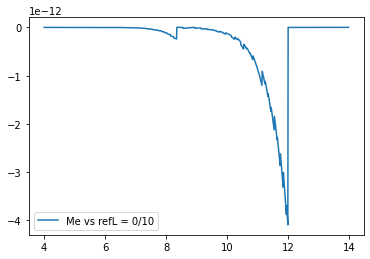

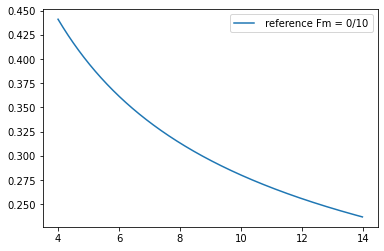

#################################################
24 10 0 Me vs ref 4.092226557617096e-12 # 
24 10 0 Me vs Seg 0.0 
#################################################
Error at  24 10 0  is  1.2346273532943397e-16


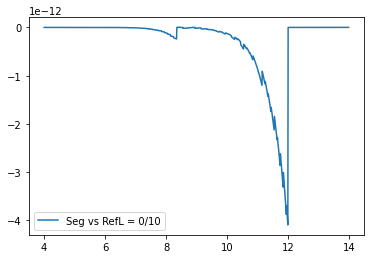

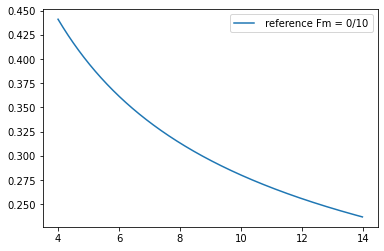

#################################################
24 10 0 Seg vs Ref 4.092226557617096e-12 # 

24 10 1 Me vs ref 1.7063433999098265e-13 
24 10 1 Me vs Seg 0.0 
24 10 1 Seg vs Ref 1.7063433999098265e-13 

24 10 2 Me vs ref 2.1289610699359862e-14 
24 10 2 Me vs Seg 0.0 
24 10 2 Seg vs Ref 2.1289610699359862e-14 

24 10 3 Me vs ref 4.48886804463311e-15 
24 10 3 Me vs Seg 0.0 
24 10 3 Seg vs Ref 4.48886804463311e-15 

24 10 4 Me vs ref 1.2835869520055887e-15 
24 10 4 Me vs Seg 0.0 
24 10 4 Seg vs Ref 1.2835869520055887e-15 

24 10 5 Me vs ref 5.031104656147423e-16 
24 10 5 Me vs Seg 0.0 
24 10 5 Seg vs Ref 5.031104656147423e-16 

24 10 6 Me vs ref 1.9510048687287201e-16 
24 10 6 Me vs Seg 0.0 
24 10 6 Seg vs Ref 1.9510048687287201e-16 

24 10 7 Me vs ref 2.1514128640490876e-16 
24 10 7 Me vs Seg 0.0 
24 10 7 Seg vs Ref 2.1514128640490876e-16 

24 10 8 Me vs ref 1.0728095793449341e-16 
24 10 8 Me vs Seg 0.0 
24 10 8 Seg vs Ref 1.0728095793449341e-16 

24 10 9 Me vs ref 1.4288429380643342e-1

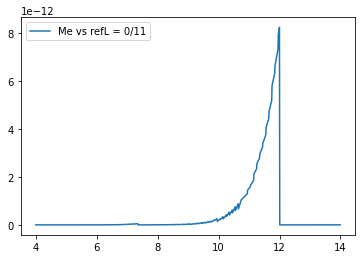

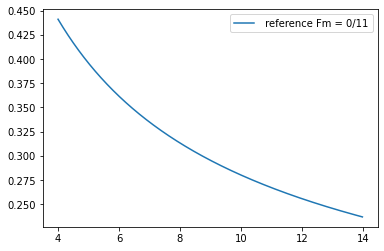

#################################################
24 11 0 Me vs ref 8.238909554592055e-12 # 
24 11 0 Me vs Seg 0.0 
#################################################
Error at  24 11 0  is  1.2346273532943397e-16


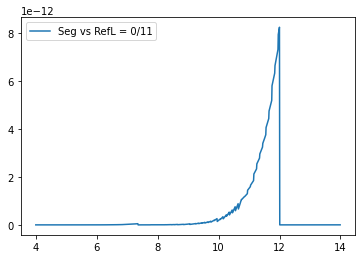

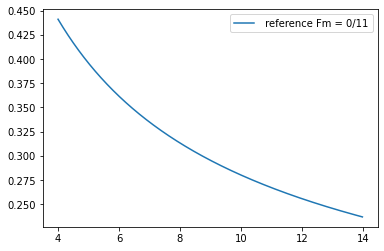

#################################################
24 11 0 Seg vs Ref 8.238909554592055e-12 # 

24 11 1 Me vs ref 3.4324799946805484e-13 
24 11 1 Me vs Seg 0.0 
24 11 1 Seg vs Ref 3.4324799946805484e-13 

24 11 2 Me vs ref 4.2956090073875686e-14 
24 11 2 Me vs Seg 0.0 
24 11 2 Seg vs Ref 4.2956090073875686e-14 

24 11 3 Me vs ref 8.897830389154038e-15 
24 11 3 Me vs Seg 0.0 
24 11 3 Seg vs Ref 8.897830389154038e-15 

24 11 4 Me vs ref 2.621492432852701e-15 
24 11 4 Me vs Seg 0.0 
24 11 4 Seg vs Ref 2.621492432852701e-15 

24 11 5 Me vs ref 9.615348610641367e-16 
24 11 5 Me vs Seg 0.0 
24 11 5 Seg vs Ref 9.615348610641367e-16 

24 11 6 Me vs ref 4.771573761108705e-16 
24 11 6 Me vs Seg 0.0 
24 11 6 Seg vs Ref 4.771573761108705e-16 

24 11 7 Me vs ref 2.3406146134772807e-16 
24 11 7 Me vs Seg 0.0 
24 11 7 Seg vs Ref 2.3406146134772807e-16 

24 11 8 Me vs ref 2.0680394110508468e-16 
24 11 8 Me vs Seg 0.0 
24 11 8 Seg vs Ref 2.0680394110508468e-16 

24 11 9 Me vs ref 1.0428352009239725e-16 

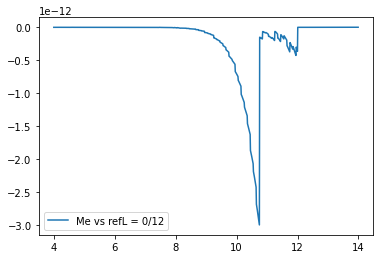

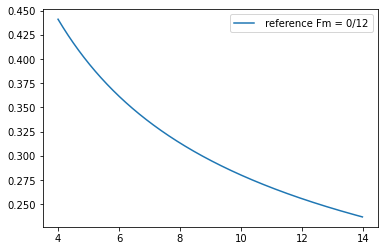

#################################################
24 12 0 Me vs ref 3.0024871477962733e-12 # 
24 12 0 Me vs Seg 0.0 
#################################################
Error at  24 12 0  is  1.2346273532943397e-16


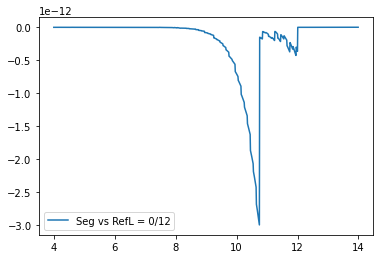

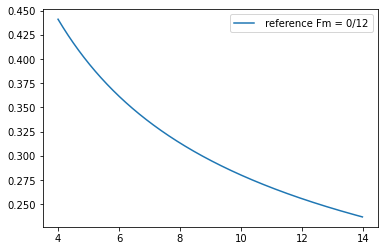

#################################################
24 12 0 Seg vs Ref 3.0024871477962733e-12 # 

24 12 1 Me vs ref 1.3968340373260446e-13 
24 12 1 Me vs Seg 0.0 
24 12 1 Seg vs Ref 1.3968340373260446e-13 

24 12 2 Me vs ref 1.943345658006468e-14 
24 12 2 Me vs Seg 0.0 
24 12 2 Seg vs Ref 1.943345658006468e-14 

24 12 3 Me vs ref 4.642120021713936e-15 
24 12 3 Me vs Seg 0.0 
24 12 3 Seg vs Ref 4.642120021713936e-15 

24 12 4 Me vs ref 1.421117997585375e-15 
24 12 4 Me vs Seg 0.0 
24 12 4 Seg vs Ref 1.421117997585375e-15 

24 12 5 Me vs ref 6.816311295780586e-16 
24 12 5 Me vs Seg 0.0 
24 12 5 Seg vs Ref 6.816311295780586e-16 

24 12 6 Me vs ref 3.0536893001233134e-16 
24 12 6 Me vs Seg 0.0 
24 12 6 Seg vs Ref 3.0536893001233134e-16 

24 12 7 Me vs ref 2.3753006126673443e-16 
24 12 7 Me vs Seg 0.0 
24 12 7 Seg vs Ref 2.3753006126673443e-16 

24 12 8 Me vs ref 1.1363455207184792e-16 
24 12 8 Me vs Seg 0.0 
24 12 8 Seg vs Ref 1.1363455207184792e-16 

24 12 9 Me vs ref 1.2217603231196028e-16

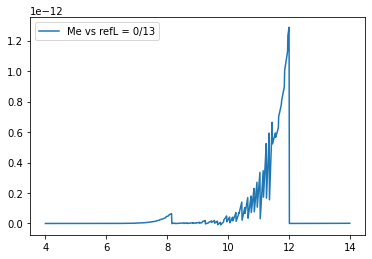

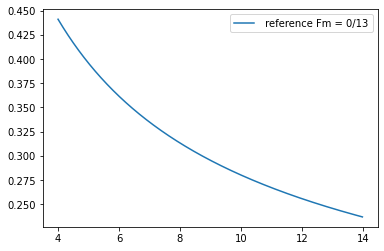

#################################################
24 13 0 Me vs ref 1.2879142197164128e-12 # 
24 13 0 Me vs Seg 0.0 
#################################################
Error at  24 13 0  is  1.2346273532943397e-16


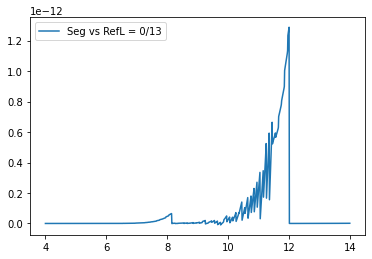

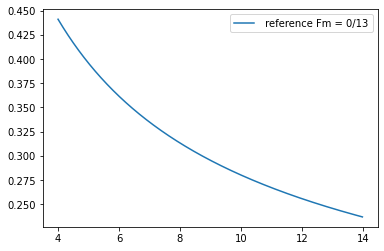

#################################################
24 13 0 Seg vs Ref 1.2879142197164128e-12 # 

24 13 1 Me vs ref 5.357519983206771e-14 
24 13 1 Me vs Seg 0.0 
24 13 1 Seg vs Ref 5.357519983206771e-14 

24 13 2 Me vs ref 6.740918587211375e-15 
24 13 2 Me vs Seg 0.0 
24 13 2 Seg vs Ref 6.740918587211375e-15 

24 13 3 Me vs ref 1.351783268654927e-15 
24 13 3 Me vs Seg 0.0 
24 13 3 Seg vs Ref 1.351783268654927e-15 

24 13 4 Me vs ref 4.224593765089768e-16 
24 13 4 Me vs Seg 0.0 
24 13 4 Seg vs Ref 4.224593765089768e-16 

24 13 5 Me vs ref 1.3723627811414174e-16 
24 13 5 Me vs Seg 0.0 
24 13 5 Seg vs Ref 1.3723627811414174e-16 

24 13 6 Me vs ref 1.1897763590312804e-16 
24 13 6 Me vs Seg 0.0 
24 13 6 Seg vs Ref 1.1897763590312804e-16 

24 13 7 Me vs ref 1.0560129160008813e-16 
24 13 7 Me vs Seg 0.0 
24 13 7 Seg vs Ref 1.0560129160008813e-16 

24 13 8 Me vs ref 1.0728095793449341e-16 
24 13 8 Me vs Seg 0.0 
24 13 8 Seg vs Ref 1.0728095793449341e-16 

24 13 9 Me vs ref 1.0428352009239725e-16

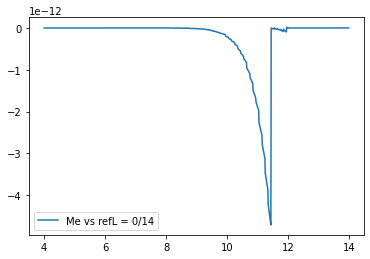

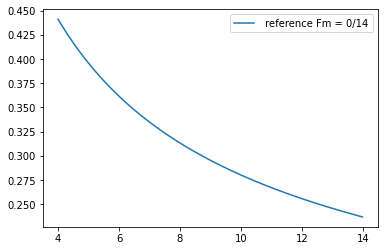

#################################################
24 14 0 Me vs ref 4.70939953700622e-12 # 
24 14 0 Me vs Seg 0.0 
#################################################
Error at  24 14 0  is  1.2346273532943397e-16


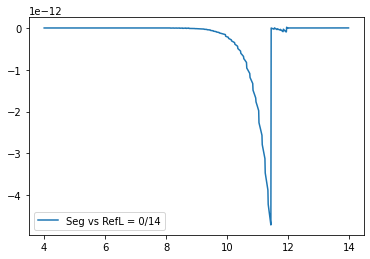

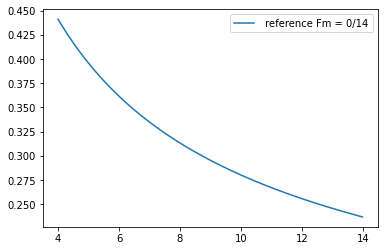

#################################################
24 14 0 Seg vs Ref 4.70939953700622e-12 # 

24 14 1 Me vs ref 2.0584575710635988e-13 
24 14 1 Me vs Seg 0.0 
24 14 1 Seg vs Ref 2.0584575710635988e-13 

24 14 2 Me vs ref 2.696757747666645e-14 
24 14 2 Me vs Seg 0.0 
24 14 2 Seg vs Ref 2.696757747666645e-14 

24 14 3 Me vs ref 5.917304406882762e-15 
24 14 3 Me vs Seg 0.0 
24 14 3 Seg vs Ref 5.917304406882762e-15 

24 14 4 Me vs ref 1.701235181374161e-15 
24 14 4 Me vs Seg 0.0 
24 14 4 Seg vs Ref 1.701235181374161e-15 

24 14 5 Me vs ref 8.192367140572032e-16 
24 14 5 Me vs Seg 0.0 
24 14 5 Seg vs Ref 8.192367140572032e-16 

24 14 6 Me vs ref 3.245084864884895e-16 
24 14 6 Me vs Seg 0.0 
24 14 6 Seg vs Ref 3.245084864884895e-16 

24 14 7 Me vs ref 2.7412866085169824e-16 
24 14 7 Me vs Seg 0.0 
24 14 7 Seg vs Ref 2.7412866085169824e-16 

24 14 8 Me vs ref 1.0728095793449341e-16 
24 14 8 Me vs Seg 0.0 
24 14 8 Seg vs Ref 1.0728095793449341e-16 

24 14 9 Me vs ref 1.2060478619480355e-16 
24

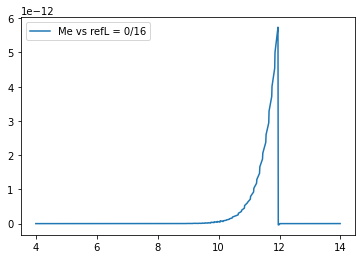

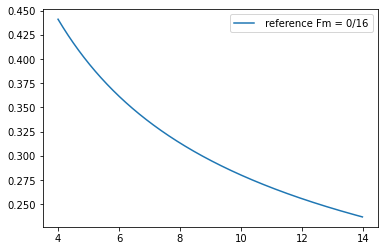

#################################################
24 16 0 Me vs ref 5.736688901691878e-12 # 
24 16 0 Me vs Seg 0.0 
#################################################
Error at  24 16 0  is  1.2346273532943397e-16


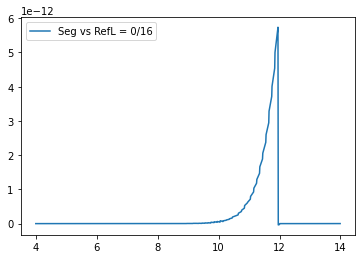

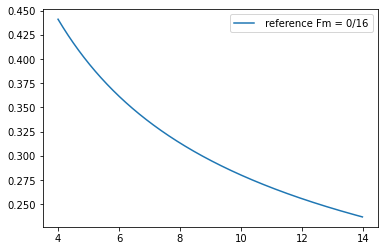

#################################################
24 16 0 Seg vs Ref 5.736688901691878e-12 # 

24 16 1 Me vs ref 2.3996256370839575e-13 
24 16 1 Me vs Seg 0.0 
24 16 1 Seg vs Ref 2.3996256370839575e-13 

24 16 2 Me vs ref 3.0163805481153716e-14 
24 16 2 Me vs Seg 0.0 
24 16 2 Seg vs Ref 3.0163805481153716e-14 

24 16 3 Me vs ref 6.2619180674072794e-15 
24 16 3 Me vs Seg 0.0 
24 16 3 Seg vs Ref 6.2619180674072794e-15 

24 16 4 Me vs ref 1.865261417544062e-15 
24 16 4 Me vs Seg 0.0 
24 16 4 Seg vs Ref 1.865261417544062e-15 

24 16 5 Me vs ref 6.807773203672263e-16 
24 16 5 Me vs Seg 0.0 
24 16 5 Seg vs Ref 6.807773203672263e-16 

24 16 6 Me vs ref 3.479611347320666e-16 
24 16 6 Me vs Seg 0.0 
24 16 6 Seg vs Ref 3.479611347320666e-16 

24 16 7 Me vs ref 1.6620395787729156e-16 
24 16 7 Me vs Seg 0.0 
24 16 7 Seg vs Ref 1.6620395787729156e-16 

24 16 8 Me vs ref 1.6045683933017113e-16 
24 16 8 Me vs Seg 0.0 
24 16 8 Seg vs Ref 1.6045683933017113e-16 

24 16 9 Me vs ref 1.0428352009239725e-1

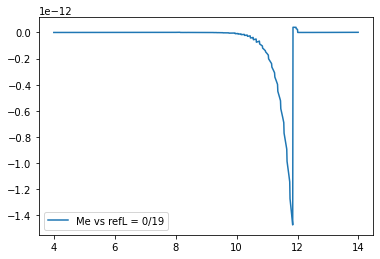

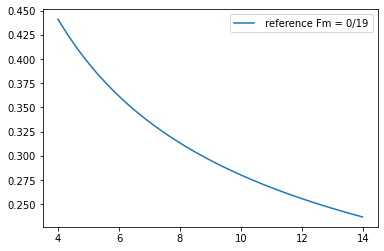

#################################################
24 19 0 Me vs ref 1.4747092436095954e-12 # 
24 19 0 Me vs Seg 0.0 
#################################################
Error at  24 19 0  is  1.2346273532943397e-16


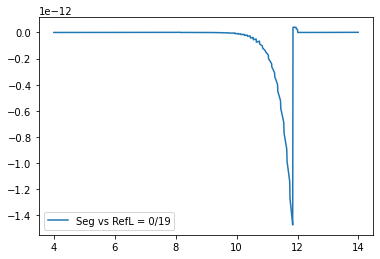

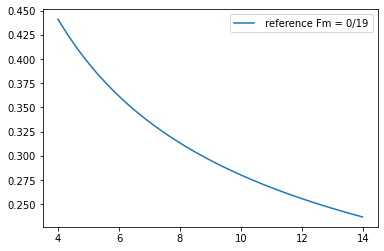

#################################################
24 19 0 Seg vs Ref 1.4747092436095954e-12 # 

24 19 1 Me vs ref 6.234422700313047e-14 
24 19 1 Me vs Seg 0.0 
24 19 1 Seg vs Ref 6.234422700313047e-14 

24 19 2 Me vs ref 7.864368878340855e-15 
24 19 2 Me vs Seg 0.0 
24 19 2 Seg vs Ref 7.864368878340855e-15 

24 19 3 Me vs ref 1.7057752779714441e-15 
24 19 3 Me vs Seg 0.0 
24 19 3 Seg vs Ref 1.7057752779714441e-15 

24 19 4 Me vs ref 4.798678815420843e-16 
24 19 4 Me vs Seg 0.0 
24 19 4 Seg vs Ref 4.798678815420843e-16 

24 19 5 Me vs ref 1.9991332807917095e-16 
24 19 5 Me vs Seg 0.0 
24 19 5 Seg vs Ref 1.9991332807917095e-16 

24 19 6 Me vs ref 1.0951966601408653e-16 
24 19 6 Me vs Seg 0.0 
24 19 6 Seg vs Ref 1.0951966601408653e-16 

24 19 7 Me vs ref 1.5584898009710774e-16 
24 19 7 Me vs Seg 0.0 
24 19 7 Seg vs Ref 1.5584898009710774e-16 

24 19 8 Me vs ref 1.0728095793449341e-16 
24 19 8 Me vs Seg 0.0 
24 19 8 Seg vs Ref 1.0728095793449341e-16 

24 19 9 Me vs ref 1.0428352009239725e-

24 23 0 Me vs ref 1.8129941992128806e-13 
24 23 0 Me vs Seg 0.0 
24 23 0 Seg vs Ref 1.8129941992128806e-13 

24 23 1 Me vs ref 7.504413757075667e-15 
24 23 1 Me vs Seg 0.0 
24 23 1 Seg vs Ref 7.504413757075667e-15 

24 23 2 Me vs ref 9.831545300098554e-16 
24 23 2 Me vs Seg 0.0 
24 23 2 Seg vs Ref 9.831545300098554e-16 

24 23 3 Me vs ref 1.5677563414140394e-16 
24 23 3 Me vs Seg 0.0 
24 23 3 Seg vs Ref 1.5677563414140394e-16 

24 23 4 Me vs ref 1.311613578164339e-16 
24 23 4 Me vs Seg 0.0 
24 23 4 Seg vs Ref 1.311613578164339e-16 

24 23 5 Me vs ref 1.0646865333807654e-16 
24 23 5 Me vs Seg 0.0 
24 23 5 Seg vs Ref 1.0646865333807654e-16 

24 23 6 Me vs ref 1.0951966601408653e-16 
24 23 6 Me vs Seg 0.0 
24 23 6 Seg vs Ref 1.0951966601408653e-16 

24 23 7 Me vs ref 1.056148441272442e-16 
24 23 7 Me vs Seg 0.0 
24 23 7 Seg vs Ref 1.056148441272442e-16 

24 23 8 Me vs ref 1.0728095793449341e-16 
24 23 8 Me vs Seg 0.0 
24 23 8 Seg vs Ref 1.0728095793449341e-16 

24 23 9 Me vs ref 1.0428352

In [42]:
minT = 4
maxT = 14

# don't change
max_T = 12. # hardcoded in source # max value of tabulated T

for Lmax in range(24+1):
    ftable, ftable_ld, ftable_dt = create_md_ftable( Lmax, 0, max_T, tdelta=0.1 )
    for L in range(0,Lmax+1):
        all_diff = np.zeros((nT, 3, L+1))
        all_refs = np.zeros((nT, 1, L+1))
        all_T = np.zeros(nT)
        for iT in range(nT):
            T = iT * (maxT-minT)/nT + minT

            f_ref = np.zeros(L+1)
            f_int = np.zeros(L+1)
            f = np.zeros(L+1)

            fgamma_ref( L, T, f_ref)
            fgamma_int( L, T, f_int, ftable, ftable_ld, ftable_dt)
            fgamma    ( L, T, f    , ftable, ftable_ld, ftable_dt)
            
            all_diff[iT, 0, : ] = f - f_ref
            all_diff[iT, 1, : ] = f - f_int
            all_diff[iT, 2, : ] = f_int - f_ref
            all_refs[iT, 0, : ] = f_ref
            all_T[iT] = T
            
        for m in range(L+1):

            diff_my_int = np.max( np.abs(all_diff[:,1,m].flatten()))
            diff_int_ref = np.max( np.abs(all_diff[:,2,m].flatten()))

            for idx,name in zip([0,1,2],['Me vs ref','Me vs Seg', 'Seg vs Ref'] ):
                diff = np.max( np.abs(all_diff[:,idx,m].flatten()))
                if Lmax == 0 or diff > 1.e-12 :
                    print("#################################################")
                    print("Error at ", Lmax, L, m,  " is ", diff_my_ref )
                    plt.plot( all_T, all_diff[:,idx,m] , label=name+'L = '+str(m)+'/'+str(L))
                    plt.legend()
                    plt.show()

                    plt.plot( all_T, all_refs[:,0,m] , label=' reference Fm = '+str(m)+'/'+str(L))
                    plt.legend()
                    plt.show()
                    print("#################################################")

                print(Lmax, L, m, name, diff, end=' ' )
                if diff > 1.e-12 :
                    print('#', end=' ' )
                if diff > 1.e-11 :
                    print('#', end=' ' )
                if diff > 1.e-10 :
                    print('#', end=' ' )
                print()
            print()



#################################################
Error at  0 0 0  is  1.2346273532943397e-16


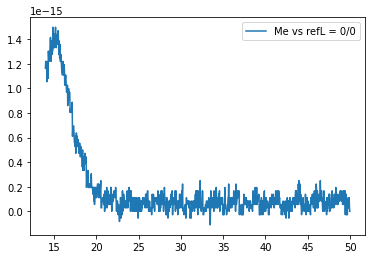

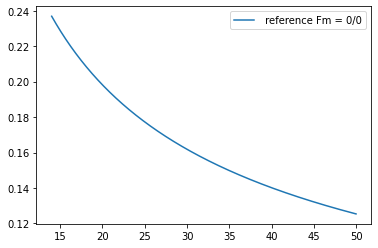

#################################################
0 0 0 Me vs ref 1.4988010832439613e-15 
#################################################
Error at  0 0 0  is  1.2346273532943397e-16


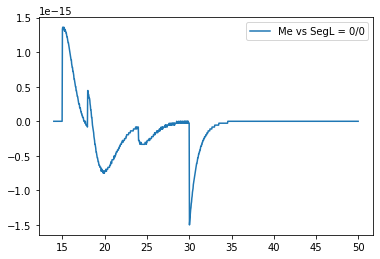

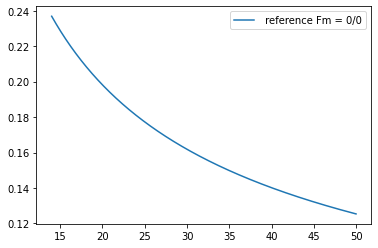

#################################################
0 0 0 Me vs Seg 1.4988010832439613e-15 
#################################################
Error at  0 0 0  is  1.2346273532943397e-16


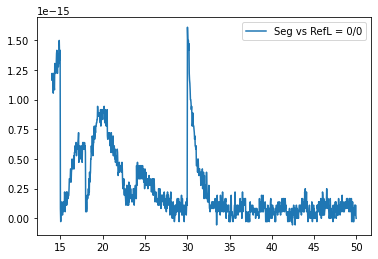

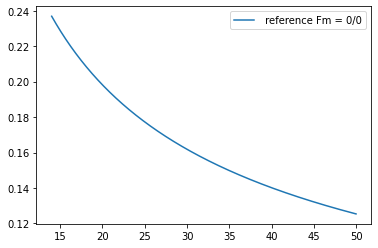

#################################################
0 0 0 Seg vs Ref 1.609823385706477e-15 
1 0 0 Me vs ref 1.4988010832439613e-15 
1 0 0 Me vs Seg 1.4988010832439613e-15 
1 0 0 Seg vs Ref 1.609823385706477e-15 
1 1 0 Me vs ref 1.4988010832439613e-15 
1 1 0 Me vs Seg 1.4988010832439613e-15 
1 1 0 Seg vs Ref 1.609823385706477e-15 
1 1 1 Me vs ref 1.3725999503666486e-16 
1 1 1 Me vs Seg 4.5102810375396984e-17 
1 1 1 Seg vs Ref 1.3725999503666486e-16 
2 0 0 Me vs ref 1.4988010832439613e-15 
2 0 0 Me vs Seg 1.4988010832439613e-15 
2 0 0 Seg vs Ref 1.609823385706477e-15 
2 1 0 Me vs ref 1.4988010832439613e-15 
2 1 0 Me vs Seg 1.4988010832439613e-15 
2 1 0 Seg vs Ref 1.609823385706477e-15 
2 1 1 Me vs ref 1.3725999503666486e-16 
2 1 1 Me vs Seg 4.5102810375396984e-17 
2 1 1 Seg vs Ref 1.3725999503666486e-16 
2 2 0 Me vs ref 1.4988010832439613e-15 
2 2 0 Me vs Seg 1.4988010832439613e-15 
2 2 0 Seg vs Ref 1.609823385706477e-15 
2 2 1 Me vs ref 1.3725999503666486e-16 
2 2 1 Me vs Seg 4.5102810375

6 5 0 Me vs ref 1.4988010832439613e-15 
6 5 0 Me vs Seg 1.4988010832439613e-15 
6 5 0 Seg vs Ref 1.609823385706477e-15 
6 5 1 Me vs ref 1.3725999503666486e-16 
6 5 1 Me vs Seg 4.5102810375396984e-17 
6 5 1 Seg vs Ref 1.3725999503666486e-16 
6 5 2 Me vs ref 1.4076332330650865e-16 
6 5 2 Me vs Seg 4.553649124439119e-18 
6 5 2 Seg vs Ref 1.4076332330650865e-16 
6 5 3 Me vs ref 1.4193180525724595e-16 
6 5 3 Me vs Seg 7.318364664277155e-19 
6 5 3 Seg vs Ref 1.4193180525724595e-16 
6 5 4 Me vs ref 1.383012367568568e-16 
6 5 4 Me vs Seg 1.6940658945086007e-19 
6 5 4 Seg vs Ref 1.383012367568568e-16 
6 5 5 Me vs ref 1.3740845575864465e-16 
6 5 5 Me vs Seg 5.082197683525802e-20 
6 5 5 Seg vs Ref 1.3740844417811608e-16 
6 6 0 Me vs ref 1.4988010832439613e-15 
6 6 0 Me vs Seg 1.4988010832439613e-15 
6 6 0 Seg vs Ref 1.609823385706477e-15 
6 6 1 Me vs ref 1.3725999503666486e-16 
6 6 1 Me vs Seg 4.5102810375396984e-17 
6 6 1 Seg vs Ref 1.3725999503666486e-16 
6 6 2 Me vs ref 1.4076332330650865e-16 

8 6 0 Me vs ref 1.4988010832439613e-15 
8 6 0 Me vs Seg 1.4988010832439613e-15 
8 6 0 Seg vs Ref 1.609823385706477e-15 
8 6 1 Me vs ref 1.3725999503666486e-16 
8 6 1 Me vs Seg 4.5102810375396984e-17 
8 6 1 Seg vs Ref 1.3725999503666486e-16 
8 6 2 Me vs ref 1.4076332330650865e-16 
8 6 2 Me vs Seg 4.553649124439119e-18 
8 6 2 Seg vs Ref 1.4076332330650865e-16 
8 6 3 Me vs ref 1.4193180525724595e-16 
8 6 3 Me vs Seg 7.318364664277155e-19 
8 6 3 Seg vs Ref 1.4193180525724595e-16 
8 6 4 Me vs ref 1.383012367568568e-16 
8 6 4 Me vs Seg 1.6940658945086007e-19 
8 6 4 Seg vs Ref 1.383012367568568e-16 
8 6 5 Me vs ref 1.3740845575864465e-16 
8 6 5 Me vs Seg 5.082197683525802e-20 
8 6 5 Seg vs Ref 1.3740844417811608e-16 
8 6 6 Me vs ref 1.3102562947203283e-16 
8 6 6 Me vs Seg 1.8634724839594607e-20 
8 6 6 Seg vs Ref 1.3102562947203283e-16 
8 7 0 Me vs ref 1.4988010832439613e-15 
8 7 0 Me vs Seg 1.4988010832439613e-15 
8 7 0 Seg vs Ref 1.609823385706477e-15 
8 7 1 Me vs ref 1.3725999503666486e-16 

9 9 0 Me vs ref 1.4988010832439613e-15 
9 9 0 Me vs Seg 1.4988010832439613e-15 
9 9 0 Seg vs Ref 1.609823385706477e-15 
9 9 1 Me vs ref 1.3725999503666486e-16 
9 9 1 Me vs Seg 4.5102810375396984e-17 
9 9 1 Seg vs Ref 1.3725999503666486e-16 
9 9 2 Me vs ref 1.4076332330650865e-16 
9 9 2 Me vs Seg 4.553649124439119e-18 
9 9 2 Seg vs Ref 1.4076332330650865e-16 
9 9 3 Me vs ref 1.4193180525724595e-16 
9 9 3 Me vs Seg 7.318364664277155e-19 
9 9 3 Seg vs Ref 1.4193180525724595e-16 
9 9 4 Me vs ref 1.383012367568568e-16 
9 9 4 Me vs Seg 1.6940658945086007e-19 
9 9 4 Seg vs Ref 1.383012367568568e-16 
9 9 5 Me vs ref 1.3740845575864465e-16 
9 9 5 Me vs Seg 5.082197683525802e-20 
9 9 5 Seg vs Ref 1.3740845575864465e-16 
9 9 6 Me vs ref 1.3102562947203283e-16 
9 9 6 Me vs Seg 1.8634724839594607e-20 
9 9 6 Seg vs Ref 1.3102562947203283e-16 
9 9 7 Me vs ref 1.2346273532943397e-16 
9 9 7 Me vs Seg 8.046812998915853e-21 
9 9 7 Seg vs Ref 1.2346273532943397e-16 
9 9 8 Me vs ref 1.174356058052067e-16 


11 1 0 Me vs ref 1.4988010832439613e-15 
11 1 0 Me vs Seg 1.4988010832439613e-15 
11 1 0 Seg vs Ref 1.609823385706477e-15 
11 1 1 Me vs ref 1.3725999503666486e-16 
11 1 1 Me vs Seg 4.5102810375396984e-17 
11 1 1 Seg vs Ref 1.3725999503666486e-16 
11 2 0 Me vs ref 1.4988010832439613e-15 
11 2 0 Me vs Seg 1.4988010832439613e-15 
11 2 0 Seg vs Ref 1.609823385706477e-15 
11 2 1 Me vs ref 1.3725999503666486e-16 
11 2 1 Me vs Seg 4.5102810375396984e-17 
11 2 1 Seg vs Ref 1.3725999503666486e-16 
11 2 2 Me vs ref 1.4076332330650865e-16 
11 2 2 Me vs Seg 4.553649124439119e-18 
11 2 2 Seg vs Ref 1.4076332330650865e-16 
11 3 0 Me vs ref 1.4988010832439613e-15 
11 3 0 Me vs Seg 1.4988010832439613e-15 
11 3 0 Seg vs Ref 1.609823385706477e-15 
11 3 1 Me vs ref 1.3725999503666486e-16 
11 3 1 Me vs Seg 4.5102810375396984e-17 
11 3 1 Seg vs Ref 1.3725999503666486e-16 
11 3 2 Me vs ref 1.4076332330650865e-16 
11 3 2 Me vs Seg 4.553649124439119e-18 
11 3 2 Seg vs Ref 1.4076332330650865e-16 
11 3 3 Me vs 

12 0 0 Me vs ref 1.4988010832439613e-15 
12 0 0 Me vs Seg 1.4988010832439613e-15 
12 0 0 Seg vs Ref 1.609823385706477e-15 
12 1 0 Me vs ref 1.4988010832439613e-15 
12 1 0 Me vs Seg 1.4988010832439613e-15 
12 1 0 Seg vs Ref 1.609823385706477e-15 
12 1 1 Me vs ref 1.3725999503666486e-16 
12 1 1 Me vs Seg 4.5102810375396984e-17 
12 1 1 Seg vs Ref 1.3725999503666486e-16 
12 2 0 Me vs ref 1.4988010832439613e-15 
12 2 0 Me vs Seg 1.4988010832439613e-15 
12 2 0 Seg vs Ref 1.609823385706477e-15 
12 2 1 Me vs ref 1.3725999503666486e-16 
12 2 1 Me vs Seg 4.5102810375396984e-17 
12 2 1 Seg vs Ref 1.3725999503666486e-16 
12 2 2 Me vs ref 1.4076332330650865e-16 
12 2 2 Me vs Seg 4.553649124439119e-18 
12 2 2 Seg vs Ref 1.4076332330650865e-16 
12 3 0 Me vs ref 1.4988010832439613e-15 
12 3 0 Me vs Seg 1.4988010832439613e-15 
12 3 0 Seg vs Ref 1.609823385706477e-15 
12 3 1 Me vs ref 1.3725999503666486e-16 
12 3 1 Me vs Seg 4.5102810375396984e-17 
12 3 1 Seg vs Ref 1.3725999503666486e-16 
12 3 2 Me vs 

12 12 0 Me vs ref 1.4988010832439613e-15 
12 12 0 Me vs Seg 1.4988010832439613e-15 
12 12 0 Seg vs Ref 1.609823385706477e-15 
12 12 1 Me vs ref 1.3725999503666486e-16 
12 12 1 Me vs Seg 4.5102810375396984e-17 
12 12 1 Seg vs Ref 1.3725999503666486e-16 
12 12 2 Me vs ref 1.4076332330650865e-16 
12 12 2 Me vs Seg 4.553649124439119e-18 
12 12 2 Seg vs Ref 1.4076332330650865e-16 
12 12 3 Me vs ref 1.4193180525724595e-16 
12 12 3 Me vs Seg 7.318364664277155e-19 
12 12 3 Seg vs Ref 1.4193180525724595e-16 
12 12 4 Me vs ref 1.383012367568568e-16 
12 12 4 Me vs Seg 1.6940658945086007e-19 
12 12 4 Seg vs Ref 1.383012367568568e-16 
12 12 5 Me vs ref 1.3740845575864465e-16 
12 12 5 Me vs Seg 5.082197683525802e-20 
12 12 5 Seg vs Ref 1.3740845575864465e-16 
12 12 6 Me vs ref 1.3102562947203283e-16 
12 12 6 Me vs Seg 1.8634724839594607e-20 
12 12 6 Seg vs Ref 1.3102562947203283e-16 
12 12 7 Me vs ref 1.2346273532943397e-16 
12 12 7 Me vs Seg 8.046812998915853e-21 
12 12 7 Seg vs Ref 1.2346273532943

13 10 0 Me vs ref 1.4988010832439613e-15 
13 10 0 Me vs Seg 1.4988010832439613e-15 
13 10 0 Seg vs Ref 1.609823385706477e-15 
13 10 1 Me vs ref 1.3725999503666486e-16 
13 10 1 Me vs Seg 4.5102810375396984e-17 
13 10 1 Seg vs Ref 1.3725999503666486e-16 
13 10 2 Me vs ref 1.4076332330650865e-16 
13 10 2 Me vs Seg 4.553649124439119e-18 
13 10 2 Seg vs Ref 1.4076332330650865e-16 
13 10 3 Me vs ref 1.4193180525724595e-16 
13 10 3 Me vs Seg 7.318364664277155e-19 
13 10 3 Seg vs Ref 1.4193180525724595e-16 
13 10 4 Me vs ref 1.383012367568568e-16 
13 10 4 Me vs Seg 1.6940658945086007e-19 
13 10 4 Seg vs Ref 1.383012367568568e-16 
13 10 5 Me vs ref 1.3740845575864465e-16 
13 10 5 Me vs Seg 5.082197683525802e-20 
13 10 5 Seg vs Ref 1.3740845575864465e-16 
13 10 6 Me vs ref 1.3102562947203283e-16 
13 10 6 Me vs Seg 1.8634724839594607e-20 
13 10 6 Seg vs Ref 1.3102562947203283e-16 
13 10 7 Me vs ref 1.2346273532943397e-16 
13 10 7 Me vs Seg 8.046812998915853e-21 
13 10 7 Seg vs Ref 1.2346273532943

14 6 0 Me vs ref 1.4988010832439613e-15 
14 6 0 Me vs Seg 1.4988010832439613e-15 
14 6 0 Seg vs Ref 1.609823385706477e-15 
14 6 1 Me vs ref 1.3725999503666486e-16 
14 6 1 Me vs Seg 4.5102810375396984e-17 
14 6 1 Seg vs Ref 1.3725999503666486e-16 
14 6 2 Me vs ref 1.4076332330650865e-16 
14 6 2 Me vs Seg 4.553649124439119e-18 
14 6 2 Seg vs Ref 1.4076332330650865e-16 
14 6 3 Me vs ref 1.4193180525724595e-16 
14 6 3 Me vs Seg 7.318364664277155e-19 
14 6 3 Seg vs Ref 1.4193180525724595e-16 
14 6 4 Me vs ref 1.383012367568568e-16 
14 6 4 Me vs Seg 1.6940658945086007e-19 
14 6 4 Seg vs Ref 1.383012367568568e-16 
14 6 5 Me vs ref 1.3740845575864465e-16 
14 6 5 Me vs Seg 5.082197683525802e-20 
14 6 5 Seg vs Ref 1.3740844417811608e-16 
14 6 6 Me vs ref 1.3102562947203283e-16 
14 6 6 Me vs Seg 1.8634724839594607e-20 
14 6 6 Seg vs Ref 1.3102562947203283e-16 
14 7 0 Me vs ref 1.4988010832439613e-15 
14 7 0 Me vs Seg 1.4988010832439613e-15 
14 7 0 Seg vs Ref 1.609823385706477e-15 
14 7 1 Me vs re

14 13 0 Me vs ref 1.4988010832439613e-15 
14 13 0 Me vs Seg 1.4988010832439613e-15 
14 13 0 Seg vs Ref 1.609823385706477e-15 
14 13 1 Me vs ref 1.3725999503666486e-16 
14 13 1 Me vs Seg 4.5102810375396984e-17 
14 13 1 Seg vs Ref 1.3725999503666486e-16 
14 13 2 Me vs ref 1.4076332330650865e-16 
14 13 2 Me vs Seg 4.553649124439119e-18 
14 13 2 Seg vs Ref 1.4076332330650865e-16 
14 13 3 Me vs ref 1.4193180525724595e-16 
14 13 3 Me vs Seg 7.318364664277155e-19 
14 13 3 Seg vs Ref 1.4193180525724595e-16 
14 13 4 Me vs ref 1.383012367568568e-16 
14 13 4 Me vs Seg 1.6940658945086007e-19 
14 13 4 Seg vs Ref 1.383012367568568e-16 
14 13 5 Me vs ref 1.3740845575864465e-16 
14 13 5 Me vs Seg 5.082197683525802e-20 
14 13 5 Seg vs Ref 1.3740845575864465e-16 
14 13 6 Me vs ref 1.3102562947203283e-16 
14 13 6 Me vs Seg 1.8634724839594607e-20 
14 13 6 Seg vs Ref 1.3102562947203283e-16 
14 13 7 Me vs ref 1.2346273532943397e-16 
14 13 7 Me vs Seg 8.046812998915853e-21 
14 13 7 Seg vs Ref 1.2346273532943

15 9 0 Me vs ref 1.4988010832439613e-15 
15 9 0 Me vs Seg 1.4988010832439613e-15 
15 9 0 Seg vs Ref 1.609823385706477e-15 
15 9 1 Me vs ref 1.3725999503666486e-16 
15 9 1 Me vs Seg 4.5102810375396984e-17 
15 9 1 Seg vs Ref 1.3725999503666486e-16 
15 9 2 Me vs ref 1.4076332330650865e-16 
15 9 2 Me vs Seg 4.553649124439119e-18 
15 9 2 Seg vs Ref 1.4076332330650865e-16 
15 9 3 Me vs ref 1.4193180525724595e-16 
15 9 3 Me vs Seg 7.318364664277155e-19 
15 9 3 Seg vs Ref 1.4193180525724595e-16 
15 9 4 Me vs ref 1.383012367568568e-16 
15 9 4 Me vs Seg 1.6940658945086007e-19 
15 9 4 Seg vs Ref 1.383012367568568e-16 
15 9 5 Me vs ref 1.3740845575864465e-16 
15 9 5 Me vs Seg 5.082197683525802e-20 
15 9 5 Seg vs Ref 1.3740845575864465e-16 
15 9 6 Me vs ref 1.3102562947203283e-16 
15 9 6 Me vs Seg 1.8634724839594607e-20 
15 9 6 Seg vs Ref 1.3102562947203283e-16 
15 9 7 Me vs ref 1.2346273532943397e-16 
15 9 7 Me vs Seg 8.046812998915853e-21 
15 9 7 Seg vs Ref 1.2346273532943397e-16 
15 9 8 Me vs re

15 15 0 Me vs ref 1.4988010832439613e-15 
15 15 0 Me vs Seg 1.4988010832439613e-15 
15 15 0 Seg vs Ref 1.609823385706477e-15 
15 15 1 Me vs ref 1.3725999503666486e-16 
15 15 1 Me vs Seg 4.5102810375396984e-17 
15 15 1 Seg vs Ref 1.3725999503666486e-16 
15 15 2 Me vs ref 1.4076332330650865e-16 
15 15 2 Me vs Seg 4.553649124439119e-18 
15 15 2 Seg vs Ref 1.4076332330650865e-16 
15 15 3 Me vs ref 1.4193180525724595e-16 
15 15 3 Me vs Seg 7.318364664277155e-19 
15 15 3 Seg vs Ref 1.4193180525724595e-16 
15 15 4 Me vs ref 1.383012367568568e-16 
15 15 4 Me vs Seg 1.6940658945086007e-19 
15 15 4 Seg vs Ref 1.383012367568568e-16 
15 15 5 Me vs ref 1.3740845575864465e-16 
15 15 5 Me vs Seg 5.082197683525802e-20 
15 15 5 Seg vs Ref 1.3740845575864465e-16 
15 15 6 Me vs ref 1.3102562947203283e-16 
15 15 6 Me vs Seg 1.8634724839594607e-20 
15 15 6 Seg vs Ref 1.3102562947203283e-16 
15 15 7 Me vs ref 1.2346273532943397e-16 
15 15 7 Me vs Seg 8.046812998915853e-21 
15 15 7 Seg vs Ref 1.2346273532943

16 10 0 Me vs ref 1.4988010832439613e-15 
16 10 0 Me vs Seg 1.4988010832439613e-15 
16 10 0 Seg vs Ref 1.609823385706477e-15 
16 10 1 Me vs ref 1.3725999503666486e-16 
16 10 1 Me vs Seg 4.5102810375396984e-17 
16 10 1 Seg vs Ref 1.3725999503666486e-16 
16 10 2 Me vs ref 1.4076332330650865e-16 
16 10 2 Me vs Seg 4.553649124439119e-18 
16 10 2 Seg vs Ref 1.4076332330650865e-16 
16 10 3 Me vs ref 1.4193180525724595e-16 
16 10 3 Me vs Seg 7.318364664277155e-19 
16 10 3 Seg vs Ref 1.4193180525724595e-16 
16 10 4 Me vs ref 1.383012367568568e-16 
16 10 4 Me vs Seg 1.6940658945086007e-19 
16 10 4 Seg vs Ref 1.383012367568568e-16 
16 10 5 Me vs ref 1.3740845575864465e-16 
16 10 5 Me vs Seg 5.082197683525802e-20 
16 10 5 Seg vs Ref 1.3740845575864465e-16 
16 10 6 Me vs ref 1.3102562947203283e-16 
16 10 6 Me vs Seg 1.8634724839594607e-20 
16 10 6 Seg vs Ref 1.3102562947203283e-16 
16 10 7 Me vs ref 1.2346273532943397e-16 
16 10 7 Me vs Seg 8.046812998915853e-21 
16 10 7 Seg vs Ref 1.2346273532943

16 15 0 Me vs ref 1.4988010832439613e-15 
16 15 0 Me vs Seg 1.4988010832439613e-15 
16 15 0 Seg vs Ref 1.609823385706477e-15 
16 15 1 Me vs ref 1.3725999503666486e-16 
16 15 1 Me vs Seg 4.5102810375396984e-17 
16 15 1 Seg vs Ref 1.3725999503666486e-16 
16 15 2 Me vs ref 1.4076332330650865e-16 
16 15 2 Me vs Seg 4.553649124439119e-18 
16 15 2 Seg vs Ref 1.4076332330650865e-16 
16 15 3 Me vs ref 1.4193180525724595e-16 
16 15 3 Me vs Seg 7.318364664277155e-19 
16 15 3 Seg vs Ref 1.4193180525724595e-16 
16 15 4 Me vs ref 1.383012367568568e-16 
16 15 4 Me vs Seg 1.6940658945086007e-19 
16 15 4 Seg vs Ref 1.383012367568568e-16 
16 15 5 Me vs ref 1.3740845575864465e-16 
16 15 5 Me vs Seg 5.082197683525802e-20 
16 15 5 Seg vs Ref 1.3740845575864465e-16 
16 15 6 Me vs ref 1.3102562947203283e-16 
16 15 6 Me vs Seg 1.8634724839594607e-20 
16 15 6 Seg vs Ref 1.3102562947203283e-16 
16 15 7 Me vs ref 1.2346273532943397e-16 
16 15 7 Me vs Seg 8.046812998915853e-21 
16 15 7 Seg vs Ref 1.2346273532943

17 8 0 Me vs ref 1.4988010832439613e-15 
17 8 0 Me vs Seg 1.4988010832439613e-15 
17 8 0 Seg vs Ref 1.609823385706477e-15 
17 8 1 Me vs ref 1.3725999503666486e-16 
17 8 1 Me vs Seg 4.5102810375396984e-17 
17 8 1 Seg vs Ref 1.3725999503666486e-16 
17 8 2 Me vs ref 1.4076332330650865e-16 
17 8 2 Me vs Seg 4.553649124439119e-18 
17 8 2 Seg vs Ref 1.4076332330650865e-16 
17 8 3 Me vs ref 1.4193180525724595e-16 
17 8 3 Me vs Seg 7.318364664277155e-19 
17 8 3 Seg vs Ref 1.4193180525724595e-16 
17 8 4 Me vs ref 1.383012367568568e-16 
17 8 4 Me vs Seg 1.6940658945086007e-19 
17 8 4 Seg vs Ref 1.383012367568568e-16 
17 8 5 Me vs ref 1.3740845575864465e-16 
17 8 5 Me vs Seg 5.082197683525802e-20 
17 8 5 Seg vs Ref 1.3740845575864465e-16 
17 8 6 Me vs ref 1.3102562947203283e-16 
17 8 6 Me vs Seg 1.8634724839594607e-20 
17 8 6 Seg vs Ref 1.3102562947203283e-16 
17 8 7 Me vs ref 1.2346273532943397e-16 
17 8 7 Me vs Seg 8.046812998915853e-21 
17 8 7 Seg vs Ref 1.2346273532943397e-16 
17 8 8 Me vs re

17 14 0 Me vs ref 1.4988010832439613e-15 
17 14 0 Me vs Seg 1.4988010832439613e-15 
17 14 0 Seg vs Ref 1.609823385706477e-15 
17 14 1 Me vs ref 1.3725999503666486e-16 
17 14 1 Me vs Seg 4.5102810375396984e-17 
17 14 1 Seg vs Ref 1.3725999503666486e-16 
17 14 2 Me vs ref 1.4076332330650865e-16 
17 14 2 Me vs Seg 4.553649124439119e-18 
17 14 2 Seg vs Ref 1.4076332330650865e-16 
17 14 3 Me vs ref 1.4193180525724595e-16 
17 14 3 Me vs Seg 7.318364664277155e-19 
17 14 3 Seg vs Ref 1.4193180525724595e-16 
17 14 4 Me vs ref 1.383012367568568e-16 
17 14 4 Me vs Seg 1.6940658945086007e-19 
17 14 4 Seg vs Ref 1.383012367568568e-16 
17 14 5 Me vs ref 1.3740845575864465e-16 
17 14 5 Me vs Seg 5.082197683525802e-20 
17 14 5 Seg vs Ref 1.3740845575864465e-16 
17 14 6 Me vs ref 1.3102562947203283e-16 
17 14 6 Me vs Seg 1.8634724839594607e-20 
17 14 6 Seg vs Ref 1.3102562947203283e-16 
17 14 7 Me vs ref 1.2346273532943397e-16 
17 14 7 Me vs Seg 8.046812998915853e-21 
17 14 7 Seg vs Ref 1.2346273532943

18 1 0 Me vs ref 1.4988010832439613e-15 
18 1 0 Me vs Seg 1.4988010832439613e-15 
18 1 0 Seg vs Ref 1.609823385706477e-15 
18 1 1 Me vs ref 1.3725999503666486e-16 
18 1 1 Me vs Seg 4.5102810375396984e-17 
18 1 1 Seg vs Ref 1.3725999503666486e-16 
18 2 0 Me vs ref 1.4988010832439613e-15 
18 2 0 Me vs Seg 1.4988010832439613e-15 
18 2 0 Seg vs Ref 1.609823385706477e-15 
18 2 1 Me vs ref 1.3725999503666486e-16 
18 2 1 Me vs Seg 4.5102810375396984e-17 
18 2 1 Seg vs Ref 1.3725999503666486e-16 
18 2 2 Me vs ref 1.4076332330650865e-16 
18 2 2 Me vs Seg 4.553649124439119e-18 
18 2 2 Seg vs Ref 1.4076332330650865e-16 
18 3 0 Me vs ref 1.4988010832439613e-15 
18 3 0 Me vs Seg 1.4988010832439613e-15 
18 3 0 Seg vs Ref 1.609823385706477e-15 
18 3 1 Me vs ref 1.3725999503666486e-16 
18 3 1 Me vs Seg 4.5102810375396984e-17 
18 3 1 Seg vs Ref 1.3725999503666486e-16 
18 3 2 Me vs ref 1.4076332330650865e-16 
18 3 2 Me vs Seg 4.553649124439119e-18 
18 3 2 Seg vs Ref 1.4076332330650865e-16 
18 3 3 Me vs 

18 12 0 Me vs ref 1.4988010832439613e-15 
18 12 0 Me vs Seg 1.4988010832439613e-15 
18 12 0 Seg vs Ref 1.609823385706477e-15 
18 12 1 Me vs ref 1.3725999503666486e-16 
18 12 1 Me vs Seg 4.5102810375396984e-17 
18 12 1 Seg vs Ref 1.3725999503666486e-16 
18 12 2 Me vs ref 1.4076332330650865e-16 
18 12 2 Me vs Seg 4.553649124439119e-18 
18 12 2 Seg vs Ref 1.4076332330650865e-16 
18 12 3 Me vs ref 1.4193180525724595e-16 
18 12 3 Me vs Seg 7.318364664277155e-19 
18 12 3 Seg vs Ref 1.4193180525724595e-16 
18 12 4 Me vs ref 1.383012367568568e-16 
18 12 4 Me vs Seg 1.6940658945086007e-19 
18 12 4 Seg vs Ref 1.383012367568568e-16 
18 12 5 Me vs ref 1.3740845575864465e-16 
18 12 5 Me vs Seg 5.082197683525802e-20 
18 12 5 Seg vs Ref 1.3740845575864465e-16 
18 12 6 Me vs ref 1.3102562947203283e-16 
18 12 6 Me vs Seg 1.8634724839594607e-20 
18 12 6 Seg vs Ref 1.3102562947203283e-16 
18 12 7 Me vs ref 1.2346273532943397e-16 
18 12 7 Me vs Seg 8.046812998915853e-21 
18 12 7 Seg vs Ref 1.2346273532943

18 17 0 Me vs ref 1.4988010832439613e-15 
18 17 0 Me vs Seg 1.4988010832439613e-15 
18 17 0 Seg vs Ref 1.609823385706477e-15 
18 17 1 Me vs ref 1.3725999503666486e-16 
18 17 1 Me vs Seg 4.5102810375396984e-17 
18 17 1 Seg vs Ref 1.3725999503666486e-16 
18 17 2 Me vs ref 1.4076332330650865e-16 
18 17 2 Me vs Seg 4.553649124439119e-18 
18 17 2 Seg vs Ref 1.4076332330650865e-16 
18 17 3 Me vs ref 1.4193180525724595e-16 
18 17 3 Me vs Seg 7.318364664277155e-19 
18 17 3 Seg vs Ref 1.4193180525724595e-16 
18 17 4 Me vs ref 1.383012367568568e-16 
18 17 4 Me vs Seg 1.6940658945086007e-19 
18 17 4 Seg vs Ref 1.383012367568568e-16 
18 17 5 Me vs ref 1.3740845575864465e-16 
18 17 5 Me vs Seg 5.082197683525802e-20 
18 17 5 Seg vs Ref 1.3740845575864465e-16 
18 17 6 Me vs ref 1.3102562947203283e-16 
18 17 6 Me vs Seg 1.8634724839594607e-20 
18 17 6 Seg vs Ref 1.3102562947203283e-16 
18 17 7 Me vs ref 1.2346273532943397e-16 
18 17 7 Me vs Seg 8.046812998915853e-21 
18 17 7 Seg vs Ref 1.2346273532943

19 8 0 Me vs ref 1.4988010832439613e-15 
19 8 0 Me vs Seg 1.4988010832439613e-15 
19 8 0 Seg vs Ref 1.609823385706477e-15 
19 8 1 Me vs ref 1.3725999503666486e-16 
19 8 1 Me vs Seg 4.5102810375396984e-17 
19 8 1 Seg vs Ref 1.3725999503666486e-16 
19 8 2 Me vs ref 1.4076332330650865e-16 
19 8 2 Me vs Seg 4.553649124439119e-18 
19 8 2 Seg vs Ref 1.4076332330650865e-16 
19 8 3 Me vs ref 1.4193180525724595e-16 
19 8 3 Me vs Seg 7.318364664277155e-19 
19 8 3 Seg vs Ref 1.4193180525724595e-16 
19 8 4 Me vs ref 1.383012367568568e-16 
19 8 4 Me vs Seg 1.6940658945086007e-19 
19 8 4 Seg vs Ref 1.383012367568568e-16 
19 8 5 Me vs ref 1.3740845575864465e-16 
19 8 5 Me vs Seg 5.082197683525802e-20 
19 8 5 Seg vs Ref 1.3740845575864465e-16 
19 8 6 Me vs ref 1.3102562947203283e-16 
19 8 6 Me vs Seg 1.8634724839594607e-20 
19 8 6 Seg vs Ref 1.3102562947203283e-16 
19 8 7 Me vs ref 1.2346273532943397e-16 
19 8 7 Me vs Seg 8.046812998915853e-21 
19 8 7 Seg vs Ref 1.2346273532943397e-16 
19 8 8 Me vs re

19 14 0 Me vs ref 1.4988010832439613e-15 
19 14 0 Me vs Seg 1.4988010832439613e-15 
19 14 0 Seg vs Ref 1.609823385706477e-15 
19 14 1 Me vs ref 1.3725999503666486e-16 
19 14 1 Me vs Seg 4.5102810375396984e-17 
19 14 1 Seg vs Ref 1.3725999503666486e-16 
19 14 2 Me vs ref 1.4076332330650865e-16 
19 14 2 Me vs Seg 4.553649124439119e-18 
19 14 2 Seg vs Ref 1.4076332330650865e-16 
19 14 3 Me vs ref 1.4193180525724595e-16 
19 14 3 Me vs Seg 7.318364664277155e-19 
19 14 3 Seg vs Ref 1.4193180525724595e-16 
19 14 4 Me vs ref 1.383012367568568e-16 
19 14 4 Me vs Seg 1.6940658945086007e-19 
19 14 4 Seg vs Ref 1.383012367568568e-16 
19 14 5 Me vs ref 1.3740845575864465e-16 
19 14 5 Me vs Seg 5.082197683525802e-20 
19 14 5 Seg vs Ref 1.3740845575864465e-16 
19 14 6 Me vs ref 1.3102562947203283e-16 
19 14 6 Me vs Seg 1.8634724839594607e-20 
19 14 6 Seg vs Ref 1.3102562947203283e-16 
19 14 7 Me vs ref 1.2346273532943397e-16 
19 14 7 Me vs Seg 8.046812998915853e-21 
19 14 7 Seg vs Ref 1.2346273532943

19 18 0 Me vs ref 1.4988010832439613e-15 
19 18 0 Me vs Seg 1.4988010832439613e-15 
19 18 0 Seg vs Ref 1.609823385706477e-15 
19 18 1 Me vs ref 1.3725999503666486e-16 
19 18 1 Me vs Seg 4.5102810375396984e-17 
19 18 1 Seg vs Ref 1.3725999503666486e-16 
19 18 2 Me vs ref 1.4076332330650865e-16 
19 18 2 Me vs Seg 4.553649124439119e-18 
19 18 2 Seg vs Ref 1.4076332330650865e-16 
19 18 3 Me vs ref 1.4193180525724595e-16 
19 18 3 Me vs Seg 7.318364664277155e-19 
19 18 3 Seg vs Ref 1.4193180525724595e-16 
19 18 4 Me vs ref 1.383012367568568e-16 
19 18 4 Me vs Seg 1.6940658945086007e-19 
19 18 4 Seg vs Ref 1.383012367568568e-16 
19 18 5 Me vs ref 1.3740845575864465e-16 
19 18 5 Me vs Seg 5.082197683525802e-20 
19 18 5 Seg vs Ref 1.3740845575864465e-16 
19 18 6 Me vs ref 1.3102562947203283e-16 
19 18 6 Me vs Seg 1.8634724839594607e-20 
19 18 6 Seg vs Ref 1.3102562947203283e-16 
19 18 7 Me vs ref 1.2346273532943397e-16 
19 18 7 Me vs Seg 8.046812998915853e-21 
19 18 7 Seg vs Ref 1.2346273532943

20 7 0 Me vs ref 1.4988010832439613e-15 
20 7 0 Me vs Seg 1.4988010832439613e-15 
20 7 0 Seg vs Ref 1.609823385706477e-15 
20 7 1 Me vs ref 1.3725999503666486e-16 
20 7 1 Me vs Seg 4.5102810375396984e-17 
20 7 1 Seg vs Ref 1.3725999503666486e-16 
20 7 2 Me vs ref 1.4076332330650865e-16 
20 7 2 Me vs Seg 4.553649124439119e-18 
20 7 2 Seg vs Ref 1.4076332330650865e-16 
20 7 3 Me vs ref 1.4193180525724595e-16 
20 7 3 Me vs Seg 7.318364664277155e-19 
20 7 3 Seg vs Ref 1.4193180525724595e-16 
20 7 4 Me vs ref 1.383012367568568e-16 
20 7 4 Me vs Seg 1.6940658945086007e-19 
20 7 4 Seg vs Ref 1.383012367568568e-16 
20 7 5 Me vs ref 1.3740845575864465e-16 
20 7 5 Me vs Seg 5.082197683525802e-20 
20 7 5 Seg vs Ref 1.3740845575864465e-16 
20 7 6 Me vs ref 1.3102562947203283e-16 
20 7 6 Me vs Seg 1.8634724839594607e-20 
20 7 6 Seg vs Ref 1.3102562947203283e-16 
20 7 7 Me vs ref 1.2346273532943397e-16 
20 7 7 Me vs Seg 8.046812998915853e-21 
20 7 7 Seg vs Ref 1.2346273532943397e-16 
20 8 0 Me vs re

20 14 0 Me vs ref 1.4988010832439613e-15 
20 14 0 Me vs Seg 1.4988010832439613e-15 
20 14 0 Seg vs Ref 1.609823385706477e-15 
20 14 1 Me vs ref 1.3725999503666486e-16 
20 14 1 Me vs Seg 4.5102810375396984e-17 
20 14 1 Seg vs Ref 1.3725999503666486e-16 
20 14 2 Me vs ref 1.4076332330650865e-16 
20 14 2 Me vs Seg 4.553649124439119e-18 
20 14 2 Seg vs Ref 1.4076332330650865e-16 
20 14 3 Me vs ref 1.4193180525724595e-16 
20 14 3 Me vs Seg 7.318364664277155e-19 
20 14 3 Seg vs Ref 1.4193180525724595e-16 
20 14 4 Me vs ref 1.383012367568568e-16 
20 14 4 Me vs Seg 1.6940658945086007e-19 
20 14 4 Seg vs Ref 1.383012367568568e-16 
20 14 5 Me vs ref 1.3740845575864465e-16 
20 14 5 Me vs Seg 5.082197683525802e-20 
20 14 5 Seg vs Ref 1.3740845575864465e-16 
20 14 6 Me vs ref 1.3102562947203283e-16 
20 14 6 Me vs Seg 1.8634724839594607e-20 
20 14 6 Seg vs Ref 1.3102562947203283e-16 
20 14 7 Me vs ref 1.2346273532943397e-16 
20 14 7 Me vs Seg 8.046812998915853e-21 
20 14 7 Seg vs Ref 1.2346273532943

20 18 0 Me vs ref 1.4988010832439613e-15 
20 18 0 Me vs Seg 1.4988010832439613e-15 
20 18 0 Seg vs Ref 1.609823385706477e-15 
20 18 1 Me vs ref 1.3725999503666486e-16 
20 18 1 Me vs Seg 4.5102810375396984e-17 
20 18 1 Seg vs Ref 1.3725999503666486e-16 
20 18 2 Me vs ref 1.4076332330650865e-16 
20 18 2 Me vs Seg 4.553649124439119e-18 
20 18 2 Seg vs Ref 1.4076332330650865e-16 
20 18 3 Me vs ref 1.4193180525724595e-16 
20 18 3 Me vs Seg 7.318364664277155e-19 
20 18 3 Seg vs Ref 1.4193180525724595e-16 
20 18 4 Me vs ref 1.383012367568568e-16 
20 18 4 Me vs Seg 1.6940658945086007e-19 
20 18 4 Seg vs Ref 1.383012367568568e-16 
20 18 5 Me vs ref 1.3740845575864465e-16 
20 18 5 Me vs Seg 5.082197683525802e-20 
20 18 5 Seg vs Ref 1.3740845575864465e-16 
20 18 6 Me vs ref 1.3102562947203283e-16 
20 18 6 Me vs Seg 1.8634724839594607e-20 
20 18 6 Seg vs Ref 1.3102562947203283e-16 
20 18 7 Me vs ref 1.2346273532943397e-16 
20 18 7 Me vs Seg 8.046812998915853e-21 
20 18 7 Seg vs Ref 1.2346273532943

21 3 0 Me vs ref 1.4988010832439613e-15 
21 3 0 Me vs Seg 1.4988010832439613e-15 
21 3 0 Seg vs Ref 1.609823385706477e-15 
21 3 1 Me vs ref 1.3725999503666486e-16 
21 3 1 Me vs Seg 4.5102810375396984e-17 
21 3 1 Seg vs Ref 1.3725999503666486e-16 
21 3 2 Me vs ref 1.4076332330650865e-16 
21 3 2 Me vs Seg 4.553649124439119e-18 
21 3 2 Seg vs Ref 1.4076332330650865e-16 
21 3 3 Me vs ref 1.4193180525724595e-16 
21 3 3 Me vs Seg 7.318364664277155e-19 
21 3 3 Seg vs Ref 1.4193180525724595e-16 
21 4 0 Me vs ref 1.4988010832439613e-15 
21 4 0 Me vs Seg 1.4988010832439613e-15 
21 4 0 Seg vs Ref 1.609823385706477e-15 
21 4 1 Me vs ref 1.3725999503666486e-16 
21 4 1 Me vs Seg 4.5102810375396984e-17 
21 4 1 Seg vs Ref 1.3725999503666486e-16 
21 4 2 Me vs ref 1.4076332330650865e-16 
21 4 2 Me vs Seg 4.553649124439119e-18 
21 4 2 Seg vs Ref 1.4076332330650865e-16 
21 4 3 Me vs ref 1.4193180525724595e-16 
21 4 3 Me vs Seg 7.318364664277155e-19 
21 4 3 Seg vs Ref 1.4193180525724595e-16 
21 4 4 Me vs r

21 12 0 Me vs ref 1.4988010832439613e-15 
21 12 0 Me vs Seg 1.4988010832439613e-15 
21 12 0 Seg vs Ref 1.609823385706477e-15 
21 12 1 Me vs ref 1.3725999503666486e-16 
21 12 1 Me vs Seg 4.5102810375396984e-17 
21 12 1 Seg vs Ref 1.3725999503666486e-16 
21 12 2 Me vs ref 1.4076332330650865e-16 
21 12 2 Me vs Seg 4.553649124439119e-18 
21 12 2 Seg vs Ref 1.4076332330650865e-16 
21 12 3 Me vs ref 1.4193180525724595e-16 
21 12 3 Me vs Seg 7.318364664277155e-19 
21 12 3 Seg vs Ref 1.4193180525724595e-16 
21 12 4 Me vs ref 1.383012367568568e-16 
21 12 4 Me vs Seg 1.6940658945086007e-19 
21 12 4 Seg vs Ref 1.383012367568568e-16 
21 12 5 Me vs ref 1.3740845575864465e-16 
21 12 5 Me vs Seg 5.082197683525802e-20 
21 12 5 Seg vs Ref 1.3740845575864465e-16 
21 12 6 Me vs ref 1.3102562947203283e-16 
21 12 6 Me vs Seg 1.8634724839594607e-20 
21 12 6 Seg vs Ref 1.3102562947203283e-16 
21 12 7 Me vs ref 1.2346273532943397e-16 
21 12 7 Me vs Seg 8.046812998915853e-21 
21 12 7 Seg vs Ref 1.2346273532943

21 17 0 Me vs ref 1.4988010832439613e-15 
21 17 0 Me vs Seg 1.4988010832439613e-15 
21 17 0 Seg vs Ref 1.609823385706477e-15 
21 17 1 Me vs ref 1.3725999503666486e-16 
21 17 1 Me vs Seg 4.5102810375396984e-17 
21 17 1 Seg vs Ref 1.3725999503666486e-16 
21 17 2 Me vs ref 1.4076332330650865e-16 
21 17 2 Me vs Seg 4.553649124439119e-18 
21 17 2 Seg vs Ref 1.4076332330650865e-16 
21 17 3 Me vs ref 1.4193180525724595e-16 
21 17 3 Me vs Seg 7.318364664277155e-19 
21 17 3 Seg vs Ref 1.4193180525724595e-16 
21 17 4 Me vs ref 1.383012367568568e-16 
21 17 4 Me vs Seg 1.6940658945086007e-19 
21 17 4 Seg vs Ref 1.383012367568568e-16 
21 17 5 Me vs ref 1.3740845575864465e-16 
21 17 5 Me vs Seg 5.082197683525802e-20 
21 17 5 Seg vs Ref 1.3740845575864465e-16 
21 17 6 Me vs ref 1.3102562947203283e-16 
21 17 6 Me vs Seg 1.8634724839594607e-20 
21 17 6 Seg vs Ref 1.3102562947203283e-16 
21 17 7 Me vs ref 1.2346273532943397e-16 
21 17 7 Me vs Seg 8.046812998915853e-21 
21 17 7 Seg vs Ref 1.2346273532943

21 21 0 Me vs ref 1.4988010832439613e-15 
21 21 0 Me vs Seg 1.4988010832439613e-15 
21 21 0 Seg vs Ref 1.609823385706477e-15 
21 21 1 Me vs ref 1.3725999503666486e-16 
21 21 1 Me vs Seg 4.5102810375396984e-17 
21 21 1 Seg vs Ref 1.3725999503666486e-16 
21 21 2 Me vs ref 1.4076332330650865e-16 
21 21 2 Me vs Seg 4.553649124439119e-18 
21 21 2 Seg vs Ref 1.4076332330650865e-16 
21 21 3 Me vs ref 1.4193180525724595e-16 
21 21 3 Me vs Seg 7.318364664277155e-19 
21 21 3 Seg vs Ref 1.4193180525724595e-16 
21 21 4 Me vs ref 1.383012367568568e-16 
21 21 4 Me vs Seg 1.6940658945086007e-19 
21 21 4 Seg vs Ref 1.383012367568568e-16 
21 21 5 Me vs ref 1.3740845575864465e-16 
21 21 5 Me vs Seg 5.082197683525802e-20 
21 21 5 Seg vs Ref 1.3740845575864465e-16 
21 21 6 Me vs ref 1.3102562947203283e-16 
21 21 6 Me vs Seg 1.8634724839594607e-20 
21 21 6 Seg vs Ref 1.3102562947203283e-16 
21 21 7 Me vs ref 1.2346273532943397e-16 
21 21 7 Me vs Seg 8.046812998915853e-21 
21 21 7 Seg vs Ref 1.2346273532943

22 9 0 Me vs ref 1.4988010832439613e-15 
22 9 0 Me vs Seg 1.4988010832439613e-15 
22 9 0 Seg vs Ref 1.609823385706477e-15 
22 9 1 Me vs ref 1.3725999503666486e-16 
22 9 1 Me vs Seg 4.5102810375396984e-17 
22 9 1 Seg vs Ref 1.3725999503666486e-16 
22 9 2 Me vs ref 1.4076332330650865e-16 
22 9 2 Me vs Seg 4.553649124439119e-18 
22 9 2 Seg vs Ref 1.4076332330650865e-16 
22 9 3 Me vs ref 1.4193180525724595e-16 
22 9 3 Me vs Seg 7.318364664277155e-19 
22 9 3 Seg vs Ref 1.4193180525724595e-16 
22 9 4 Me vs ref 1.383012367568568e-16 
22 9 4 Me vs Seg 1.6940658945086007e-19 
22 9 4 Seg vs Ref 1.383012367568568e-16 
22 9 5 Me vs ref 1.3740845575864465e-16 
22 9 5 Me vs Seg 5.082197683525802e-20 
22 9 5 Seg vs Ref 1.3740845575864465e-16 
22 9 6 Me vs ref 1.3102562947203283e-16 
22 9 6 Me vs Seg 1.8634724839594607e-20 
22 9 6 Seg vs Ref 1.3102562947203283e-16 
22 9 7 Me vs ref 1.2346273532943397e-16 
22 9 7 Me vs Seg 8.046812998915853e-21 
22 9 7 Seg vs Ref 1.2346273532943397e-16 
22 9 8 Me vs re

22 15 0 Me vs ref 1.4988010832439613e-15 
22 15 0 Me vs Seg 1.4988010832439613e-15 
22 15 0 Seg vs Ref 1.609823385706477e-15 
22 15 1 Me vs ref 1.3725999503666486e-16 
22 15 1 Me vs Seg 4.5102810375396984e-17 
22 15 1 Seg vs Ref 1.3725999503666486e-16 
22 15 2 Me vs ref 1.4076332330650865e-16 
22 15 2 Me vs Seg 4.553649124439119e-18 
22 15 2 Seg vs Ref 1.4076332330650865e-16 
22 15 3 Me vs ref 1.4193180525724595e-16 
22 15 3 Me vs Seg 7.318364664277155e-19 
22 15 3 Seg vs Ref 1.4193180525724595e-16 
22 15 4 Me vs ref 1.383012367568568e-16 
22 15 4 Me vs Seg 1.6940658945086007e-19 
22 15 4 Seg vs Ref 1.383012367568568e-16 
22 15 5 Me vs ref 1.3740845575864465e-16 
22 15 5 Me vs Seg 5.082197683525802e-20 
22 15 5 Seg vs Ref 1.3740845575864465e-16 
22 15 6 Me vs ref 1.3102562947203283e-16 
22 15 6 Me vs Seg 1.8634724839594607e-20 
22 15 6 Seg vs Ref 1.3102562947203283e-16 
22 15 7 Me vs ref 1.2346273532943397e-16 
22 15 7 Me vs Seg 8.046812998915853e-21 
22 15 7 Seg vs Ref 1.2346273532943

22 19 0 Me vs ref 1.4988010832439613e-15 
22 19 0 Me vs Seg 1.4988010832439613e-15 
22 19 0 Seg vs Ref 1.609823385706477e-15 
22 19 1 Me vs ref 1.3725999503666486e-16 
22 19 1 Me vs Seg 4.5102810375396984e-17 
22 19 1 Seg vs Ref 1.3725999503666486e-16 
22 19 2 Me vs ref 1.4076332330650865e-16 
22 19 2 Me vs Seg 4.553649124439119e-18 
22 19 2 Seg vs Ref 1.4076332330650865e-16 
22 19 3 Me vs ref 1.4193180525724595e-16 
22 19 3 Me vs Seg 7.318364664277155e-19 
22 19 3 Seg vs Ref 1.4193180525724595e-16 
22 19 4 Me vs ref 1.383012367568568e-16 
22 19 4 Me vs Seg 1.6940658945086007e-19 
22 19 4 Seg vs Ref 1.383012367568568e-16 
22 19 5 Me vs ref 1.3740845575864465e-16 
22 19 5 Me vs Seg 5.082197683525802e-20 
22 19 5 Seg vs Ref 1.3740845575864465e-16 
22 19 6 Me vs ref 1.3102562947203283e-16 
22 19 6 Me vs Seg 1.8634724839594607e-20 
22 19 6 Seg vs Ref 1.3102562947203283e-16 
22 19 7 Me vs ref 1.2346273532943397e-16 
22 19 7 Me vs Seg 8.046812998915853e-21 
22 19 7 Seg vs Ref 1.2346273532943

23 1 0 Me vs ref 1.4988010832439613e-15 
23 1 0 Me vs Seg 1.4988010832439613e-15 
23 1 0 Seg vs Ref 1.609823385706477e-15 
23 1 1 Me vs ref 1.3725999503666486e-16 
23 1 1 Me vs Seg 4.5102810375396984e-17 
23 1 1 Seg vs Ref 1.3725999503666486e-16 
23 2 0 Me vs ref 1.4988010832439613e-15 
23 2 0 Me vs Seg 1.4988010832439613e-15 
23 2 0 Seg vs Ref 1.609823385706477e-15 
23 2 1 Me vs ref 1.3725999503666486e-16 
23 2 1 Me vs Seg 4.5102810375396984e-17 
23 2 1 Seg vs Ref 1.3725999503666486e-16 
23 2 2 Me vs ref 1.4076332330650865e-16 
23 2 2 Me vs Seg 4.553649124439119e-18 
23 2 2 Seg vs Ref 1.4076332330650865e-16 
23 3 0 Me vs ref 1.4988010832439613e-15 
23 3 0 Me vs Seg 1.4988010832439613e-15 
23 3 0 Seg vs Ref 1.609823385706477e-15 
23 3 1 Me vs ref 1.3725999503666486e-16 
23 3 1 Me vs Seg 4.5102810375396984e-17 
23 3 1 Seg vs Ref 1.3725999503666486e-16 
23 3 2 Me vs ref 1.4076332330650865e-16 
23 3 2 Me vs Seg 4.553649124439119e-18 
23 3 2 Seg vs Ref 1.4076332330650865e-16 
23 3 3 Me vs 

23 12 0 Me vs ref 1.4988010832439613e-15 
23 12 0 Me vs Seg 1.4988010832439613e-15 
23 12 0 Seg vs Ref 1.609823385706477e-15 
23 12 1 Me vs ref 1.3725999503666486e-16 
23 12 1 Me vs Seg 4.5102810375396984e-17 
23 12 1 Seg vs Ref 1.3725999503666486e-16 
23 12 2 Me vs ref 1.4076332330650865e-16 
23 12 2 Me vs Seg 4.553649124439119e-18 
23 12 2 Seg vs Ref 1.4076332330650865e-16 
23 12 3 Me vs ref 1.4193180525724595e-16 
23 12 3 Me vs Seg 7.318364664277155e-19 
23 12 3 Seg vs Ref 1.4193180525724595e-16 
23 12 4 Me vs ref 1.383012367568568e-16 
23 12 4 Me vs Seg 1.6940658945086007e-19 
23 12 4 Seg vs Ref 1.383012367568568e-16 
23 12 5 Me vs ref 1.3740845575864465e-16 
23 12 5 Me vs Seg 5.082197683525802e-20 
23 12 5 Seg vs Ref 1.3740845575864465e-16 
23 12 6 Me vs ref 1.3102562947203283e-16 
23 12 6 Me vs Seg 1.8634724839594607e-20 
23 12 6 Seg vs Ref 1.3102562947203283e-16 
23 12 7 Me vs ref 1.2346273532943397e-16 
23 12 7 Me vs Seg 8.046812998915853e-21 
23 12 7 Seg vs Ref 1.2346273532943

23 17 0 Me vs ref 1.4988010832439613e-15 
23 17 0 Me vs Seg 1.4988010832439613e-15 
23 17 0 Seg vs Ref 1.609823385706477e-15 
23 17 1 Me vs ref 1.3725999503666486e-16 
23 17 1 Me vs Seg 4.5102810375396984e-17 
23 17 1 Seg vs Ref 1.3725999503666486e-16 
23 17 2 Me vs ref 1.4076332330650865e-16 
23 17 2 Me vs Seg 4.553649124439119e-18 
23 17 2 Seg vs Ref 1.4076332330650865e-16 
23 17 3 Me vs ref 1.4193180525724595e-16 
23 17 3 Me vs Seg 7.318364664277155e-19 
23 17 3 Seg vs Ref 1.4193180525724595e-16 
23 17 4 Me vs ref 1.383012367568568e-16 
23 17 4 Me vs Seg 1.6940658945086007e-19 
23 17 4 Seg vs Ref 1.383012367568568e-16 
23 17 5 Me vs ref 1.3740845575864465e-16 
23 17 5 Me vs Seg 5.082197683525802e-20 
23 17 5 Seg vs Ref 1.3740845575864465e-16 
23 17 6 Me vs ref 1.3102562947203283e-16 
23 17 6 Me vs Seg 1.8634724839594607e-20 
23 17 6 Seg vs Ref 1.3102562947203283e-16 
23 17 7 Me vs ref 1.2346273532943397e-16 
23 17 7 Me vs Seg 8.046812998915853e-21 
23 17 7 Seg vs Ref 1.2346273532943

23 21 0 Me vs ref 1.4988010832439613e-15 
23 21 0 Me vs Seg 1.4988010832439613e-15 
23 21 0 Seg vs Ref 1.609823385706477e-15 
23 21 1 Me vs ref 1.3725999503666486e-16 
23 21 1 Me vs Seg 4.5102810375396984e-17 
23 21 1 Seg vs Ref 1.3725999503666486e-16 
23 21 2 Me vs ref 1.4076332330650865e-16 
23 21 2 Me vs Seg 4.553649124439119e-18 
23 21 2 Seg vs Ref 1.4076332330650865e-16 
23 21 3 Me vs ref 1.4193180525724595e-16 
23 21 3 Me vs Seg 7.318364664277155e-19 
23 21 3 Seg vs Ref 1.4193180525724595e-16 
23 21 4 Me vs ref 1.383012367568568e-16 
23 21 4 Me vs Seg 1.6940658945086007e-19 
23 21 4 Seg vs Ref 1.383012367568568e-16 
23 21 5 Me vs ref 1.3740845575864465e-16 
23 21 5 Me vs Seg 5.082197683525802e-20 
23 21 5 Seg vs Ref 1.3740845575864465e-16 
23 21 6 Me vs ref 1.3102562947203283e-16 
23 21 6 Me vs Seg 1.8634724839594607e-20 
23 21 6 Seg vs Ref 1.3102562947203283e-16 
23 21 7 Me vs ref 1.2346273532943397e-16 
23 21 7 Me vs Seg 8.046812998915853e-21 
23 21 7 Seg vs Ref 1.2346273532943

24 1 0 Me vs ref 1.4988010832439613e-15 
24 1 0 Me vs Seg 1.4988010832439613e-15 
24 1 0 Seg vs Ref 1.609823385706477e-15 
24 1 1 Me vs ref 1.3725999503666486e-16 
24 1 1 Me vs Seg 4.5102810375396984e-17 
24 1 1 Seg vs Ref 1.3725999503666486e-16 
24 2 0 Me vs ref 1.4988010832439613e-15 
24 2 0 Me vs Seg 1.4988010832439613e-15 
24 2 0 Seg vs Ref 1.609823385706477e-15 
24 2 1 Me vs ref 1.3725999503666486e-16 
24 2 1 Me vs Seg 4.5102810375396984e-17 
24 2 1 Seg vs Ref 1.3725999503666486e-16 
24 2 2 Me vs ref 1.4076332330650865e-16 
24 2 2 Me vs Seg 4.553649124439119e-18 
24 2 2 Seg vs Ref 1.4076332330650865e-16 
24 3 0 Me vs ref 1.4988010832439613e-15 
24 3 0 Me vs Seg 1.4988010832439613e-15 
24 3 0 Seg vs Ref 1.609823385706477e-15 
24 3 1 Me vs ref 1.3725999503666486e-16 
24 3 1 Me vs Seg 4.5102810375396984e-17 
24 3 1 Seg vs Ref 1.3725999503666486e-16 
24 3 2 Me vs ref 1.4076332330650865e-16 
24 3 2 Me vs Seg 4.553649124439119e-18 
24 3 2 Seg vs Ref 1.4076332330650865e-16 
24 3 3 Me vs 

24 12 0 Me vs ref 1.4988010832439613e-15 
24 12 0 Me vs Seg 1.4988010832439613e-15 
24 12 0 Seg vs Ref 1.609823385706477e-15 
24 12 1 Me vs ref 1.3725999503666486e-16 
24 12 1 Me vs Seg 4.5102810375396984e-17 
24 12 1 Seg vs Ref 1.3725999503666486e-16 
24 12 2 Me vs ref 1.4076332330650865e-16 
24 12 2 Me vs Seg 4.553649124439119e-18 
24 12 2 Seg vs Ref 1.4076332330650865e-16 
24 12 3 Me vs ref 1.4193180525724595e-16 
24 12 3 Me vs Seg 7.318364664277155e-19 
24 12 3 Seg vs Ref 1.4193180525724595e-16 
24 12 4 Me vs ref 1.383012367568568e-16 
24 12 4 Me vs Seg 1.6940658945086007e-19 
24 12 4 Seg vs Ref 1.383012367568568e-16 
24 12 5 Me vs ref 1.3740845575864465e-16 
24 12 5 Me vs Seg 5.082197683525802e-20 
24 12 5 Seg vs Ref 1.3740845575864465e-16 
24 12 6 Me vs ref 1.3102562947203283e-16 
24 12 6 Me vs Seg 1.8634724839594607e-20 
24 12 6 Seg vs Ref 1.3102562947203283e-16 
24 12 7 Me vs ref 1.2346273532943397e-16 
24 12 7 Me vs Seg 8.046812998915853e-21 
24 12 7 Seg vs Ref 1.2346273532943

24 17 0 Me vs ref 1.4988010832439613e-15 
24 17 0 Me vs Seg 1.4988010832439613e-15 
24 17 0 Seg vs Ref 1.609823385706477e-15 
24 17 1 Me vs ref 1.3725999503666486e-16 
24 17 1 Me vs Seg 4.5102810375396984e-17 
24 17 1 Seg vs Ref 1.3725999503666486e-16 
24 17 2 Me vs ref 1.4076332330650865e-16 
24 17 2 Me vs Seg 4.553649124439119e-18 
24 17 2 Seg vs Ref 1.4076332330650865e-16 
24 17 3 Me vs ref 1.4193180525724595e-16 
24 17 3 Me vs Seg 7.318364664277155e-19 
24 17 3 Seg vs Ref 1.4193180525724595e-16 
24 17 4 Me vs ref 1.383012367568568e-16 
24 17 4 Me vs Seg 1.6940658945086007e-19 
24 17 4 Seg vs Ref 1.383012367568568e-16 
24 17 5 Me vs ref 1.3740845575864465e-16 
24 17 5 Me vs Seg 5.082197683525802e-20 
24 17 5 Seg vs Ref 1.3740845575864465e-16 
24 17 6 Me vs ref 1.3102562947203283e-16 
24 17 6 Me vs Seg 1.8634724839594607e-20 
24 17 6 Seg vs Ref 1.3102562947203283e-16 
24 17 7 Me vs ref 1.2346273532943397e-16 
24 17 7 Me vs Seg 8.046812998915853e-21 
24 17 7 Seg vs Ref 1.2346273532943

24 21 0 Me vs ref 1.4988010832439613e-15 
24 21 0 Me vs Seg 1.4988010832439613e-15 
24 21 0 Seg vs Ref 1.609823385706477e-15 
24 21 1 Me vs ref 1.3725999503666486e-16 
24 21 1 Me vs Seg 4.5102810375396984e-17 
24 21 1 Seg vs Ref 1.3725999503666486e-16 
24 21 2 Me vs ref 1.4076332330650865e-16 
24 21 2 Me vs Seg 4.553649124439119e-18 
24 21 2 Seg vs Ref 1.4076332330650865e-16 
24 21 3 Me vs ref 1.4193180525724595e-16 
24 21 3 Me vs Seg 7.318364664277155e-19 
24 21 3 Seg vs Ref 1.4193180525724595e-16 
24 21 4 Me vs ref 1.383012367568568e-16 
24 21 4 Me vs Seg 1.6940658945086007e-19 
24 21 4 Seg vs Ref 1.383012367568568e-16 
24 21 5 Me vs ref 1.3740845575864465e-16 
24 21 5 Me vs Seg 5.082197683525802e-20 
24 21 5 Seg vs Ref 1.3740845575864465e-16 
24 21 6 Me vs ref 1.3102562947203283e-16 
24 21 6 Me vs Seg 1.8634724839594607e-20 
24 21 6 Seg vs Ref 1.3102562947203283e-16 
24 21 7 Me vs ref 1.2346273532943397e-16 
24 21 7 Me vs Seg 8.046812998915853e-21 
24 21 7 Seg vs Ref 1.2346273532943

24 24 0 Me vs ref 1.4988010832439613e-15 
24 24 0 Me vs Seg 1.4988010832439613e-15 
24 24 0 Seg vs Ref 1.609823385706477e-15 
24 24 1 Me vs ref 1.3725999503666486e-16 
24 24 1 Me vs Seg 4.5102810375396984e-17 
24 24 1 Seg vs Ref 1.3725999503666486e-16 
24 24 2 Me vs ref 1.4076332330650865e-16 
24 24 2 Me vs Seg 4.553649124439119e-18 
24 24 2 Seg vs Ref 1.4076332330650865e-16 
24 24 3 Me vs ref 1.4193180525724595e-16 
24 24 3 Me vs Seg 7.318364664277155e-19 
24 24 3 Seg vs Ref 1.4193180525724595e-16 
24 24 4 Me vs ref 1.383012367568568e-16 
24 24 4 Me vs Seg 1.6940658945086007e-19 
24 24 4 Seg vs Ref 1.383012367568568e-16 
24 24 5 Me vs ref 1.3740845575864465e-16 
24 24 5 Me vs Seg 5.082197683525802e-20 
24 24 5 Seg vs Ref 1.3740845575864465e-16 
24 24 6 Me vs ref 1.3102562947203283e-16 
24 24 6 Me vs Seg 1.8634724839594607e-20 
24 24 6 Seg vs Ref 1.3102562947203283e-16 
24 24 7 Me vs ref 1.2346273532943397e-16 
24 24 7 Me vs Seg 8.046812998915853e-21 
24 24 7 Seg vs Ref 1.2346273532943

In [38]:
minT = 14
maxT = 50

# don't change
max_T = 12. # hardcoded in source # max value of tabulated T

for Lmax in range(24+1):
    ftable, ftable_ld, ftable_dt = create_md_ftable( Lmax, 0, max_T, tdelta=0.1 )
    for L in range(0,Lmax+1):
        all_diff = np.zeros((nT, 3, L+1))
        all_refs = np.zeros((nT, 1, L+1))
        all_T = np.zeros(nT)
        for iT in range(nT):
            T = iT * (maxT-minT)/nT + minT

            f_ref = np.zeros(L+1)
            f_int = np.zeros(L+1)
            f = np.zeros(L+1)

            fgamma_ref( L, T, f_ref)
            fgamma_int( L, T, f_int, ftable, ftable_ld, ftable_dt)
            fgamma    ( L, T, f    , ftable, ftable_ld, ftable_dt)
            
            all_diff[iT, 0, : ] = f - f_ref
            all_diff[iT, 1, : ] = f - f_int
            all_diff[iT, 2, : ] = f_int - f_ref
            all_refs[iT, 0, : ] = f_ref
            all_T[iT] = T
            
        for m in range(L+1):

            diff_my_int = np.max( np.abs(all_diff[:,1,m].flatten()))
            diff_int_ref = np.max( np.abs(all_diff[:,2,m].flatten()))

            for idx,name in zip([0,1,2],['Me vs ref','Me vs Seg', 'Seg vs Ref'] ):
                diff = np.max( np.abs(all_diff[:,idx,m].flatten()))
                if Lmax == 0 or diff > 1.e-12 :
                    print("#################################################")
                    print("Error at ", Lmax, L, m,  " is ", diff_my_ref )
                    plt.plot( all_T, all_diff[:,idx,m] , label=name+'L = '+str(m)+'/'+str(L))
                    plt.legend()
                    plt.show()

                    plt.plot( all_T, all_refs[:,0,m] , label=' reference Fm = '+str(m)+'/'+str(L))
                    plt.legend()
                    plt.show()
                    print("#################################################")

                print(Lmax, L, m, name, diff, end=' ' )
                if diff > 1.e-12 :
                    print('#', end=' ' )
                if diff > 1.e-11 :
                    print('#', end=' ' )
                if diff > 1.e-10 :
                    print('#', end=' ' )
                print()


